In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np           
import xml.etree.ElementTree as Et
from PIL import Image as im
import math 
from sklearn.linear_model import Ridge
from utils import *
import pandas as pd
import matplotlib.pyplot as plt



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
from PIL import Image as im
import time
import copy
from tqdm import tqdm





# obj_class =[]
# for e,i in enumerate(os.listdir( annot_path)):
#     xml =  open(os.path.join(annot_path, i), "r")
#     tree = Et.parse(xml)
#     root = tree.getroot()
#     objects = root.findall("object")
#     obj_class = obj_class + [_object.find('name').text for _object in objects ]
#     obj_class = list(set(obj_class))
#     if len(obj_class) == 20:
#         break


obj_class = ['person', 
           'bird', 
           'cat', 
           'cow', 
           'dog',    # 5
           'horse', 
           'sheep', 
           'aeroplane', 
           'bicycle', 
           'boat',   # 10
           'bus', 
           'car', 
           'motorbike', 
           'train', 
           'bottle', 
           'chair',  # 16
           'diningtable', 
           'pottedplant', 
           'sofa', 
           'tvmonitor'
           ]

obj_class = ['background'] + obj_class




c:\Users\20161699\Anaconda3\envs\joowan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model

In [4]:
best=torch.load('weight/second_best.pt')

In [5]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


final_model_1=models.resnet18()


final_model_1.classifier=nn.Sequential(nn.Flatten(),
                                nn.Linear(in_features=25088,out_features=4096,bias=True),
                                nn.Dropout(0.5),
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(4096,1024,bias=True),
                                nn.Dropout(0.5),
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(1024,21,bias=True)
                                )   

final_model_1.load_state_dict(best['model_state_dict'])
final_model_1.to(device)
final_model_1.eval()
     

using cuda: NVIDIA GeForce RTX 3080 Ti


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# # check if CUDA is available
# # if yes, set default tensor type to cuda

# if torch.cuda.is_available():
#   torch.set_default_tensor_type(torch.cuda.FloatTensor)
#   print("using cuda:", torch.cuda.get_device_name(0))
#   pass

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# final_model_1=models.vgg16_bn(weights='VGG16_BN_Weights.DEFAULT')

# final_model_1.classifier=nn.Sequential(nn.Flatten(),
#                                 nn.Linear(in_features=25088,out_features=4096,bias=True),
#                                 nn.Dropout(0.5),
#                                 nn.ReLU(inplace=True),
                                
#                                 nn.Linear(4096,1024,bias=True),
#                                 nn.Dropout(0.5),
#                                 nn.ReLU(inplace=True),
                                
#                                 nn.Linear(1024,21,bias=True)
#                                 )   
                                


                 

# final_model_1.load_state_dict(best['model_state_dict'])
# final_model_1.to(device)
# final_model_1.eval()
     

## test

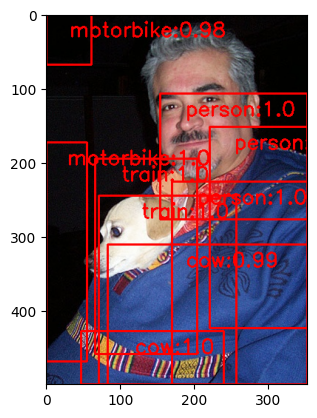

In [7]:
idd='000001'

img='VOC2007_test/JPEGImages/'+idd +'.jpg'
anno='VOC2007_test/Annotations/'+idd+'.xml'
image=cv2.imread(img)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)




ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = image.copy()
detect_boxes=[]
box = []
pred_score =[]
gt_boxes=[]
res=[]


xml =  open(anno)
tree = Et.parse(xml)
root = tree.getroot()
objects = root.findall("object")

for _object in objects:               # ground truth 정보 저장
    bndbox = _object.find('bndbox')   # object -> bndbox 객체 반환
    obj_name = _object.find('name').text   
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)
    idx=obj_class.index(obj_name)
    gt_boxes.append([obj_name,idx,1,{'xmin':xmin,'ymin':ymin,'xmax':xmax,'ymax':ymax}])

for e,result in enumerate(ssresults):
    if e < 500:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        cropped_arround_img= around_context(imout, x,y,w,h,16)
        cropped_arround_img = np.array(cropped_arround_img)
        resized = cv2.resize(cropped_arround_img, (224,224), interpolation = cv2.INTER_AREA)
        resized=resized/255.0
        resized = np.expand_dims(resized, axis=0)
        resized=np.transpose(resized,(0,3,1,2))
        input=torch.FloatTensor(resized).to(device)
        pred=final_model_1(input)[0].cpu().detach().numpy()
        

        #softmax implementation
        maxi=np.max(pred)
        scores = pred - maxi
        e_score = np.exp(scores)
        e_sum = np.sum(e_score)
        sm = e_score / e_sum

        # confidence score
        idx=np.argmax(sm)
        

        if idx==0:
            continue
        if sm[idx]<0.98:
            continue

        confidence_score=sm[idx]
        
        if w<50 :
            continue
        if h<50:
            continue
        
        pred_score.append(sm)
        box.append({'xmin':x,'ymin':y,'xmax':x+w,'ymax':y+h})
        filename=obj_class[idx]
        detect_boxes.append([filename,idx,sm[idx],{'xmin':x,'ymin':y,'xmax':x+w,'ymax':y+h}])
        res.append([filename,confidence_score,x,y,x+w,y+h])


predict = np.array(list(map(lambda x: obj_class[np.argmax(x)], pred_score)))
box = np.array(box)
pred_score = np.array(pred_score)
pred_score_max = list(map(lambda x: max(x), pred_score))

NMS_idx = non_max_suppression(box,pred_score,overlapThresh = 0.1, class_list = obj_class)
final_boxes=[]
for k in NMS_idx:
    filename,confidence_score,xmin,ymin,xmax,ymax=res[k]
    image_rec = cv2.rectangle(imout,( xmin,ymin,xmax,ymax),(255,0,0), 2)
    cv2.putText(image_rec, filename+ ':' +confidence_score.round(2).astype(str),(int(xmin/2+xmax/2),int(ymin)+30 ), cv2.FONT_HERSHEY_SIMPLEX,0.9,(255,0,0),2)
    final_boxes.append(detect_boxes[k])



plt.imshow(imout)
plt.show()

Ground truth

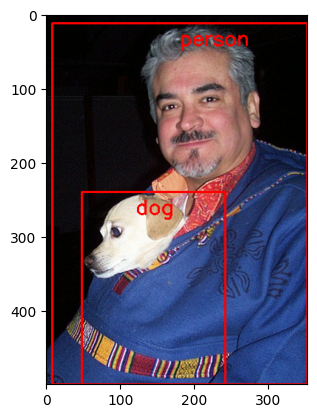

In [8]:
image=cv2.imread(img)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
imout=image.copy()


xml =  open(anno)
tree = Et.parse(xml)
root = tree.getroot()
objects = root.findall("object")
name=[]

for _object in objects:               # ground truth 정보 저장
    bndbox = _object.find('bndbox')   # object -> bndbox 객체 반환
    obj_name = _object.find('name').text   
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)

    image_rec = cv2.rectangle(imout,( xmin,ymin,xmax,ymax),(255,0,0), 2)
    cv2.putText(image_rec,obj_name,(int(xmin/2+xmax/2),int(ymin)+30 ), cv2.FONT_HERSHEY_SIMPLEX,0.9,(255,0,0),2)
    name.append(obj_name)

plt.imshow(imout)
plt.show()



## check only target

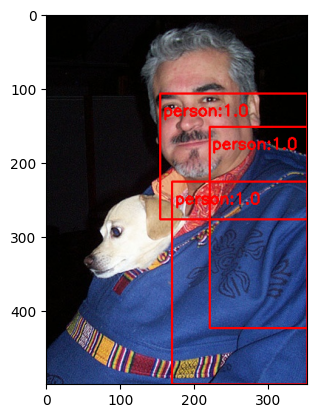

In [9]:
idx=[]
for i in NMS_idx:
    if res[i][0] in name:
        idx.append(i)

image=cv2.imread(img)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
imout=image.copy()

for k in idx:
    filename,confidence_score,xmin,ymin,xmax,ymax=res[k]
    image_rec = cv2.rectangle(imout,( xmin,ymin,xmax,ymax),(255,0,0), 2)
    cv2.putText(image_rec, filename+ ':' +confidence_score.round(2).astype(str),(int(xmin/2+xmax/2-30),int(ymin)+30 ), cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,0,0),2)

plt.imshow(imout)
plt.show()



mAP

In [10]:
from collections import defaultdict

annot_path='VOC2007_test/Annotations'      # annotaion data가 있는 경로
img_path='VOC2007_test/JPEGImages'      # 이미지 데이터가 있는 경로
count=0
state=0
pred_boxes=[]
true_boxes=[]


for e1,i in enumerate(tqdm(os.listdir(annot_path),desc=' ')):
    
    
    file_name=i.split('.')[0]
    img_file=i.split('.')[0]+'.jpg'
    print(f'{img_path}/{img_file} ready')

    xml =  open(os.path.join(annot_path,i),'r')
    tree = Et.parse(xml)
    root = tree.getroot()
    objects = root.findall("object")

    for _object in objects:               # ground truth 정보 저장
        bndbox = _object.find('bndbox')   # object -> bndbox 객체 반환
        obj_name = _object.find('name').text   
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        idx=obj_class.index(obj_name)
        true_boxes.append([e1,idx,1,{'xmin':xmin,'ymin':ymin,'xmax':xmax,'ymax':ymax}])

    
    img=img_path+'/'+img_file
    image=cv2.imread(img)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    box = []
    detect_box=[]
    pred_score =[]

    for e2,result in enumerate(ssresults):
        if e2 < 500:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            cropped_arround_img= around_context(imout, x,y,w,h,16)
            cropped_arround_img = np.array(cropped_arround_img)
            resized = cv2.resize(cropped_arround_img, (224,224), interpolation = cv2.INTER_AREA)
            resized=resized/255.0
            resized = np.expand_dims(resized, axis=0)
            resized=np.transpose(resized,(0,3,1,2))
            input=torch.FloatTensor(resized).to(device)
            pred=final_model_1(input)[0].cpu().detach().numpy()
        
            #softmax implementation
            maxi=np.max(pred)
            scores = pred - maxi
            e_score = np.exp(scores)
            e_sum = np.sum(e_score)
            sm = e_score / e_sum

            # confidence score
            idx=np.argmax(sm)
            

            if idx==0:
                continue
            if sm[idx]<0.50:
                continue
            
            confidence_score=sm[idx]

            if w<50 :
                continue
            if h<50:
                continue
            
            pred_score.append(sm)
            filename=obj_class[idx]
            box.append({'xmin':x,'ymin':y,'xmax':x+w,'ymax':y+h})
            detect_box.append([e1,idx,sm[idx],{'xmin':x,'ymin':y,'xmax':x+w,'ymax':y+h}])
    
    #predict = np.array(list(map(lambda x: obj_class[np.argmax(x)], pred_score)))
    box = np.array(box)
    pred_score = np.array(pred_score)
    NMS_idx = non_max_suppression(box,pred_score,overlapThresh = 0.2, class_list = obj_class)
    
    for k in NMS_idx:
        pred_boxes.append(detect_box[k])

 

    
          
    

 :   0%|          | 0/4952 [00:00<?, ?it/s]

VOC2007_test/JPEGImages/000001.jpg ready


 :   0%|          | 1/4952 [00:04<5:51:15,  4.26s/it]

VOC2007_test/JPEGImages/000002.jpg ready


 :   0%|          | 2/4952 [00:08<5:51:44,  4.26s/it]

VOC2007_test/JPEGImages/000003.jpg ready


 :   0%|          | 3/4952 [00:12<5:54:33,  4.30s/it]

VOC2007_test/JPEGImages/000004.jpg ready


 :   0%|          | 4/4952 [00:17<5:57:20,  4.33s/it]

VOC2007_test/JPEGImages/000006.jpg ready


 :   0%|          | 5/4952 [00:21<5:59:50,  4.36s/it]

VOC2007_test/JPEGImages/000008.jpg ready


 :   0%|          | 6/4952 [00:27<6:28:51,  4.72s/it]

VOC2007_test/JPEGImages/000010.jpg ready


 :   0%|          | 7/4952 [00:32<6:42:31,  4.88s/it]

VOC2007_test/JPEGImages/000011.jpg ready


 :   0%|          | 8/4952 [00:37<6:46:29,  4.93s/it]

VOC2007_test/JPEGImages/000013.jpg ready


 :   0%|          | 9/4952 [00:42<6:50:29,  4.98s/it]

VOC2007_test/JPEGImages/000014.jpg ready


 :   0%|          | 10/4952 [00:47<6:52:44,  5.01s/it]

VOC2007_test/JPEGImages/000015.jpg ready


 :   0%|          | 11/4952 [00:52<7:01:56,  5.12s/it]

VOC2007_test/JPEGImages/000018.jpg ready


 :   0%|          | 12/4952 [00:57<6:36:40,  4.82s/it]

VOC2007_test/JPEGImages/000022.jpg ready


 :   0%|          | 13/4952 [01:02<6:46:19,  4.94s/it]

VOC2007_test/JPEGImages/000025.jpg ready


 :   0%|          | 14/4952 [01:07<7:05:48,  5.17s/it]

VOC2007_test/JPEGImages/000027.jpg ready


 :   0%|          | 15/4952 [01:13<7:24:06,  5.40s/it]

VOC2007_test/JPEGImages/000028.jpg ready


 :   0%|          | 16/4952 [01:19<7:23:16,  5.39s/it]

VOC2007_test/JPEGImages/000029.jpg ready


 :   0%|          | 17/4952 [01:24<7:12:43,  5.26s/it]

VOC2007_test/JPEGImages/000031.jpg ready


 :   0%|          | 18/4952 [01:29<7:09:59,  5.23s/it]

VOC2007_test/JPEGImages/000037.jpg ready


 :   0%|          | 19/4952 [01:34<7:17:30,  5.32s/it]

VOC2007_test/JPEGImages/000038.jpg ready


 :   0%|          | 20/4952 [01:40<7:28:41,  5.46s/it]

VOC2007_test/JPEGImages/000040.jpg ready


 :   0%|          | 21/4952 [01:45<7:11:18,  5.25s/it]

VOC2007_test/JPEGImages/000043.jpg ready


 :   0%|          | 22/4952 [01:49<6:54:59,  5.05s/it]

VOC2007_test/JPEGImages/000045.jpg ready


 :   0%|          | 23/4952 [01:54<6:41:55,  4.89s/it]

VOC2007_test/JPEGImages/000049.jpg ready


 :   0%|          | 24/4952 [01:59<6:51:43,  5.01s/it]

VOC2007_test/JPEGImages/000053.jpg ready


 :   1%|          | 25/4952 [02:04<6:49:40,  4.99s/it]

VOC2007_test/JPEGImages/000054.jpg ready


 :   1%|          | 26/4952 [02:09<6:53:21,  5.03s/it]

VOC2007_test/JPEGImages/000055.jpg ready


 :   1%|          | 27/4952 [02:15<7:07:06,  5.20s/it]

VOC2007_test/JPEGImages/000056.jpg ready


 :   1%|          | 28/4952 [02:20<6:57:22,  5.09s/it]

VOC2007_test/JPEGImages/000057.jpg ready


 :   1%|          | 29/4952 [02:25<6:54:21,  5.05s/it]

VOC2007_test/JPEGImages/000058.jpg ready


 :   1%|          | 30/4952 [02:30<7:06:26,  5.20s/it]

VOC2007_test/JPEGImages/000059.jpg ready


 :   1%|          | 31/4952 [02:36<7:11:56,  5.27s/it]

VOC2007_test/JPEGImages/000062.jpg ready


 :   1%|          | 32/4952 [02:41<7:06:37,  5.20s/it]

VOC2007_test/JPEGImages/000067.jpg ready


 :   1%|          | 33/4952 [02:45<6:51:47,  5.02s/it]

VOC2007_test/JPEGImages/000068.jpg ready


 :   1%|          | 34/4952 [02:51<6:53:54,  5.05s/it]

VOC2007_test/JPEGImages/000069.jpg ready


 :   1%|          | 35/4952 [02:56<7:01:35,  5.14s/it]

VOC2007_test/JPEGImages/000070.jpg ready


 :   1%|          | 36/4952 [03:01<7:04:17,  5.18s/it]

VOC2007_test/JPEGImages/000071.jpg ready


 :   1%|          | 37/4952 [03:06<7:01:19,  5.14s/it]

VOC2007_test/JPEGImages/000074.jpg ready


 :   1%|          | 38/4952 [03:11<6:55:54,  5.08s/it]

VOC2007_test/JPEGImages/000075.jpg ready


 :   1%|          | 39/4952 [03:16<6:45:27,  4.95s/it]

VOC2007_test/JPEGImages/000076.jpg ready


 :   1%|          | 40/4952 [03:21<6:41:36,  4.91s/it]

VOC2007_test/JPEGImages/000079.jpg ready


 :   1%|          | 41/4952 [03:25<6:35:32,  4.83s/it]

VOC2007_test/JPEGImages/000080.jpg ready


 :   1%|          | 42/4952 [03:30<6:33:33,  4.81s/it]

VOC2007_test/JPEGImages/000082.jpg ready


 :   1%|          | 43/4952 [03:35<6:30:05,  4.77s/it]

VOC2007_test/JPEGImages/000084.jpg ready


 :   1%|          | 44/4952 [03:39<6:27:57,  4.74s/it]

VOC2007_test/JPEGImages/000085.jpg ready


 :   1%|          | 45/4952 [03:44<6:20:05,  4.65s/it]

VOC2007_test/JPEGImages/000086.jpg ready


 :   1%|          | 46/4952 [03:48<6:15:39,  4.59s/it]

VOC2007_test/JPEGImages/000087.jpg ready


 :   1%|          | 47/4952 [03:53<6:17:44,  4.62s/it]

VOC2007_test/JPEGImages/000088.jpg ready


 :   1%|          | 48/4952 [03:58<6:21:36,  4.67s/it]

VOC2007_test/JPEGImages/000090.jpg ready


 :   1%|          | 49/4952 [04:03<6:27:26,  4.74s/it]

VOC2007_test/JPEGImages/000092.jpg ready


 :   1%|          | 50/4952 [04:07<6:27:29,  4.74s/it]

VOC2007_test/JPEGImages/000094.jpg ready


 :   1%|          | 51/4952 [04:12<6:24:44,  4.71s/it]

VOC2007_test/JPEGImages/000096.jpg ready


 :   1%|          | 52/4952 [04:17<6:19:47,  4.65s/it]

VOC2007_test/JPEGImages/000097.jpg ready


 :   1%|          | 53/4952 [04:21<6:20:27,  4.66s/it]

VOC2007_test/JPEGImages/000098.jpg ready


 :   1%|          | 54/4952 [04:25<5:57:58,  4.39s/it]

VOC2007_test/JPEGImages/000100.jpg ready


 :   1%|          | 55/4952 [04:29<5:39:59,  4.17s/it]

VOC2007_test/JPEGImages/000103.jpg ready


 :   1%|          | 56/4952 [04:33<5:49:14,  4.28s/it]

VOC2007_test/JPEGImages/000105.jpg ready


 :   1%|          | 57/4952 [04:38<5:54:24,  4.34s/it]

VOC2007_test/JPEGImages/000106.jpg ready


 :   1%|          | 58/4952 [04:42<5:57:39,  4.38s/it]

VOC2007_test/JPEGImages/000108.jpg ready


 :   1%|          | 59/4952 [04:47<6:04:56,  4.48s/it]

VOC2007_test/JPEGImages/000111.jpg ready


 :   1%|          | 60/4952 [04:52<6:15:04,  4.60s/it]

VOC2007_test/JPEGImages/000114.jpg ready


 :   1%|          | 61/4952 [04:57<6:21:36,  4.68s/it]

VOC2007_test/JPEGImages/000115.jpg ready


 :   1%|▏         | 62/4952 [05:01<6:24:46,  4.72s/it]

VOC2007_test/JPEGImages/000116.jpg ready


 :   1%|▏         | 63/4952 [05:06<6:28:03,  4.76s/it]

VOC2007_test/JPEGImages/000119.jpg ready


 :   1%|▏         | 64/4952 [05:11<6:27:50,  4.76s/it]

VOC2007_test/JPEGImages/000124.jpg ready


 :   1%|▏         | 65/4952 [05:16<6:35:09,  4.85s/it]

VOC2007_test/JPEGImages/000126.jpg ready


 :   1%|▏         | 66/4952 [05:21<6:26:21,  4.74s/it]

VOC2007_test/JPEGImages/000127.jpg ready


 :   1%|▏         | 67/4952 [05:26<6:31:46,  4.81s/it]

VOC2007_test/JPEGImages/000128.jpg ready


 :   1%|▏         | 68/4952 [05:31<6:44:04,  4.96s/it]

VOC2007_test/JPEGImages/000135.jpg ready


 :   1%|▏         | 69/4952 [05:36<6:40:35,  4.92s/it]

VOC2007_test/JPEGImages/000136.jpg ready


 :   1%|▏         | 70/4952 [05:41<6:43:44,  4.96s/it]

VOC2007_test/JPEGImages/000137.jpg ready


 :   1%|▏         | 71/4952 [05:45<6:36:11,  4.87s/it]

VOC2007_test/JPEGImages/000139.jpg ready


 :   1%|▏         | 72/4952 [05:50<6:28:30,  4.78s/it]

VOC2007_test/JPEGImages/000144.jpg ready


 :   1%|▏         | 73/4952 [05:54<6:19:21,  4.67s/it]

VOC2007_test/JPEGImages/000145.jpg ready


 :   1%|▏         | 74/4952 [05:59<6:12:14,  4.58s/it]

VOC2007_test/JPEGImages/000148.jpg ready


 :   2%|▏         | 75/4952 [06:03<6:13:39,  4.60s/it]

VOC2007_test/JPEGImages/000149.jpg ready


 :   2%|▏         | 76/4952 [06:08<6:16:42,  4.64s/it]

VOC2007_test/JPEGImages/000151.jpg ready


 :   2%|▏         | 77/4952 [06:13<6:20:44,  4.69s/it]

VOC2007_test/JPEGImages/000152.jpg ready


 :   2%|▏         | 78/4952 [06:17<6:10:55,  4.57s/it]

VOC2007_test/JPEGImages/000155.jpg ready


 :   2%|▏         | 79/4952 [06:21<5:47:37,  4.28s/it]

VOC2007_test/JPEGImages/000157.jpg ready


 :   2%|▏         | 80/4952 [06:24<5:33:32,  4.11s/it]

VOC2007_test/JPEGImages/000160.jpg ready


 :   2%|▏         | 81/4952 [06:30<5:58:23,  4.41s/it]

VOC2007_test/JPEGImages/000166.jpg ready


 :   2%|▏         | 82/4952 [06:35<6:18:41,  4.67s/it]

VOC2007_test/JPEGImages/000167.jpg ready


 :   2%|▏         | 83/4952 [06:40<6:34:50,  4.87s/it]

VOC2007_test/JPEGImages/000168.jpg ready


 :   2%|▏         | 84/4952 [06:45<6:29:02,  4.79s/it]

VOC2007_test/JPEGImages/000172.jpg ready


 :   2%|▏         | 85/4952 [06:50<6:46:56,  5.02s/it]

VOC2007_test/JPEGImages/000175.jpg ready


 :   2%|▏         | 86/4952 [06:55<6:48:29,  5.04s/it]

VOC2007_test/JPEGImages/000176.jpg ready


 :   2%|▏         | 87/4952 [07:00<6:28:10,  4.79s/it]

VOC2007_test/JPEGImages/000178.jpg ready


 :   2%|▏         | 88/4952 [07:04<6:20:45,  4.70s/it]

VOC2007_test/JPEGImages/000179.jpg ready


 :   2%|▏         | 89/4952 [07:09<6:16:30,  4.65s/it]

VOC2007_test/JPEGImages/000181.jpg ready


 :   2%|▏         | 90/4952 [07:13<6:12:50,  4.60s/it]

VOC2007_test/JPEGImages/000182.jpg ready


 :   2%|▏         | 91/4952 [07:18<6:18:15,  4.67s/it]

VOC2007_test/JPEGImages/000183.jpg ready


 :   2%|▏         | 92/4952 [07:23<6:21:06,  4.71s/it]

VOC2007_test/JPEGImages/000185.jpg ready


 :   2%|▏         | 93/4952 [07:28<6:33:20,  4.86s/it]

VOC2007_test/JPEGImages/000186.jpg ready


 :   2%|▏         | 94/4952 [07:32<6:04:47,  4.51s/it]

VOC2007_test/JPEGImages/000188.jpg ready


 :   2%|▏         | 95/4952 [07:36<5:56:06,  4.40s/it]

VOC2007_test/JPEGImages/000191.jpg ready


 :   2%|▏         | 96/4952 [07:40<5:56:14,  4.40s/it]

VOC2007_test/JPEGImages/000195.jpg ready


 :   2%|▏         | 97/4952 [07:45<6:06:10,  4.53s/it]

VOC2007_test/JPEGImages/000196.jpg ready


 :   2%|▏         | 98/4952 [07:50<6:15:21,  4.64s/it]

VOC2007_test/JPEGImages/000197.jpg ready


 :   2%|▏         | 99/4952 [07:55<6:22:49,  4.73s/it]

VOC2007_test/JPEGImages/000199.jpg ready


 :   2%|▏         | 100/4952 [07:59<6:15:05,  4.64s/it]

VOC2007_test/JPEGImages/000201.jpg ready


 :   2%|▏         | 101/4952 [08:04<6:18:28,  4.68s/it]

VOC2007_test/JPEGImages/000202.jpg ready


 :   2%|▏         | 102/4952 [08:09<6:17:34,  4.67s/it]

VOC2007_test/JPEGImages/000204.jpg ready


 :   2%|▏         | 103/4952 [08:14<6:23:33,  4.75s/it]

VOC2007_test/JPEGImages/000205.jpg ready


 :   2%|▏         | 104/4952 [08:18<6:16:00,  4.65s/it]

VOC2007_test/JPEGImages/000206.jpg ready


 :   2%|▏         | 105/4952 [08:23<6:14:30,  4.64s/it]

VOC2007_test/JPEGImages/000212.jpg ready


 :   2%|▏         | 106/4952 [08:27<6:08:25,  4.56s/it]

VOC2007_test/JPEGImages/000213.jpg ready


 :   2%|▏         | 107/4952 [08:31<6:02:09,  4.48s/it]

VOC2007_test/JPEGImages/000216.jpg ready


 :   2%|▏         | 108/4952 [08:33<4:52:30,  3.62s/it]

VOC2007_test/JPEGImages/000217.jpg ready


 :   2%|▏         | 109/4952 [08:37<5:09:18,  3.83s/it]

VOC2007_test/JPEGImages/000223.jpg ready


 :   2%|▏         | 110/4952 [08:42<5:21:01,  3.98s/it]

VOC2007_test/JPEGImages/000226.jpg ready


 :   2%|▏         | 111/4952 [08:46<5:39:57,  4.21s/it]

VOC2007_test/JPEGImages/000227.jpg ready


 :   2%|▏         | 112/4952 [08:51<5:45:07,  4.28s/it]

VOC2007_test/JPEGImages/000230.jpg ready


 :   2%|▏         | 113/4952 [08:55<5:54:06,  4.39s/it]

VOC2007_test/JPEGImages/000231.jpg ready


 :   2%|▏         | 114/4952 [09:00<5:54:35,  4.40s/it]

VOC2007_test/JPEGImages/000234.jpg ready


 :   2%|▏         | 115/4952 [09:05<6:06:58,  4.55s/it]

VOC2007_test/JPEGImages/000237.jpg ready


 :   2%|▏         | 116/4952 [09:09<6:02:08,  4.49s/it]

VOC2007_test/JPEGImages/000238.jpg ready


 :   2%|▏         | 117/4952 [09:14<6:06:15,  4.55s/it]

VOC2007_test/JPEGImages/000239.jpg ready


 :   2%|▏         | 118/4952 [09:18<6:08:31,  4.57s/it]

VOC2007_test/JPEGImages/000240.jpg ready


 :   2%|▏         | 119/4952 [09:24<6:24:29,  4.77s/it]

VOC2007_test/JPEGImages/000243.jpg ready


 :   2%|▏         | 120/4952 [09:25<5:06:26,  3.81s/it]

VOC2007_test/JPEGImages/000247.jpg ready


 :   2%|▏         | 121/4952 [09:30<5:36:30,  4.18s/it]

VOC2007_test/JPEGImages/000248.jpg ready


 :   2%|▏         | 122/4952 [09:35<5:53:05,  4.39s/it]

VOC2007_test/JPEGImages/000252.jpg ready


 :   2%|▏         | 123/4952 [09:40<6:04:19,  4.53s/it]

VOC2007_test/JPEGImages/000253.jpg ready


 :   3%|▎         | 124/4952 [09:45<6:10:09,  4.60s/it]

VOC2007_test/JPEGImages/000254.jpg ready


 :   3%|▎         | 125/4952 [09:50<6:16:11,  4.68s/it]

VOC2007_test/JPEGImages/000255.jpg ready


 :   3%|▎         | 126/4952 [09:54<6:11:56,  4.62s/it]

VOC2007_test/JPEGImages/000258.jpg ready


 :   3%|▎         | 127/4952 [09:59<6:14:53,  4.66s/it]

VOC2007_test/JPEGImages/000260.jpg ready


 :   3%|▎         | 128/4952 [10:04<6:27:59,  4.83s/it]

VOC2007_test/JPEGImages/000261.jpg ready


 :   3%|▎         | 129/4952 [10:09<6:33:39,  4.90s/it]

VOC2007_test/JPEGImages/000264.jpg ready


 :   3%|▎         | 130/4952 [10:14<6:34:15,  4.91s/it]

VOC2007_test/JPEGImages/000265.jpg ready


 :   3%|▎         | 131/4952 [10:19<6:32:07,  4.88s/it]

VOC2007_test/JPEGImages/000267.jpg ready


 :   3%|▎         | 132/4952 [10:23<6:18:28,  4.71s/it]

VOC2007_test/JPEGImages/000271.jpg ready


 :   3%|▎         | 133/4952 [10:27<6:05:30,  4.55s/it]

VOC2007_test/JPEGImages/000272.jpg ready


 :   3%|▎         | 134/4952 [10:32<6:00:40,  4.49s/it]

VOC2007_test/JPEGImages/000273.jpg ready


 :   3%|▎         | 135/4952 [10:36<6:05:20,  4.55s/it]

VOC2007_test/JPEGImages/000274.jpg ready


 :   3%|▎         | 136/4952 [10:41<6:07:08,  4.57s/it]

VOC2007_test/JPEGImages/000277.jpg ready


 :   3%|▎         | 137/4952 [10:46<6:06:09,  4.56s/it]

VOC2007_test/JPEGImages/000279.jpg ready


 :   3%|▎         | 138/4952 [10:50<6:06:21,  4.57s/it]

VOC2007_test/JPEGImages/000280.jpg ready


 :   3%|▎         | 139/4952 [10:55<6:11:58,  4.64s/it]

VOC2007_test/JPEGImages/000281.jpg ready


 :   3%|▎         | 140/4952 [10:59<6:03:51,  4.54s/it]

VOC2007_test/JPEGImages/000283.jpg ready


 :   3%|▎         | 141/4952 [11:05<6:22:37,  4.77s/it]

VOC2007_test/JPEGImages/000284.jpg ready


 :   3%|▎         | 142/4952 [11:09<6:15:39,  4.69s/it]

VOC2007_test/JPEGImages/000286.jpg ready


 :   3%|▎         | 143/4952 [11:14<6:14:54,  4.68s/it]

VOC2007_test/JPEGImages/000287.jpg ready


 :   3%|▎         | 144/4952 [11:19<6:18:20,  4.72s/it]

VOC2007_test/JPEGImages/000290.jpg ready


 :   3%|▎         | 145/4952 [11:23<6:16:23,  4.70s/it]

VOC2007_test/JPEGImages/000291.jpg ready


 :   3%|▎         | 146/4952 [11:28<6:15:47,  4.69s/it]

VOC2007_test/JPEGImages/000292.jpg ready


 :   3%|▎         | 147/4952 [11:34<6:37:36,  4.96s/it]

VOC2007_test/JPEGImages/000293.jpg ready


 :   3%|▎         | 148/4952 [11:39<6:52:17,  5.15s/it]

VOC2007_test/JPEGImages/000295.jpg ready


 :   3%|▎         | 149/4952 [11:44<6:56:47,  5.21s/it]

VOC2007_test/JPEGImages/000297.jpg ready


 :   3%|▎         | 150/4952 [11:51<7:22:21,  5.53s/it]

VOC2007_test/JPEGImages/000299.jpg ready


 :   3%|▎         | 151/4952 [11:56<7:21:54,  5.52s/it]

VOC2007_test/JPEGImages/000300.jpg ready


 :   3%|▎         | 152/4952 [12:02<7:21:23,  5.52s/it]

VOC2007_test/JPEGImages/000301.jpg ready


 :   3%|▎         | 153/4952 [12:07<7:21:12,  5.52s/it]

VOC2007_test/JPEGImages/000309.jpg ready


 :   3%|▎         | 154/4952 [12:13<7:15:27,  5.45s/it]

VOC2007_test/JPEGImages/000310.jpg ready


 :   3%|▎         | 155/4952 [12:18<7:11:44,  5.40s/it]

VOC2007_test/JPEGImages/000313.jpg ready


 :   3%|▎         | 156/4952 [12:23<7:00:15,  5.26s/it]

VOC2007_test/JPEGImages/000314.jpg ready


 :   3%|▎         | 157/4952 [12:28<6:49:27,  5.12s/it]

VOC2007_test/JPEGImages/000315.jpg ready


 :   3%|▎         | 158/4952 [12:33<6:50:04,  5.13s/it]

VOC2007_test/JPEGImages/000316.jpg ready


 :   3%|▎         | 159/4952 [12:37<6:41:20,  5.02s/it]

VOC2007_test/JPEGImages/000319.jpg ready


 :   3%|▎         | 160/4952 [12:42<6:34:42,  4.94s/it]

VOC2007_test/JPEGImages/000324.jpg ready


 :   3%|▎         | 161/4952 [12:48<6:45:30,  5.08s/it]

VOC2007_test/JPEGImages/000326.jpg ready


 :   3%|▎         | 162/4952 [12:53<6:54:05,  5.19s/it]

VOC2007_test/JPEGImages/000327.jpg ready


 :   3%|▎         | 163/4952 [12:59<7:05:55,  5.34s/it]

VOC2007_test/JPEGImages/000330.jpg ready


 :   3%|▎         | 164/4952 [13:04<7:10:30,  5.39s/it]

VOC2007_test/JPEGImages/000333.jpg ready


 :   3%|▎         | 165/4952 [13:10<7:10:23,  5.39s/it]

VOC2007_test/JPEGImages/000335.jpg ready


 :   3%|▎         | 166/4952 [13:15<7:09:07,  5.38s/it]

VOC2007_test/JPEGImages/000339.jpg ready


 :   3%|▎         | 167/4952 [13:21<7:12:08,  5.42s/it]

VOC2007_test/JPEGImages/000341.jpg ready


 :   3%|▎         | 168/4952 [13:26<7:02:45,  5.30s/it]

VOC2007_test/JPEGImages/000342.jpg ready


 :   3%|▎         | 169/4952 [13:31<7:03:28,  5.31s/it]

VOC2007_test/JPEGImages/000345.jpg ready


 :   3%|▎         | 170/4952 [13:36<7:01:03,  5.28s/it]

VOC2007_test/JPEGImages/000346.jpg ready


 :   3%|▎         | 171/4952 [13:42<7:09:47,  5.39s/it]

VOC2007_test/JPEGImages/000348.jpg ready


 :   3%|▎         | 172/4952 [13:47<7:05:20,  5.34s/it]

VOC2007_test/JPEGImages/000350.jpg ready


 :   3%|▎         | 173/4952 [13:52<7:01:17,  5.29s/it]

VOC2007_test/JPEGImages/000351.jpg ready


 :   4%|▎         | 174/4952 [13:56<6:34:57,  4.96s/it]

VOC2007_test/JPEGImages/000353.jpg ready


 :   4%|▎         | 175/4952 [14:02<6:44:04,  5.08s/it]

VOC2007_test/JPEGImages/000356.jpg ready


 :   4%|▎         | 176/4952 [14:07<6:40:04,  5.03s/it]

VOC2007_test/JPEGImages/000357.jpg ready


 :   4%|▎         | 177/4952 [14:12<6:47:36,  5.12s/it]

VOC2007_test/JPEGImages/000358.jpg ready


 :   4%|▎         | 178/4952 [14:17<6:51:28,  5.17s/it]

VOC2007_test/JPEGImages/000360.jpg ready


 :   4%|▎         | 179/4952 [14:22<6:52:02,  5.18s/it]

VOC2007_test/JPEGImages/000361.jpg ready


 :   4%|▎         | 180/4952 [14:28<6:56:35,  5.24s/it]

VOC2007_test/JPEGImages/000362.jpg ready


 :   4%|▎         | 181/4952 [14:33<6:45:44,  5.10s/it]

VOC2007_test/JPEGImages/000364.jpg ready


 :   4%|▎         | 182/4952 [14:38<6:50:01,  5.16s/it]

VOC2007_test/JPEGImages/000365.jpg ready


 :   4%|▎         | 183/4952 [14:43<6:59:14,  5.27s/it]

VOC2007_test/JPEGImages/000366.jpg ready


 :   4%|▎         | 184/4952 [14:49<7:02:06,  5.31s/it]

VOC2007_test/JPEGImages/000368.jpg ready


 :   4%|▎         | 185/4952 [14:54<7:00:43,  5.30s/it]

VOC2007_test/JPEGImages/000369.jpg ready


 :   4%|▍         | 186/4952 [15:00<7:03:54,  5.34s/it]

VOC2007_test/JPEGImages/000371.jpg ready


 :   4%|▍         | 187/4952 [15:05<7:00:24,  5.29s/it]

VOC2007_test/JPEGImages/000375.jpg ready


 :   4%|▍         | 188/4952 [15:10<7:06:14,  5.37s/it]

VOC2007_test/JPEGImages/000376.jpg ready


 :   4%|▍         | 189/4952 [15:15<6:55:18,  5.23s/it]

VOC2007_test/JPEGImages/000377.jpg ready


 :   4%|▍         | 190/4952 [15:21<7:02:48,  5.33s/it]

VOC2007_test/JPEGImages/000378.jpg ready


 :   4%|▍         | 191/4952 [15:24<6:25:22,  4.86s/it]

VOC2007_test/JPEGImages/000383.jpg ready


 :   4%|▍         | 192/4952 [15:30<6:40:05,  5.04s/it]

VOC2007_test/JPEGImages/000384.jpg ready


 :   4%|▍         | 193/4952 [15:35<6:42:14,  5.07s/it]

VOC2007_test/JPEGImages/000385.jpg ready


 :   4%|▍         | 194/4952 [15:41<6:53:39,  5.22s/it]

VOC2007_test/JPEGImages/000386.jpg ready


 :   4%|▍         | 195/4952 [15:46<6:56:23,  5.25s/it]

VOC2007_test/JPEGImages/000388.jpg ready


 :   4%|▍         | 196/4952 [15:51<6:55:56,  5.25s/it]

VOC2007_test/JPEGImages/000389.jpg ready


 :   4%|▍         | 197/4952 [15:56<6:41:45,  5.07s/it]

VOC2007_test/JPEGImages/000390.jpg ready


 :   4%|▍         | 198/4952 [16:02<6:56:48,  5.26s/it]

VOC2007_test/JPEGImages/000392.jpg ready


 :   4%|▍         | 199/4952 [16:07<6:53:00,  5.21s/it]

VOC2007_test/JPEGImages/000393.jpg ready


 :   4%|▍         | 200/4952 [16:12<6:45:01,  5.11s/it]

VOC2007_test/JPEGImages/000397.jpg ready


 :   4%|▍         | 201/4952 [16:17<6:55:15,  5.24s/it]

VOC2007_test/JPEGImages/000398.jpg ready


 :   4%|▍         | 202/4952 [16:23<7:18:33,  5.54s/it]

VOC2007_test/JPEGImages/000399.jpg ready


 :   4%|▍         | 203/4952 [16:28<6:57:37,  5.28s/it]

VOC2007_test/JPEGImages/000401.jpg ready


 :   4%|▍         | 204/4952 [16:33<6:58:20,  5.29s/it]

VOC2007_test/JPEGImages/000402.jpg ready


 :   4%|▍         | 205/4952 [16:38<6:52:02,  5.21s/it]

VOC2007_test/JPEGImages/000405.jpg ready


 :   4%|▍         | 206/4952 [16:43<6:45:22,  5.12s/it]

VOC2007_test/JPEGImages/000409.jpg ready


 :   4%|▍         | 207/4952 [16:48<6:46:47,  5.14s/it]

VOC2007_test/JPEGImages/000410.jpg ready


 :   4%|▍         | 208/4952 [16:54<6:54:59,  5.25s/it]

VOC2007_test/JPEGImages/000412.jpg ready


 :   4%|▍         | 209/4952 [16:59<6:57:32,  5.28s/it]

VOC2007_test/JPEGImages/000413.jpg ready


 :   4%|▍         | 210/4952 [17:05<7:07:47,  5.41s/it]

VOC2007_test/JPEGImages/000414.jpg ready


 :   4%|▍         | 211/4952 [17:11<7:15:29,  5.51s/it]

VOC2007_test/JPEGImages/000415.jpg ready


 :   4%|▍         | 212/4952 [17:16<7:11:48,  5.47s/it]

VOC2007_test/JPEGImages/000418.jpg ready


 :   4%|▍         | 213/4952 [17:22<7:20:33,  5.58s/it]

VOC2007_test/JPEGImages/000421.jpg ready


 :   4%|▍         | 214/4952 [17:28<7:20:41,  5.58s/it]

VOC2007_test/JPEGImages/000422.jpg ready


 :   4%|▍         | 215/4952 [17:34<7:35:33,  5.77s/it]

VOC2007_test/JPEGImages/000423.jpg ready


 :   4%|▍         | 216/4952 [17:39<7:30:43,  5.71s/it]

VOC2007_test/JPEGImages/000425.jpg ready


 :   4%|▍         | 217/4952 [17:45<7:19:18,  5.57s/it]

VOC2007_test/JPEGImages/000426.jpg ready


 :   4%|▍         | 218/4952 [17:50<7:19:55,  5.58s/it]

VOC2007_test/JPEGImages/000429.jpg ready


 :   4%|▍         | 219/4952 [17:56<7:20:14,  5.58s/it]

VOC2007_test/JPEGImages/000432.jpg ready


 :   4%|▍         | 220/4952 [18:01<7:20:05,  5.58s/it]

VOC2007_test/JPEGImages/000434.jpg ready


 :   4%|▍         | 221/4952 [18:07<7:20:40,  5.59s/it]

VOC2007_test/JPEGImages/000436.jpg ready


 :   4%|▍         | 222/4952 [18:12<7:16:48,  5.54s/it]

VOC2007_test/JPEGImages/000437.jpg ready


 :   5%|▍         | 223/4952 [18:17<7:06:49,  5.42s/it]

VOC2007_test/JPEGImages/000440.jpg ready


 :   5%|▍         | 224/4952 [18:23<7:06:58,  5.42s/it]

VOC2007_test/JPEGImages/000441.jpg ready


 :   5%|▍         | 225/4952 [18:28<7:03:09,  5.37s/it]

VOC2007_test/JPEGImages/000442.jpg ready


 :   5%|▍         | 226/4952 [18:34<7:09:52,  5.46s/it]

VOC2007_test/JPEGImages/000444.jpg ready


 :   5%|▍         | 227/4952 [18:39<7:07:58,  5.43s/it]

VOC2007_test/JPEGImages/000445.jpg ready


 :   5%|▍         | 228/4952 [18:44<6:53:35,  5.25s/it]

VOC2007_test/JPEGImages/000447.jpg ready


 :   5%|▍         | 229/4952 [18:50<7:07:44,  5.43s/it]

VOC2007_test/JPEGImages/000449.jpg ready


 :   5%|▍         | 230/4952 [18:55<7:10:54,  5.48s/it]

VOC2007_test/JPEGImages/000451.jpg ready


 :   5%|▍         | 231/4952 [19:01<7:01:02,  5.35s/it]

VOC2007_test/JPEGImages/000452.jpg ready


 :   5%|▍         | 232/4952 [19:06<7:01:50,  5.36s/it]

VOC2007_test/JPEGImages/000453.jpg ready


 :   5%|▍         | 233/4952 [19:11<6:55:36,  5.28s/it]

VOC2007_test/JPEGImages/000455.jpg ready


 :   5%|▍         | 234/4952 [19:16<6:50:57,  5.23s/it]

VOC2007_test/JPEGImages/000456.jpg ready


 :   5%|▍         | 235/4952 [19:22<6:58:01,  5.32s/it]

VOC2007_test/JPEGImages/000457.jpg ready


 :   5%|▍         | 236/4952 [19:27<6:56:46,  5.30s/it]

VOC2007_test/JPEGImages/000458.jpg ready


 :   5%|▍         | 237/4952 [19:32<7:00:08,  5.35s/it]

VOC2007_test/JPEGImages/000465.jpg ready


 :   5%|▍         | 238/4952 [19:38<7:04:09,  5.40s/it]

VOC2007_test/JPEGImages/000466.jpg ready


 :   5%|▍         | 239/4952 [19:44<7:14:21,  5.53s/it]

VOC2007_test/JPEGImages/000467.jpg ready


 :   5%|▍         | 240/4952 [19:49<7:09:56,  5.47s/it]

VOC2007_test/JPEGImages/000471.jpg ready


 :   5%|▍         | 241/4952 [19:54<7:07:27,  5.44s/it]

VOC2007_test/JPEGImages/000472.jpg ready


 :   5%|▍         | 242/4952 [19:59<6:56:16,  5.30s/it]

VOC2007_test/JPEGImages/000473.jpg ready


 :   5%|▍         | 243/4952 [20:04<6:35:30,  5.04s/it]

VOC2007_test/JPEGImages/000475.jpg ready


 :   5%|▍         | 244/4952 [20:09<6:41:07,  5.11s/it]

VOC2007_test/JPEGImages/000478.jpg ready


 :   5%|▍         | 245/4952 [20:14<6:26:19,  4.92s/it]

VOC2007_test/JPEGImages/000479.jpg ready


 :   5%|▍         | 246/4952 [20:19<6:31:10,  4.99s/it]

VOC2007_test/JPEGImages/000481.jpg ready


 :   5%|▍         | 247/4952 [20:24<6:34:27,  5.03s/it]

VOC2007_test/JPEGImages/000485.jpg ready


 :   5%|▌         | 248/4952 [20:29<6:29:02,  4.96s/it]

VOC2007_test/JPEGImages/000487.jpg ready


 :   5%|▌         | 249/4952 [20:34<6:30:05,  4.98s/it]

VOC2007_test/JPEGImages/000488.jpg ready


 :   5%|▌         | 250/4952 [20:39<6:33:33,  5.02s/it]

VOC2007_test/JPEGImages/000490.jpg ready


 :   5%|▌         | 251/4952 [20:44<6:30:25,  4.98s/it]

VOC2007_test/JPEGImages/000493.jpg ready


 :   5%|▌         | 252/4952 [20:49<6:40:35,  5.11s/it]

VOC2007_test/JPEGImages/000495.jpg ready


 :   5%|▌         | 253/4952 [20:54<6:38:39,  5.09s/it]

VOC2007_test/JPEGImages/000497.jpg ready


 :   5%|▌         | 254/4952 [21:01<7:23:46,  5.67s/it]

VOC2007_test/JPEGImages/000502.jpg ready


 :   5%|▌         | 255/4952 [21:07<7:19:48,  5.62s/it]

VOC2007_test/JPEGImages/000504.jpg ready


 :   5%|▌         | 256/4952 [21:12<7:21:29,  5.64s/it]

VOC2007_test/JPEGImages/000505.jpg ready


 :   5%|▌         | 257/4952 [21:18<7:13:36,  5.54s/it]

VOC2007_test/JPEGImages/000506.jpg ready


 :   5%|▌         | 258/4952 [21:23<7:09:04,  5.48s/it]

VOC2007_test/JPEGImages/000507.jpg ready


 :   5%|▌         | 259/4952 [21:29<7:17:33,  5.59s/it]

VOC2007_test/JPEGImages/000510.jpg ready


 :   5%|▌         | 260/4952 [21:35<7:18:06,  5.60s/it]

VOC2007_test/JPEGImages/000511.jpg ready


 :   5%|▌         | 261/4952 [21:40<7:15:10,  5.57s/it]

VOC2007_test/JPEGImages/000512.jpg ready


 :   5%|▌         | 262/4952 [21:46<7:22:28,  5.66s/it]

VOC2007_test/JPEGImages/000517.jpg ready


 :   5%|▌         | 263/4952 [21:51<7:13:15,  5.54s/it]

VOC2007_test/JPEGImages/000521.jpg ready


 :   5%|▌         | 264/4952 [21:54<6:01:25,  4.63s/it]

VOC2007_test/JPEGImages/000527.jpg ready


 :   5%|▌         | 265/4952 [21:59<6:22:41,  4.90s/it]

VOC2007_test/JPEGImages/000529.jpg ready


 :   5%|▌         | 266/4952 [22:04<6:31:02,  5.01s/it]

VOC2007_test/JPEGImages/000532.jpg ready


 :   5%|▌         | 267/4952 [22:10<6:44:41,  5.18s/it]

VOC2007_test/JPEGImages/000533.jpg ready


 :   5%|▌         | 268/4952 [22:14<6:20:52,  4.88s/it]

VOC2007_test/JPEGImages/000534.jpg ready


 :   5%|▌         | 269/4952 [22:20<6:47:31,  5.22s/it]

VOC2007_test/JPEGImages/000536.jpg ready


 :   5%|▌         | 270/4952 [22:26<6:52:25,  5.29s/it]

VOC2007_test/JPEGImages/000538.jpg ready


 :   5%|▌         | 271/4952 [22:31<6:49:16,  5.25s/it]

VOC2007_test/JPEGImages/000539.jpg ready


 :   5%|▌         | 272/4952 [22:36<6:50:53,  5.27s/it]

VOC2007_test/JPEGImages/000542.jpg ready


 :   6%|▌         | 273/4952 [22:41<6:47:35,  5.23s/it]

VOC2007_test/JPEGImages/000546.jpg ready


 :   6%|▌         | 274/4952 [22:47<6:53:51,  5.31s/it]

VOC2007_test/JPEGImages/000547.jpg ready


 :   6%|▌         | 275/4952 [22:53<7:09:09,  5.51s/it]

VOC2007_test/JPEGImages/000548.jpg ready


 :   6%|▌         | 276/4952 [22:58<7:12:13,  5.55s/it]

VOC2007_test/JPEGImages/000551.jpg ready


 :   6%|▌         | 277/4952 [23:04<7:04:47,  5.45s/it]

VOC2007_test/JPEGImages/000553.jpg ready


 :   6%|▌         | 278/4952 [23:09<7:12:16,  5.55s/it]

VOC2007_test/JPEGImages/000556.jpg ready


 :   6%|▌         | 279/4952 [23:15<7:07:58,  5.50s/it]

VOC2007_test/JPEGImages/000557.jpg ready


 :   6%|▌         | 280/4952 [23:20<7:12:04,  5.55s/it]

VOC2007_test/JPEGImages/000558.jpg ready


 :   6%|▌         | 281/4952 [23:25<6:49:30,  5.26s/it]

VOC2007_test/JPEGImages/000560.jpg ready


 :   6%|▌         | 282/4952 [23:31<6:57:01,  5.36s/it]

VOC2007_test/JPEGImages/000561.jpg ready


 :   6%|▌         | 283/4952 [23:36<7:05:07,  5.46s/it]

VOC2007_test/JPEGImages/000562.jpg ready


 :   6%|▌         | 284/4952 [23:42<7:13:25,  5.57s/it]

VOC2007_test/JPEGImages/000566.jpg ready


 :   6%|▌         | 285/4952 [23:48<7:15:17,  5.60s/it]

VOC2007_test/JPEGImages/000567.jpg ready


 :   6%|▌         | 286/4952 [23:53<7:16:42,  5.62s/it]

VOC2007_test/JPEGImages/000568.jpg ready


 :   6%|▌         | 287/4952 [23:58<6:53:42,  5.32s/it]

VOC2007_test/JPEGImages/000569.jpg ready


 :   6%|▌         | 288/4952 [24:03<6:53:12,  5.32s/it]

VOC2007_test/JPEGImages/000570.jpg ready


 :   6%|▌         | 289/4952 [24:09<6:55:47,  5.35s/it]

VOC2007_test/JPEGImages/000571.jpg ready


 :   6%|▌         | 290/4952 [24:15<7:24:24,  5.72s/it]

VOC2007_test/JPEGImages/000572.jpg ready


 :   6%|▌         | 291/4952 [24:21<7:22:05,  5.69s/it]

VOC2007_test/JPEGImages/000573.jpg ready


 :   6%|▌         | 292/4952 [24:26<7:17:10,  5.63s/it]

VOC2007_test/JPEGImages/000574.jpg ready


 :   6%|▌         | 293/4952 [24:32<7:12:00,  5.56s/it]

VOC2007_test/JPEGImages/000575.jpg ready


 :   6%|▌         | 294/4952 [24:37<6:56:29,  5.36s/it]

VOC2007_test/JPEGImages/000576.jpg ready


 :   6%|▌         | 295/4952 [24:42<6:47:55,  5.26s/it]

VOC2007_test/JPEGImages/000578.jpg ready


 :   6%|▌         | 296/4952 [24:47<6:54:02,  5.34s/it]

VOC2007_test/JPEGImages/000580.jpg ready


 :   6%|▌         | 297/4952 [24:53<7:04:59,  5.48s/it]

VOC2007_test/JPEGImages/000584.jpg ready


 :   6%|▌         | 298/4952 [24:59<7:07:15,  5.51s/it]

VOC2007_test/JPEGImages/000585.jpg ready


 :   6%|▌         | 299/4952 [25:04<7:02:33,  5.45s/it]

VOC2007_test/JPEGImages/000586.jpg ready


 :   6%|▌         | 300/4952 [25:10<7:04:54,  5.48s/it]

VOC2007_test/JPEGImages/000587.jpg ready


 :   6%|▌         | 301/4952 [25:15<7:04:13,  5.47s/it]

VOC2007_test/JPEGImages/000593.jpg ready


 :   6%|▌         | 302/4952 [25:21<7:06:34,  5.50s/it]

VOC2007_test/JPEGImages/000594.jpg ready


 :   6%|▌         | 303/4952 [25:26<6:52:38,  5.33s/it]

VOC2007_test/JPEGImages/000595.jpg ready


 :   6%|▌         | 304/4952 [25:31<7:04:07,  5.47s/it]

VOC2007_test/JPEGImages/000596.jpg ready


 :   6%|▌         | 305/4952 [25:37<7:06:03,  5.50s/it]

VOC2007_test/JPEGImages/000600.jpg ready


 :   6%|▌         | 306/4952 [25:42<6:51:31,  5.31s/it]

VOC2007_test/JPEGImages/000602.jpg ready


 :   6%|▌         | 307/4952 [25:47<6:47:20,  5.26s/it]

VOC2007_test/JPEGImages/000603.jpg ready


 :   6%|▌         | 308/4952 [25:53<6:54:57,  5.36s/it]

VOC2007_test/JPEGImages/000604.jpg ready


 :   6%|▌         | 309/4952 [25:58<6:53:03,  5.34s/it]

VOC2007_test/JPEGImages/000606.jpg ready


 :   6%|▋         | 310/4952 [26:03<6:53:52,  5.35s/it]

VOC2007_test/JPEGImages/000607.jpg ready


 :   6%|▋         | 311/4952 [26:08<6:52:50,  5.34s/it]

VOC2007_test/JPEGImages/000611.jpg ready


 :   6%|▋         | 312/4952 [26:14<6:51:11,  5.32s/it]

VOC2007_test/JPEGImages/000614.jpg ready


 :   6%|▋         | 313/4952 [26:19<6:53:23,  5.35s/it]

VOC2007_test/JPEGImages/000615.jpg ready


 :   6%|▋         | 314/4952 [26:24<6:45:26,  5.24s/it]

VOC2007_test/JPEGImages/000616.jpg ready


 :   6%|▋         | 315/4952 [26:30<7:05:02,  5.50s/it]

VOC2007_test/JPEGImages/000617.jpg ready


 :   6%|▋         | 316/4952 [26:36<7:02:28,  5.47s/it]

VOC2007_test/JPEGImages/000618.jpg ready


 :   6%|▋         | 317/4952 [26:40<6:45:21,  5.25s/it]

VOC2007_test/JPEGImages/000621.jpg ready


 :   6%|▋         | 318/4952 [26:46<6:53:34,  5.35s/it]

VOC2007_test/JPEGImages/000623.jpg ready


 :   6%|▋         | 319/4952 [26:50<6:18:05,  4.90s/it]

VOC2007_test/JPEGImages/000624.jpg ready


 :   6%|▋         | 320/4952 [26:55<6:28:35,  5.03s/it]

VOC2007_test/JPEGImages/000627.jpg ready


 :   6%|▋         | 321/4952 [27:01<6:48:06,  5.29s/it]

VOC2007_test/JPEGImages/000629.jpg ready


 :   7%|▋         | 322/4952 [27:06<6:30:55,  5.07s/it]

VOC2007_test/JPEGImages/000630.jpg ready


 :   7%|▋         | 323/4952 [27:11<6:45:19,  5.25s/it]

VOC2007_test/JPEGImages/000631.jpg ready


 :   7%|▋         | 324/4952 [27:17<6:47:37,  5.28s/it]

VOC2007_test/JPEGImages/000634.jpg ready


 :   7%|▋         | 325/4952 [27:22<6:50:22,  5.32s/it]

VOC2007_test/JPEGImages/000636.jpg ready


 :   7%|▋         | 326/4952 [27:27<6:45:44,  5.26s/it]

VOC2007_test/JPEGImages/000638.jpg ready


 :   7%|▋         | 327/4952 [27:33<6:58:54,  5.43s/it]

VOC2007_test/JPEGImages/000639.jpg ready


 :   7%|▋         | 328/4952 [27:38<6:52:47,  5.36s/it]

VOC2007_test/JPEGImages/000640.jpg ready


 :   7%|▋         | 329/4952 [27:44<7:00:27,  5.46s/it]

VOC2007_test/JPEGImages/000641.jpg ready


 :   7%|▋         | 330/4952 [27:50<7:09:05,  5.57s/it]

VOC2007_test/JPEGImages/000642.jpg ready


 :   7%|▋         | 331/4952 [27:55<7:10:35,  5.59s/it]

VOC2007_test/JPEGImages/000643.jpg ready


 :   7%|▋         | 332/4952 [28:01<7:11:11,  5.60s/it]

VOC2007_test/JPEGImages/000644.jpg ready


 :   7%|▋         | 333/4952 [28:07<7:12:25,  5.62s/it]

VOC2007_test/JPEGImages/000646.jpg ready


 :   7%|▋         | 334/4952 [28:12<7:12:24,  5.62s/it]

VOC2007_test/JPEGImages/000649.jpg ready


 :   7%|▋         | 335/4952 [28:17<7:02:28,  5.49s/it]

VOC2007_test/JPEGImages/000650.jpg ready


 :   7%|▋         | 336/4952 [28:23<6:58:10,  5.44s/it]

VOC2007_test/JPEGImages/000651.jpg ready


 :   7%|▋         | 337/4952 [28:28<6:52:59,  5.37s/it]

VOC2007_test/JPEGImages/000652.jpg ready


 :   7%|▋         | 338/4952 [28:33<6:48:19,  5.31s/it]

VOC2007_test/JPEGImages/000655.jpg ready


 :   7%|▋         | 339/4952 [28:38<6:41:34,  5.22s/it]

VOC2007_test/JPEGImages/000658.jpg ready


 :   7%|▋         | 340/4952 [28:43<6:38:25,  5.18s/it]

VOC2007_test/JPEGImages/000659.jpg ready


 :   7%|▋         | 341/4952 [28:49<6:50:54,  5.35s/it]

VOC2007_test/JPEGImages/000662.jpg ready


 :   7%|▋         | 342/4952 [28:54<6:36:46,  5.16s/it]

VOC2007_test/JPEGImages/000664.jpg ready


 :   7%|▋         | 343/4952 [28:59<6:42:16,  5.24s/it]

VOC2007_test/JPEGImages/000665.jpg ready


 :   7%|▋         | 344/4952 [29:02<5:48:00,  4.53s/it]

VOC2007_test/JPEGImages/000666.jpg ready


 :   7%|▋         | 345/4952 [29:07<6:02:46,  4.72s/it]

VOC2007_test/JPEGImages/000668.jpg ready


 :   7%|▋         | 346/4952 [29:12<6:09:34,  4.81s/it]

VOC2007_test/JPEGImages/000669.jpg ready


 :   7%|▋         | 347/4952 [29:18<6:24:45,  5.01s/it]

VOC2007_test/JPEGImages/000670.jpg ready


 :   7%|▋         | 348/4952 [29:23<6:34:59,  5.15s/it]

VOC2007_test/JPEGImages/000673.jpg ready


 :   7%|▋         | 349/4952 [29:28<6:34:30,  5.14s/it]

VOC2007_test/JPEGImages/000674.jpg ready


 :   7%|▋         | 350/4952 [29:34<6:45:48,  5.29s/it]

VOC2007_test/JPEGImages/000678.jpg ready


 :   7%|▋         | 351/4952 [29:39<6:48:46,  5.33s/it]

VOC2007_test/JPEGImages/000679.jpg ready


 :   7%|▋         | 352/4952 [29:44<6:43:39,  5.27s/it]

VOC2007_test/JPEGImages/000681.jpg ready


 :   7%|▋         | 353/4952 [29:47<5:46:32,  4.52s/it]

VOC2007_test/JPEGImages/000683.jpg ready


 :   7%|▋         | 354/4952 [29:53<6:05:36,  4.77s/it]

VOC2007_test/JPEGImages/000687.jpg ready


 :   7%|▋         | 355/4952 [29:58<6:14:23,  4.89s/it]

VOC2007_test/JPEGImages/000691.jpg ready


 :   7%|▋         | 356/4952 [30:03<6:29:48,  5.09s/it]

VOC2007_test/JPEGImages/000692.jpg ready


 :   7%|▋         | 357/4952 [30:08<6:30:18,  5.10s/it]

VOC2007_test/JPEGImages/000693.jpg ready


 :   7%|▋         | 358/4952 [30:14<6:33:21,  5.14s/it]

VOC2007_test/JPEGImages/000696.jpg ready


 :   7%|▋         | 359/4952 [30:18<6:24:27,  5.02s/it]

VOC2007_test/JPEGImages/000697.jpg ready


 :   7%|▋         | 360/4952 [30:24<6:28:04,  5.07s/it]

VOC2007_test/JPEGImages/000698.jpg ready


 :   7%|▋         | 361/4952 [30:28<6:21:48,  4.99s/it]

VOC2007_test/JPEGImages/000701.jpg ready


 :   7%|▋         | 362/4952 [30:33<6:17:14,  4.93s/it]

VOC2007_test/JPEGImages/000703.jpg ready


 :   7%|▋         | 363/4952 [30:38<6:17:49,  4.94s/it]

VOC2007_test/JPEGImages/000704.jpg ready


 :   7%|▋         | 364/4952 [30:43<6:18:07,  4.95s/it]

VOC2007_test/JPEGImages/000706.jpg ready


 :   7%|▋         | 365/4952 [30:46<5:37:53,  4.42s/it]

VOC2007_test/JPEGImages/000708.jpg ready


 :   7%|▋         | 366/4952 [30:52<6:09:22,  4.83s/it]

VOC2007_test/JPEGImages/000715.jpg ready


 :   7%|▋         | 367/4952 [30:58<6:36:56,  5.19s/it]

VOC2007_test/JPEGImages/000716.jpg ready


 :   7%|▋         | 368/4952 [31:04<6:56:30,  5.45s/it]

VOC2007_test/JPEGImages/000718.jpg ready


 :   7%|▋         | 369/4952 [31:10<7:04:28,  5.56s/it]

VOC2007_test/JPEGImages/000719.jpg ready


 :   7%|▋         | 370/4952 [31:15<6:57:38,  5.47s/it]

VOC2007_test/JPEGImages/000721.jpg ready


 :   7%|▋         | 371/4952 [31:21<6:58:00,  5.47s/it]

VOC2007_test/JPEGImages/000722.jpg ready


 :   8%|▊         | 372/4952 [31:26<6:59:20,  5.49s/it]

VOC2007_test/JPEGImages/000723.jpg ready


 :   8%|▊         | 373/4952 [31:32<7:02:33,  5.54s/it]

VOC2007_test/JPEGImages/000724.jpg ready


 :   8%|▊         | 374/4952 [31:38<7:05:48,  5.58s/it]

VOC2007_test/JPEGImages/000725.jpg ready


 :   8%|▊         | 375/4952 [31:42<6:48:53,  5.36s/it]

VOC2007_test/JPEGImages/000727.jpg ready


 :   8%|▊         | 376/4952 [31:48<6:48:45,  5.36s/it]

VOC2007_test/JPEGImages/000732.jpg ready


 :   8%|▊         | 377/4952 [31:53<6:50:34,  5.38s/it]

VOC2007_test/JPEGImages/000734.jpg ready


 :   8%|▊         | 378/4952 [31:58<6:43:42,  5.30s/it]

VOC2007_test/JPEGImages/000735.jpg ready


 :   8%|▊         | 379/4952 [32:03<6:36:35,  5.20s/it]

VOC2007_test/JPEGImages/000736.jpg ready


 :   8%|▊         | 380/4952 [32:07<6:09:20,  4.85s/it]

VOC2007_test/JPEGImages/000737.jpg ready


 :   8%|▊         | 381/4952 [32:12<5:58:04,  4.70s/it]

VOC2007_test/JPEGImages/000741.jpg ready


 :   8%|▊         | 382/4952 [32:16<5:41:34,  4.48s/it]

VOC2007_test/JPEGImages/000743.jpg ready


 :   8%|▊         | 383/4952 [32:20<5:28:42,  4.32s/it]

VOC2007_test/JPEGImages/000744.jpg ready


 :   8%|▊         | 384/4952 [32:24<5:22:04,  4.23s/it]

VOC2007_test/JPEGImages/000745.jpg ready


 :   8%|▊         | 385/4952 [32:27<5:05:58,  4.02s/it]

VOC2007_test/JPEGImages/000747.jpg ready


 :   8%|▊         | 386/4952 [32:31<4:58:57,  3.93s/it]

VOC2007_test/JPEGImages/000749.jpg ready


 :   8%|▊         | 387/4952 [32:35<5:03:31,  3.99s/it]

VOC2007_test/JPEGImages/000751.jpg ready


 :   8%|▊         | 388/4952 [32:39<5:00:39,  3.95s/it]

VOC2007_test/JPEGImages/000757.jpg ready


 :   8%|▊         | 389/4952 [32:43<4:59:00,  3.93s/it]

VOC2007_test/JPEGImages/000758.jpg ready


 :   8%|▊         | 390/4952 [32:47<5:05:19,  4.02s/it]

VOC2007_test/JPEGImages/000759.jpg ready


 :   8%|▊         | 391/4952 [32:51<5:11:59,  4.10s/it]

VOC2007_test/JPEGImages/000762.jpg ready


 :   8%|▊         | 392/4952 [32:56<5:20:25,  4.22s/it]

VOC2007_test/JPEGImages/000765.jpg ready


 :   8%|▊         | 393/4952 [33:00<5:20:18,  4.22s/it]

VOC2007_test/JPEGImages/000766.jpg ready


 :   8%|▊         | 394/4952 [33:04<5:19:21,  4.20s/it]

VOC2007_test/JPEGImages/000769.jpg ready


 :   8%|▊         | 395/4952 [33:08<5:15:26,  4.15s/it]

VOC2007_test/JPEGImages/000773.jpg ready


 :   8%|▊         | 396/4952 [33:13<5:20:48,  4.22s/it]

VOC2007_test/JPEGImages/000775.jpg ready


 :   8%|▊         | 397/4952 [33:17<5:34:07,  4.40s/it]

VOC2007_test/JPEGImages/000778.jpg ready


 :   8%|▊         | 398/4952 [33:21<5:25:42,  4.29s/it]

VOC2007_test/JPEGImages/000779.jpg ready


 :   8%|▊         | 399/4952 [33:26<5:25:18,  4.29s/it]

VOC2007_test/JPEGImages/000781.jpg ready


 :   8%|▊         | 400/4952 [33:30<5:24:47,  4.28s/it]

VOC2007_test/JPEGImages/000783.jpg ready


 :   8%|▊         | 401/4952 [33:35<5:34:18,  4.41s/it]

VOC2007_test/JPEGImages/000784.jpg ready


 :   8%|▊         | 402/4952 [33:39<5:34:35,  4.41s/it]

VOC2007_test/JPEGImages/000785.jpg ready


 :   8%|▊         | 403/4952 [33:43<5:32:12,  4.38s/it]

VOC2007_test/JPEGImages/000788.jpg ready


 :   8%|▊         | 404/4952 [33:46<5:02:24,  3.99s/it]

VOC2007_test/JPEGImages/000789.jpg ready


 :   8%|▊         | 405/4952 [33:50<5:02:17,  3.99s/it]

VOC2007_test/JPEGImages/000790.jpg ready


 :   8%|▊         | 406/4952 [33:55<5:06:48,  4.05s/it]

VOC2007_test/JPEGImages/000792.jpg ready


 :   8%|▊         | 407/4952 [33:59<5:08:52,  4.08s/it]

VOC2007_test/JPEGImages/000795.jpg ready


 :   8%|▊         | 408/4952 [34:03<5:09:41,  4.09s/it]

VOC2007_test/JPEGImages/000798.jpg ready


 :   8%|▊         | 409/4952 [34:07<5:05:57,  4.04s/it]

VOC2007_test/JPEGImages/000801.jpg ready


 :   8%|▊         | 410/4952 [34:11<5:04:18,  4.02s/it]

VOC2007_test/JPEGImages/000803.jpg ready


 :   8%|▊         | 411/4952 [34:15<5:00:51,  3.98s/it]

VOC2007_test/JPEGImages/000807.jpg ready


 :   8%|▊         | 412/4952 [34:18<4:53:50,  3.88s/it]

VOC2007_test/JPEGImages/000809.jpg ready


 :   8%|▊         | 413/4952 [34:22<4:54:53,  3.90s/it]

VOC2007_test/JPEGImages/000811.jpg ready


 :   8%|▊         | 414/4952 [34:26<4:53:00,  3.87s/it]

VOC2007_test/JPEGImages/000813.jpg ready


 :   8%|▊         | 415/4952 [34:30<5:00:55,  3.98s/it]

VOC2007_test/JPEGImages/000817.jpg ready


 :   8%|▊         | 416/4952 [34:33<4:24:51,  3.50s/it]

VOC2007_test/JPEGImages/000819.jpg ready


 :   8%|▊         | 417/4952 [34:36<4:28:18,  3.55s/it]

VOC2007_test/JPEGImages/000821.jpg ready


 :   8%|▊         | 418/4952 [34:40<4:22:55,  3.48s/it]

VOC2007_test/JPEGImages/000824.jpg ready


 :   8%|▊         | 419/4952 [34:44<4:31:18,  3.59s/it]

VOC2007_test/JPEGImages/000825.jpg ready


 :   8%|▊         | 420/4952 [34:48<4:43:14,  3.75s/it]

VOC2007_test/JPEGImages/000833.jpg ready


 :   9%|▊         | 421/4952 [34:52<4:58:26,  3.95s/it]

VOC2007_test/JPEGImages/000835.jpg ready


 :   9%|▊         | 422/4952 [34:56<5:05:11,  4.04s/it]

VOC2007_test/JPEGImages/000836.jpg ready


 :   9%|▊         | 423/4952 [35:00<5:04:41,  4.04s/it]

VOC2007_test/JPEGImages/000837.jpg ready


 :   9%|▊         | 424/4952 [35:04<5:00:34,  3.98s/it]

VOC2007_test/JPEGImages/000838.jpg ready


 :   9%|▊         | 425/4952 [35:09<5:08:13,  4.09s/it]

VOC2007_test/JPEGImages/000839.jpg ready


 :   9%|▊         | 426/4952 [35:13<5:15:52,  4.19s/it]

VOC2007_test/JPEGImages/000840.jpg ready


 :   9%|▊         | 427/4952 [35:17<5:15:57,  4.19s/it]

VOC2007_test/JPEGImages/000841.jpg ready


 :   9%|▊         | 428/4952 [35:21<5:15:51,  4.19s/it]

VOC2007_test/JPEGImages/000844.jpg ready


 :   9%|▊         | 429/4952 [35:25<5:13:21,  4.16s/it]

VOC2007_test/JPEGImages/000846.jpg ready


 :   9%|▊         | 430/4952 [35:29<4:50:47,  3.86s/it]

VOC2007_test/JPEGImages/000852.jpg ready


 :   9%|▊         | 431/4952 [35:32<4:46:30,  3.80s/it]

VOC2007_test/JPEGImages/000853.jpg ready


 :   9%|▊         | 432/4952 [35:36<4:52:02,  3.88s/it]

VOC2007_test/JPEGImages/000856.jpg ready


 :   9%|▊         | 433/4952 [35:40<4:57:20,  3.95s/it]

VOC2007_test/JPEGImages/000858.jpg ready


 :   9%|▉         | 434/4952 [35:44<4:57:44,  3.95s/it]

VOC2007_test/JPEGImages/000861.jpg ready


 :   9%|▉         | 435/4952 [35:48<4:40:43,  3.73s/it]

VOC2007_test/JPEGImages/000864.jpg ready


 :   9%|▉         | 436/4952 [35:52<4:49:07,  3.84s/it]

VOC2007_test/JPEGImages/000866.jpg ready


 :   9%|▉         | 437/4952 [35:56<5:02:20,  4.02s/it]

VOC2007_test/JPEGImages/000869.jpg ready


 :   9%|▉         | 438/4952 [36:00<5:00:53,  4.00s/it]

VOC2007_test/JPEGImages/000870.jpg ready


 :   9%|▉         | 439/4952 [36:05<5:12:13,  4.15s/it]

VOC2007_test/JPEGImages/000873.jpg ready


 :   9%|▉         | 440/4952 [36:09<5:10:36,  4.13s/it]

VOC2007_test/JPEGImages/000875.jpg ready


 :   9%|▉         | 441/4952 [36:13<5:15:26,  4.20s/it]

VOC2007_test/JPEGImages/000877.jpg ready


 :   9%|▉         | 442/4952 [36:17<5:09:41,  4.12s/it]

VOC2007_test/JPEGImages/000881.jpg ready


 :   9%|▉         | 443/4952 [36:21<4:59:24,  3.98s/it]

VOC2007_test/JPEGImages/000883.jpg ready


 :   9%|▉         | 444/4952 [36:24<4:51:48,  3.88s/it]

VOC2007_test/JPEGImages/000884.jpg ready


 :   9%|▉         | 445/4952 [36:28<4:46:05,  3.81s/it]

VOC2007_test/JPEGImages/000886.jpg ready


 :   9%|▉         | 446/4952 [36:32<4:47:12,  3.82s/it]

VOC2007_test/JPEGImages/000890.jpg ready


 :   9%|▉         | 447/4952 [36:35<4:44:25,  3.79s/it]

VOC2007_test/JPEGImages/000891.jpg ready


 :   9%|▉         | 448/4952 [36:39<4:41:42,  3.75s/it]

VOC2007_test/JPEGImages/000893.jpg ready


 :   9%|▉         | 449/4952 [36:43<4:41:34,  3.75s/it]

VOC2007_test/JPEGImages/000894.jpg ready


 :   9%|▉         | 450/4952 [36:47<4:53:59,  3.92s/it]

VOC2007_test/JPEGImages/000897.jpg ready


 :   9%|▉         | 451/4952 [36:51<5:01:03,  4.01s/it]

VOC2007_test/JPEGImages/000901.jpg ready


 :   9%|▉         | 452/4952 [36:56<5:04:45,  4.06s/it]

VOC2007_test/JPEGImages/000905.jpg ready


 :   9%|▉         | 453/4952 [37:00<5:07:12,  4.10s/it]

VOC2007_test/JPEGImages/000907.jpg ready


 :   9%|▉         | 454/4952 [37:04<5:07:34,  4.10s/it]

VOC2007_test/JPEGImages/000909.jpg ready


 :   9%|▉         | 455/4952 [37:08<5:11:45,  4.16s/it]

VOC2007_test/JPEGImages/000910.jpg ready


 :   9%|▉         | 456/4952 [37:13<5:33:19,  4.45s/it]

VOC2007_test/JPEGImages/000913.jpg ready


 :   9%|▉         | 457/4952 [37:18<5:33:12,  4.45s/it]

VOC2007_test/JPEGImages/000914.jpg ready


 :   9%|▉         | 458/4952 [37:22<5:27:38,  4.37s/it]

VOC2007_test/JPEGImages/000916.jpg ready


 :   9%|▉         | 459/4952 [37:26<5:22:02,  4.30s/it]

VOC2007_test/JPEGImages/000922.jpg ready


 :   9%|▉         | 460/4952 [37:30<5:22:10,  4.30s/it]

VOC2007_test/JPEGImages/000924.jpg ready


 :   9%|▉         | 461/4952 [37:35<5:21:10,  4.29s/it]

VOC2007_test/JPEGImages/000925.jpg ready


 :   9%|▉         | 462/4952 [37:39<5:17:09,  4.24s/it]

VOC2007_test/JPEGImages/000927.jpg ready


 :   9%|▉         | 463/4952 [37:43<5:11:52,  4.17s/it]

VOC2007_test/JPEGImages/000928.jpg ready


 :   9%|▉         | 464/4952 [37:47<5:12:13,  4.17s/it]

VOC2007_test/JPEGImages/000930.jpg ready


 :   9%|▉         | 465/4952 [37:51<5:13:53,  4.20s/it]

VOC2007_test/JPEGImages/000932.jpg ready


 :   9%|▉         | 466/4952 [37:55<5:14:17,  4.20s/it]

VOC2007_test/JPEGImages/000933.jpg ready


 :   9%|▉         | 467/4952 [37:59<5:09:28,  4.14s/it]

VOC2007_test/JPEGImages/000938.jpg ready


 :   9%|▉         | 468/4952 [38:04<5:11:33,  4.17s/it]

VOC2007_test/JPEGImages/000939.jpg ready


 :   9%|▉         | 469/4952 [38:08<5:15:40,  4.22s/it]

VOC2007_test/JPEGImages/000940.jpg ready


 :   9%|▉         | 470/4952 [38:12<5:20:36,  4.29s/it]

VOC2007_test/JPEGImages/000941.jpg ready


 :  10%|▉         | 471/4952 [38:17<5:17:48,  4.26s/it]

VOC2007_test/JPEGImages/000942.jpg ready


 :  10%|▉         | 472/4952 [38:20<5:05:32,  4.09s/it]

VOC2007_test/JPEGImages/000944.jpg ready


 :  10%|▉         | 473/4952 [38:24<5:00:50,  4.03s/it]

VOC2007_test/JPEGImages/000945.jpg ready


 :  10%|▉         | 474/4952 [38:28<4:50:08,  3.89s/it]

VOC2007_test/JPEGImages/000952.jpg ready


 :  10%|▉         | 475/4952 [38:31<4:44:51,  3.82s/it]

VOC2007_test/JPEGImages/000953.jpg ready


 :  10%|▉         | 476/4952 [38:35<4:48:27,  3.87s/it]

VOC2007_test/JPEGImages/000955.jpg ready


 :  10%|▉         | 477/4952 [38:39<4:45:16,  3.82s/it]

VOC2007_test/JPEGImages/000956.jpg ready


 :  10%|▉         | 478/4952 [38:43<4:47:12,  3.85s/it]

VOC2007_test/JPEGImages/000957.jpg ready


 :  10%|▉         | 479/4952 [38:47<4:56:14,  3.97s/it]

VOC2007_test/JPEGImages/000959.jpg ready


 :  10%|▉         | 480/4952 [38:51<4:56:44,  3.98s/it]

VOC2007_test/JPEGImages/000960.jpg ready


 :  10%|▉         | 481/4952 [38:56<5:08:11,  4.14s/it]

VOC2007_test/JPEGImages/000961.jpg ready


 :  10%|▉         | 482/4952 [39:00<5:11:29,  4.18s/it]

VOC2007_test/JPEGImages/000963.jpg ready


 :  10%|▉         | 483/4952 [39:04<5:10:14,  4.17s/it]

VOC2007_test/JPEGImages/000968.jpg ready


 :  10%|▉         | 484/4952 [39:08<5:05:04,  4.10s/it]

VOC2007_test/JPEGImages/000969.jpg ready


 :  10%|▉         | 485/4952 [39:12<5:01:24,  4.05s/it]

VOC2007_test/JPEGImages/000970.jpg ready


 :  10%|▉         | 486/4952 [39:16<5:06:04,  4.11s/it]

VOC2007_test/JPEGImages/000974.jpg ready


 :  10%|▉         | 487/4952 [39:21<5:08:45,  4.15s/it]

VOC2007_test/JPEGImages/000975.jpg ready


 :  10%|▉         | 488/4952 [39:25<5:21:27,  4.32s/it]

VOC2007_test/JPEGImages/000976.jpg ready


 :  10%|▉         | 489/4952 [39:30<5:28:06,  4.41s/it]

VOC2007_test/JPEGImages/000978.jpg ready


 :  10%|▉         | 490/4952 [39:34<5:24:36,  4.36s/it]

VOC2007_test/JPEGImages/000979.jpg ready


 :  10%|▉         | 491/4952 [39:38<5:21:37,  4.33s/it]

VOC2007_test/JPEGImages/000981.jpg ready


 :  10%|▉         | 492/4952 [39:42<5:13:17,  4.21s/it]

VOC2007_test/JPEGImages/000983.jpg ready


 :  10%|▉         | 493/4952 [39:47<5:15:38,  4.25s/it]

VOC2007_test/JPEGImages/000984.jpg ready


 :  10%|▉         | 494/4952 [39:51<5:10:11,  4.17s/it]

VOC2007_test/JPEGImages/000985.jpg ready


 :  10%|▉         | 495/4952 [39:55<5:16:02,  4.25s/it]

VOC2007_test/JPEGImages/000986.jpg ready


 :  10%|█         | 496/4952 [39:59<5:15:35,  4.25s/it]

VOC2007_test/JPEGImages/000988.jpg ready


 :  10%|█         | 497/4952 [40:02<4:46:19,  3.86s/it]

VOC2007_test/JPEGImages/000990.jpg ready


 :  10%|█         | 498/4952 [40:06<4:51:50,  3.93s/it]

VOC2007_test/JPEGImages/000992.jpg ready


 :  10%|█         | 499/4952 [40:11<5:04:20,  4.10s/it]

VOC2007_test/JPEGImages/000994.jpg ready


 :  10%|█         | 500/4952 [40:15<5:05:11,  4.11s/it]

VOC2007_test/JPEGImages/000995.jpg ready


 :  10%|█         | 501/4952 [40:20<5:12:45,  4.22s/it]

VOC2007_test/JPEGImages/000998.jpg ready


 :  10%|█         | 502/4952 [40:24<5:06:47,  4.14s/it]

VOC2007_test/JPEGImages/001000.jpg ready


 :  10%|█         | 503/4952 [40:28<5:04:49,  4.11s/it]

VOC2007_test/JPEGImages/001003.jpg ready


 :  10%|█         | 504/4952 [40:32<5:05:43,  4.12s/it]

VOC2007_test/JPEGImages/001005.jpg ready


 :  10%|█         | 505/4952 [40:36<5:13:57,  4.24s/it]

VOC2007_test/JPEGImages/001006.jpg ready


 :  10%|█         | 506/4952 [40:41<5:16:59,  4.28s/it]

VOC2007_test/JPEGImages/001007.jpg ready


 :  10%|█         | 507/4952 [40:45<5:20:39,  4.33s/it]

VOC2007_test/JPEGImages/001013.jpg ready


 :  10%|█         | 508/4952 [40:49<5:16:40,  4.28s/it]

VOC2007_test/JPEGImages/001016.jpg ready


 :  10%|█         | 509/4952 [40:53<5:15:13,  4.26s/it]

VOC2007_test/JPEGImages/001019.jpg ready


 :  10%|█         | 510/4952 [40:58<5:16:22,  4.27s/it]

VOC2007_test/JPEGImages/001020.jpg ready


 :  10%|█         | 511/4952 [41:02<5:18:25,  4.30s/it]

VOC2007_test/JPEGImages/001021.jpg ready


 :  10%|█         | 512/4952 [41:06<5:19:57,  4.32s/it]

VOC2007_test/JPEGImages/001022.jpg ready


 :  10%|█         | 513/4952 [41:11<5:14:07,  4.25s/it]

VOC2007_test/JPEGImages/001023.jpg ready


 :  10%|█         | 514/4952 [41:15<5:24:16,  4.38s/it]

VOC2007_test/JPEGImages/001025.jpg ready


 :  10%|█         | 515/4952 [41:19<5:21:21,  4.35s/it]

VOC2007_test/JPEGImages/001026.jpg ready


 :  10%|█         | 516/4952 [41:24<5:13:46,  4.24s/it]

VOC2007_test/JPEGImages/001029.jpg ready


 :  10%|█         | 517/4952 [41:28<5:13:44,  4.24s/it]

VOC2007_test/JPEGImages/001030.jpg ready


 :  10%|█         | 518/4952 [41:32<5:09:55,  4.19s/it]

VOC2007_test/JPEGImages/001031.jpg ready


 :  10%|█         | 519/4952 [41:36<5:04:33,  4.12s/it]

VOC2007_test/JPEGImages/001032.jpg ready


 :  11%|█         | 520/4952 [41:40<5:08:35,  4.18s/it]

VOC2007_test/JPEGImages/001033.jpg ready


 :  11%|█         | 521/4952 [41:44<5:12:22,  4.23s/it]

VOC2007_test/JPEGImages/001034.jpg ready


 :  11%|█         | 522/4952 [41:49<5:12:51,  4.24s/it]

VOC2007_test/JPEGImages/001035.jpg ready


 :  11%|█         | 523/4952 [41:53<5:15:22,  4.27s/it]

VOC2007_test/JPEGImages/001037.jpg ready


 :  11%|█         | 524/4952 [41:57<5:04:42,  4.13s/it]

VOC2007_test/JPEGImages/001038.jpg ready


 :  11%|█         | 525/4952 [42:01<5:08:59,  4.19s/it]

VOC2007_test/JPEGImages/001039.jpg ready


 :  11%|█         | 526/4952 [42:06<5:15:01,  4.27s/it]

VOC2007_test/JPEGImages/001040.jpg ready


 :  11%|█         | 527/4952 [42:10<5:09:42,  4.20s/it]

VOC2007_test/JPEGImages/001044.jpg ready


 :  11%|█         | 528/4952 [42:12<4:33:10,  3.70s/it]

VOC2007_test/JPEGImages/001046.jpg ready


 :  11%|█         | 529/4952 [42:16<4:31:17,  3.68s/it]

VOC2007_test/JPEGImages/001047.jpg ready


 :  11%|█         | 530/4952 [42:20<4:37:56,  3.77s/it]

VOC2007_test/JPEGImages/001048.jpg ready


 :  11%|█         | 531/4952 [42:24<4:40:31,  3.81s/it]

VOC2007_test/JPEGImages/001049.jpg ready


 :  11%|█         | 532/4952 [42:27<4:25:36,  3.61s/it]

VOC2007_test/JPEGImages/001051.jpg ready


 :  11%|█         | 533/4952 [42:31<4:32:41,  3.70s/it]

VOC2007_test/JPEGImages/001054.jpg ready


 :  11%|█         | 534/4952 [42:34<4:20:44,  3.54s/it]

VOC2007_test/JPEGImages/001055.jpg ready


 :  11%|█         | 535/4952 [42:38<4:23:59,  3.59s/it]

VOC2007_test/JPEGImages/001058.jpg ready


 :  11%|█         | 536/4952 [42:41<4:18:58,  3.52s/it]

VOC2007_test/JPEGImages/001059.jpg ready


 :  11%|█         | 537/4952 [42:44<4:14:35,  3.46s/it]

VOC2007_test/JPEGImages/001063.jpg ready


 :  11%|█         | 538/4952 [42:48<4:28:41,  3.65s/it]

VOC2007_test/JPEGImages/001065.jpg ready


 :  11%|█         | 539/4952 [42:53<4:43:48,  3.86s/it]

VOC2007_test/JPEGImages/001067.jpg ready


 :  11%|█         | 540/4952 [42:57<4:58:32,  4.06s/it]

VOC2007_test/JPEGImages/001070.jpg ready


 :  11%|█         | 541/4952 [43:02<5:09:01,  4.20s/it]

VOC2007_test/JPEGImages/001075.jpg ready


 :  11%|█         | 542/4952 [43:06<5:15:39,  4.29s/it]

VOC2007_test/JPEGImages/001076.jpg ready


 :  11%|█         | 543/4952 [43:11<5:13:37,  4.27s/it]

VOC2007_test/JPEGImages/001080.jpg ready


 :  11%|█         | 544/4952 [43:15<5:17:18,  4.32s/it]

VOC2007_test/JPEGImages/001081.jpg ready


 :  11%|█         | 545/4952 [43:19<5:21:28,  4.38s/it]

VOC2007_test/JPEGImages/001085.jpg ready


 :  11%|█         | 546/4952 [43:24<5:17:08,  4.32s/it]

VOC2007_test/JPEGImages/001086.jpg ready


 :  11%|█         | 547/4952 [43:28<5:20:13,  4.36s/it]

VOC2007_test/JPEGImages/001087.jpg ready


 :  11%|█         | 548/4952 [43:31<4:53:56,  4.00s/it]

VOC2007_test/JPEGImages/001088.jpg ready


 :  11%|█         | 549/4952 [43:36<4:59:34,  4.08s/it]

VOC2007_test/JPEGImages/001089.jpg ready


 :  11%|█         | 550/4952 [43:40<5:01:55,  4.12s/it]

VOC2007_test/JPEGImages/001090.jpg ready


 :  11%|█         | 551/4952 [43:44<5:04:39,  4.15s/it]

VOC2007_test/JPEGImages/001094.jpg ready


 :  11%|█         | 552/4952 [43:48<5:03:34,  4.14s/it]

VOC2007_test/JPEGImages/001095.jpg ready


 :  11%|█         | 553/4952 [43:52<5:06:12,  4.18s/it]

VOC2007_test/JPEGImages/001096.jpg ready


 :  11%|█         | 554/4952 [43:57<5:12:15,  4.26s/it]

VOC2007_test/JPEGImages/001098.jpg ready


 :  11%|█         | 555/4952 [44:01<5:12:05,  4.26s/it]

VOC2007_test/JPEGImages/001099.jpg ready


 :  11%|█         | 556/4952 [44:06<5:16:28,  4.32s/it]

VOC2007_test/JPEGImages/001100.jpg ready


 :  11%|█         | 557/4952 [44:10<5:11:23,  4.25s/it]

VOC2007_test/JPEGImages/001103.jpg ready


 :  11%|█▏        | 558/4952 [44:14<5:11:22,  4.25s/it]

VOC2007_test/JPEGImages/001105.jpg ready


 :  11%|█▏        | 559/4952 [44:18<5:04:39,  4.16s/it]

VOC2007_test/JPEGImages/001108.jpg ready


 :  11%|█▏        | 560/4952 [44:22<4:57:16,  4.06s/it]

VOC2007_test/JPEGImages/001111.jpg ready


 :  11%|█▏        | 561/4952 [44:25<4:47:56,  3.93s/it]

VOC2007_test/JPEGImages/001114.jpg ready


 :  11%|█▏        | 562/4952 [44:29<4:41:37,  3.85s/it]

VOC2007_test/JPEGImages/001115.jpg ready


 :  11%|█▏        | 563/4952 [44:33<4:41:15,  3.85s/it]

VOC2007_test/JPEGImages/001116.jpg ready


 :  11%|█▏        | 564/4952 [44:36<4:38:09,  3.80s/it]

VOC2007_test/JPEGImages/001117.jpg ready


 :  11%|█▏        | 565/4952 [44:40<4:38:50,  3.81s/it]

VOC2007_test/JPEGImages/001118.jpg ready


 :  11%|█▏        | 566/4952 [44:44<4:35:23,  3.77s/it]

VOC2007_test/JPEGImages/001120.jpg ready


 :  11%|█▏        | 567/4952 [44:48<4:37:06,  3.79s/it]

VOC2007_test/JPEGImages/001122.jpg ready


 :  11%|█▏        | 568/4952 [44:52<4:49:18,  3.96s/it]

VOC2007_test/JPEGImages/001123.jpg ready


 :  11%|█▏        | 569/4952 [44:56<4:49:55,  3.97s/it]

VOC2007_test/JPEGImages/001126.jpg ready


 :  12%|█▏        | 570/4952 [44:58<3:59:09,  3.27s/it]

VOC2007_test/JPEGImages/001128.jpg ready


 :  12%|█▏        | 571/4952 [45:02<4:19:52,  3.56s/it]

VOC2007_test/JPEGImages/001131.jpg ready


 :  12%|█▏        | 572/4952 [45:06<4:31:42,  3.72s/it]

VOC2007_test/JPEGImages/001132.jpg ready


 :  12%|█▏        | 573/4952 [45:10<4:39:07,  3.82s/it]

VOC2007_test/JPEGImages/001133.jpg ready


 :  12%|█▏        | 574/4952 [45:14<4:47:34,  3.94s/it]

VOC2007_test/JPEGImages/001134.jpg ready


 :  12%|█▏        | 575/4952 [45:19<4:51:37,  4.00s/it]

VOC2007_test/JPEGImages/001135.jpg ready


 :  12%|█▏        | 576/4952 [45:23<4:53:39,  4.03s/it]

VOC2007_test/JPEGImages/001138.jpg ready


 :  12%|█▏        | 577/4952 [45:27<4:54:08,  4.03s/it]

VOC2007_test/JPEGImages/001139.jpg ready


 :  12%|█▏        | 578/4952 [45:31<4:57:41,  4.08s/it]

VOC2007_test/JPEGImages/001141.jpg ready


 :  12%|█▏        | 579/4952 [45:35<4:59:34,  4.11s/it]

VOC2007_test/JPEGImages/001146.jpg ready


 :  12%|█▏        | 580/4952 [45:37<4:11:04,  3.45s/it]

VOC2007_test/JPEGImages/001150.jpg ready


 :  12%|█▏        | 581/4952 [45:41<4:26:19,  3.66s/it]

VOC2007_test/JPEGImages/001153.jpg ready


 :  12%|█▏        | 582/4952 [45:45<4:36:37,  3.80s/it]

VOC2007_test/JPEGImages/001155.jpg ready


 :  12%|█▏        | 583/4952 [45:50<4:47:37,  3.95s/it]

VOC2007_test/JPEGImages/001157.jpg ready


 :  12%|█▏        | 584/4952 [45:54<4:54:11,  4.04s/it]

VOC2007_test/JPEGImages/001159.jpg ready


 :  12%|█▏        | 585/4952 [45:58<4:57:11,  4.08s/it]

VOC2007_test/JPEGImages/001162.jpg ready


 :  12%|█▏        | 586/4952 [46:03<5:07:19,  4.22s/it]

VOC2007_test/JPEGImages/001163.jpg ready


 :  12%|█▏        | 587/4952 [46:07<5:03:04,  4.17s/it]

VOC2007_test/JPEGImages/001165.jpg ready


 :  12%|█▏        | 588/4952 [46:11<5:02:35,  4.16s/it]

VOC2007_test/JPEGImages/001167.jpg ready


 :  12%|█▏        | 589/4952 [46:15<4:59:28,  4.12s/it]

VOC2007_test/JPEGImages/001169.jpg ready


 :  12%|█▏        | 590/4952 [46:19<4:51:57,  4.02s/it]

VOC2007_test/JPEGImages/001173.jpg ready


 :  12%|█▏        | 591/4952 [46:22<4:47:07,  3.95s/it]

VOC2007_test/JPEGImages/001177.jpg ready


 :  12%|█▏        | 592/4952 [46:26<4:48:08,  3.97s/it]

VOC2007_test/JPEGImages/001178.jpg ready


 :  12%|█▏        | 593/4952 [46:30<4:45:44,  3.93s/it]

VOC2007_test/JPEGImages/001179.jpg ready


 :  12%|█▏        | 594/4952 [46:34<4:46:04,  3.94s/it]

VOC2007_test/JPEGImages/001180.jpg ready


 :  12%|█▏        | 595/4952 [46:38<4:41:30,  3.88s/it]

VOC2007_test/JPEGImages/001181.jpg ready


 :  12%|█▏        | 596/4952 [46:42<4:41:33,  3.88s/it]

VOC2007_test/JPEGImages/001183.jpg ready


 :  12%|█▏        | 597/4952 [46:46<4:42:35,  3.89s/it]

VOC2007_test/JPEGImages/001188.jpg ready


 :  12%|█▏        | 598/4952 [46:50<4:51:20,  4.01s/it]

VOC2007_test/JPEGImages/001189.jpg ready


 :  12%|█▏        | 599/4952 [46:54<4:57:22,  4.10s/it]

VOC2007_test/JPEGImages/001190.jpg ready


 :  12%|█▏        | 600/4952 [46:59<5:01:57,  4.16s/it]

VOC2007_test/JPEGImages/001193.jpg ready


 :  12%|█▏        | 601/4952 [47:03<5:08:41,  4.26s/it]

VOC2007_test/JPEGImages/001195.jpg ready


 :  12%|█▏        | 602/4952 [47:07<5:06:59,  4.23s/it]

VOC2007_test/JPEGImages/001196.jpg ready


 :  12%|█▏        | 603/4952 [47:11<5:04:28,  4.20s/it]

VOC2007_test/JPEGImages/001197.jpg ready


 :  12%|█▏        | 604/4952 [47:15<5:01:13,  4.16s/it]

VOC2007_test/JPEGImages/001198.jpg ready


 :  12%|█▏        | 605/4952 [47:20<5:02:15,  4.17s/it]

VOC2007_test/JPEGImages/001202.jpg ready


 :  12%|█▏        | 606/4952 [47:24<5:08:28,  4.26s/it]

VOC2007_test/JPEGImages/001208.jpg ready


 :  12%|█▏        | 607/4952 [47:28<5:05:51,  4.22s/it]

VOC2007_test/JPEGImages/001210.jpg ready


 :  12%|█▏        | 608/4952 [47:33<5:10:25,  4.29s/it]

VOC2007_test/JPEGImages/001213.jpg ready


 :  12%|█▏        | 609/4952 [47:37<5:10:32,  4.29s/it]

VOC2007_test/JPEGImages/001216.jpg ready


 :  12%|█▏        | 610/4952 [47:41<5:10:41,  4.29s/it]

VOC2007_test/JPEGImages/001217.jpg ready


 :  12%|█▏        | 611/4952 [47:46<5:10:47,  4.30s/it]

VOC2007_test/JPEGImages/001218.jpg ready


 :  12%|█▏        | 612/4952 [47:50<5:08:53,  4.27s/it]

VOC2007_test/JPEGImages/001219.jpg ready


 :  12%|█▏        | 613/4952 [47:54<5:06:10,  4.23s/it]

VOC2007_test/JPEGImages/001220.jpg ready


 :  12%|█▏        | 614/4952 [47:58<5:03:51,  4.20s/it]

VOC2007_test/JPEGImages/001222.jpg ready


 :  12%|█▏        | 615/4952 [48:03<5:11:40,  4.31s/it]

VOC2007_test/JPEGImages/001223.jpg ready


 :  12%|█▏        | 616/4952 [48:07<5:02:48,  4.19s/it]

VOC2007_test/JPEGImages/001227.jpg ready


 :  12%|█▏        | 617/4952 [48:11<5:06:13,  4.24s/it]

VOC2007_test/JPEGImages/001228.jpg ready


 :  12%|█▏        | 618/4952 [48:15<5:06:19,  4.24s/it]

VOC2007_test/JPEGImages/001232.jpg ready


 :  12%|█▎        | 619/4952 [48:19<4:55:40,  4.09s/it]

VOC2007_test/JPEGImages/001235.jpg ready


 :  13%|█▎        | 620/4952 [48:23<4:53:18,  4.06s/it]

VOC2007_test/JPEGImages/001238.jpg ready


 :  13%|█▎        | 621/4952 [48:27<4:50:28,  4.02s/it]

VOC2007_test/JPEGImages/001242.jpg ready


 :  13%|█▎        | 622/4952 [48:31<4:44:15,  3.94s/it]

VOC2007_test/JPEGImages/001243.jpg ready


 :  13%|█▎        | 623/4952 [48:34<4:38:33,  3.86s/it]

VOC2007_test/JPEGImages/001244.jpg ready


 :  13%|█▎        | 624/4952 [48:38<4:40:16,  3.89s/it]

VOC2007_test/JPEGImages/001245.jpg ready


 :  13%|█▎        | 625/4952 [48:42<4:42:33,  3.92s/it]

VOC2007_test/JPEGImages/001246.jpg ready


 :  13%|█▎        | 626/4952 [48:46<4:47:07,  3.98s/it]

VOC2007_test/JPEGImages/001249.jpg ready


 :  13%|█▎        | 627/4952 [48:50<4:51:12,  4.04s/it]

VOC2007_test/JPEGImages/001251.jpg ready


 :  13%|█▎        | 628/4952 [48:55<4:54:44,  4.09s/it]

VOC2007_test/JPEGImages/001252.jpg ready


 :  13%|█▎        | 629/4952 [48:59<5:05:59,  4.25s/it]

VOC2007_test/JPEGImages/001253.jpg ready


 :  13%|█▎        | 630/4952 [49:04<5:08:18,  4.28s/it]

VOC2007_test/JPEGImages/001255.jpg ready


 :  13%|█▎        | 631/4952 [49:08<5:06:17,  4.25s/it]

VOC2007_test/JPEGImages/001256.jpg ready


 :  13%|█▎        | 632/4952 [49:12<5:03:33,  4.22s/it]

VOC2007_test/JPEGImages/001257.jpg ready


 :  13%|█▎        | 633/4952 [49:16<4:51:29,  4.05s/it]

VOC2007_test/JPEGImages/001261.jpg ready


 :  13%|█▎        | 634/4952 [49:20<4:54:03,  4.09s/it]

VOC2007_test/JPEGImages/001262.jpg ready


 :  13%|█▎        | 635/4952 [49:24<5:02:04,  4.20s/it]

VOC2007_test/JPEGImages/001264.jpg ready


 :  13%|█▎        | 636/4952 [49:29<5:04:20,  4.23s/it]

VOC2007_test/JPEGImages/001267.jpg ready


 :  13%|█▎        | 637/4952 [49:33<5:08:07,  4.28s/it]

VOC2007_test/JPEGImages/001271.jpg ready


 :  13%|█▎        | 638/4952 [49:37<5:06:45,  4.27s/it]

VOC2007_test/JPEGImages/001275.jpg ready


 :  13%|█▎        | 639/4952 [49:42<5:08:25,  4.29s/it]

VOC2007_test/JPEGImages/001276.jpg ready


 :  13%|█▎        | 640/4952 [49:46<5:09:56,  4.31s/it]

VOC2007_test/JPEGImages/001278.jpg ready


 :  13%|█▎        | 641/4952 [49:50<5:06:48,  4.27s/it]

VOC2007_test/JPEGImages/001280.jpg ready


 :  13%|█▎        | 642/4952 [49:54<5:02:28,  4.21s/it]

VOC2007_test/JPEGImages/001282.jpg ready


 :  13%|█▎        | 643/4952 [49:58<4:56:58,  4.14s/it]

VOC2007_test/JPEGImages/001283.jpg ready


 :  13%|█▎        | 644/4952 [50:02<4:57:17,  4.14s/it]

VOC2007_test/JPEGImages/001285.jpg ready


 :  13%|█▎        | 645/4952 [50:06<4:52:27,  4.07s/it]

VOC2007_test/JPEGImages/001291.jpg ready


 :  13%|█▎        | 646/4952 [50:10<4:55:36,  4.12s/it]

VOC2007_test/JPEGImages/001295.jpg ready


 :  13%|█▎        | 647/4952 [50:15<4:57:40,  4.15s/it]

VOC2007_test/JPEGImages/001296.jpg ready


 :  13%|█▎        | 648/4952 [50:19<4:52:41,  4.08s/it]

VOC2007_test/JPEGImages/001297.jpg ready


 :  13%|█▎        | 649/4952 [50:23<4:51:57,  4.07s/it]

VOC2007_test/JPEGImages/001300.jpg ready


 :  13%|█▎        | 650/4952 [50:26<4:45:36,  3.98s/it]

VOC2007_test/JPEGImages/001301.jpg ready


 :  13%|█▎        | 651/4952 [50:30<4:46:50,  4.00s/it]

VOC2007_test/JPEGImages/001302.jpg ready


 :  13%|█▎        | 652/4952 [50:34<4:45:57,  3.99s/it]

VOC2007_test/JPEGImages/001303.jpg ready


 :  13%|█▎        | 653/4952 [50:38<4:44:04,  3.96s/it]

VOC2007_test/JPEGImages/001305.jpg ready


 :  13%|█▎        | 654/4952 [50:42<4:39:50,  3.91s/it]

VOC2007_test/JPEGImages/001306.jpg ready


 :  13%|█▎        | 655/4952 [50:46<4:37:15,  3.87s/it]

VOC2007_test/JPEGImages/001307.jpg ready


 :  13%|█▎        | 656/4952 [50:50<4:40:57,  3.92s/it]

VOC2007_test/JPEGImages/001308.jpg ready


 :  13%|█▎        | 657/4952 [50:54<4:52:57,  4.09s/it]

VOC2007_test/JPEGImages/001313.jpg ready


 :  13%|█▎        | 658/4952 [50:59<4:58:56,  4.18s/it]

VOC2007_test/JPEGImages/001317.jpg ready


 :  13%|█▎        | 659/4952 [51:02<4:29:43,  3.77s/it]

VOC2007_test/JPEGImages/001318.jpg ready


 :  13%|█▎        | 660/4952 [51:06<4:41:19,  3.93s/it]

VOC2007_test/JPEGImages/001319.jpg ready


 :  13%|█▎        | 661/4952 [51:10<4:46:59,  4.01s/it]

VOC2007_test/JPEGImages/001320.jpg ready


 :  13%|█▎        | 662/4952 [51:14<4:50:05,  4.06s/it]

VOC2007_test/JPEGImages/001321.jpg ready


 :  13%|█▎        | 663/4952 [51:18<4:48:45,  4.04s/it]

VOC2007_test/JPEGImages/001322.jpg ready


 :  13%|█▎        | 664/4952 [51:22<4:49:01,  4.04s/it]

VOC2007_test/JPEGImages/001328.jpg ready


 :  13%|█▎        | 665/4952 [51:26<4:52:22,  4.09s/it]

VOC2007_test/JPEGImages/001329.jpg ready


 :  13%|█▎        | 666/4952 [51:31<5:00:06,  4.20s/it]

VOC2007_test/JPEGImages/001331.jpg ready


 :  13%|█▎        | 667/4952 [51:35<5:05:59,  4.28s/it]

VOC2007_test/JPEGImages/001335.jpg ready


 :  13%|█▎        | 668/4952 [51:40<5:04:47,  4.27s/it]

VOC2007_test/JPEGImages/001336.jpg ready


 :  14%|█▎        | 669/4952 [51:44<5:05:23,  4.28s/it]

VOC2007_test/JPEGImages/001338.jpg ready


 :  14%|█▎        | 670/4952 [51:48<5:08:35,  4.32s/it]

VOC2007_test/JPEGImages/001339.jpg ready


 :  14%|█▎        | 671/4952 [51:53<5:06:28,  4.30s/it]

VOC2007_test/JPEGImages/001340.jpg ready


 :  14%|█▎        | 672/4952 [51:57<5:10:07,  4.35s/it]

VOC2007_test/JPEGImages/001342.jpg ready


 :  14%|█▎        | 673/4952 [52:01<5:01:45,  4.23s/it]

VOC2007_test/JPEGImages/001344.jpg ready


 :  14%|█▎        | 674/4952 [52:05<5:04:41,  4.27s/it]

VOC2007_test/JPEGImages/001347.jpg ready


 :  14%|█▎        | 675/4952 [52:10<5:04:57,  4.28s/it]

VOC2007_test/JPEGImages/001349.jpg ready


 :  14%|█▎        | 676/4952 [52:14<5:06:41,  4.30s/it]

VOC2007_test/JPEGImages/001351.jpg ready


 :  14%|█▎        | 677/4952 [52:18<5:04:36,  4.28s/it]

VOC2007_test/JPEGImages/001353.jpg ready


 :  14%|█▎        | 678/4952 [52:22<4:54:51,  4.14s/it]

VOC2007_test/JPEGImages/001354.jpg ready


 :  14%|█▎        | 679/4952 [52:26<4:49:52,  4.07s/it]

VOC2007_test/JPEGImages/001355.jpg ready


 :  14%|█▎        | 680/4952 [52:30<4:48:23,  4.05s/it]

VOC2007_test/JPEGImages/001356.jpg ready


 :  14%|█▍        | 681/4952 [52:34<4:44:39,  4.00s/it]

VOC2007_test/JPEGImages/001357.jpg ready


 :  14%|█▍        | 682/4952 [52:38<4:50:57,  4.09s/it]

VOC2007_test/JPEGImages/001358.jpg ready


 :  14%|█▍        | 683/4952 [52:42<4:49:48,  4.07s/it]

VOC2007_test/JPEGImages/001359.jpg ready


 :  14%|█▍        | 684/4952 [52:46<4:53:35,  4.13s/it]

VOC2007_test/JPEGImages/001363.jpg ready


 :  14%|█▍        | 685/4952 [52:51<4:56:47,  4.17s/it]

VOC2007_test/JPEGImages/001366.jpg ready


 :  14%|█▍        | 686/4952 [52:55<5:01:58,  4.25s/it]

VOC2007_test/JPEGImages/001367.jpg ready


 :  14%|█▍        | 687/4952 [53:00<5:05:21,  4.30s/it]

VOC2007_test/JPEGImages/001368.jpg ready


 :  14%|█▍        | 688/4952 [53:04<5:04:25,  4.28s/it]

VOC2007_test/JPEGImages/001369.jpg ready


 :  14%|█▍        | 689/4952 [53:08<5:01:19,  4.24s/it]

VOC2007_test/JPEGImages/001370.jpg ready


 :  14%|█▍        | 690/4952 [53:12<4:59:49,  4.22s/it]

VOC2007_test/JPEGImages/001372.jpg ready


 :  14%|█▍        | 691/4952 [53:16<4:57:04,  4.18s/it]

VOC2007_test/JPEGImages/001373.jpg ready


 :  14%|█▍        | 692/4952 [53:20<4:57:00,  4.18s/it]

VOC2007_test/JPEGImages/001374.jpg ready


 :  14%|█▍        | 693/4952 [53:25<4:57:12,  4.19s/it]

VOC2007_test/JPEGImages/001376.jpg ready


 :  14%|█▍        | 694/4952 [53:29<5:02:00,  4.26s/it]

VOC2007_test/JPEGImages/001377.jpg ready


 :  14%|█▍        | 695/4952 [53:33<5:01:58,  4.26s/it]

VOC2007_test/JPEGImages/001379.jpg ready


 :  14%|█▍        | 696/4952 [53:38<5:05:05,  4.30s/it]

VOC2007_test/JPEGImages/001380.jpg ready


 :  14%|█▍        | 697/4952 [53:42<5:01:02,  4.25s/it]

VOC2007_test/JPEGImages/001381.jpg ready


 :  14%|█▍        | 698/4952 [53:46<4:57:47,  4.20s/it]

VOC2007_test/JPEGImages/001382.jpg ready


 :  14%|█▍        | 699/4952 [53:50<4:58:24,  4.21s/it]

VOC2007_test/JPEGImages/001389.jpg ready


 :  14%|█▍        | 700/4952 [53:55<5:02:56,  4.27s/it]

VOC2007_test/JPEGImages/001391.jpg ready


 :  14%|█▍        | 701/4952 [53:59<5:03:35,  4.28s/it]

VOC2007_test/JPEGImages/001392.jpg ready


 :  14%|█▍        | 702/4952 [54:03<5:03:22,  4.28s/it]

VOC2007_test/JPEGImages/001394.jpg ready


 :  14%|█▍        | 703/4952 [54:07<4:57:48,  4.21s/it]

VOC2007_test/JPEGImages/001396.jpg ready


 :  14%|█▍        | 704/4952 [54:11<4:56:53,  4.19s/it]

VOC2007_test/JPEGImages/001398.jpg ready


 :  14%|█▍        | 705/4952 [54:14<4:28:42,  3.80s/it]

VOC2007_test/JPEGImages/001399.jpg ready


 :  14%|█▍        | 706/4952 [54:19<4:40:34,  3.96s/it]

VOC2007_test/JPEGImages/001401.jpg ready


 :  14%|█▍        | 707/4952 [54:23<4:39:36,  3.95s/it]

VOC2007_test/JPEGImages/001403.jpg ready


 :  14%|█▍        | 708/4952 [54:26<4:34:43,  3.88s/it]

VOC2007_test/JPEGImages/001407.jpg ready


 :  14%|█▍        | 709/4952 [54:30<4:38:39,  3.94s/it]

VOC2007_test/JPEGImages/001410.jpg ready


 :  14%|█▍        | 710/4952 [54:34<4:30:28,  3.83s/it]

VOC2007_test/JPEGImages/001411.jpg ready


 :  14%|█▍        | 711/4952 [54:38<4:26:27,  3.77s/it]

VOC2007_test/JPEGImages/001412.jpg ready


 :  14%|█▍        | 712/4952 [54:41<4:25:50,  3.76s/it]

VOC2007_test/JPEGImages/001415.jpg ready


 :  14%|█▍        | 713/4952 [54:45<4:26:20,  3.77s/it]

VOC2007_test/JPEGImages/001416.jpg ready


 :  14%|█▍        | 714/4952 [54:49<4:34:06,  3.88s/it]

VOC2007_test/JPEGImages/001417.jpg ready


 :  14%|█▍        | 715/4952 [54:54<4:47:44,  4.07s/it]

VOC2007_test/JPEGImages/001419.jpg ready


 :  14%|█▍        | 716/4952 [54:58<4:44:53,  4.04s/it]

VOC2007_test/JPEGImages/001422.jpg ready


 :  14%|█▍        | 717/4952 [55:02<4:43:56,  4.02s/it]

VOC2007_test/JPEGImages/001423.jpg ready


 :  14%|█▍        | 718/4952 [55:06<4:43:43,  4.02s/it]

VOC2007_test/JPEGImages/001424.jpg ready


 :  15%|█▍        | 719/4952 [55:10<4:52:01,  4.14s/it]

VOC2007_test/JPEGImages/001425.jpg ready


 :  15%|█▍        | 720/4952 [55:15<5:00:30,  4.26s/it]

VOC2007_test/JPEGImages/001428.jpg ready


 :  15%|█▍        | 721/4952 [55:19<4:59:08,  4.24s/it]

VOC2007_test/JPEGImages/001429.jpg ready


 :  15%|█▍        | 722/4952 [55:23<5:01:37,  4.28s/it]

VOC2007_test/JPEGImages/001431.jpg ready


 :  15%|█▍        | 723/4952 [55:27<5:00:35,  4.26s/it]

VOC2007_test/JPEGImages/001433.jpg ready


 :  15%|█▍        | 724/4952 [55:32<5:04:12,  4.32s/it]

VOC2007_test/JPEGImages/001435.jpg ready


 :  15%|█▍        | 725/4952 [55:36<5:07:27,  4.36s/it]

VOC2007_test/JPEGImages/001437.jpg ready


 :  15%|█▍        | 726/4952 [55:40<5:02:46,  4.30s/it]

VOC2007_test/JPEGImages/001438.jpg ready


 :  15%|█▍        | 727/4952 [55:45<5:02:58,  4.30s/it]

VOC2007_test/JPEGImages/001440.jpg ready


 :  15%|█▍        | 728/4952 [55:49<4:58:37,  4.24s/it]

VOC2007_test/JPEGImages/001446.jpg ready


 :  15%|█▍        | 729/4952 [55:53<4:57:10,  4.22s/it]

VOC2007_test/JPEGImages/001447.jpg ready


 :  15%|█▍        | 730/4952 [55:57<4:56:34,  4.21s/it]

VOC2007_test/JPEGImages/001448.jpg ready


 :  15%|█▍        | 731/4952 [56:02<5:00:15,  4.27s/it]

VOC2007_test/JPEGImages/001449.jpg ready


 :  15%|█▍        | 732/4952 [56:06<4:55:20,  4.20s/it]

VOC2007_test/JPEGImages/001452.jpg ready


 :  15%|█▍        | 733/4952 [56:10<4:58:28,  4.24s/it]

VOC2007_test/JPEGImages/001454.jpg ready


 :  15%|█▍        | 734/4952 [56:14<4:59:35,  4.26s/it]

VOC2007_test/JPEGImages/001456.jpg ready


 :  15%|█▍        | 735/4952 [56:18<4:47:50,  4.10s/it]

VOC2007_test/JPEGImages/001458.jpg ready


 :  15%|█▍        | 736/4952 [56:22<4:40:40,  3.99s/it]

VOC2007_test/JPEGImages/001459.jpg ready


 :  15%|█▍        | 737/4952 [56:26<4:40:53,  4.00s/it]

VOC2007_test/JPEGImages/001461.jpg ready


 :  15%|█▍        | 738/4952 [56:30<4:38:12,  3.96s/it]

VOC2007_test/JPEGImages/001462.jpg ready


 :  15%|█▍        | 739/4952 [56:34<4:38:03,  3.96s/it]

VOC2007_test/JPEGImages/001469.jpg ready


 :  15%|█▍        | 740/4952 [56:38<4:35:53,  3.93s/it]

VOC2007_test/JPEGImages/001471.jpg ready


 :  15%|█▍        | 741/4952 [56:41<4:35:11,  3.92s/it]

VOC2007_test/JPEGImages/001473.jpg ready


 :  15%|█▍        | 742/4952 [56:46<4:39:37,  3.99s/it]

VOC2007_test/JPEGImages/001474.jpg ready


 :  15%|█▌        | 743/4952 [56:49<4:28:12,  3.82s/it]

VOC2007_test/JPEGImages/001476.jpg ready


 :  15%|█▌        | 744/4952 [56:53<4:33:46,  3.90s/it]

VOC2007_test/JPEGImages/001477.jpg ready


 :  15%|█▌        | 745/4952 [56:57<4:42:30,  4.03s/it]

VOC2007_test/JPEGImages/001478.jpg ready


 :  15%|█▌        | 746/4952 [57:01<4:42:06,  4.02s/it]

VOC2007_test/JPEGImages/001482.jpg ready


 :  15%|█▌        | 747/4952 [57:06<4:45:58,  4.08s/it]

VOC2007_test/JPEGImages/001487.jpg ready


 :  15%|█▌        | 748/4952 [57:10<4:48:48,  4.12s/it]

VOC2007_test/JPEGImages/001489.jpg ready


 :  15%|█▌        | 749/4952 [57:14<4:48:56,  4.12s/it]

VOC2007_test/JPEGImages/001491.jpg ready


 :  15%|█▌        | 750/4952 [57:18<4:48:09,  4.11s/it]

VOC2007_test/JPEGImages/001495.jpg ready


 :  15%|█▌        | 751/4952 [57:22<4:50:51,  4.15s/it]

VOC2007_test/JPEGImages/001496.jpg ready


 :  15%|█▌        | 752/4952 [57:26<4:50:07,  4.14s/it]

VOC2007_test/JPEGImages/001500.jpg ready


 :  15%|█▌        | 753/4952 [57:31<4:52:37,  4.18s/it]

VOC2007_test/JPEGImages/001502.jpg ready


 :  15%|█▌        | 754/4952 [57:35<5:00:54,  4.30s/it]

VOC2007_test/JPEGImages/001503.jpg ready


 :  15%|█▌        | 755/4952 [57:39<4:56:28,  4.24s/it]

VOC2007_test/JPEGImages/001505.jpg ready


 :  15%|█▌        | 756/4952 [57:40<3:50:30,  3.30s/it]

VOC2007_test/JPEGImages/001506.jpg ready


 :  15%|█▌        | 757/4952 [57:45<4:11:17,  3.59s/it]

VOC2007_test/JPEGImages/001507.jpg ready


 :  15%|█▌        | 758/4952 [57:49<4:23:20,  3.77s/it]

VOC2007_test/JPEGImages/001508.jpg ready


 :  15%|█▌        | 759/4952 [57:53<4:32:33,  3.90s/it]

VOC2007_test/JPEGImages/001511.jpg ready


 :  15%|█▌        | 760/4952 [57:57<4:40:40,  4.02s/it]

VOC2007_test/JPEGImages/001513.jpg ready


 :  15%|█▌        | 761/4952 [58:02<4:43:35,  4.06s/it]

VOC2007_test/JPEGImages/001516.jpg ready


 :  15%|█▌        | 762/4952 [58:06<4:49:28,  4.15s/it]

VOC2007_test/JPEGImages/001518.jpg ready


 :  15%|█▌        | 763/4952 [58:10<4:49:47,  4.15s/it]

VOC2007_test/JPEGImages/001519.jpg ready


 :  15%|█▌        | 764/4952 [58:14<4:50:13,  4.16s/it]

VOC2007_test/JPEGImages/001520.jpg ready


 :  15%|█▌        | 765/4952 [58:18<4:43:42,  4.07s/it]

VOC2007_test/JPEGImages/001525.jpg ready


 :  15%|█▌        | 766/4952 [58:22<4:36:16,  3.96s/it]

VOC2007_test/JPEGImages/001527.jpg ready


 :  15%|█▌        | 767/4952 [58:26<4:37:47,  3.98s/it]

VOC2007_test/JPEGImages/001530.jpg ready


 :  16%|█▌        | 768/4952 [58:30<4:35:23,  3.95s/it]

VOC2007_test/JPEGImages/001533.jpg ready


 :  16%|█▌        | 769/4952 [58:34<4:36:57,  3.97s/it]

VOC2007_test/JPEGImages/001534.jpg ready


 :  16%|█▌        | 770/4952 [58:38<4:36:21,  3.96s/it]

VOC2007_test/JPEGImages/001535.jpg ready


 :  16%|█▌        | 771/4952 [58:41<4:18:45,  3.71s/it]

VOC2007_test/JPEGImages/001538.jpg ready


 :  16%|█▌        | 772/4952 [58:45<4:28:19,  3.85s/it]

VOC2007_test/JPEGImages/001540.jpg ready


 :  16%|█▌        | 773/4952 [58:49<4:38:57,  4.01s/it]

VOC2007_test/JPEGImages/001542.jpg ready


 :  16%|█▌        | 774/4952 [58:53<4:37:24,  3.98s/it]

VOC2007_test/JPEGImages/001546.jpg ready


 :  16%|█▌        | 775/4952 [58:58<4:44:36,  4.09s/it]

VOC2007_test/JPEGImages/001547.jpg ready


 :  16%|█▌        | 776/4952 [59:01<4:37:27,  3.99s/it]

VOC2007_test/JPEGImages/001549.jpg ready


 :  16%|█▌        | 777/4952 [59:05<4:28:09,  3.85s/it]

VOC2007_test/JPEGImages/001550.jpg ready


 :  16%|█▌        | 778/4952 [59:09<4:36:15,  3.97s/it]

VOC2007_test/JPEGImages/001551.jpg ready


 :  16%|█▌        | 779/4952 [59:14<4:46:04,  4.11s/it]

VOC2007_test/JPEGImages/001552.jpg ready


 :  16%|█▌        | 780/4952 [59:18<4:54:08,  4.23s/it]

VOC2007_test/JPEGImages/001558.jpg ready


 :  16%|█▌        | 781/4952 [59:22<4:54:22,  4.23s/it]

VOC2007_test/JPEGImages/001560.jpg ready


 :  16%|█▌        | 782/4952 [59:27<5:01:04,  4.33s/it]

VOC2007_test/JPEGImages/001562.jpg ready


 :  16%|█▌        | 783/4952 [59:31<4:59:02,  4.30s/it]

VOC2007_test/JPEGImages/001564.jpg ready


 :  16%|█▌        | 784/4952 [59:36<5:04:47,  4.39s/it]

VOC2007_test/JPEGImages/001566.jpg ready


 :  16%|█▌        | 785/4952 [59:40<5:02:58,  4.36s/it]

VOC2007_test/JPEGImages/001567.jpg ready


 :  16%|█▌        | 786/4952 [59:44<5:02:31,  4.36s/it]

VOC2007_test/JPEGImages/001568.jpg ready


 :  16%|█▌        | 787/4952 [59:48<4:53:43,  4.23s/it]

VOC2007_test/JPEGImages/001569.jpg ready


 :  16%|█▌        | 788/4952 [59:53<4:55:36,  4.26s/it]

VOC2007_test/JPEGImages/001570.jpg ready


 :  16%|█▌        | 789/4952 [59:57<4:51:23,  4.20s/it]

VOC2007_test/JPEGImages/001572.jpg ready


 :  16%|█▌        | 790/4952 [1:00:01<4:52:43,  4.22s/it]

VOC2007_test/JPEGImages/001573.jpg ready


 :  16%|█▌        | 791/4952 [1:00:05<4:57:42,  4.29s/it]

VOC2007_test/JPEGImages/001574.jpg ready


 :  16%|█▌        | 792/4952 [1:00:10<4:53:48,  4.24s/it]

VOC2007_test/JPEGImages/001575.jpg ready


 :  16%|█▌        | 793/4952 [1:00:14<4:53:22,  4.23s/it]

VOC2007_test/JPEGImages/001578.jpg ready


 :  16%|█▌        | 794/4952 [1:00:18<4:43:03,  4.08s/it]

VOC2007_test/JPEGImages/001581.jpg ready


 :  16%|█▌        | 795/4952 [1:00:21<4:35:30,  3.98s/it]

VOC2007_test/JPEGImages/001583.jpg ready


 :  16%|█▌        | 796/4952 [1:00:25<4:35:42,  3.98s/it]

VOC2007_test/JPEGImages/001584.jpg ready


 :  16%|█▌        | 797/4952 [1:00:29<4:34:56,  3.97s/it]

VOC2007_test/JPEGImages/001585.jpg ready


 :  16%|█▌        | 798/4952 [1:00:33<4:39:32,  4.04s/it]

VOC2007_test/JPEGImages/001587.jpg ready


 :  16%|█▌        | 799/4952 [1:00:37<4:37:07,  4.00s/it]

VOC2007_test/JPEGImages/001589.jpg ready


 :  16%|█▌        | 800/4952 [1:00:41<4:38:56,  4.03s/it]

VOC2007_test/JPEGImages/001591.jpg ready


 :  16%|█▌        | 801/4952 [1:00:46<4:40:16,  4.05s/it]

VOC2007_test/JPEGImages/001592.jpg ready


 :  16%|█▌        | 802/4952 [1:00:49<4:35:05,  3.98s/it]

VOC2007_test/JPEGImages/001596.jpg ready


 :  16%|█▌        | 803/4952 [1:00:53<4:36:31,  4.00s/it]

VOC2007_test/JPEGImages/001599.jpg ready


 :  16%|█▌        | 804/4952 [1:00:58<4:45:32,  4.13s/it]

VOC2007_test/JPEGImages/001600.jpg ready


 :  16%|█▋        | 805/4952 [1:01:02<4:49:03,  4.18s/it]

VOC2007_test/JPEGImages/001601.jpg ready


 :  16%|█▋        | 806/4952 [1:01:06<4:49:51,  4.19s/it]

VOC2007_test/JPEGImages/001602.jpg ready


 :  16%|█▋        | 807/4952 [1:01:10<4:49:01,  4.18s/it]

VOC2007_test/JPEGImages/001605.jpg ready


 :  16%|█▋        | 808/4952 [1:01:15<4:48:56,  4.18s/it]

VOC2007_test/JPEGImages/001606.jpg ready


 :  16%|█▋        | 809/4952 [1:01:19<4:53:20,  4.25s/it]

VOC2007_test/JPEGImages/001609.jpg ready


 :  16%|█▋        | 810/4952 [1:01:23<4:56:34,  4.30s/it]

VOC2007_test/JPEGImages/001613.jpg ready


 :  16%|█▋        | 811/4952 [1:01:28<4:57:11,  4.31s/it]

VOC2007_test/JPEGImages/001615.jpg ready


 :  16%|█▋        | 812/4952 [1:01:32<4:54:36,  4.27s/it]

VOC2007_test/JPEGImages/001616.jpg ready


 :  16%|█▋        | 813/4952 [1:01:36<4:54:38,  4.27s/it]

VOC2007_test/JPEGImages/001619.jpg ready


 :  16%|█▋        | 814/4952 [1:01:40<4:52:14,  4.24s/it]

VOC2007_test/JPEGImages/001620.jpg ready


 :  16%|█▋        | 815/4952 [1:01:45<4:49:15,  4.20s/it]

VOC2007_test/JPEGImages/001621.jpg ready


 :  16%|█▋        | 816/4952 [1:01:49<4:48:16,  4.18s/it]

VOC2007_test/JPEGImages/001623.jpg ready


 :  16%|█▋        | 817/4952 [1:01:53<4:49:06,  4.20s/it]

VOC2007_test/JPEGImages/001624.jpg ready


 :  17%|█▋        | 818/4952 [1:01:57<4:42:41,  4.10s/it]

VOC2007_test/JPEGImages/001625.jpg ready


 :  17%|█▋        | 819/4952 [1:02:01<4:40:24,  4.07s/it]

VOC2007_test/JPEGImages/001626.jpg ready


 :  17%|█▋        | 820/4952 [1:02:05<4:43:01,  4.11s/it]

VOC2007_test/JPEGImages/001629.jpg ready


 :  17%|█▋        | 821/4952 [1:02:09<4:48:25,  4.19s/it]

VOC2007_test/JPEGImages/001631.jpg ready


 :  17%|█▋        | 822/4952 [1:02:14<4:48:32,  4.19s/it]

VOC2007_test/JPEGImages/001634.jpg ready


 :  17%|█▋        | 823/4952 [1:02:18<4:51:46,  4.24s/it]

VOC2007_test/JPEGImages/001635.jpg ready


 :  17%|█▋        | 824/4952 [1:02:22<4:45:29,  4.15s/it]

VOC2007_test/JPEGImages/001637.jpg ready


 :  17%|█▋        | 825/4952 [1:02:24<4:07:24,  3.60s/it]

VOC2007_test/JPEGImages/001639.jpg ready


 :  17%|█▋        | 826/4952 [1:02:28<4:18:51,  3.76s/it]

VOC2007_test/JPEGImages/001641.jpg ready


 :  17%|█▋        | 827/4952 [1:02:32<4:22:50,  3.82s/it]

VOC2007_test/JPEGImages/001644.jpg ready


 :  17%|█▋        | 828/4952 [1:02:36<4:22:35,  3.82s/it]

VOC2007_test/JPEGImages/001645.jpg ready


 :  17%|█▋        | 829/4952 [1:02:39<3:56:28,  3.44s/it]

VOC2007_test/JPEGImages/001646.jpg ready


 :  17%|█▋        | 830/4952 [1:02:43<4:13:37,  3.69s/it]

VOC2007_test/JPEGImages/001648.jpg ready


 :  17%|█▋        | 831/4952 [1:02:47<4:28:43,  3.91s/it]

VOC2007_test/JPEGImages/001652.jpg ready


 :  17%|█▋        | 832/4952 [1:02:52<4:39:42,  4.07s/it]

VOC2007_test/JPEGImages/001655.jpg ready


 :  17%|█▋        | 833/4952 [1:02:56<4:42:11,  4.11s/it]

VOC2007_test/JPEGImages/001656.jpg ready


 :  17%|█▋        | 834/4952 [1:03:00<4:46:16,  4.17s/it]

VOC2007_test/JPEGImages/001657.jpg ready


 :  17%|█▋        | 835/4952 [1:03:05<4:47:04,  4.18s/it]

VOC2007_test/JPEGImages/001658.jpg ready


 :  17%|█▋        | 836/4952 [1:03:09<4:49:34,  4.22s/it]

VOC2007_test/JPEGImages/001659.jpg ready


 :  17%|█▋        | 837/4952 [1:03:13<4:49:09,  4.22s/it]

VOC2007_test/JPEGImages/001660.jpg ready


 :  17%|█▋        | 838/4952 [1:03:15<3:59:32,  3.49s/it]

VOC2007_test/JPEGImages/001663.jpg ready


 :  17%|█▋        | 839/4952 [1:03:19<4:10:56,  3.66s/it]

VOC2007_test/JPEGImages/001664.jpg ready


 :  17%|█▋        | 840/4952 [1:03:23<4:20:35,  3.80s/it]

VOC2007_test/JPEGImages/001665.jpg ready


 :  17%|█▋        | 841/4952 [1:03:27<4:29:59,  3.94s/it]

VOC2007_test/JPEGImages/001666.jpg ready


 :  17%|█▋        | 842/4952 [1:03:32<4:37:33,  4.05s/it]

VOC2007_test/JPEGImages/001667.jpg ready


 :  17%|█▋        | 843/4952 [1:03:35<4:28:03,  3.91s/it]

VOC2007_test/JPEGImages/001668.jpg ready


 :  17%|█▋        | 844/4952 [1:03:39<4:30:51,  3.96s/it]

VOC2007_test/JPEGImages/001670.jpg ready


 :  17%|█▋        | 845/4952 [1:03:44<4:38:58,  4.08s/it]

VOC2007_test/JPEGImages/001671.jpg ready


 :  17%|█▋        | 846/4952 [1:03:48<4:42:08,  4.12s/it]

VOC2007_test/JPEGImages/001672.jpg ready


 :  17%|█▋        | 847/4952 [1:03:52<4:44:39,  4.16s/it]

VOC2007_test/JPEGImages/001674.jpg ready


 :  17%|█▋        | 848/4952 [1:03:57<4:55:04,  4.31s/it]

VOC2007_test/JPEGImages/001679.jpg ready


 :  17%|█▋        | 849/4952 [1:04:01<4:56:31,  4.34s/it]

VOC2007_test/JPEGImages/001681.jpg ready


 :  17%|█▋        | 850/4952 [1:04:06<4:57:40,  4.35s/it]

VOC2007_test/JPEGImages/001687.jpg ready


 :  17%|█▋        | 851/4952 [1:04:10<4:55:08,  4.32s/it]

VOC2007_test/JPEGImages/001692.jpg ready


 :  17%|█▋        | 852/4952 [1:04:13<4:35:23,  4.03s/it]

VOC2007_test/JPEGImages/001694.jpg ready


 :  17%|█▋        | 853/4952 [1:04:17<4:31:12,  3.97s/it]

VOC2007_test/JPEGImages/001695.jpg ready


 :  17%|█▋        | 854/4952 [1:04:21<4:30:33,  3.96s/it]

VOC2007_test/JPEGImages/001696.jpg ready


 :  17%|█▋        | 855/4952 [1:04:25<4:32:06,  3.99s/it]

VOC2007_test/JPEGImages/001697.jpg ready


 :  17%|█▋        | 856/4952 [1:04:29<4:26:29,  3.90s/it]

VOC2007_test/JPEGImages/001698.jpg ready


 :  17%|█▋        | 857/4952 [1:04:33<4:35:02,  4.03s/it]

VOC2007_test/JPEGImages/001700.jpg ready


 :  17%|█▋        | 858/4952 [1:04:37<4:34:27,  4.02s/it]

VOC2007_test/JPEGImages/001701.jpg ready


 :  17%|█▋        | 859/4952 [1:04:41<4:27:59,  3.93s/it]

VOC2007_test/JPEGImages/001702.jpg ready


 :  17%|█▋        | 860/4952 [1:04:45<4:27:35,  3.92s/it]

VOC2007_test/JPEGImages/001703.jpg ready


 :  17%|█▋        | 861/4952 [1:04:49<4:32:11,  3.99s/it]

VOC2007_test/JPEGImages/001704.jpg ready


 :  17%|█▋        | 862/4952 [1:04:53<4:33:57,  4.02s/it]

VOC2007_test/JPEGImages/001705.jpg ready


 :  17%|█▋        | 863/4952 [1:04:57<4:42:36,  4.15s/it]

VOC2007_test/JPEGImages/001706.jpg ready


 :  17%|█▋        | 864/4952 [1:05:02<4:46:54,  4.21s/it]

VOC2007_test/JPEGImages/001709.jpg ready


 :  17%|█▋        | 865/4952 [1:05:06<4:47:56,  4.23s/it]

VOC2007_test/JPEGImages/001710.jpg ready


 :  17%|█▋        | 866/4952 [1:05:10<4:51:19,  4.28s/it]

VOC2007_test/JPEGImages/001712.jpg ready


 :  18%|█▊        | 867/4952 [1:05:15<4:54:08,  4.32s/it]

VOC2007_test/JPEGImages/001715.jpg ready


 :  18%|█▊        | 868/4952 [1:05:19<4:56:32,  4.36s/it]

VOC2007_test/JPEGImages/001716.jpg ready


 :  18%|█▊        | 869/4952 [1:05:23<4:46:12,  4.21s/it]

VOC2007_test/JPEGImages/001719.jpg ready


 :  18%|█▊        | 870/4952 [1:05:27<4:44:48,  4.19s/it]

VOC2007_test/JPEGImages/001720.jpg ready


 :  18%|█▊        | 871/4952 [1:05:31<4:45:54,  4.20s/it]

VOC2007_test/JPEGImages/001722.jpg ready


 :  18%|█▊        | 872/4952 [1:05:36<4:45:36,  4.20s/it]

VOC2007_test/JPEGImages/001728.jpg ready


 :  18%|█▊        | 873/4952 [1:05:40<4:48:54,  4.25s/it]

VOC2007_test/JPEGImages/001731.jpg ready


 :  18%|█▊        | 874/4952 [1:05:44<4:41:37,  4.14s/it]

VOC2007_test/JPEGImages/001735.jpg ready


 :  18%|█▊        | 875/4952 [1:05:48<4:44:37,  4.19s/it]

VOC2007_test/JPEGImages/001736.jpg ready


 :  18%|█▊        | 876/4952 [1:05:52<4:43:20,  4.17s/it]

VOC2007_test/JPEGImages/001737.jpg ready


 :  18%|█▊        | 877/4952 [1:05:57<4:46:09,  4.21s/it]

VOC2007_test/JPEGImages/001740.jpg ready


 :  18%|█▊        | 878/4952 [1:06:01<4:49:20,  4.26s/it]

VOC2007_test/JPEGImages/001742.jpg ready


 :  18%|█▊        | 879/4952 [1:06:05<4:46:44,  4.22s/it]

VOC2007_test/JPEGImages/001743.jpg ready


 :  18%|█▊        | 880/4952 [1:06:09<4:44:07,  4.19s/it]

VOC2007_test/JPEGImages/001744.jpg ready


 :  18%|█▊        | 881/4952 [1:06:12<4:24:55,  3.90s/it]

VOC2007_test/JPEGImages/001745.jpg ready


 :  18%|█▊        | 882/4952 [1:06:16<4:24:27,  3.90s/it]

VOC2007_test/JPEGImages/001748.jpg ready


 :  18%|█▊        | 883/4952 [1:06:20<4:23:59,  3.89s/it]

VOC2007_test/JPEGImages/001751.jpg ready


 :  18%|█▊        | 884/4952 [1:06:24<4:19:20,  3.83s/it]

VOC2007_test/JPEGImages/001753.jpg ready


 :  18%|█▊        | 885/4952 [1:06:28<4:23:39,  3.89s/it]

VOC2007_test/JPEGImages/001757.jpg ready


 :  18%|█▊        | 886/4952 [1:06:32<4:24:50,  3.91s/it]

VOC2007_test/JPEGImages/001760.jpg ready


 :  18%|█▊        | 887/4952 [1:06:36<4:27:16,  3.95s/it]

VOC2007_test/JPEGImages/001762.jpg ready


 :  18%|█▊        | 888/4952 [1:06:40<4:27:14,  3.95s/it]

VOC2007_test/JPEGImages/001763.jpg ready


 :  18%|█▊        | 889/4952 [1:06:44<4:26:42,  3.94s/it]

VOC2007_test/JPEGImages/001764.jpg ready


 :  18%|█▊        | 890/4952 [1:06:48<4:30:28,  4.00s/it]

VOC2007_test/JPEGImages/001767.jpg ready


 :  18%|█▊        | 891/4952 [1:06:52<4:37:33,  4.10s/it]

VOC2007_test/JPEGImages/001769.jpg ready


 :  18%|█▊        | 892/4952 [1:06:57<4:43:10,  4.18s/it]

VOC2007_test/JPEGImages/001770.jpg ready


 :  18%|█▊        | 893/4952 [1:07:01<4:48:51,  4.27s/it]

VOC2007_test/JPEGImages/001773.jpg ready


 :  18%|█▊        | 894/4952 [1:07:05<4:42:24,  4.18s/it]

VOC2007_test/JPEGImages/001774.jpg ready


 :  18%|█▊        | 895/4952 [1:07:09<4:34:05,  4.05s/it]

VOC2007_test/JPEGImages/001776.jpg ready


 :  18%|█▊        | 896/4952 [1:07:13<4:30:31,  4.00s/it]

VOC2007_test/JPEGImages/001779.jpg ready


 :  18%|█▊        | 897/4952 [1:07:17<4:35:00,  4.07s/it]

VOC2007_test/JPEGImages/001781.jpg ready


 :  18%|█▊        | 898/4952 [1:07:21<4:37:38,  4.11s/it]

VOC2007_test/JPEGImages/001783.jpg ready


 :  18%|█▊        | 899/4952 [1:07:25<4:37:46,  4.11s/it]

VOC2007_test/JPEGImages/001786.jpg ready


 :  18%|█▊        | 900/4952 [1:07:30<4:42:13,  4.18s/it]

VOC2007_test/JPEGImages/001788.jpg ready


 :  18%|█▊        | 901/4952 [1:07:34<4:43:14,  4.20s/it]

VOC2007_test/JPEGImages/001790.jpg ready


 :  18%|█▊        | 902/4952 [1:07:38<4:42:53,  4.19s/it]

VOC2007_test/JPEGImages/001791.jpg ready


 :  18%|█▊        | 903/4952 [1:07:43<4:52:35,  4.34s/it]

VOC2007_test/JPEGImages/001792.jpg ready


 :  18%|█▊        | 904/4952 [1:07:46<4:37:01,  4.11s/it]

VOC2007_test/JPEGImages/001794.jpg ready


 :  18%|█▊        | 905/4952 [1:07:49<4:16:37,  3.80s/it]

VOC2007_test/JPEGImages/001796.jpg ready


 :  18%|█▊        | 906/4952 [1:07:54<4:28:38,  3.98s/it]

VOC2007_test/JPEGImages/001798.jpg ready


 :  18%|█▊        | 907/4952 [1:07:58<4:30:18,  4.01s/it]

VOC2007_test/JPEGImages/001802.jpg ready


 :  18%|█▊        | 908/4952 [1:08:02<4:34:22,  4.07s/it]

VOC2007_test/JPEGImages/001803.jpg ready


 :  18%|█▊        | 909/4952 [1:08:06<4:32:35,  4.05s/it]

VOC2007_test/JPEGImages/001804.jpg ready


 :  18%|█▊        | 910/4952 [1:08:10<4:41:07,  4.17s/it]

VOC2007_test/JPEGImages/001805.jpg ready


 :  18%|█▊        | 911/4952 [1:08:14<4:36:59,  4.11s/it]

VOC2007_test/JPEGImages/001808.jpg ready


 :  18%|█▊        | 912/4952 [1:08:18<4:31:25,  4.03s/it]

VOC2007_test/JPEGImages/001811.jpg ready


 :  18%|█▊        | 913/4952 [1:08:22<4:30:30,  4.02s/it]

VOC2007_test/JPEGImages/001812.jpg ready


 :  18%|█▊        | 914/4952 [1:08:27<4:52:32,  4.35s/it]

VOC2007_test/JPEGImages/001813.jpg ready


 :  18%|█▊        | 915/4952 [1:08:31<4:47:30,  4.27s/it]

VOC2007_test/JPEGImages/001814.jpg ready


 :  18%|█▊        | 916/4952 [1:08:36<4:43:02,  4.21s/it]

VOC2007_test/JPEGImages/001815.jpg ready


 :  19%|█▊        | 917/4952 [1:08:40<4:39:10,  4.15s/it]

VOC2007_test/JPEGImages/001817.jpg ready


 :  19%|█▊        | 918/4952 [1:08:43<4:32:02,  4.05s/it]

VOC2007_test/JPEGImages/001819.jpg ready


 :  19%|█▊        | 919/4952 [1:08:48<4:34:14,  4.08s/it]

VOC2007_test/JPEGImages/001820.jpg ready


 :  19%|█▊        | 920/4952 [1:08:52<4:35:37,  4.10s/it]

VOC2007_test/JPEGImages/001822.jpg ready


 :  19%|█▊        | 921/4952 [1:08:56<4:35:12,  4.10s/it]

VOC2007_test/JPEGImages/001823.jpg ready


 :  19%|█▊        | 922/4952 [1:09:00<4:32:43,  4.06s/it]

VOC2007_test/JPEGImages/001824.jpg ready


 :  19%|█▊        | 923/4952 [1:09:04<4:38:22,  4.15s/it]

VOC2007_test/JPEGImages/001826.jpg ready


 :  19%|█▊        | 924/4952 [1:09:08<4:40:35,  4.18s/it]

VOC2007_test/JPEGImages/001829.jpg ready


 :  19%|█▊        | 925/4952 [1:09:13<4:40:05,  4.17s/it]

VOC2007_test/JPEGImages/001831.jpg ready


 :  19%|█▊        | 926/4952 [1:09:17<4:41:12,  4.19s/it]

VOC2007_test/JPEGImages/001835.jpg ready


 :  19%|█▊        | 927/4952 [1:09:21<4:40:57,  4.19s/it]

VOC2007_test/JPEGImages/001838.jpg ready


 :  19%|█▊        | 928/4952 [1:09:25<4:44:45,  4.25s/it]

VOC2007_test/JPEGImages/001839.jpg ready


 :  19%|█▉        | 929/4952 [1:09:30<4:45:08,  4.25s/it]

VOC2007_test/JPEGImages/001844.jpg ready


 :  19%|█▉        | 930/4952 [1:09:34<4:41:51,  4.20s/it]

VOC2007_test/JPEGImages/001846.jpg ready


 :  19%|█▉        | 931/4952 [1:09:38<4:36:16,  4.12s/it]

VOC2007_test/JPEGImages/001848.jpg ready


 :  19%|█▉        | 932/4952 [1:09:40<4:01:39,  3.61s/it]

VOC2007_test/JPEGImages/001850.jpg ready


 :  19%|█▉        | 933/4952 [1:09:44<4:10:33,  3.74s/it]

VOC2007_test/JPEGImages/001851.jpg ready


 :  19%|█▉        | 934/4952 [1:09:48<4:23:37,  3.94s/it]

VOC2007_test/JPEGImages/001852.jpg ready


 :  19%|█▉        | 935/4952 [1:09:53<4:31:48,  4.06s/it]

VOC2007_test/JPEGImages/001856.jpg ready


 :  19%|█▉        | 936/4952 [1:09:57<4:32:46,  4.08s/it]

VOC2007_test/JPEGImages/001857.jpg ready


 :  19%|█▉        | 937/4952 [1:10:01<4:35:38,  4.12s/it]

VOC2007_test/JPEGImages/001859.jpg ready


 :  19%|█▉        | 938/4952 [1:10:06<4:42:37,  4.22s/it]

VOC2007_test/JPEGImages/001863.jpg ready


 :  19%|█▉        | 939/4952 [1:10:10<4:37:15,  4.15s/it]

VOC2007_test/JPEGImages/001865.jpg ready


 :  19%|█▉        | 940/4952 [1:10:14<4:42:32,  4.23s/it]

VOC2007_test/JPEGImages/001866.jpg ready


 :  19%|█▉        | 941/4952 [1:10:18<4:32:39,  4.08s/it]

VOC2007_test/JPEGImages/001867.jpg ready


 :  19%|█▉        | 942/4952 [1:10:21<4:11:49,  3.77s/it]

VOC2007_test/JPEGImages/001868.jpg ready


 :  19%|█▉        | 943/4952 [1:10:25<4:13:27,  3.79s/it]

VOC2007_test/JPEGImages/001869.jpg ready


 :  19%|█▉        | 944/4952 [1:10:29<4:18:49,  3.87s/it]

VOC2007_test/JPEGImages/001871.jpg ready


 :  19%|█▉        | 945/4952 [1:10:33<4:20:49,  3.91s/it]

VOC2007_test/JPEGImages/001873.jpg ready


 :  19%|█▉        | 946/4952 [1:10:37<4:25:04,  3.97s/it]

VOC2007_test/JPEGImages/001874.jpg ready


 :  19%|█▉        | 947/4952 [1:10:41<4:30:52,  4.06s/it]

VOC2007_test/JPEGImages/001876.jpg ready


 :  19%|█▉        | 948/4952 [1:10:45<4:28:39,  4.03s/it]

VOC2007_test/JPEGImages/001879.jpg ready


 :  19%|█▉        | 949/4952 [1:10:49<4:32:59,  4.09s/it]

VOC2007_test/JPEGImages/001880.jpg ready


 :  19%|█▉        | 950/4952 [1:10:53<4:36:40,  4.15s/it]

VOC2007_test/JPEGImages/001883.jpg ready


 :  19%|█▉        | 951/4952 [1:10:58<4:37:03,  4.15s/it]

VOC2007_test/JPEGImages/001884.jpg ready


 :  19%|█▉        | 952/4952 [1:11:02<4:39:57,  4.20s/it]

VOC2007_test/JPEGImages/001885.jpg ready


 :  19%|█▉        | 953/4952 [1:11:06<4:44:19,  4.27s/it]

VOC2007_test/JPEGImages/001886.jpg ready


 :  19%|█▉        | 954/4952 [1:11:11<4:46:53,  4.31s/it]

VOC2007_test/JPEGImages/001889.jpg ready


 :  19%|█▉        | 955/4952 [1:11:15<4:50:30,  4.36s/it]

VOC2007_test/JPEGImages/001890.jpg ready


 :  19%|█▉        | 956/4952 [1:11:20<4:48:15,  4.33s/it]

VOC2007_test/JPEGImages/001891.jpg ready


 :  19%|█▉        | 957/4952 [1:11:24<4:43:57,  4.26s/it]

VOC2007_test/JPEGImages/001893.jpg ready


 :  19%|█▉        | 958/4952 [1:11:28<4:46:40,  4.31s/it]

VOC2007_test/JPEGImages/001895.jpg ready


 :  19%|█▉        | 959/4952 [1:11:32<4:41:15,  4.23s/it]

VOC2007_test/JPEGImages/001897.jpg ready


 :  19%|█▉        | 960/4952 [1:11:36<4:44:04,  4.27s/it]

VOC2007_test/JPEGImages/001900.jpg ready


 :  19%|█▉        | 961/4952 [1:11:41<4:39:46,  4.21s/it]

VOC2007_test/JPEGImages/001905.jpg ready


 :  19%|█▉        | 962/4952 [1:11:45<4:38:42,  4.19s/it]

VOC2007_test/JPEGImages/001908.jpg ready


 :  19%|█▉        | 963/4952 [1:11:49<4:32:56,  4.11s/it]

VOC2007_test/JPEGImages/001909.jpg ready


 :  19%|█▉        | 964/4952 [1:11:53<4:31:26,  4.08s/it]

VOC2007_test/JPEGImages/001910.jpg ready


 :  19%|█▉        | 965/4952 [1:11:57<4:32:16,  4.10s/it]

VOC2007_test/JPEGImages/001912.jpg ready


 :  20%|█▉        | 966/4952 [1:12:01<4:32:56,  4.11s/it]

VOC2007_test/JPEGImages/001913.jpg ready


 :  20%|█▉        | 967/4952 [1:12:05<4:31:27,  4.09s/it]

VOC2007_test/JPEGImages/001914.jpg ready


 :  20%|█▉        | 968/4952 [1:12:09<4:36:23,  4.16s/it]

VOC2007_test/JPEGImages/001916.jpg ready


 :  20%|█▉        | 969/4952 [1:12:13<4:33:33,  4.12s/it]

VOC2007_test/JPEGImages/001917.jpg ready


 :  20%|█▉        | 970/4952 [1:12:17<4:34:15,  4.13s/it]

VOC2007_test/JPEGImages/001919.jpg ready


 :  20%|█▉        | 971/4952 [1:12:21<4:25:55,  4.01s/it]

VOC2007_test/JPEGImages/001921.jpg ready


 :  20%|█▉        | 972/4952 [1:12:25<4:24:29,  3.99s/it]

VOC2007_test/JPEGImages/001923.jpg ready


 :  20%|█▉        | 973/4952 [1:12:29<4:19:28,  3.91s/it]

VOC2007_test/JPEGImages/001924.jpg ready


 :  20%|█▉        | 974/4952 [1:12:33<4:20:54,  3.94s/it]

VOC2007_test/JPEGImages/001925.jpg ready


 :  20%|█▉        | 975/4952 [1:12:37<4:17:04,  3.88s/it]

VOC2007_test/JPEGImages/001926.jpg ready


 :  20%|█▉        | 976/4952 [1:12:40<4:17:38,  3.89s/it]

VOC2007_test/JPEGImages/001929.jpg ready


 :  20%|█▉        | 977/4952 [1:12:42<3:25:46,  3.11s/it]

VOC2007_test/JPEGImages/001935.jpg ready


 :  20%|█▉        | 978/4952 [1:12:46<3:43:58,  3.38s/it]

VOC2007_test/JPEGImages/001939.jpg ready


 :  20%|█▉        | 979/4952 [1:12:50<3:51:18,  3.49s/it]

VOC2007_test/JPEGImages/001942.jpg ready


 :  20%|█▉        | 980/4952 [1:12:54<4:03:42,  3.68s/it]

VOC2007_test/JPEGImages/001943.jpg ready


 :  20%|█▉        | 981/4952 [1:12:58<4:12:35,  3.82s/it]

VOC2007_test/JPEGImages/001946.jpg ready


 :  20%|█▉        | 982/4952 [1:13:02<4:20:12,  3.93s/it]

VOC2007_test/JPEGImages/001947.jpg ready


 :  20%|█▉        | 983/4952 [1:13:06<4:28:35,  4.06s/it]

VOC2007_test/JPEGImages/001949.jpg ready


 :  20%|█▉        | 984/4952 [1:13:11<4:36:59,  4.19s/it]

VOC2007_test/JPEGImages/001951.jpg ready


 :  20%|█▉        | 985/4952 [1:13:15<4:34:53,  4.16s/it]

VOC2007_test/JPEGImages/001953.jpg ready


 :  20%|█▉        | 986/4952 [1:13:19<4:35:37,  4.17s/it]

VOC2007_test/JPEGImages/001955.jpg ready


 :  20%|█▉        | 987/4952 [1:13:23<4:33:55,  4.15s/it]

VOC2007_test/JPEGImages/001956.jpg ready


 :  20%|█▉        | 988/4952 [1:13:27<4:33:49,  4.14s/it]

VOC2007_test/JPEGImages/001957.jpg ready


 :  20%|█▉        | 989/4952 [1:13:32<4:48:23,  4.37s/it]

VOC2007_test/JPEGImages/001959.jpg ready


 :  20%|█▉        | 990/4952 [1:13:36<4:41:52,  4.27s/it]

VOC2007_test/JPEGImages/001961.jpg ready


 :  20%|██        | 991/4952 [1:13:41<4:43:21,  4.29s/it]

VOC2007_test/JPEGImages/001965.jpg ready


 :  20%|██        | 992/4952 [1:13:45<4:48:25,  4.37s/it]

VOC2007_test/JPEGImages/001966.jpg ready


 :  20%|██        | 993/4952 [1:13:50<4:47:32,  4.36s/it]

VOC2007_test/JPEGImages/001967.jpg ready


 :  20%|██        | 994/4952 [1:13:54<4:46:11,  4.34s/it]

VOC2007_test/JPEGImages/001968.jpg ready


 :  20%|██        | 995/4952 [1:13:58<4:46:46,  4.35s/it]

VOC2007_test/JPEGImages/001969.jpg ready


 :  20%|██        | 996/4952 [1:14:02<4:42:56,  4.29s/it]

VOC2007_test/JPEGImages/001973.jpg ready


 :  20%|██        | 997/4952 [1:14:06<4:29:21,  4.09s/it]

VOC2007_test/JPEGImages/001974.jpg ready


 :  20%|██        | 998/4952 [1:14:10<4:36:49,  4.20s/it]

VOC2007_test/JPEGImages/001975.jpg ready


 :  20%|██        | 999/4952 [1:14:15<4:39:13,  4.24s/it]

VOC2007_test/JPEGImages/001979.jpg ready


 :  20%|██        | 1000/4952 [1:14:19<4:40:08,  4.25s/it]

VOC2007_test/JPEGImages/001983.jpg ready


 :  20%|██        | 1001/4952 [1:14:23<4:38:22,  4.23s/it]

VOC2007_test/JPEGImages/001984.jpg ready


 :  20%|██        | 1002/4952 [1:14:27<4:37:18,  4.21s/it]

VOC2007_test/JPEGImages/001986.jpg ready


 :  20%|██        | 1003/4952 [1:14:31<4:29:00,  4.09s/it]

VOC2007_test/JPEGImages/001987.jpg ready


 :  20%|██        | 1004/4952 [1:14:35<4:20:18,  3.96s/it]

VOC2007_test/JPEGImages/001988.jpg ready


 :  20%|██        | 1005/4952 [1:14:38<4:14:40,  3.87s/it]

VOC2007_test/JPEGImages/001990.jpg ready


 :  20%|██        | 1006/4952 [1:14:42<4:15:08,  3.88s/it]

VOC2007_test/JPEGImages/001991.jpg ready


 :  20%|██        | 1007/4952 [1:14:47<4:20:17,  3.96s/it]

VOC2007_test/JPEGImages/001992.jpg ready


 :  20%|██        | 1008/4952 [1:14:51<4:29:17,  4.10s/it]

VOC2007_test/JPEGImages/001993.jpg ready


 :  20%|██        | 1009/4952 [1:14:55<4:29:39,  4.10s/it]

VOC2007_test/JPEGImages/001994.jpg ready


 :  20%|██        | 1010/4952 [1:14:57<3:43:15,  3.40s/it]

VOC2007_test/JPEGImages/001996.jpg ready


 :  20%|██        | 1011/4952 [1:15:01<3:56:29,  3.60s/it]

VOC2007_test/JPEGImages/001997.jpg ready


 :  20%|██        | 1012/4952 [1:15:06<4:21:43,  3.99s/it]

VOC2007_test/JPEGImages/001998.jpg ready


 :  20%|██        | 1013/4952 [1:15:10<4:29:58,  4.11s/it]

VOC2007_test/JPEGImages/002003.jpg ready


 :  20%|██        | 1014/4952 [1:15:14<4:32:29,  4.15s/it]

VOC2007_test/JPEGImages/002005.jpg ready


 :  20%|██        | 1015/4952 [1:15:19<4:31:18,  4.13s/it]

VOC2007_test/JPEGImages/002007.jpg ready


 :  21%|██        | 1016/4952 [1:15:21<4:01:34,  3.68s/it]

VOC2007_test/JPEGImages/002008.jpg ready


 :  21%|██        | 1017/4952 [1:15:26<4:15:12,  3.89s/it]

VOC2007_test/JPEGImages/002009.jpg ready


 :  21%|██        | 1018/4952 [1:15:30<4:27:02,  4.07s/it]

VOC2007_test/JPEGImages/002010.jpg ready


 :  21%|██        | 1019/4952 [1:15:34<4:26:03,  4.06s/it]

VOC2007_test/JPEGImages/002013.jpg ready


 :  21%|██        | 1020/4952 [1:15:38<4:26:25,  4.07s/it]

VOC2007_test/JPEGImages/002014.jpg ready


 :  21%|██        | 1021/4952 [1:15:39<3:28:47,  3.19s/it]

VOC2007_test/JPEGImages/002016.jpg ready


 :  21%|██        | 1022/4952 [1:15:44<3:51:18,  3.53s/it]

VOC2007_test/JPEGImages/002017.jpg ready


 :  21%|██        | 1023/4952 [1:15:48<4:03:01,  3.71s/it]

VOC2007_test/JPEGImages/002018.jpg ready


 :  21%|██        | 1024/4952 [1:15:51<3:54:44,  3.59s/it]

VOC2007_test/JPEGImages/002026.jpg ready


 :  21%|██        | 1025/4952 [1:15:55<4:07:40,  3.78s/it]

VOC2007_test/JPEGImages/002028.jpg ready


 :  21%|██        | 1026/4952 [1:15:59<4:15:22,  3.90s/it]

VOC2007_test/JPEGImages/002029.jpg ready


 :  21%|██        | 1027/4952 [1:16:04<4:21:19,  3.99s/it]

VOC2007_test/JPEGImages/002031.jpg ready


 :  21%|██        | 1028/4952 [1:16:08<4:23:08,  4.02s/it]

VOC2007_test/JPEGImages/002032.jpg ready


 :  21%|██        | 1029/4952 [1:16:12<4:26:14,  4.07s/it]

VOC2007_test/JPEGImages/002033.jpg ready


 :  21%|██        | 1030/4952 [1:16:16<4:25:27,  4.06s/it]

VOC2007_test/JPEGImages/002035.jpg ready


 :  21%|██        | 1031/4952 [1:16:20<4:32:30,  4.17s/it]

VOC2007_test/JPEGImages/002038.jpg ready


 :  21%|██        | 1032/4952 [1:16:24<4:30:09,  4.14s/it]

VOC2007_test/JPEGImages/002040.jpg ready


 :  21%|██        | 1033/4952 [1:16:28<4:27:57,  4.10s/it]

VOC2007_test/JPEGImages/002041.jpg ready


 :  21%|██        | 1034/4952 [1:16:32<4:21:18,  4.00s/it]

VOC2007_test/JPEGImages/002044.jpg ready


 :  21%|██        | 1035/4952 [1:16:36<4:23:21,  4.03s/it]

VOC2007_test/JPEGImages/002046.jpg ready


 :  21%|██        | 1036/4952 [1:16:41<4:34:44,  4.21s/it]

VOC2007_test/JPEGImages/002048.jpg ready


 :  21%|██        | 1037/4952 [1:16:45<4:36:55,  4.24s/it]

VOC2007_test/JPEGImages/002050.jpg ready


 :  21%|██        | 1038/4952 [1:16:49<4:35:25,  4.22s/it]

VOC2007_test/JPEGImages/002052.jpg ready


 :  21%|██        | 1039/4952 [1:16:54<4:35:35,  4.23s/it]

VOC2007_test/JPEGImages/002053.jpg ready


 :  21%|██        | 1040/4952 [1:16:58<4:32:44,  4.18s/it]

VOC2007_test/JPEGImages/002057.jpg ready


 :  21%|██        | 1041/4952 [1:17:02<4:30:15,  4.15s/it]

VOC2007_test/JPEGImages/002059.jpg ready


 :  21%|██        | 1042/4952 [1:17:06<4:32:59,  4.19s/it]

VOC2007_test/JPEGImages/002060.jpg ready


 :  21%|██        | 1043/4952 [1:17:11<4:36:50,  4.25s/it]

VOC2007_test/JPEGImages/002062.jpg ready


 :  21%|██        | 1044/4952 [1:17:15<4:41:57,  4.33s/it]

VOC2007_test/JPEGImages/002065.jpg ready


 :  21%|██        | 1045/4952 [1:17:19<4:39:39,  4.29s/it]

VOC2007_test/JPEGImages/002066.jpg ready


 :  21%|██        | 1046/4952 [1:17:23<4:35:47,  4.24s/it]

VOC2007_test/JPEGImages/002071.jpg ready


 :  21%|██        | 1047/4952 [1:17:27<4:28:50,  4.13s/it]

VOC2007_test/JPEGImages/002072.jpg ready


 :  21%|██        | 1048/4952 [1:17:31<4:30:37,  4.16s/it]

VOC2007_test/JPEGImages/002073.jpg ready


 :  21%|██        | 1049/4952 [1:17:36<4:29:20,  4.14s/it]

VOC2007_test/JPEGImages/002074.jpg ready


 :  21%|██        | 1050/4952 [1:17:40<4:34:02,  4.21s/it]

VOC2007_test/JPEGImages/002075.jpg ready


 :  21%|██        | 1051/4952 [1:17:44<4:37:16,  4.26s/it]

VOC2007_test/JPEGImages/002076.jpg ready


 :  21%|██        | 1052/4952 [1:17:49<4:35:30,  4.24s/it]

VOC2007_test/JPEGImages/002077.jpg ready


 :  21%|██▏       | 1053/4952 [1:17:53<4:34:43,  4.23s/it]

VOC2007_test/JPEGImages/002078.jpg ready


 :  21%|██▏       | 1054/4952 [1:17:57<4:38:21,  4.28s/it]

VOC2007_test/JPEGImages/002079.jpg ready


 :  21%|██▏       | 1055/4952 [1:18:01<4:38:46,  4.29s/it]

VOC2007_test/JPEGImages/002080.jpg ready


 :  21%|██▏       | 1056/4952 [1:18:06<4:37:27,  4.27s/it]

VOC2007_test/JPEGImages/002081.jpg ready


 :  21%|██▏       | 1057/4952 [1:18:10<4:31:22,  4.18s/it]

VOC2007_test/JPEGImages/002084.jpg ready


 :  21%|██▏       | 1058/4952 [1:18:14<4:34:43,  4.23s/it]

VOC2007_test/JPEGImages/002085.jpg ready


 :  21%|██▏       | 1059/4952 [1:18:18<4:30:35,  4.17s/it]

VOC2007_test/JPEGImages/002087.jpg ready


 :  21%|██▏       | 1060/4952 [1:18:22<4:25:50,  4.10s/it]

VOC2007_test/JPEGImages/002089.jpg ready


 :  21%|██▏       | 1061/4952 [1:18:24<3:37:31,  3.35s/it]

VOC2007_test/JPEGImages/002092.jpg ready


 :  21%|██▏       | 1062/4952 [1:18:28<3:50:35,  3.56s/it]

VOC2007_test/JPEGImages/002093.jpg ready


 :  21%|██▏       | 1063/4952 [1:18:31<3:54:33,  3.62s/it]

VOC2007_test/JPEGImages/002097.jpg ready


 :  21%|██▏       | 1064/4952 [1:18:35<3:52:36,  3.59s/it]

VOC2007_test/JPEGImages/002100.jpg ready


 :  22%|██▏       | 1065/4952 [1:18:39<4:03:49,  3.76s/it]

VOC2007_test/JPEGImages/002103.jpg ready


 :  22%|██▏       | 1066/4952 [1:18:43<4:02:40,  3.75s/it]

VOC2007_test/JPEGImages/002105.jpg ready


 :  22%|██▏       | 1067/4952 [1:18:47<4:09:40,  3.86s/it]

VOC2007_test/JPEGImages/002106.jpg ready


 :  22%|██▏       | 1068/4952 [1:18:51<4:18:12,  3.99s/it]

VOC2007_test/JPEGImages/002107.jpg ready


 :  22%|██▏       | 1069/4952 [1:18:55<4:23:36,  4.07s/it]

VOC2007_test/JPEGImages/002110.jpg ready


 :  22%|██▏       | 1070/4952 [1:19:00<4:23:58,  4.08s/it]

VOC2007_test/JPEGImages/002111.jpg ready


 :  22%|██▏       | 1071/4952 [1:19:04<4:27:53,  4.14s/it]

VOC2007_test/JPEGImages/002113.jpg ready


 :  22%|██▏       | 1072/4952 [1:19:08<4:31:16,  4.19s/it]

VOC2007_test/JPEGImages/002115.jpg ready


 :  22%|██▏       | 1073/4952 [1:19:12<4:24:34,  4.09s/it]

VOC2007_test/JPEGImages/002118.jpg ready


 :  22%|██▏       | 1074/4952 [1:19:16<4:24:12,  4.09s/it]

VOC2007_test/JPEGImages/002119.jpg ready


 :  22%|██▏       | 1075/4952 [1:19:21<4:31:54,  4.21s/it]

VOC2007_test/JPEGImages/002121.jpg ready


 :  22%|██▏       | 1076/4952 [1:19:25<4:31:50,  4.21s/it]

VOC2007_test/JPEGImages/002122.jpg ready


 :  22%|██▏       | 1077/4952 [1:19:28<4:05:57,  3.81s/it]

VOC2007_test/JPEGImages/002123.jpg ready


 :  22%|██▏       | 1078/4952 [1:19:32<4:12:54,  3.92s/it]

VOC2007_test/JPEGImages/002127.jpg ready


 :  22%|██▏       | 1079/4952 [1:19:36<4:19:40,  4.02s/it]

VOC2007_test/JPEGImages/002128.jpg ready


 :  22%|██▏       | 1080/4952 [1:19:40<4:21:29,  4.05s/it]

VOC2007_test/JPEGImages/002130.jpg ready


 :  22%|██▏       | 1081/4952 [1:19:44<4:26:09,  4.13s/it]

VOC2007_test/JPEGImages/002131.jpg ready


 :  22%|██▏       | 1082/4952 [1:19:49<4:36:59,  4.29s/it]

VOC2007_test/JPEGImages/002133.jpg ready


 :  22%|██▏       | 1083/4952 [1:19:54<4:38:02,  4.31s/it]

VOC2007_test/JPEGImages/002137.jpg ready


 :  22%|██▏       | 1084/4952 [1:19:58<4:32:43,  4.23s/it]

VOC2007_test/JPEGImages/002138.jpg ready


 :  22%|██▏       | 1085/4952 [1:20:02<4:36:15,  4.29s/it]

VOC2007_test/JPEGImages/002141.jpg ready


 :  22%|██▏       | 1086/4952 [1:20:06<4:29:53,  4.19s/it]

VOC2007_test/JPEGImages/002143.jpg ready


 :  22%|██▏       | 1087/4952 [1:20:10<4:28:55,  4.17s/it]

VOC2007_test/JPEGImages/002144.jpg ready


 :  22%|██▏       | 1088/4952 [1:20:14<4:28:49,  4.17s/it]

VOC2007_test/JPEGImages/002147.jpg ready


 :  22%|██▏       | 1089/4952 [1:20:18<4:18:12,  4.01s/it]

VOC2007_test/JPEGImages/002148.jpg ready


 :  22%|██▏       | 1090/4952 [1:20:22<4:15:28,  3.97s/it]

VOC2007_test/JPEGImages/002149.jpg ready


 :  22%|██▏       | 1091/4952 [1:20:26<4:16:13,  3.98s/it]

VOC2007_test/JPEGImages/002150.jpg ready


 :  22%|██▏       | 1092/4952 [1:20:30<4:16:50,  3.99s/it]

VOC2007_test/JPEGImages/002154.jpg ready


 :  22%|██▏       | 1093/4952 [1:20:33<4:11:16,  3.91s/it]

VOC2007_test/JPEGImages/002157.jpg ready


 :  22%|██▏       | 1094/4952 [1:20:37<4:07:09,  3.84s/it]

VOC2007_test/JPEGImages/002159.jpg ready


 :  22%|██▏       | 1095/4952 [1:20:41<4:09:35,  3.88s/it]

VOC2007_test/JPEGImages/002160.jpg ready


 :  22%|██▏       | 1096/4952 [1:20:46<4:18:45,  4.03s/it]

VOC2007_test/JPEGImages/002161.jpg ready


 :  22%|██▏       | 1097/4952 [1:20:50<4:24:54,  4.12s/it]

VOC2007_test/JPEGImages/002162.jpg ready


 :  22%|██▏       | 1098/4952 [1:20:54<4:28:31,  4.18s/it]

VOC2007_test/JPEGImages/002164.jpg ready


 :  22%|██▏       | 1099/4952 [1:20:59<4:31:15,  4.22s/it]

VOC2007_test/JPEGImages/002167.jpg ready


 :  22%|██▏       | 1100/4952 [1:21:03<4:31:00,  4.22s/it]

VOC2007_test/JPEGImages/002168.jpg ready


 :  22%|██▏       | 1101/4952 [1:21:07<4:32:07,  4.24s/it]

VOC2007_test/JPEGImages/002173.jpg ready


 :  22%|██▏       | 1102/4952 [1:21:11<4:29:55,  4.21s/it]

VOC2007_test/JPEGImages/002175.jpg ready


 :  22%|██▏       | 1103/4952 [1:21:15<4:29:20,  4.20s/it]

VOC2007_test/JPEGImages/002177.jpg ready


 :  22%|██▏       | 1104/4952 [1:21:20<4:28:57,  4.19s/it]

VOC2007_test/JPEGImages/002185.jpg ready


 :  22%|██▏       | 1105/4952 [1:21:24<4:27:39,  4.17s/it]

VOC2007_test/JPEGImages/002188.jpg ready


 :  22%|██▏       | 1106/4952 [1:21:28<4:27:48,  4.18s/it]

VOC2007_test/JPEGImages/002189.jpg ready


 :  22%|██▏       | 1107/4952 [1:21:32<4:32:10,  4.25s/it]

VOC2007_test/JPEGImages/002195.jpg ready


 :  22%|██▏       | 1108/4952 [1:21:37<4:33:52,  4.27s/it]

VOC2007_test/JPEGImages/002198.jpg ready


 :  22%|██▏       | 1109/4952 [1:21:41<4:33:58,  4.28s/it]

VOC2007_test/JPEGImages/002200.jpg ready


 :  22%|██▏       | 1110/4952 [1:21:45<4:32:34,  4.26s/it]

VOC2007_test/JPEGImages/002203.jpg ready


 :  22%|██▏       | 1111/4952 [1:21:49<4:23:27,  4.12s/it]

VOC2007_test/JPEGImages/002204.jpg ready


 :  22%|██▏       | 1112/4952 [1:21:52<4:05:40,  3.84s/it]

VOC2007_test/JPEGImages/002205.jpg ready


 :  22%|██▏       | 1113/4952 [1:21:56<4:13:00,  3.95s/it]

VOC2007_test/JPEGImages/002206.jpg ready


 :  22%|██▏       | 1114/4952 [1:22:00<4:13:07,  3.96s/it]

VOC2007_test/JPEGImages/002207.jpg ready


 :  23%|██▎       | 1115/4952 [1:22:05<4:30:58,  4.24s/it]

VOC2007_test/JPEGImages/002210.jpg ready


 :  23%|██▎       | 1116/4952 [1:22:09<4:31:01,  4.24s/it]

VOC2007_test/JPEGImages/002211.jpg ready


 :  23%|██▎       | 1117/4952 [1:22:14<4:33:09,  4.27s/it]

VOC2007_test/JPEGImages/002216.jpg ready


 :  23%|██▎       | 1118/4952 [1:22:18<4:31:08,  4.24s/it]

VOC2007_test/JPEGImages/002217.jpg ready


 :  23%|██▎       | 1119/4952 [1:22:22<4:28:56,  4.21s/it]

VOC2007_test/JPEGImages/002222.jpg ready


 :  23%|██▎       | 1120/4952 [1:22:26<4:21:39,  4.10s/it]

VOC2007_test/JPEGImages/002223.jpg ready


 :  23%|██▎       | 1121/4952 [1:22:30<4:20:33,  4.08s/it]

VOC2007_test/JPEGImages/002225.jpg ready


 :  23%|██▎       | 1122/4952 [1:22:34<4:18:08,  4.04s/it]

VOC2007_test/JPEGImages/002227.jpg ready


 :  23%|██▎       | 1123/4952 [1:22:38<4:12:23,  3.96s/it]

VOC2007_test/JPEGImages/002229.jpg ready


 :  23%|██▎       | 1124/4952 [1:22:41<4:09:55,  3.92s/it]

VOC2007_test/JPEGImages/002230.jpg ready


 :  23%|██▎       | 1125/4952 [1:22:46<4:13:39,  3.98s/it]

VOC2007_test/JPEGImages/002231.jpg ready


 :  23%|██▎       | 1126/4952 [1:22:50<4:18:56,  4.06s/it]

VOC2007_test/JPEGImages/002232.jpg ready


 :  23%|██▎       | 1127/4952 [1:22:54<4:17:08,  4.03s/it]

VOC2007_test/JPEGImages/002235.jpg ready


 :  23%|██▎       | 1128/4952 [1:22:58<4:18:18,  4.05s/it]

VOC2007_test/JPEGImages/002236.jpg ready


 :  23%|██▎       | 1129/4952 [1:23:02<4:23:35,  4.14s/it]

VOC2007_test/JPEGImages/002239.jpg ready


 :  23%|██▎       | 1130/4952 [1:23:06<4:21:36,  4.11s/it]

VOC2007_test/JPEGImages/002240.jpg ready


 :  23%|██▎       | 1131/4952 [1:23:11<4:27:49,  4.21s/it]

VOC2007_test/JPEGImages/002242.jpg ready


 :  23%|██▎       | 1132/4952 [1:23:15<4:29:37,  4.23s/it]

VOC2007_test/JPEGImages/002243.jpg ready


 :  23%|██▎       | 1133/4952 [1:23:19<4:28:49,  4.22s/it]

VOC2007_test/JPEGImages/002245.jpg ready


 :  23%|██▎       | 1134/4952 [1:23:23<4:22:29,  4.13s/it]

VOC2007_test/JPEGImages/002246.jpg ready


 :  23%|██▎       | 1135/4952 [1:23:27<4:20:53,  4.10s/it]

VOC2007_test/JPEGImages/002250.jpg ready


 :  23%|██▎       | 1136/4952 [1:23:31<4:22:47,  4.13s/it]

VOC2007_test/JPEGImages/002252.jpg ready


 :  23%|██▎       | 1137/4952 [1:23:36<4:32:37,  4.29s/it]

VOC2007_test/JPEGImages/002254.jpg ready


 :  23%|██▎       | 1138/4952 [1:23:40<4:25:35,  4.18s/it]

VOC2007_test/JPEGImages/002258.jpg ready


 :  23%|██▎       | 1139/4952 [1:23:44<4:26:33,  4.19s/it]

VOC2007_test/JPEGImages/002262.jpg ready


 :  23%|██▎       | 1140/4952 [1:23:48<4:23:38,  4.15s/it]

VOC2007_test/JPEGImages/002264.jpg ready


 :  23%|██▎       | 1141/4952 [1:23:52<4:24:07,  4.16s/it]

VOC2007_test/JPEGImages/002269.jpg ready


 :  23%|██▎       | 1142/4952 [1:23:56<4:23:34,  4.15s/it]

VOC2007_test/JPEGImages/002271.jpg ready


 :  23%|██▎       | 1143/4952 [1:24:00<4:20:50,  4.11s/it]

VOC2007_test/JPEGImages/002274.jpg ready


 :  23%|██▎       | 1144/4952 [1:24:05<4:25:26,  4.18s/it]

VOC2007_test/JPEGImages/002275.jpg ready


 :  23%|██▎       | 1145/4952 [1:24:09<4:31:26,  4.28s/it]

VOC2007_test/JPEGImages/002282.jpg ready


 :  23%|██▎       | 1146/4952 [1:24:14<4:33:24,  4.31s/it]

VOC2007_test/JPEGImages/002283.jpg ready


 :  23%|██▎       | 1147/4952 [1:24:18<4:31:49,  4.29s/it]

VOC2007_test/JPEGImages/002286.jpg ready


 :  23%|██▎       | 1148/4952 [1:24:22<4:29:15,  4.25s/it]

VOC2007_test/JPEGImages/002289.jpg ready


 :  23%|██▎       | 1149/4952 [1:24:26<4:18:52,  4.08s/it]

VOC2007_test/JPEGImages/002292.jpg ready


 :  23%|██▎       | 1150/4952 [1:24:30<4:22:39,  4.15s/it]

VOC2007_test/JPEGImages/002294.jpg ready


 :  23%|██▎       | 1151/4952 [1:24:34<4:24:32,  4.18s/it]

VOC2007_test/JPEGImages/002295.jpg ready


 :  23%|██▎       | 1152/4952 [1:24:38<4:14:35,  4.02s/it]

VOC2007_test/JPEGImages/002296.jpg ready


 :  23%|██▎       | 1153/4952 [1:24:42<4:17:10,  4.06s/it]

VOC2007_test/JPEGImages/002297.jpg ready


 :  23%|██▎       | 1154/4952 [1:24:46<4:15:59,  4.04s/it]

VOC2007_test/JPEGImages/002298.jpg ready


 :  23%|██▎       | 1155/4952 [1:24:50<4:17:05,  4.06s/it]

VOC2007_test/JPEGImages/002299.jpg ready


 :  23%|██▎       | 1156/4952 [1:24:54<4:19:36,  4.10s/it]

VOC2007_test/JPEGImages/002301.jpg ready


 :  23%|██▎       | 1157/4952 [1:24:59<4:25:43,  4.20s/it]

VOC2007_test/JPEGImages/002303.jpg ready


 :  23%|██▎       | 1158/4952 [1:25:03<4:17:38,  4.07s/it]

VOC2007_test/JPEGImages/002304.jpg ready


 :  23%|██▎       | 1159/4952 [1:25:07<4:22:28,  4.15s/it]

VOC2007_test/JPEGImages/002309.jpg ready


 :  23%|██▎       | 1160/4952 [1:25:11<4:19:46,  4.11s/it]

VOC2007_test/JPEGImages/002312.jpg ready


 :  23%|██▎       | 1161/4952 [1:25:15<4:24:28,  4.19s/it]

VOC2007_test/JPEGImages/002313.jpg ready


 :  23%|██▎       | 1162/4952 [1:25:20<4:32:25,  4.31s/it]

VOC2007_test/JPEGImages/002314.jpg ready


 :  23%|██▎       | 1163/4952 [1:25:24<4:25:31,  4.20s/it]

VOC2007_test/JPEGImages/002316.jpg ready


 :  24%|██▎       | 1164/4952 [1:25:29<4:32:08,  4.31s/it]

VOC2007_test/JPEGImages/002317.jpg ready


 :  24%|██▎       | 1165/4952 [1:25:33<4:28:43,  4.26s/it]

VOC2007_test/JPEGImages/002319.jpg ready


 :  24%|██▎       | 1166/4952 [1:25:37<4:30:41,  4.29s/it]

VOC2007_test/JPEGImages/002322.jpg ready


 :  24%|██▎       | 1167/4952 [1:25:41<4:32:56,  4.33s/it]

VOC2007_test/JPEGImages/002325.jpg ready


 :  24%|██▎       | 1168/4952 [1:25:46<4:34:29,  4.35s/it]

VOC2007_test/JPEGImages/002326.jpg ready


 :  24%|██▎       | 1169/4952 [1:25:50<4:32:28,  4.32s/it]

VOC2007_test/JPEGImages/002327.jpg ready


 :  24%|██▎       | 1170/4952 [1:25:54<4:26:52,  4.23s/it]

VOC2007_test/JPEGImages/002331.jpg ready


 :  24%|██▎       | 1171/4952 [1:25:58<4:25:15,  4.21s/it]

VOC2007_test/JPEGImages/002336.jpg ready


 :  24%|██▎       | 1172/4952 [1:26:03<4:25:55,  4.22s/it]

VOC2007_test/JPEGImages/002338.jpg ready


 :  24%|██▎       | 1173/4952 [1:26:07<4:27:15,  4.24s/it]

VOC2007_test/JPEGImages/002339.jpg ready


 :  24%|██▎       | 1174/4952 [1:26:11<4:29:12,  4.28s/it]

VOC2007_test/JPEGImages/002341.jpg ready


 :  24%|██▎       | 1175/4952 [1:26:14<4:06:05,  3.91s/it]

VOC2007_test/JPEGImages/002344.jpg ready


 :  24%|██▎       | 1176/4952 [1:26:18<4:01:38,  3.84s/it]

VOC2007_test/JPEGImages/002346.jpg ready


 :  24%|██▍       | 1177/4952 [1:26:22<4:04:05,  3.88s/it]

VOC2007_test/JPEGImages/002349.jpg ready


 :  24%|██▍       | 1178/4952 [1:26:26<4:07:06,  3.93s/it]

VOC2007_test/JPEGImages/002351.jpg ready


 :  24%|██▍       | 1179/4952 [1:26:30<4:07:42,  3.94s/it]

VOC2007_test/JPEGImages/002353.jpg ready


 :  24%|██▍       | 1180/4952 [1:26:34<4:09:08,  3.96s/it]

VOC2007_test/JPEGImages/002356.jpg ready


 :  24%|██▍       | 1181/4952 [1:26:38<4:06:41,  3.93s/it]

VOC2007_test/JPEGImages/002357.jpg ready


 :  24%|██▍       | 1182/4952 [1:26:42<4:12:28,  4.02s/it]

VOC2007_test/JPEGImages/002358.jpg ready


 :  24%|██▍       | 1183/4952 [1:26:46<4:17:39,  4.10s/it]

VOC2007_test/JPEGImages/002360.jpg ready


 :  24%|██▍       | 1184/4952 [1:26:50<4:15:34,  4.07s/it]

VOC2007_test/JPEGImages/002363.jpg ready


 :  24%|██▍       | 1185/4952 [1:26:55<4:19:06,  4.13s/it]

VOC2007_test/JPEGImages/002365.jpg ready


 :  24%|██▍       | 1186/4952 [1:26:59<4:18:54,  4.13s/it]

VOC2007_test/JPEGImages/002370.jpg ready


 :  24%|██▍       | 1187/4952 [1:27:03<4:21:42,  4.17s/it]

VOC2007_test/JPEGImages/002379.jpg ready


 :  24%|██▍       | 1188/4952 [1:27:07<4:27:18,  4.26s/it]

VOC2007_test/JPEGImages/002380.jpg ready


 :  24%|██▍       | 1189/4952 [1:27:12<4:25:57,  4.24s/it]

VOC2007_test/JPEGImages/002381.jpg ready


 :  24%|██▍       | 1190/4952 [1:27:16<4:26:00,  4.24s/it]

VOC2007_test/JPEGImages/002383.jpg ready


 :  24%|██▍       | 1191/4952 [1:27:20<4:21:33,  4.17s/it]

VOC2007_test/JPEGImages/002386.jpg ready


 :  24%|██▍       | 1192/4952 [1:27:24<4:21:44,  4.18s/it]

VOC2007_test/JPEGImages/002388.jpg ready


 :  24%|██▍       | 1193/4952 [1:27:28<4:19:55,  4.15s/it]

VOC2007_test/JPEGImages/002389.jpg ready


 :  24%|██▍       | 1194/4952 [1:27:33<4:27:17,  4.27s/it]

VOC2007_test/JPEGImages/002390.jpg ready


 :  24%|██▍       | 1195/4952 [1:27:37<4:20:26,  4.16s/it]

VOC2007_test/JPEGImages/002394.jpg ready


 :  24%|██▍       | 1196/4952 [1:27:41<4:25:42,  4.24s/it]

VOC2007_test/JPEGImages/002395.jpg ready


 :  24%|██▍       | 1197/4952 [1:27:45<4:25:40,  4.25s/it]

VOC2007_test/JPEGImages/002396.jpg ready


 :  24%|██▍       | 1198/4952 [1:27:49<4:24:25,  4.23s/it]

VOC2007_test/JPEGImages/002397.jpg ready


 :  24%|██▍       | 1199/4952 [1:27:54<4:23:05,  4.21s/it]

VOC2007_test/JPEGImages/002398.jpg ready


 :  24%|██▍       | 1200/4952 [1:27:57<4:13:49,  4.06s/it]

VOC2007_test/JPEGImages/002399.jpg ready


 :  24%|██▍       | 1201/4952 [1:28:02<4:21:23,  4.18s/it]

VOC2007_test/JPEGImages/002400.jpg ready


 :  24%|██▍       | 1202/4952 [1:28:06<4:18:37,  4.14s/it]

VOC2007_test/JPEGImages/002402.jpg ready


 :  24%|██▍       | 1203/4952 [1:28:10<4:13:59,  4.07s/it]

VOC2007_test/JPEGImages/002406.jpg ready


 :  24%|██▍       | 1204/4952 [1:28:14<4:17:01,  4.11s/it]

VOC2007_test/JPEGImages/002408.jpg ready


 :  24%|██▍       | 1205/4952 [1:28:18<4:08:27,  3.98s/it]

VOC2007_test/JPEGImages/002409.jpg ready


 :  24%|██▍       | 1206/4952 [1:28:22<4:07:59,  3.97s/it]

VOC2007_test/JPEGImages/002412.jpg ready


 :  24%|██▍       | 1207/4952 [1:28:26<4:07:55,  3.97s/it]

VOC2007_test/JPEGImages/002414.jpg ready


 :  24%|██▍       | 1208/4952 [1:28:29<4:07:00,  3.96s/it]

VOC2007_test/JPEGImages/002416.jpg ready


 :  24%|██▍       | 1209/4952 [1:28:33<4:05:35,  3.94s/it]

VOC2007_test/JPEGImages/002418.jpg ready


 :  24%|██▍       | 1210/4952 [1:28:37<4:01:03,  3.87s/it]

VOC2007_test/JPEGImages/002421.jpg ready


 :  24%|██▍       | 1211/4952 [1:28:41<3:56:46,  3.80s/it]

VOC2007_test/JPEGImages/002422.jpg ready


 :  24%|██▍       | 1212/4952 [1:28:45<3:59:06,  3.84s/it]

VOC2007_test/JPEGImages/002424.jpg ready


 :  24%|██▍       | 1213/4952 [1:28:49<4:01:02,  3.87s/it]

VOC2007_test/JPEGImages/002426.jpg ready


 :  25%|██▍       | 1214/4952 [1:28:53<4:12:27,  4.05s/it]

VOC2007_test/JPEGImages/002428.jpg ready


 :  25%|██▍       | 1215/4952 [1:28:57<4:16:25,  4.12s/it]

VOC2007_test/JPEGImages/002429.jpg ready


 :  25%|██▍       | 1216/4952 [1:29:02<4:19:40,  4.17s/it]

VOC2007_test/JPEGImages/002430.jpg ready


 :  25%|██▍       | 1217/4952 [1:29:06<4:22:01,  4.21s/it]

VOC2007_test/JPEGImages/002431.jpg ready


 :  25%|██▍       | 1218/4952 [1:29:10<4:13:37,  4.08s/it]

VOC2007_test/JPEGImages/002432.jpg ready


 :  25%|██▍       | 1219/4952 [1:29:15<4:31:18,  4.36s/it]

VOC2007_test/JPEGImages/002434.jpg ready


 :  25%|██▍       | 1220/4952 [1:29:19<4:23:44,  4.24s/it]

VOC2007_test/JPEGImages/002438.jpg ready


 :  25%|██▍       | 1221/4952 [1:29:23<4:22:40,  4.22s/it]

VOC2007_test/JPEGImages/002440.jpg ready


 :  25%|██▍       | 1222/4952 [1:29:27<4:23:23,  4.24s/it]

VOC2007_test/JPEGImages/002446.jpg ready


 :  25%|██▍       | 1223/4952 [1:29:31<4:22:42,  4.23s/it]

VOC2007_test/JPEGImages/002447.jpg ready


 :  25%|██▍       | 1224/4952 [1:29:36<4:23:43,  4.24s/it]

VOC2007_test/JPEGImages/002449.jpg ready


 :  25%|██▍       | 1225/4952 [1:29:40<4:21:21,  4.21s/it]

VOC2007_test/JPEGImages/002451.jpg ready


 :  25%|██▍       | 1226/4952 [1:29:44<4:24:47,  4.26s/it]

VOC2007_test/JPEGImages/002453.jpg ready


 :  25%|██▍       | 1227/4952 [1:29:48<4:09:12,  4.01s/it]

VOC2007_test/JPEGImages/002455.jpg ready


 :  25%|██▍       | 1228/4952 [1:29:52<4:17:41,  4.15s/it]

VOC2007_test/JPEGImages/002457.jpg ready


 :  25%|██▍       | 1229/4952 [1:29:56<4:21:22,  4.21s/it]

VOC2007_test/JPEGImages/002463.jpg ready


 :  25%|██▍       | 1230/4952 [1:30:00<4:17:22,  4.15s/it]

VOC2007_test/JPEGImages/002464.jpg ready


 :  25%|██▍       | 1231/4952 [1:30:04<4:16:18,  4.13s/it]

VOC2007_test/JPEGImages/002467.jpg ready


 :  25%|██▍       | 1232/4952 [1:30:09<4:16:00,  4.13s/it]

VOC2007_test/JPEGImages/002469.jpg ready


 :  25%|██▍       | 1233/4952 [1:30:13<4:18:54,  4.18s/it]

VOC2007_test/JPEGImages/002473.jpg ready


 :  25%|██▍       | 1234/4952 [1:30:17<4:16:27,  4.14s/it]

VOC2007_test/JPEGImages/002474.jpg ready


 :  25%|██▍       | 1235/4952 [1:30:21<4:09:58,  4.04s/it]

VOC2007_test/JPEGImages/002475.jpg ready


 :  25%|██▍       | 1236/4952 [1:30:25<4:11:15,  4.06s/it]

VOC2007_test/JPEGImages/002482.jpg ready


 :  25%|██▍       | 1237/4952 [1:30:29<4:10:33,  4.05s/it]

VOC2007_test/JPEGImages/002484.jpg ready


 :  25%|██▌       | 1238/4952 [1:30:33<4:06:03,  3.98s/it]

VOC2007_test/JPEGImages/002485.jpg ready


 :  25%|██▌       | 1239/4952 [1:30:37<4:04:24,  3.95s/it]

VOC2007_test/JPEGImages/002486.jpg ready


 :  25%|██▌       | 1240/4952 [1:30:40<4:00:50,  3.89s/it]

VOC2007_test/JPEGImages/002487.jpg ready


 :  25%|██▌       | 1241/4952 [1:30:44<4:02:40,  3.92s/it]

VOC2007_test/JPEGImages/002488.jpg ready


 :  25%|██▌       | 1242/4952 [1:30:49<4:12:06,  4.08s/it]

VOC2007_test/JPEGImages/002489.jpg ready


 :  25%|██▌       | 1243/4952 [1:30:53<4:07:59,  4.01s/it]

VOC2007_test/JPEGImages/002495.jpg ready


 :  25%|██▌       | 1244/4952 [1:30:57<4:14:15,  4.11s/it]

VOC2007_test/JPEGImages/002498.jpg ready


 :  25%|██▌       | 1245/4952 [1:31:01<4:15:44,  4.14s/it]

VOC2007_test/JPEGImages/002499.jpg ready


 :  25%|██▌       | 1246/4952 [1:31:05<4:17:40,  4.17s/it]

VOC2007_test/JPEGImages/002503.jpg ready


 :  25%|██▌       | 1247/4952 [1:31:09<4:14:04,  4.11s/it]

VOC2007_test/JPEGImages/002506.jpg ready


 :  25%|██▌       | 1248/4952 [1:31:14<4:14:38,  4.12s/it]

VOC2007_test/JPEGImages/002507.jpg ready


 :  25%|██▌       | 1249/4952 [1:31:18<4:16:53,  4.16s/it]

VOC2007_test/JPEGImages/002509.jpg ready


 :  25%|██▌       | 1250/4952 [1:31:22<4:14:34,  4.13s/it]

VOC2007_test/JPEGImages/002510.jpg ready


 :  25%|██▌       | 1251/4952 [1:31:26<4:14:02,  4.12s/it]

VOC2007_test/JPEGImages/002511.jpg ready


 :  25%|██▌       | 1252/4952 [1:31:31<4:22:41,  4.26s/it]

VOC2007_test/JPEGImages/002515.jpg ready


 :  25%|██▌       | 1253/4952 [1:31:35<4:19:46,  4.21s/it]

VOC2007_test/JPEGImages/002516.jpg ready


 :  25%|██▌       | 1254/4952 [1:31:39<4:20:34,  4.23s/it]

VOC2007_test/JPEGImages/002517.jpg ready


 :  25%|██▌       | 1255/4952 [1:31:43<4:20:57,  4.24s/it]

VOC2007_test/JPEGImages/002521.jpg ready


 :  25%|██▌       | 1256/4952 [1:31:47<4:14:25,  4.13s/it]

VOC2007_test/JPEGImages/002522.jpg ready


 :  25%|██▌       | 1257/4952 [1:31:51<4:14:56,  4.14s/it]

VOC2007_test/JPEGImages/002526.jpg ready


 :  25%|██▌       | 1258/4952 [1:31:55<4:15:04,  4.14s/it]

VOC2007_test/JPEGImages/002527.jpg ready


 :  25%|██▌       | 1259/4952 [1:32:00<4:19:38,  4.22s/it]

VOC2007_test/JPEGImages/002528.jpg ready


 :  25%|██▌       | 1260/4952 [1:32:04<4:18:34,  4.20s/it]

VOC2007_test/JPEGImages/002530.jpg ready


 :  25%|██▌       | 1261/4952 [1:32:08<4:23:58,  4.29s/it]

VOC2007_test/JPEGImages/002531.jpg ready


 :  25%|██▌       | 1262/4952 [1:32:13<4:26:36,  4.34s/it]

VOC2007_test/JPEGImages/002532.jpg ready


 :  26%|██▌       | 1263/4952 [1:32:17<4:18:04,  4.20s/it]

VOC2007_test/JPEGImages/002535.jpg ready


 :  26%|██▌       | 1264/4952 [1:32:21<4:12:30,  4.11s/it]

VOC2007_test/JPEGImages/002536.jpg ready


 :  26%|██▌       | 1265/4952 [1:32:24<4:06:37,  4.01s/it]

VOC2007_test/JPEGImages/002538.jpg ready


 :  26%|██▌       | 1266/4952 [1:32:28<4:01:58,  3.94s/it]

VOC2007_test/JPEGImages/002541.jpg ready


 :  26%|██▌       | 1267/4952 [1:32:32<3:59:11,  3.89s/it]

VOC2007_test/JPEGImages/002543.jpg ready


 :  26%|██▌       | 1268/4952 [1:32:36<3:57:05,  3.86s/it]

VOC2007_test/JPEGImages/002548.jpg ready


 :  26%|██▌       | 1269/4952 [1:32:40<3:59:09,  3.90s/it]

VOC2007_test/JPEGImages/002550.jpg ready


 :  26%|██▌       | 1270/4952 [1:32:43<3:51:49,  3.78s/it]

VOC2007_test/JPEGImages/002551.jpg ready


 :  26%|██▌       | 1271/4952 [1:32:47<3:56:14,  3.85s/it]

VOC2007_test/JPEGImages/002552.jpg ready


 :  26%|██▌       | 1272/4952 [1:32:52<4:05:44,  4.01s/it]

VOC2007_test/JPEGImages/002553.jpg ready


 :  26%|██▌       | 1273/4952 [1:32:56<4:09:14,  4.06s/it]

VOC2007_test/JPEGImages/002556.jpg ready


 :  26%|██▌       | 1274/4952 [1:33:00<4:13:53,  4.14s/it]

VOC2007_test/JPEGImages/002557.jpg ready


 :  26%|██▌       | 1275/4952 [1:33:04<4:15:32,  4.17s/it]

VOC2007_test/JPEGImages/002560.jpg ready


 :  26%|██▌       | 1276/4952 [1:33:09<4:19:20,  4.23s/it]

VOC2007_test/JPEGImages/002562.jpg ready


 :  26%|██▌       | 1277/4952 [1:33:13<4:20:00,  4.25s/it]

VOC2007_test/JPEGImages/002568.jpg ready


 :  26%|██▌       | 1278/4952 [1:33:17<4:17:19,  4.20s/it]

VOC2007_test/JPEGImages/002570.jpg ready


 :  26%|██▌       | 1279/4952 [1:33:22<4:21:10,  4.27s/it]

VOC2007_test/JPEGImages/002573.jpg ready


 :  26%|██▌       | 1280/4952 [1:33:26<4:19:36,  4.24s/it]

VOC2007_test/JPEGImages/002574.jpg ready


 :  26%|██▌       | 1281/4952 [1:33:30<4:18:01,  4.22s/it]

VOC2007_test/JPEGImages/002575.jpg ready


 :  26%|██▌       | 1282/4952 [1:33:34<4:18:30,  4.23s/it]

VOC2007_test/JPEGImages/002576.jpg ready


 :  26%|██▌       | 1283/4952 [1:33:38<4:19:29,  4.24s/it]

VOC2007_test/JPEGImages/002577.jpg ready


 :  26%|██▌       | 1284/4952 [1:33:43<4:20:35,  4.26s/it]

VOC2007_test/JPEGImages/002580.jpg ready


 :  26%|██▌       | 1285/4952 [1:33:47<4:17:23,  4.21s/it]

VOC2007_test/JPEGImages/002581.jpg ready


 :  26%|██▌       | 1286/4952 [1:33:51<4:21:45,  4.28s/it]

VOC2007_test/JPEGImages/002582.jpg ready


 :  26%|██▌       | 1287/4952 [1:33:56<4:23:28,  4.31s/it]

VOC2007_test/JPEGImages/002583.jpg ready


 :  26%|██▌       | 1288/4952 [1:34:00<4:23:16,  4.31s/it]

VOC2007_test/JPEGImages/002587.jpg ready


 :  26%|██▌       | 1289/4952 [1:34:04<4:23:07,  4.31s/it]

VOC2007_test/JPEGImages/002588.jpg ready


 :  26%|██▌       | 1290/4952 [1:34:09<4:22:21,  4.30s/it]

VOC2007_test/JPEGImages/002591.jpg ready


 :  26%|██▌       | 1291/4952 [1:34:13<4:21:47,  4.29s/it]

VOC2007_test/JPEGImages/002592.jpg ready


 :  26%|██▌       | 1292/4952 [1:34:17<4:12:58,  4.15s/it]

VOC2007_test/JPEGImages/002596.jpg ready


 :  26%|██▌       | 1293/4952 [1:34:20<4:04:50,  4.01s/it]

VOC2007_test/JPEGImages/002597.jpg ready


 :  26%|██▌       | 1294/4952 [1:34:24<4:01:35,  3.96s/it]

VOC2007_test/JPEGImages/002601.jpg ready


 :  26%|██▌       | 1295/4952 [1:34:28<4:01:59,  3.97s/it]

VOC2007_test/JPEGImages/002602.jpg ready


 :  26%|██▌       | 1296/4952 [1:34:32<4:04:18,  4.01s/it]

VOC2007_test/JPEGImages/002604.jpg ready


 :  26%|██▌       | 1297/4952 [1:34:36<4:04:26,  4.01s/it]

VOC2007_test/JPEGImages/002607.jpg ready


 :  26%|██▌       | 1298/4952 [1:34:40<4:01:02,  3.96s/it]

VOC2007_test/JPEGImages/002608.jpg ready


 :  26%|██▌       | 1299/4952 [1:34:44<4:00:34,  3.95s/it]

VOC2007_test/JPEGImages/002610.jpg ready


 :  26%|██▋       | 1300/4952 [1:34:48<4:04:43,  4.02s/it]

VOC2007_test/JPEGImages/002612.jpg ready


 :  26%|██▋       | 1301/4952 [1:34:53<4:12:08,  4.14s/it]

VOC2007_test/JPEGImages/002614.jpg ready


 :  26%|██▋       | 1302/4952 [1:34:57<4:14:05,  4.18s/it]

VOC2007_test/JPEGImages/002616.jpg ready


 :  26%|██▋       | 1303/4952 [1:35:01<4:09:31,  4.10s/it]

VOC2007_test/JPEGImages/002617.jpg ready


 :  26%|██▋       | 1304/4952 [1:35:05<4:09:28,  4.10s/it]

VOC2007_test/JPEGImages/002619.jpg ready


 :  26%|██▋       | 1305/4952 [1:35:09<4:10:55,  4.13s/it]

VOC2007_test/JPEGImages/002620.jpg ready


 :  26%|██▋       | 1306/4952 [1:35:13<4:10:14,  4.12s/it]

VOC2007_test/JPEGImages/002622.jpg ready


 :  26%|██▋       | 1307/4952 [1:35:17<4:06:41,  4.06s/it]

VOC2007_test/JPEGImages/002623.jpg ready


 :  26%|██▋       | 1308/4952 [1:35:21<4:09:33,  4.11s/it]

VOC2007_test/JPEGImages/002624.jpg ready


 :  26%|██▋       | 1309/4952 [1:35:26<4:14:21,  4.19s/it]

VOC2007_test/JPEGImages/002626.jpg ready


 :  26%|██▋       | 1310/4952 [1:35:30<4:14:39,  4.20s/it]

VOC2007_test/JPEGImages/002628.jpg ready


 :  26%|██▋       | 1311/4952 [1:35:34<4:15:32,  4.21s/it]

VOC2007_test/JPEGImages/002629.jpg ready


 :  26%|██▋       | 1312/4952 [1:35:36<3:35:13,  3.55s/it]

VOC2007_test/JPEGImages/002630.jpg ready


 :  27%|██▋       | 1313/4952 [1:35:40<3:44:51,  3.71s/it]

VOC2007_test/JPEGImages/002631.jpg ready


 :  27%|██▋       | 1314/4952 [1:35:44<3:49:20,  3.78s/it]

VOC2007_test/JPEGImages/002638.jpg ready


 :  27%|██▋       | 1315/4952 [1:35:49<3:58:38,  3.94s/it]

VOC2007_test/JPEGImages/002639.jpg ready


 :  27%|██▋       | 1316/4952 [1:35:53<4:06:02,  4.06s/it]

VOC2007_test/JPEGImages/002640.jpg ready


 :  27%|██▋       | 1317/4952 [1:35:57<4:13:14,  4.18s/it]

VOC2007_test/JPEGImages/002642.jpg ready


 :  27%|██▋       | 1318/4952 [1:36:02<4:14:44,  4.21s/it]

VOC2007_test/JPEGImages/002644.jpg ready


 :  27%|██▋       | 1319/4952 [1:36:05<4:01:03,  3.98s/it]

VOC2007_test/JPEGImages/002650.jpg ready


 :  27%|██▋       | 1320/4952 [1:36:09<4:06:08,  4.07s/it]

VOC2007_test/JPEGImages/002651.jpg ready


 :  27%|██▋       | 1321/4952 [1:36:14<4:11:22,  4.15s/it]

VOC2007_test/JPEGImages/002652.jpg ready


 :  27%|██▋       | 1322/4952 [1:36:18<4:12:47,  4.18s/it]

VOC2007_test/JPEGImages/002654.jpg ready


 :  27%|██▋       | 1323/4952 [1:36:22<4:15:15,  4.22s/it]

VOC2007_test/JPEGImages/002655.jpg ready


 :  27%|██▋       | 1324/4952 [1:36:27<4:19:46,  4.30s/it]

VOC2007_test/JPEGImages/002656.jpg ready


 :  27%|██▋       | 1325/4952 [1:36:31<4:20:42,  4.31s/it]

VOC2007_test/JPEGImages/002660.jpg ready


 :  27%|██▋       | 1326/4952 [1:36:35<4:16:33,  4.25s/it]

VOC2007_test/JPEGImages/002661.jpg ready


 :  27%|██▋       | 1327/4952 [1:36:39<4:05:52,  4.07s/it]

VOC2007_test/JPEGImages/002663.jpg ready


 :  27%|██▋       | 1328/4952 [1:36:43<4:01:57,  4.01s/it]

VOC2007_test/JPEGImages/002665.jpg ready


 :  27%|██▋       | 1329/4952 [1:36:47<4:01:53,  4.01s/it]

VOC2007_test/JPEGImages/002671.jpg ready


 :  27%|██▋       | 1330/4952 [1:36:51<4:07:05,  4.09s/it]

VOC2007_test/JPEGImages/002672.jpg ready


 :  27%|██▋       | 1331/4952 [1:36:56<4:17:57,  4.27s/it]

VOC2007_test/JPEGImages/002673.jpg ready


 :  27%|██▋       | 1332/4952 [1:37:00<4:17:59,  4.28s/it]

VOC2007_test/JPEGImages/002674.jpg ready


 :  27%|██▋       | 1333/4952 [1:37:05<4:23:40,  4.37s/it]

VOC2007_test/JPEGImages/002676.jpg ready


 :  27%|██▋       | 1334/4952 [1:37:09<4:19:59,  4.31s/it]

VOC2007_test/JPEGImages/002679.jpg ready


 :  27%|██▋       | 1335/4952 [1:37:13<4:22:03,  4.35s/it]

VOC2007_test/JPEGImages/002681.jpg ready


 :  27%|██▋       | 1336/4952 [1:37:17<4:19:25,  4.30s/it]

VOC2007_test/JPEGImages/002685.jpg ready


 :  27%|██▋       | 1337/4952 [1:37:22<4:19:48,  4.31s/it]

VOC2007_test/JPEGImages/002686.jpg ready


 :  27%|██▋       | 1338/4952 [1:37:26<4:18:51,  4.30s/it]

VOC2007_test/JPEGImages/002687.jpg ready


 :  27%|██▋       | 1339/4952 [1:37:30<4:12:25,  4.19s/it]

VOC2007_test/JPEGImages/002688.jpg ready


 :  27%|██▋       | 1340/4952 [1:37:34<4:15:51,  4.25s/it]

VOC2007_test/JPEGImages/002692.jpg ready


 :  27%|██▋       | 1341/4952 [1:37:39<4:26:20,  4.43s/it]

VOC2007_test/JPEGImages/002694.jpg ready


 :  27%|██▋       | 1342/4952 [1:37:43<4:24:47,  4.40s/it]

VOC2007_test/JPEGImages/002698.jpg ready


 :  27%|██▋       | 1343/4952 [1:37:47<4:17:43,  4.28s/it]

VOC2007_test/JPEGImages/002700.jpg ready


 :  27%|██▋       | 1344/4952 [1:37:52<4:16:29,  4.27s/it]

VOC2007_test/JPEGImages/002701.jpg ready


 :  27%|██▋       | 1345/4952 [1:37:56<4:15:23,  4.25s/it]

VOC2007_test/JPEGImages/002703.jpg ready


 :  27%|██▋       | 1346/4952 [1:38:00<4:14:59,  4.24s/it]

VOC2007_test/JPEGImages/002705.jpg ready


 :  27%|██▋       | 1347/4952 [1:38:04<4:17:14,  4.28s/it]

VOC2007_test/JPEGImages/002707.jpg ready


 :  27%|██▋       | 1348/4952 [1:38:09<4:15:34,  4.25s/it]

VOC2007_test/JPEGImages/002708.jpg ready


 :  27%|██▋       | 1349/4952 [1:38:13<4:11:20,  4.19s/it]

VOC2007_test/JPEGImages/002711.jpg ready


 :  27%|██▋       | 1350/4952 [1:38:17<4:13:36,  4.22s/it]

VOC2007_test/JPEGImages/002712.jpg ready


 :  27%|██▋       | 1351/4952 [1:38:21<4:10:12,  4.17s/it]

VOC2007_test/JPEGImages/002716.jpg ready


 :  27%|██▋       | 1352/4952 [1:38:25<4:06:22,  4.11s/it]

VOC2007_test/JPEGImages/002719.jpg ready


 :  27%|██▋       | 1353/4952 [1:38:29<4:04:07,  4.07s/it]

VOC2007_test/JPEGImages/002720.jpg ready


 :  27%|██▋       | 1354/4952 [1:38:32<3:49:06,  3.82s/it]

VOC2007_test/JPEGImages/002724.jpg ready


 :  27%|██▋       | 1355/4952 [1:38:36<3:51:16,  3.86s/it]

VOC2007_test/JPEGImages/002725.jpg ready


 :  27%|██▋       | 1356/4952 [1:38:40<3:50:46,  3.85s/it]

VOC2007_test/JPEGImages/002726.jpg ready


 :  27%|██▋       | 1357/4952 [1:38:44<3:53:40,  3.90s/it]

VOC2007_test/JPEGImages/002728.jpg ready


 :  27%|██▋       | 1358/4952 [1:38:48<3:58:02,  3.97s/it]

VOC2007_test/JPEGImages/002729.jpg ready


 :  27%|██▋       | 1359/4952 [1:38:52<4:00:37,  4.02s/it]

VOC2007_test/JPEGImages/002731.jpg ready


 :  27%|██▋       | 1360/4952 [1:38:57<4:04:21,  4.08s/it]

VOC2007_test/JPEGImages/002733.jpg ready


 :  27%|██▋       | 1361/4952 [1:39:01<4:06:11,  4.11s/it]

VOC2007_test/JPEGImages/002736.jpg ready


 :  28%|██▊       | 1362/4952 [1:39:05<4:08:00,  4.15s/it]

VOC2007_test/JPEGImages/002739.jpg ready


 :  28%|██▊       | 1363/4952 [1:39:09<4:13:41,  4.24s/it]

VOC2007_test/JPEGImages/002740.jpg ready


 :  28%|██▊       | 1364/4952 [1:39:14<4:16:58,  4.30s/it]

VOC2007_test/JPEGImages/002742.jpg ready


 :  28%|██▊       | 1365/4952 [1:39:18<4:15:25,  4.27s/it]

VOC2007_test/JPEGImages/002743.jpg ready


 :  28%|██▊       | 1366/4952 [1:39:22<4:15:09,  4.27s/it]

VOC2007_test/JPEGImages/002746.jpg ready


 :  28%|██▊       | 1367/4952 [1:39:26<3:58:25,  3.99s/it]

VOC2007_test/JPEGImages/002748.jpg ready


 :  28%|██▊       | 1368/4952 [1:39:30<4:04:42,  4.10s/it]

VOC2007_test/JPEGImages/002750.jpg ready


 :  28%|██▊       | 1369/4952 [1:39:34<4:07:39,  4.15s/it]

VOC2007_test/JPEGImages/002752.jpg ready


 :  28%|██▊       | 1370/4952 [1:39:39<4:13:03,  4.24s/it]

VOC2007_test/JPEGImages/002753.jpg ready


 :  28%|██▊       | 1371/4952 [1:39:43<4:12:38,  4.23s/it]

VOC2007_test/JPEGImages/002754.jpg ready


 :  28%|██▊       | 1372/4952 [1:39:47<4:10:41,  4.20s/it]

VOC2007_test/JPEGImages/002756.jpg ready


 :  28%|██▊       | 1373/4952 [1:39:51<4:13:37,  4.25s/it]

VOC2007_test/JPEGImages/002758.jpg ready


 :  28%|██▊       | 1374/4952 [1:39:56<4:14:48,  4.27s/it]

VOC2007_test/JPEGImages/002761.jpg ready


 :  28%|██▊       | 1375/4952 [1:40:00<4:11:16,  4.21s/it]

VOC2007_test/JPEGImages/002764.jpg ready


 :  28%|██▊       | 1376/4952 [1:40:04<4:10:59,  4.21s/it]

VOC2007_test/JPEGImages/002768.jpg ready


 :  28%|██▊       | 1377/4952 [1:40:08<4:07:51,  4.16s/it]

VOC2007_test/JPEGImages/002769.jpg ready


 :  28%|██▊       | 1378/4952 [1:40:12<4:07:34,  4.16s/it]

VOC2007_test/JPEGImages/002770.jpg ready


 :  28%|██▊       | 1379/4952 [1:40:16<4:06:02,  4.13s/it]

VOC2007_test/JPEGImages/002771.jpg ready


 :  28%|██▊       | 1380/4952 [1:40:20<3:58:43,  4.01s/it]

VOC2007_test/JPEGImages/002773.jpg ready


 :  28%|██▊       | 1381/4952 [1:40:24<3:57:58,  4.00s/it]

VOC2007_test/JPEGImages/002777.jpg ready


 :  28%|██▊       | 1382/4952 [1:40:28<3:57:44,  4.00s/it]

VOC2007_test/JPEGImages/002780.jpg ready


 :  28%|██▊       | 1383/4952 [1:40:32<3:53:10,  3.92s/it]

VOC2007_test/JPEGImages/002781.jpg ready


 :  28%|██▊       | 1384/4952 [1:40:35<3:49:22,  3.86s/it]

VOC2007_test/JPEGImages/002787.jpg ready


 :  28%|██▊       | 1385/4952 [1:40:39<3:50:35,  3.88s/it]

VOC2007_test/JPEGImages/002788.jpg ready


 :  28%|██▊       | 1386/4952 [1:40:43<3:49:10,  3.86s/it]

VOC2007_test/JPEGImages/002789.jpg ready


 :  28%|██▊       | 1387/4952 [1:40:47<3:48:09,  3.84s/it]

VOC2007_test/JPEGImages/002790.jpg ready


 :  28%|██▊       | 1388/4952 [1:40:51<3:58:54,  4.02s/it]

VOC2007_test/JPEGImages/002792.jpg ready


 :  28%|██▊       | 1389/4952 [1:40:56<4:05:30,  4.13s/it]

VOC2007_test/JPEGImages/002793.jpg ready


 :  28%|██▊       | 1390/4952 [1:41:00<4:09:49,  4.21s/it]

VOC2007_test/JPEGImages/002797.jpg ready


 :  28%|██▊       | 1391/4952 [1:41:04<4:10:39,  4.22s/it]

VOC2007_test/JPEGImages/002799.jpg ready


 :  28%|██▊       | 1392/4952 [1:41:09<4:13:30,  4.27s/it]

VOC2007_test/JPEGImages/002802.jpg ready


 :  28%|██▊       | 1393/4952 [1:41:13<4:16:55,  4.33s/it]

VOC2007_test/JPEGImages/002805.jpg ready


 :  28%|██▊       | 1394/4952 [1:41:18<4:17:39,  4.35s/it]

VOC2007_test/JPEGImages/002806.jpg ready


 :  28%|██▊       | 1395/4952 [1:41:22<4:20:01,  4.39s/it]

VOC2007_test/JPEGImages/002808.jpg ready


 :  28%|██▊       | 1396/4952 [1:41:26<4:14:49,  4.30s/it]

VOC2007_test/JPEGImages/002809.jpg ready


 :  28%|██▊       | 1397/4952 [1:41:31<4:16:02,  4.32s/it]

VOC2007_test/JPEGImages/002811.jpg ready


 :  28%|██▊       | 1398/4952 [1:41:35<4:12:31,  4.26s/it]

VOC2007_test/JPEGImages/002813.jpg ready


 :  28%|██▊       | 1399/4952 [1:41:39<4:15:00,  4.31s/it]

VOC2007_test/JPEGImages/002814.jpg ready


 :  28%|██▊       | 1400/4952 [1:41:43<4:12:45,  4.27s/it]

VOC2007_test/JPEGImages/002818.jpg ready


 :  28%|██▊       | 1401/4952 [1:41:48<4:12:04,  4.26s/it]

VOC2007_test/JPEGImages/002819.jpg ready


 :  28%|██▊       | 1402/4952 [1:41:52<4:13:12,  4.28s/it]

VOC2007_test/JPEGImages/002821.jpg ready


 :  28%|██▊       | 1403/4952 [1:41:56<4:14:17,  4.30s/it]

VOC2007_test/JPEGImages/002822.jpg ready


 :  28%|██▊       | 1404/4952 [1:41:59<3:38:00,  3.69s/it]

VOC2007_test/JPEGImages/002823.jpg ready


 :  28%|██▊       | 1405/4952 [1:42:03<3:49:30,  3.88s/it]

VOC2007_test/JPEGImages/002824.jpg ready


 :  28%|██▊       | 1406/4952 [1:42:07<4:00:04,  4.06s/it]

VOC2007_test/JPEGImages/002825.jpg ready


 :  28%|██▊       | 1407/4952 [1:42:11<4:00:35,  4.07s/it]

VOC2007_test/JPEGImages/002828.jpg ready


 :  28%|██▊       | 1408/4952 [1:42:15<3:49:40,  3.89s/it]

VOC2007_test/JPEGImages/002829.jpg ready


 :  28%|██▊       | 1409/4952 [1:42:19<3:52:20,  3.93s/it]

VOC2007_test/JPEGImages/002830.jpg ready


 :  28%|██▊       | 1410/4952 [1:42:23<3:48:58,  3.88s/it]

VOC2007_test/JPEGImages/002831.jpg ready


 :  28%|██▊       | 1411/4952 [1:42:27<3:49:08,  3.88s/it]

VOC2007_test/JPEGImages/002832.jpg ready


 :  29%|██▊       | 1412/4952 [1:42:31<3:50:34,  3.91s/it]

VOC2007_test/JPEGImages/002837.jpg ready


 :  29%|██▊       | 1413/4952 [1:42:35<3:54:52,  3.98s/it]

VOC2007_test/JPEGImages/002839.jpg ready


 :  29%|██▊       | 1414/4952 [1:42:38<3:50:36,  3.91s/it]

VOC2007_test/JPEGImages/002840.jpg ready


 :  29%|██▊       | 1415/4952 [1:42:42<3:46:43,  3.85s/it]

VOC2007_test/JPEGImages/002843.jpg ready


 :  29%|██▊       | 1416/4952 [1:42:46<3:51:04,  3.92s/it]

VOC2007_test/JPEGImages/002846.jpg ready


 :  29%|██▊       | 1417/4952 [1:42:50<3:55:43,  4.00s/it]

VOC2007_test/JPEGImages/002849.jpg ready


 :  29%|██▊       | 1418/4952 [1:42:55<3:59:50,  4.07s/it]

VOC2007_test/JPEGImages/002850.jpg ready


 :  29%|██▊       | 1419/4952 [1:42:59<4:05:40,  4.17s/it]

VOC2007_test/JPEGImages/002851.jpg ready


 :  29%|██▊       | 1420/4952 [1:43:03<4:05:17,  4.17s/it]

VOC2007_test/JPEGImages/002852.jpg ready


 :  29%|██▊       | 1421/4952 [1:43:08<4:09:42,  4.24s/it]

VOC2007_test/JPEGImages/002853.jpg ready


 :  29%|██▊       | 1422/4952 [1:43:12<4:07:40,  4.21s/it]

VOC2007_test/JPEGImages/002856.jpg ready


 :  29%|██▊       | 1423/4952 [1:43:16<4:08:57,  4.23s/it]

VOC2007_test/JPEGImages/002857.jpg ready


 :  29%|██▉       | 1424/4952 [1:43:20<4:09:26,  4.24s/it]

VOC2007_test/JPEGImages/002860.jpg ready


 :  29%|██▉       | 1425/4952 [1:43:24<4:07:15,  4.21s/it]

VOC2007_test/JPEGImages/002861.jpg ready


 :  29%|██▉       | 1426/4952 [1:43:28<4:03:41,  4.15s/it]

VOC2007_test/JPEGImages/002862.jpg ready


 :  29%|██▉       | 1427/4952 [1:43:33<4:02:19,  4.12s/it]

VOC2007_test/JPEGImages/002863.jpg ready


 :  29%|██▉       | 1428/4952 [1:43:37<4:04:59,  4.17s/it]

VOC2007_test/JPEGImages/002865.jpg ready


 :  29%|██▉       | 1429/4952 [1:43:41<4:07:36,  4.22s/it]

VOC2007_test/JPEGImages/002871.jpg ready


 :  29%|██▉       | 1430/4952 [1:43:46<4:16:48,  4.37s/it]

VOC2007_test/JPEGImages/002872.jpg ready


 :  29%|██▉       | 1431/4952 [1:43:51<4:21:42,  4.46s/it]

VOC2007_test/JPEGImages/002874.jpg ready


 :  29%|██▉       | 1432/4952 [1:43:55<4:18:34,  4.41s/it]

VOC2007_test/JPEGImages/002876.jpg ready


 :  29%|██▉       | 1433/4952 [1:43:59<4:15:43,  4.36s/it]

VOC2007_test/JPEGImages/002877.jpg ready


 :  29%|██▉       | 1434/4952 [1:44:03<4:15:22,  4.36s/it]

VOC2007_test/JPEGImages/002878.jpg ready


 :  29%|██▉       | 1435/4952 [1:44:08<4:14:20,  4.34s/it]

VOC2007_test/JPEGImages/002882.jpg ready


 :  29%|██▉       | 1436/4952 [1:44:12<4:12:22,  4.31s/it]

VOC2007_test/JPEGImages/002883.jpg ready


 :  29%|██▉       | 1437/4952 [1:44:16<4:06:25,  4.21s/it]

VOC2007_test/JPEGImages/002885.jpg ready


 :  29%|██▉       | 1438/4952 [1:44:20<4:03:20,  4.15s/it]

VOC2007_test/JPEGImages/002887.jpg ready


 :  29%|██▉       | 1439/4952 [1:44:24<4:03:00,  4.15s/it]

VOC2007_test/JPEGImages/002888.jpg ready


 :  29%|██▉       | 1440/4952 [1:44:28<4:01:32,  4.13s/it]

VOC2007_test/JPEGImages/002890.jpg ready


 :  29%|██▉       | 1441/4952 [1:44:32<3:55:43,  4.03s/it]

VOC2007_test/JPEGImages/002892.jpg ready


 :  29%|██▉       | 1442/4952 [1:44:36<3:55:36,  4.03s/it]

VOC2007_test/JPEGImages/002894.jpg ready


 :  29%|██▉       | 1443/4952 [1:44:40<3:51:20,  3.96s/it]

VOC2007_test/JPEGImages/002895.jpg ready


 :  29%|██▉       | 1444/4952 [1:44:44<3:53:04,  3.99s/it]

VOC2007_test/JPEGImages/002897.jpg ready


 :  29%|██▉       | 1445/4952 [1:44:48<3:54:09,  4.01s/it]

VOC2007_test/JPEGImages/002898.jpg ready


 :  29%|██▉       | 1446/4952 [1:44:52<3:57:40,  4.07s/it]

VOC2007_test/JPEGImages/002900.jpg ready


 :  29%|██▉       | 1447/4952 [1:44:56<3:57:19,  4.06s/it]

VOC2007_test/JPEGImages/002902.jpg ready


 :  29%|██▉       | 1448/4952 [1:45:01<4:03:35,  4.17s/it]

VOC2007_test/JPEGImages/002903.jpg ready


 :  29%|██▉       | 1449/4952 [1:45:05<4:06:28,  4.22s/it]

VOC2007_test/JPEGImages/002904.jpg ready


 :  29%|██▉       | 1450/4952 [1:45:09<4:06:14,  4.22s/it]

VOC2007_test/JPEGImages/002905.jpg ready


 :  29%|██▉       | 1451/4952 [1:45:14<4:09:04,  4.27s/it]

VOC2007_test/JPEGImages/002907.jpg ready


 :  29%|██▉       | 1452/4952 [1:45:18<4:09:29,  4.28s/it]

VOC2007_test/JPEGImages/002908.jpg ready


 :  29%|██▉       | 1453/4952 [1:45:19<3:17:45,  3.39s/it]

VOC2007_test/JPEGImages/002909.jpg ready


 :  29%|██▉       | 1454/4952 [1:45:23<3:23:38,  3.49s/it]

VOC2007_test/JPEGImages/002911.jpg ready


 :  29%|██▉       | 1455/4952 [1:45:27<3:33:49,  3.67s/it]

VOC2007_test/JPEGImages/002918.jpg ready


 :  29%|██▉       | 1456/4952 [1:45:31<3:39:32,  3.77s/it]

VOC2007_test/JPEGImages/002920.jpg ready


 :  29%|██▉       | 1457/4952 [1:45:35<3:41:10,  3.80s/it]

VOC2007_test/JPEGImages/002921.jpg ready


 :  29%|██▉       | 1458/4952 [1:45:39<3:43:57,  3.85s/it]

VOC2007_test/JPEGImages/002922.jpg ready


 :  29%|██▉       | 1459/4952 [1:45:43<3:51:45,  3.98s/it]

VOC2007_test/JPEGImages/002923.jpg ready


 :  29%|██▉       | 1460/4952 [1:45:47<3:54:49,  4.03s/it]

VOC2007_test/JPEGImages/002925.jpg ready


 :  30%|██▉       | 1461/4952 [1:45:52<4:01:11,  4.15s/it]

VOC2007_test/JPEGImages/002926.jpg ready


 :  30%|██▉       | 1462/4952 [1:45:56<3:58:47,  4.11s/it]

VOC2007_test/JPEGImages/002927.jpg ready


 :  30%|██▉       | 1463/4952 [1:46:00<4:02:31,  4.17s/it]

VOC2007_test/JPEGImages/002928.jpg ready


 :  30%|██▉       | 1464/4952 [1:46:04<4:00:15,  4.13s/it]

VOC2007_test/JPEGImages/002929.jpg ready


 :  30%|██▉       | 1465/4952 [1:46:08<4:04:21,  4.20s/it]

VOC2007_test/JPEGImages/002930.jpg ready


 :  30%|██▉       | 1466/4952 [1:46:12<4:02:24,  4.17s/it]

VOC2007_test/JPEGImages/002936.jpg ready


 :  30%|██▉       | 1467/4952 [1:46:16<3:58:18,  4.10s/it]

VOC2007_test/JPEGImages/002945.jpg ready


 :  30%|██▉       | 1468/4952 [1:46:20<3:55:38,  4.06s/it]

VOC2007_test/JPEGImages/002948.jpg ready


 :  30%|██▉       | 1469/4952 [1:46:24<3:51:34,  3.99s/it]

VOC2007_test/JPEGImages/002949.jpg ready


 :  30%|██▉       | 1470/4952 [1:46:28<3:50:10,  3.97s/it]

VOC2007_test/JPEGImages/002950.jpg ready


 :  30%|██▉       | 1471/4952 [1:46:32<3:47:53,  3.93s/it]

VOC2007_test/JPEGImages/002951.jpg ready


 :  30%|██▉       | 1472/4952 [1:46:36<3:51:02,  3.98s/it]

VOC2007_test/JPEGImages/002955.jpg ready


 :  30%|██▉       | 1473/4952 [1:46:40<3:53:27,  4.03s/it]

VOC2007_test/JPEGImages/002959.jpg ready


 :  30%|██▉       | 1474/4952 [1:46:44<3:53:43,  4.03s/it]

VOC2007_test/JPEGImages/002961.jpg ready


 :  30%|██▉       | 1475/4952 [1:46:48<3:56:07,  4.07s/it]

VOC2007_test/JPEGImages/002964.jpg ready


 :  30%|██▉       | 1476/4952 [1:46:52<3:55:06,  4.06s/it]

VOC2007_test/JPEGImages/002968.jpg ready


 :  30%|██▉       | 1477/4952 [1:46:57<3:58:01,  4.11s/it]

VOC2007_test/JPEGImages/002970.jpg ready


 :  30%|██▉       | 1478/4952 [1:47:01<3:57:48,  4.11s/it]

VOC2007_test/JPEGImages/002971.jpg ready


 :  30%|██▉       | 1479/4952 [1:47:05<4:00:00,  4.15s/it]

VOC2007_test/JPEGImages/002972.jpg ready


 :  30%|██▉       | 1480/4952 [1:47:09<4:02:21,  4.19s/it]

VOC2007_test/JPEGImages/002973.jpg ready


 :  30%|██▉       | 1481/4952 [1:47:13<4:00:52,  4.16s/it]

VOC2007_test/JPEGImages/002974.jpg ready


 :  30%|██▉       | 1482/4952 [1:47:18<4:03:05,  4.20s/it]

VOC2007_test/JPEGImages/002979.jpg ready


 :  30%|██▉       | 1483/4952 [1:47:21<3:55:23,  4.07s/it]

VOC2007_test/JPEGImages/002980.jpg ready


 :  30%|██▉       | 1484/4952 [1:47:26<4:06:21,  4.26s/it]

VOC2007_test/JPEGImages/002981.jpg ready


 :  30%|██▉       | 1485/4952 [1:47:30<4:07:04,  4.28s/it]

VOC2007_test/JPEGImages/002982.jpg ready


 :  30%|███       | 1486/4952 [1:47:35<4:04:07,  4.23s/it]

VOC2007_test/JPEGImages/002983.jpg ready


 :  30%|███       | 1487/4952 [1:47:39<4:06:23,  4.27s/it]

VOC2007_test/JPEGImages/002985.jpg ready


 :  30%|███       | 1488/4952 [1:47:43<3:58:16,  4.13s/it]

VOC2007_test/JPEGImages/002991.jpg ready


 :  30%|███       | 1489/4952 [1:47:47<3:58:57,  4.14s/it]

VOC2007_test/JPEGImages/002993.jpg ready


 :  30%|███       | 1490/4952 [1:47:51<3:58:48,  4.14s/it]

VOC2007_test/JPEGImages/002996.jpg ready


 :  30%|███       | 1491/4952 [1:47:54<3:40:29,  3.82s/it]

VOC2007_test/JPEGImages/002997.jpg ready


 :  30%|███       | 1492/4952 [1:47:59<3:50:56,  4.00s/it]

VOC2007_test/JPEGImages/002998.jpg ready


 :  30%|███       | 1493/4952 [1:48:03<3:53:02,  4.04s/it]

VOC2007_test/JPEGImages/002999.jpg ready


 :  30%|███       | 1494/4952 [1:48:07<3:51:49,  4.02s/it]

VOC2007_test/JPEGImages/003001.jpg ready


 :  30%|███       | 1495/4952 [1:48:11<3:52:23,  4.03s/it]

VOC2007_test/JPEGImages/003006.jpg ready


 :  30%|███       | 1496/4952 [1:48:15<3:56:13,  4.10s/it]

VOC2007_test/JPEGImages/003010.jpg ready


 :  30%|███       | 1497/4952 [1:48:19<3:59:42,  4.16s/it]

VOC2007_test/JPEGImages/003012.jpg ready


 :  30%|███       | 1498/4952 [1:48:24<4:02:10,  4.21s/it]

VOC2007_test/JPEGImages/003014.jpg ready


 :  30%|███       | 1499/4952 [1:48:28<4:04:32,  4.25s/it]

VOC2007_test/JPEGImages/003016.jpg ready


 :  30%|███       | 1500/4952 [1:48:32<4:00:09,  4.17s/it]

VOC2007_test/JPEGImages/003018.jpg ready


 :  30%|███       | 1501/4952 [1:48:36<3:54:46,  4.08s/it]

VOC2007_test/JPEGImages/003019.jpg ready


 :  30%|███       | 1502/4952 [1:48:39<3:45:42,  3.93s/it]

VOC2007_test/JPEGImages/003020.jpg ready


 :  30%|███       | 1503/4952 [1:48:43<3:47:34,  3.96s/it]

VOC2007_test/JPEGImages/003022.jpg ready


 :  30%|███       | 1504/4952 [1:48:47<3:47:04,  3.95s/it]

VOC2007_test/JPEGImages/003025.jpg ready


 :  30%|███       | 1505/4952 [1:48:52<3:52:45,  4.05s/it]

VOC2007_test/JPEGImages/003026.jpg ready


 :  30%|███       | 1506/4952 [1:48:56<3:54:55,  4.09s/it]

VOC2007_test/JPEGImages/003029.jpg ready


 :  30%|███       | 1507/4952 [1:49:00<3:59:48,  4.18s/it]

VOC2007_test/JPEGImages/003030.jpg ready


 :  30%|███       | 1508/4952 [1:49:05<4:03:17,  4.24s/it]

VOC2007_test/JPEGImages/003033.jpg ready


 :  30%|███       | 1509/4952 [1:49:09<4:02:11,  4.22s/it]

VOC2007_test/JPEGImages/003035.jpg ready


 :  30%|███       | 1510/4952 [1:49:13<4:03:00,  4.24s/it]

VOC2007_test/JPEGImages/003036.jpg ready


 :  31%|███       | 1511/4952 [1:49:17<3:52:20,  4.05s/it]

VOC2007_test/JPEGImages/003037.jpg ready


 :  31%|███       | 1512/4952 [1:49:21<3:55:04,  4.10s/it]

VOC2007_test/JPEGImages/003040.jpg ready


 :  31%|███       | 1513/4952 [1:49:25<3:59:22,  4.18s/it]

VOC2007_test/JPEGImages/003041.jpg ready


 :  31%|███       | 1514/4952 [1:49:29<3:53:34,  4.08s/it]

VOC2007_test/JPEGImages/003043.jpg ready


 :  31%|███       | 1515/4952 [1:49:33<3:59:25,  4.18s/it]

VOC2007_test/JPEGImages/003046.jpg ready


 :  31%|███       | 1516/4952 [1:49:37<3:56:07,  4.12s/it]

VOC2007_test/JPEGImages/003048.jpg ready


 :  31%|███       | 1517/4952 [1:49:42<3:58:35,  4.17s/it]

VOC2007_test/JPEGImages/003049.jpg ready


 :  31%|███       | 1518/4952 [1:49:46<3:59:28,  4.18s/it]

VOC2007_test/JPEGImages/003050.jpg ready


 :  31%|███       | 1519/4952 [1:49:50<3:59:44,  4.19s/it]

VOC2007_test/JPEGImages/003052.jpg ready


 :  31%|███       | 1520/4952 [1:49:54<3:59:30,  4.19s/it]

VOC2007_test/JPEGImages/003055.jpg ready


 :  31%|███       | 1521/4952 [1:49:58<3:45:10,  3.94s/it]

VOC2007_test/JPEGImages/003059.jpg ready


 :  31%|███       | 1522/4952 [1:50:02<3:47:22,  3.98s/it]

VOC2007_test/JPEGImages/003060.jpg ready


 :  31%|███       | 1523/4952 [1:50:06<3:48:39,  4.00s/it]

VOC2007_test/JPEGImages/003062.jpg ready


 :  31%|███       | 1524/4952 [1:50:10<3:51:54,  4.06s/it]

VOC2007_test/JPEGImages/003067.jpg ready


 :  31%|███       | 1525/4952 [1:50:14<3:57:10,  4.15s/it]

VOC2007_test/JPEGImages/003068.jpg ready


 :  31%|███       | 1526/4952 [1:50:18<3:52:13,  4.07s/it]

VOC2007_test/JPEGImages/003069.jpg ready


 :  31%|███       | 1527/4952 [1:50:22<3:45:10,  3.94s/it]

VOC2007_test/JPEGImages/003070.jpg ready


 :  31%|███       | 1528/4952 [1:50:26<3:44:50,  3.94s/it]

VOC2007_test/JPEGImages/003071.jpg ready


 :  31%|███       | 1529/4952 [1:50:29<3:39:19,  3.84s/it]

VOC2007_test/JPEGImages/003073.jpg ready


 :  31%|███       | 1530/4952 [1:50:33<3:38:24,  3.83s/it]

VOC2007_test/JPEGImages/003075.jpg ready


 :  31%|███       | 1531/4952 [1:50:37<3:41:32,  3.89s/it]

VOC2007_test/JPEGImages/003076.jpg ready


 :  31%|███       | 1532/4952 [1:50:41<3:42:50,  3.91s/it]

VOC2007_test/JPEGImages/003079.jpg ready


 :  31%|███       | 1533/4952 [1:50:45<3:42:37,  3.91s/it]

VOC2007_test/JPEGImages/003080.jpg ready


 :  31%|███       | 1534/4952 [1:50:49<3:46:37,  3.98s/it]

VOC2007_test/JPEGImages/003081.jpg ready


 :  31%|███       | 1535/4952 [1:50:54<3:53:46,  4.10s/it]

VOC2007_test/JPEGImages/003084.jpg ready


 :  31%|███       | 1536/4952 [1:50:57<3:46:34,  3.98s/it]

VOC2007_test/JPEGImages/003087.jpg ready


 :  31%|███       | 1537/4952 [1:51:01<3:43:25,  3.93s/it]

VOC2007_test/JPEGImages/003091.jpg ready


 :  31%|███       | 1538/4952 [1:51:05<3:39:35,  3.86s/it]

VOC2007_test/JPEGImages/003095.jpg ready


 :  31%|███       | 1539/4952 [1:51:09<3:39:40,  3.86s/it]

VOC2007_test/JPEGImages/003096.jpg ready


 :  31%|███       | 1540/4952 [1:51:11<3:20:31,  3.53s/it]

VOC2007_test/JPEGImages/003097.jpg ready


 :  31%|███       | 1541/4952 [1:51:15<3:15:26,  3.44s/it]

VOC2007_test/JPEGImages/003099.jpg ready


 :  31%|███       | 1542/4952 [1:51:19<3:28:03,  3.66s/it]

VOC2007_test/JPEGImages/003101.jpg ready


 :  31%|███       | 1543/4952 [1:51:23<3:36:53,  3.82s/it]

VOC2007_test/JPEGImages/003104.jpg ready


 :  31%|███       | 1544/4952 [1:51:27<3:44:33,  3.95s/it]

VOC2007_test/JPEGImages/003109.jpg ready


 :  31%|███       | 1545/4952 [1:51:31<3:45:11,  3.97s/it]

VOC2007_test/JPEGImages/003111.jpg ready


 :  31%|███       | 1546/4952 [1:51:36<3:49:45,  4.05s/it]

VOC2007_test/JPEGImages/003113.jpg ready


 :  31%|███       | 1547/4952 [1:51:40<3:49:02,  4.04s/it]

VOC2007_test/JPEGImages/003114.jpg ready


 :  31%|███▏      | 1548/4952 [1:51:44<3:53:06,  4.11s/it]

VOC2007_test/JPEGImages/003115.jpg ready


 :  31%|███▏      | 1549/4952 [1:51:48<3:57:52,  4.19s/it]

VOC2007_test/JPEGImages/003119.jpg ready


 :  31%|███▏      | 1550/4952 [1:51:53<3:58:33,  4.21s/it]

VOC2007_test/JPEGImages/003123.jpg ready


 :  31%|███▏      | 1551/4952 [1:51:57<3:58:22,  4.21s/it]

VOC2007_test/JPEGImages/003125.jpg ready


 :  31%|███▏      | 1552/4952 [1:52:01<3:56:28,  4.17s/it]

VOC2007_test/JPEGImages/003128.jpg ready


 :  31%|███▏      | 1553/4952 [1:52:05<4:00:00,  4.24s/it]

VOC2007_test/JPEGImages/003130.jpg ready


 :  31%|███▏      | 1554/4952 [1:52:09<3:58:42,  4.21s/it]

VOC2007_test/JPEGImages/003131.jpg ready


 :  31%|███▏      | 1555/4952 [1:52:14<3:58:53,  4.22s/it]

VOC2007_test/JPEGImages/003132.jpg ready


 :  31%|███▏      | 1556/4952 [1:52:18<3:55:47,  4.17s/it]

VOC2007_test/JPEGImages/003136.jpg ready


 :  31%|███▏      | 1557/4952 [1:52:22<3:58:50,  4.22s/it]

VOC2007_test/JPEGImages/003139.jpg ready


 :  31%|███▏      | 1558/4952 [1:52:26<3:55:41,  4.17s/it]

VOC2007_test/JPEGImages/003141.jpg ready


 :  31%|███▏      | 1559/4952 [1:52:30<3:52:06,  4.10s/it]

VOC2007_test/JPEGImages/003143.jpg ready


 :  32%|███▏      | 1560/4952 [1:52:33<3:40:45,  3.91s/it]

VOC2007_test/JPEGImages/003144.jpg ready


 :  32%|███▏      | 1561/4952 [1:52:37<3:36:26,  3.83s/it]

VOC2007_test/JPEGImages/003148.jpg ready


 :  32%|███▏      | 1562/4952 [1:52:41<3:37:52,  3.86s/it]

VOC2007_test/JPEGImages/003151.jpg ready


 :  32%|███▏      | 1563/4952 [1:52:45<3:34:40,  3.80s/it]

VOC2007_test/JPEGImages/003152.jpg ready


 :  32%|███▏      | 1564/4952 [1:52:49<3:41:43,  3.93s/it]

VOC2007_test/JPEGImages/003153.jpg ready


 :  32%|███▏      | 1565/4952 [1:52:53<3:48:53,  4.05s/it]

VOC2007_test/JPEGImages/003156.jpg ready


 :  32%|███▏      | 1566/4952 [1:52:57<3:51:35,  4.10s/it]

VOC2007_test/JPEGImages/003158.jpg ready


 :  32%|███▏      | 1567/4952 [1:53:02<3:52:03,  4.11s/it]

VOC2007_test/JPEGImages/003160.jpg ready


 :  32%|███▏      | 1568/4952 [1:53:06<3:58:45,  4.23s/it]

VOC2007_test/JPEGImages/003166.jpg ready


 :  32%|███▏      | 1569/4952 [1:53:10<3:58:53,  4.24s/it]

VOC2007_test/JPEGImages/003167.jpg ready


 :  32%|███▏      | 1570/4952 [1:53:15<4:01:49,  4.29s/it]

VOC2007_test/JPEGImages/003168.jpg ready


 :  32%|███▏      | 1571/4952 [1:53:19<3:54:17,  4.16s/it]

VOC2007_test/JPEGImages/003171.jpg ready


 :  32%|███▏      | 1572/4952 [1:53:23<3:57:12,  4.21s/it]

VOC2007_test/JPEGImages/003172.jpg ready


 :  32%|███▏      | 1573/4952 [1:53:27<3:50:43,  4.10s/it]

VOC2007_test/JPEGImages/003173.jpg ready


 :  32%|███▏      | 1574/4952 [1:53:30<3:34:05,  3.80s/it]

VOC2007_test/JPEGImages/003174.jpg ready


 :  32%|███▏      | 1575/4952 [1:53:34<3:34:41,  3.81s/it]

VOC2007_test/JPEGImages/003179.jpg ready


 :  32%|███▏      | 1576/4952 [1:53:38<3:41:37,  3.94s/it]

VOC2007_test/JPEGImages/003180.jpg ready


 :  32%|███▏      | 1577/4952 [1:53:42<3:50:41,  4.10s/it]

VOC2007_test/JPEGImages/003182.jpg ready


 :  32%|███▏      | 1578/4952 [1:53:47<4:06:23,  4.38s/it]

VOC2007_test/JPEGImages/003187.jpg ready


 :  32%|███▏      | 1579/4952 [1:53:52<4:02:08,  4.31s/it]

VOC2007_test/JPEGImages/003190.jpg ready


 :  32%|███▏      | 1580/4952 [1:53:56<3:59:31,  4.26s/it]

VOC2007_test/JPEGImages/003191.jpg ready


 :  32%|███▏      | 1581/4952 [1:54:00<3:55:53,  4.20s/it]

VOC2007_test/JPEGImages/003192.jpg ready


 :  32%|███▏      | 1582/4952 [1:54:04<3:53:30,  4.16s/it]

VOC2007_test/JPEGImages/003193.jpg ready


 :  32%|███▏      | 1583/4952 [1:54:08<3:52:36,  4.14s/it]

VOC2007_test/JPEGImages/003196.jpg ready


 :  32%|███▏      | 1584/4952 [1:54:12<3:49:05,  4.08s/it]

VOC2007_test/JPEGImages/003197.jpg ready


 :  32%|███▏      | 1585/4952 [1:54:16<3:52:21,  4.14s/it]

VOC2007_test/JPEGImages/003198.jpg ready


 :  32%|███▏      | 1586/4952 [1:54:20<3:41:13,  3.94s/it]

VOC2007_test/JPEGImages/003201.jpg ready


 :  32%|███▏      | 1587/4952 [1:54:23<3:35:56,  3.85s/it]

VOC2007_test/JPEGImages/003203.jpg ready


 :  32%|███▏      | 1588/4952 [1:54:27<3:34:51,  3.83s/it]

VOC2007_test/JPEGImages/003206.jpg ready


 :  32%|███▏      | 1589/4952 [1:54:31<3:36:31,  3.86s/it]

VOC2007_test/JPEGImages/003208.jpg ready


 :  32%|███▏      | 1590/4952 [1:54:35<3:34:15,  3.82s/it]

VOC2007_test/JPEGImages/003209.jpg ready


 :  32%|███▏      | 1591/4952 [1:54:38<3:31:18,  3.77s/it]

VOC2007_test/JPEGImages/003212.jpg ready


 :  32%|███▏      | 1592/4952 [1:54:42<3:32:00,  3.79s/it]

VOC2007_test/JPEGImages/003215.jpg ready


 :  32%|███▏      | 1593/4952 [1:54:44<2:50:58,  3.05s/it]

VOC2007_test/JPEGImages/003217.jpg ready


 :  32%|███▏      | 1594/4952 [1:54:48<3:14:05,  3.47s/it]

VOC2007_test/JPEGImages/003220.jpg ready


 :  32%|███▏      | 1595/4952 [1:54:52<3:29:48,  3.75s/it]

VOC2007_test/JPEGImages/003221.jpg ready


 :  32%|███▏      | 1596/4952 [1:54:56<3:34:28,  3.83s/it]

VOC2007_test/JPEGImages/003222.jpg ready


 :  32%|███▏      | 1597/4952 [1:55:01<3:40:07,  3.94s/it]

VOC2007_test/JPEGImages/003224.jpg ready


 :  32%|███▏      | 1598/4952 [1:55:05<3:43:01,  3.99s/it]

VOC2007_test/JPEGImages/003225.jpg ready


 :  32%|███▏      | 1599/4952 [1:55:09<3:49:15,  4.10s/it]

VOC2007_test/JPEGImages/003226.jpg ready


 :  32%|███▏      | 1600/4952 [1:55:13<3:48:35,  4.09s/it]

VOC2007_test/JPEGImages/003227.jpg ready


 :  32%|███▏      | 1601/4952 [1:55:17<3:51:50,  4.15s/it]

VOC2007_test/JPEGImages/003230.jpg ready


 :  32%|███▏      | 1602/4952 [1:55:22<3:52:33,  4.17s/it]

VOC2007_test/JPEGImages/003232.jpg ready


 :  32%|███▏      | 1603/4952 [1:55:25<3:33:36,  3.83s/it]

VOC2007_test/JPEGImages/003234.jpg ready


 :  32%|███▏      | 1604/4952 [1:55:29<3:41:54,  3.98s/it]

VOC2007_test/JPEGImages/003235.jpg ready


 :  32%|███▏      | 1605/4952 [1:55:33<3:41:53,  3.98s/it]

VOC2007_test/JPEGImages/003237.jpg ready


 :  32%|███▏      | 1606/4952 [1:55:37<3:41:07,  3.97s/it]

VOC2007_test/JPEGImages/003238.jpg ready


 :  32%|███▏      | 1607/4952 [1:55:42<3:51:51,  4.16s/it]

VOC2007_test/JPEGImages/003241.jpg ready


 :  32%|███▏      | 1608/4952 [1:55:46<3:51:53,  4.16s/it]

VOC2007_test/JPEGImages/003245.jpg ready


 :  32%|███▏      | 1609/4952 [1:55:50<3:50:02,  4.13s/it]

VOC2007_test/JPEGImages/003246.jpg ready


 :  33%|███▎      | 1610/4952 [1:55:54<3:53:17,  4.19s/it]

VOC2007_test/JPEGImages/003248.jpg ready


 :  33%|███▎      | 1611/4952 [1:55:58<3:51:45,  4.16s/it]

VOC2007_test/JPEGImages/003249.jpg ready


 :  33%|███▎      | 1612/4952 [1:56:03<3:56:31,  4.25s/it]

VOC2007_test/JPEGImages/003251.jpg ready


 :  33%|███▎      | 1613/4952 [1:56:07<4:03:34,  4.38s/it]

VOC2007_test/JPEGImages/003252.jpg ready


 :  33%|███▎      | 1614/4952 [1:56:12<4:02:26,  4.36s/it]

VOC2007_test/JPEGImages/003257.jpg ready


 :  33%|███▎      | 1615/4952 [1:56:15<3:48:32,  4.11s/it]

VOC2007_test/JPEGImages/003263.jpg ready


 :  33%|███▎      | 1616/4952 [1:56:19<3:42:43,  4.01s/it]

VOC2007_test/JPEGImages/003264.jpg ready


 :  33%|███▎      | 1617/4952 [1:56:23<3:40:08,  3.96s/it]

VOC2007_test/JPEGImages/003265.jpg ready


 :  33%|███▎      | 1618/4952 [1:56:27<3:44:41,  4.04s/it]

VOC2007_test/JPEGImages/003266.jpg ready


 :  33%|███▎      | 1619/4952 [1:56:31<3:46:05,  4.07s/it]

VOC2007_test/JPEGImages/003267.jpg ready


 :  33%|███▎      | 1620/4952 [1:56:35<3:42:02,  4.00s/it]

VOC2007_test/JPEGImages/003268.jpg ready


 :  33%|███▎      | 1621/4952 [1:56:39<3:39:02,  3.95s/it]

VOC2007_test/JPEGImages/003275.jpg ready


 :  33%|███▎      | 1622/4952 [1:56:43<3:39:09,  3.95s/it]

VOC2007_test/JPEGImages/003276.jpg ready


 :  33%|███▎      | 1623/4952 [1:56:47<3:45:14,  4.06s/it]

VOC2007_test/JPEGImages/003277.jpg ready


 :  33%|███▎      | 1624/4952 [1:56:51<3:48:59,  4.13s/it]

VOC2007_test/JPEGImages/003278.jpg ready


 :  33%|███▎      | 1625/4952 [1:56:56<3:52:57,  4.20s/it]

VOC2007_test/JPEGImages/003281.jpg ready


 :  33%|███▎      | 1626/4952 [1:57:00<3:56:29,  4.27s/it]

VOC2007_test/JPEGImages/003283.jpg ready


 :  33%|███▎      | 1627/4952 [1:57:05<3:58:51,  4.31s/it]

VOC2007_test/JPEGImages/003286.jpg ready


 :  33%|███▎      | 1628/4952 [1:57:09<3:56:42,  4.27s/it]

VOC2007_test/JPEGImages/003287.jpg ready


 :  33%|███▎      | 1629/4952 [1:57:12<3:41:34,  4.00s/it]

VOC2007_test/JPEGImages/003288.jpg ready


 :  33%|███▎      | 1630/4952 [1:57:16<3:45:33,  4.07s/it]

VOC2007_test/JPEGImages/003289.jpg ready


 :  33%|███▎      | 1631/4952 [1:57:21<3:49:18,  4.14s/it]

VOC2007_test/JPEGImages/003291.jpg ready


 :  33%|███▎      | 1632/4952 [1:57:25<3:51:38,  4.19s/it]

VOC2007_test/JPEGImages/003295.jpg ready


 :  33%|███▎      | 1633/4952 [1:57:29<3:52:19,  4.20s/it]

VOC2007_test/JPEGImages/003297.jpg ready


 :  33%|███▎      | 1634/4952 [1:57:34<3:55:05,  4.25s/it]

VOC2007_test/JPEGImages/003298.jpg ready


 :  33%|███▎      | 1635/4952 [1:57:38<3:49:51,  4.16s/it]

VOC2007_test/JPEGImages/003302.jpg ready


 :  33%|███▎      | 1636/4952 [1:57:42<3:52:05,  4.20s/it]

VOC2007_test/JPEGImages/003304.jpg ready


 :  33%|███▎      | 1637/4952 [1:57:46<3:45:23,  4.08s/it]

VOC2007_test/JPEGImages/003305.jpg ready


 :  33%|███▎      | 1638/4952 [1:57:50<3:51:39,  4.19s/it]

VOC2007_test/JPEGImages/003306.jpg ready


 :  33%|███▎      | 1639/4952 [1:57:55<3:56:26,  4.28s/it]

VOC2007_test/JPEGImages/003309.jpg ready


 :  33%|███▎      | 1640/4952 [1:57:59<3:52:20,  4.21s/it]

VOC2007_test/JPEGImages/003310.jpg ready


 :  33%|███▎      | 1641/4952 [1:58:03<3:53:14,  4.23s/it]

VOC2007_test/JPEGImages/003312.jpg ready


 :  33%|███▎      | 1642/4952 [1:58:07<3:51:00,  4.19s/it]

VOC2007_test/JPEGImages/003314.jpg ready


 :  33%|███▎      | 1643/4952 [1:58:11<3:54:11,  4.25s/it]

VOC2007_test/JPEGImages/003315.jpg ready


 :  33%|███▎      | 1644/4952 [1:58:16<3:52:32,  4.22s/it]

VOC2007_test/JPEGImages/003317.jpg ready


 :  33%|███▎      | 1645/4952 [1:58:20<3:52:32,  4.22s/it]

VOC2007_test/JPEGImages/003318.jpg ready


 :  33%|███▎      | 1646/4952 [1:58:24<3:51:36,  4.20s/it]

VOC2007_test/JPEGImages/003319.jpg ready


 :  33%|███▎      | 1647/4952 [1:58:28<3:42:20,  4.04s/it]

VOC2007_test/JPEGImages/003321.jpg ready


 :  33%|███▎      | 1648/4952 [1:58:31<3:32:11,  3.85s/it]

VOC2007_test/JPEGImages/003322.jpg ready


 :  33%|███▎      | 1649/4952 [1:58:35<3:31:56,  3.85s/it]

VOC2007_test/JPEGImages/003323.jpg ready


 :  33%|███▎      | 1650/4952 [1:58:39<3:33:11,  3.87s/it]

VOC2007_test/JPEGImages/003324.jpg ready


 :  33%|███▎      | 1651/4952 [1:58:43<3:33:04,  3.87s/it]

VOC2007_test/JPEGImages/003326.jpg ready


 :  33%|███▎      | 1652/4952 [1:58:48<3:53:02,  4.24s/it]

VOC2007_test/JPEGImages/003328.jpg ready


 :  33%|███▎      | 1653/4952 [1:58:52<3:56:29,  4.30s/it]

VOC2007_test/JPEGImages/003329.jpg ready


 :  33%|███▎      | 1654/4952 [1:58:56<3:55:06,  4.28s/it]

VOC2007_test/JPEGImages/003332.jpg ready


 :  33%|███▎      | 1655/4952 [1:59:01<4:01:25,  4.39s/it]

VOC2007_test/JPEGImages/003333.jpg ready


 :  33%|███▎      | 1656/4952 [1:59:05<4:01:36,  4.40s/it]

VOC2007_test/JPEGImages/003334.jpg ready


 :  33%|███▎      | 1657/4952 [1:59:09<3:54:35,  4.27s/it]

VOC2007_test/JPEGImages/003340.jpg ready


 :  33%|███▎      | 1658/4952 [1:59:14<3:53:31,  4.25s/it]

VOC2007_test/JPEGImages/003341.jpg ready


 :  34%|███▎      | 1659/4952 [1:59:18<3:56:52,  4.32s/it]

VOC2007_test/JPEGImages/003342.jpg ready


 :  34%|███▎      | 1660/4952 [1:59:22<3:52:03,  4.23s/it]

VOC2007_test/JPEGImages/003345.jpg ready


 :  34%|███▎      | 1661/4952 [1:59:27<3:57:50,  4.34s/it]

VOC2007_test/JPEGImages/003346.jpg ready


 :  34%|███▎      | 1662/4952 [1:59:31<3:54:20,  4.27s/it]

VOC2007_test/JPEGImages/003347.jpg ready


 :  34%|███▎      | 1663/4952 [1:59:35<3:57:00,  4.32s/it]

VOC2007_test/JPEGImages/003348.jpg ready


 :  34%|███▎      | 1664/4952 [1:59:39<3:52:59,  4.25s/it]

VOC2007_test/JPEGImages/003352.jpg ready


 :  34%|███▎      | 1665/4952 [1:59:43<3:49:01,  4.18s/it]

VOC2007_test/JPEGImages/003353.jpg ready


 :  34%|███▎      | 1666/4952 [1:59:47<3:48:01,  4.16s/it]

VOC2007_test/JPEGImages/003357.jpg ready


 :  34%|███▎      | 1667/4952 [1:59:52<3:49:26,  4.19s/it]

VOC2007_test/JPEGImages/003358.jpg ready


 :  34%|███▎      | 1668/4952 [1:59:55<3:41:37,  4.05s/it]

VOC2007_test/JPEGImages/003361.jpg ready


 :  34%|███▎      | 1669/4952 [2:00:00<3:45:08,  4.11s/it]

VOC2007_test/JPEGImages/003364.jpg ready


 :  34%|███▎      | 1670/4952 [2:00:04<3:48:39,  4.18s/it]

VOC2007_test/JPEGImages/003366.jpg ready


 :  34%|███▎      | 1671/4952 [2:00:08<3:50:45,  4.22s/it]

VOC2007_test/JPEGImages/003368.jpg ready


 :  34%|███▍      | 1672/4952 [2:00:12<3:48:41,  4.18s/it]

VOC2007_test/JPEGImages/003371.jpg ready


 :  34%|███▍      | 1673/4952 [2:00:17<3:51:18,  4.23s/it]

VOC2007_test/JPEGImages/003372.jpg ready


 :  34%|███▍      | 1674/4952 [2:00:18<2:57:03,  3.24s/it]

VOC2007_test/JPEGImages/003375.jpg ready


 :  34%|███▍      | 1675/4952 [2:00:22<3:09:37,  3.47s/it]

VOC2007_test/JPEGImages/003378.jpg ready


 :  34%|███▍      | 1676/4952 [2:00:26<3:18:38,  3.64s/it]

VOC2007_test/JPEGImages/003381.jpg ready


 :  34%|███▍      | 1677/4952 [2:00:30<3:22:47,  3.72s/it]

VOC2007_test/JPEGImages/003383.jpg ready


 :  34%|███▍      | 1678/4952 [2:00:33<3:14:20,  3.56s/it]

VOC2007_test/JPEGImages/003384.jpg ready


 :  34%|███▍      | 1679/4952 [2:00:37<3:20:35,  3.68s/it]

VOC2007_test/JPEGImages/003385.jpg ready


 :  34%|███▍      | 1680/4952 [2:00:41<3:23:25,  3.73s/it]

VOC2007_test/JPEGImages/003387.jpg ready


 :  34%|███▍      | 1681/4952 [2:00:45<3:25:57,  3.78s/it]

VOC2007_test/JPEGImages/003388.jpg ready


 :  34%|███▍      | 1682/4952 [2:00:49<3:35:18,  3.95s/it]

VOC2007_test/JPEGImages/003389.jpg ready


 :  34%|███▍      | 1683/4952 [2:00:53<3:42:02,  4.08s/it]

VOC2007_test/JPEGImages/003393.jpg ready


 :  34%|███▍      | 1684/4952 [2:00:58<3:46:59,  4.17s/it]

VOC2007_test/JPEGImages/003394.jpg ready


 :  34%|███▍      | 1685/4952 [2:01:02<3:45:46,  4.15s/it]

VOC2007_test/JPEGImages/003399.jpg ready


 :  34%|███▍      | 1686/4952 [2:01:06<3:42:30,  4.09s/it]

VOC2007_test/JPEGImages/003400.jpg ready


 :  34%|███▍      | 1687/4952 [2:01:10<3:43:48,  4.11s/it]

VOC2007_test/JPEGImages/003402.jpg ready


 :  34%|███▍      | 1688/4952 [2:01:14<3:44:00,  4.12s/it]

VOC2007_test/JPEGImages/003405.jpg ready


 :  34%|███▍      | 1689/4952 [2:01:18<3:48:49,  4.21s/it]

VOC2007_test/JPEGImages/003409.jpg ready


 :  34%|███▍      | 1690/4952 [2:01:23<3:50:16,  4.24s/it]

VOC2007_test/JPEGImages/003411.jpg ready


 :  34%|███▍      | 1691/4952 [2:01:27<3:51:42,  4.26s/it]

VOC2007_test/JPEGImages/003414.jpg ready


 :  34%|███▍      | 1692/4952 [2:01:31<3:50:42,  4.25s/it]

VOC2007_test/JPEGImages/003418.jpg ready


 :  34%|███▍      | 1693/4952 [2:01:35<3:49:46,  4.23s/it]

VOC2007_test/JPEGImages/003423.jpg ready


 :  34%|███▍      | 1694/4952 [2:01:40<3:52:28,  4.28s/it]

VOC2007_test/JPEGImages/003426.jpg ready


 :  34%|███▍      | 1695/4952 [2:01:44<3:47:47,  4.20s/it]

VOC2007_test/JPEGImages/003427.jpg ready


 :  34%|███▍      | 1696/4952 [2:01:48<3:46:04,  4.17s/it]

VOC2007_test/JPEGImages/003428.jpg ready


 :  34%|███▍      | 1697/4952 [2:01:52<3:45:08,  4.15s/it]

VOC2007_test/JPEGImages/003431.jpg ready


 :  34%|███▍      | 1698/4952 [2:01:57<3:49:44,  4.24s/it]

VOC2007_test/JPEGImages/003432.jpg ready


 :  34%|███▍      | 1699/4952 [2:02:01<3:53:34,  4.31s/it]

VOC2007_test/JPEGImages/003434.jpg ready


 :  34%|███▍      | 1700/4952 [2:02:05<3:50:13,  4.25s/it]

VOC2007_test/JPEGImages/003437.jpg ready


 :  34%|███▍      | 1701/4952 [2:02:09<3:51:47,  4.28s/it]

VOC2007_test/JPEGImages/003438.jpg ready


 :  34%|███▍      | 1702/4952 [2:02:13<3:47:45,  4.20s/it]

VOC2007_test/JPEGImages/003440.jpg ready


 :  34%|███▍      | 1703/4952 [2:02:17<3:40:11,  4.07s/it]

VOC2007_test/JPEGImages/003442.jpg ready


 :  34%|███▍      | 1704/4952 [2:02:21<3:33:29,  3.94s/it]

VOC2007_test/JPEGImages/003445.jpg ready


 :  34%|███▍      | 1705/4952 [2:02:25<3:28:45,  3.86s/it]

VOC2007_test/JPEGImages/003446.jpg ready


 :  34%|███▍      | 1706/4952 [2:02:28<3:30:07,  3.88s/it]

VOC2007_test/JPEGImages/003447.jpg ready


 :  34%|███▍      | 1707/4952 [2:02:33<3:33:57,  3.96s/it]

VOC2007_test/JPEGImages/003448.jpg ready


 :  34%|███▍      | 1708/4952 [2:02:37<3:38:50,  4.05s/it]

VOC2007_test/JPEGImages/003454.jpg ready


 :  35%|███▍      | 1709/4952 [2:02:41<3:37:37,  4.03s/it]

VOC2007_test/JPEGImages/003456.jpg ready


 :  35%|███▍      | 1710/4952 [2:02:45<3:33:54,  3.96s/it]

VOC2007_test/JPEGImages/003457.jpg ready


 :  35%|███▍      | 1711/4952 [2:02:49<3:32:25,  3.93s/it]

VOC2007_test/JPEGImages/003459.jpg ready


 :  35%|███▍      | 1712/4952 [2:02:53<3:33:49,  3.96s/it]

VOC2007_test/JPEGImages/003460.jpg ready


 :  35%|███▍      | 1713/4952 [2:02:57<3:34:15,  3.97s/it]

VOC2007_test/JPEGImages/003463.jpg ready


 :  35%|███▍      | 1714/4952 [2:03:01<3:41:27,  4.10s/it]

VOC2007_test/JPEGImages/003467.jpg ready


 :  35%|███▍      | 1715/4952 [2:03:05<3:39:26,  4.07s/it]

VOC2007_test/JPEGImages/003471.jpg ready


 :  35%|███▍      | 1716/4952 [2:03:09<3:41:25,  4.11s/it]

VOC2007_test/JPEGImages/003472.jpg ready


 :  35%|███▍      | 1717/4952 [2:03:13<3:42:22,  4.12s/it]

VOC2007_test/JPEGImages/003473.jpg ready


 :  35%|███▍      | 1718/4952 [2:03:17<3:38:07,  4.05s/it]

VOC2007_test/JPEGImages/003474.jpg ready


 :  35%|███▍      | 1719/4952 [2:03:21<3:41:39,  4.11s/it]

VOC2007_test/JPEGImages/003475.jpg ready


 :  35%|███▍      | 1720/4952 [2:03:25<3:39:50,  4.08s/it]

VOC2007_test/JPEGImages/003476.jpg ready


 :  35%|███▍      | 1721/4952 [2:03:30<3:42:19,  4.13s/it]

VOC2007_test/JPEGImages/003478.jpg ready


 :  35%|███▍      | 1722/4952 [2:03:31<2:56:14,  3.27s/it]

VOC2007_test/JPEGImages/003479.jpg ready


 :  35%|███▍      | 1723/4952 [2:03:35<3:05:47,  3.45s/it]

VOC2007_test/JPEGImages/003480.jpg ready


 :  35%|███▍      | 1724/4952 [2:03:39<3:18:24,  3.69s/it]

VOC2007_test/JPEGImages/003481.jpg ready


 :  35%|███▍      | 1725/4952 [2:03:43<3:26:49,  3.85s/it]

VOC2007_test/JPEGImages/003482.jpg ready


 :  35%|███▍      | 1726/4952 [2:03:47<3:31:56,  3.94s/it]

VOC2007_test/JPEGImages/003483.jpg ready


 :  35%|███▍      | 1727/4952 [2:03:52<3:33:39,  3.97s/it]

VOC2007_test/JPEGImages/003485.jpg ready


 :  35%|███▍      | 1728/4952 [2:03:56<3:40:40,  4.11s/it]

VOC2007_test/JPEGImages/003486.jpg ready


 :  35%|███▍      | 1729/4952 [2:04:00<3:40:24,  4.10s/it]

VOC2007_test/JPEGImages/003488.jpg ready


 :  35%|███▍      | 1730/4952 [2:04:04<3:41:59,  4.13s/it]

VOC2007_test/JPEGImages/003490.jpg ready


 :  35%|███▍      | 1731/4952 [2:04:08<3:37:35,  4.05s/it]

VOC2007_test/JPEGImages/003494.jpg ready


 :  35%|███▍      | 1732/4952 [2:04:13<3:44:48,  4.19s/it]

VOC2007_test/JPEGImages/003495.jpg ready


 :  35%|███▍      | 1733/4952 [2:04:17<3:42:32,  4.15s/it]

VOC2007_test/JPEGImages/003498.jpg ready


 :  35%|███▌      | 1734/4952 [2:04:21<3:38:43,  4.08s/it]

VOC2007_test/JPEGImages/003501.jpg ready


 :  35%|███▌      | 1735/4952 [2:04:24<3:35:25,  4.02s/it]

VOC2007_test/JPEGImages/003502.jpg ready


 :  35%|███▌      | 1736/4952 [2:04:28<3:33:52,  3.99s/it]

VOC2007_test/JPEGImages/003503.jpg ready


 :  35%|███▌      | 1737/4952 [2:04:32<3:29:54,  3.92s/it]

VOC2007_test/JPEGImages/003504.jpg ready


 :  35%|███▌      | 1738/4952 [2:04:36<3:25:19,  3.83s/it]

VOC2007_test/JPEGImages/003505.jpg ready


 :  35%|███▌      | 1739/4952 [2:04:40<3:26:59,  3.87s/it]

VOC2007_test/JPEGImages/003507.jpg ready


 :  35%|███▌      | 1740/4952 [2:04:44<3:28:27,  3.89s/it]

VOC2007_test/JPEGImages/003512.jpg ready


 :  35%|███▌      | 1741/4952 [2:04:48<3:29:44,  3.92s/it]

VOC2007_test/JPEGImages/003513.jpg ready


 :  35%|███▌      | 1742/4952 [2:04:52<3:35:48,  4.03s/it]

VOC2007_test/JPEGImages/003514.jpg ready


 :  35%|███▌      | 1743/4952 [2:04:56<3:39:50,  4.11s/it]

VOC2007_test/JPEGImages/003515.jpg ready


 :  35%|███▌      | 1744/4952 [2:05:01<3:44:19,  4.20s/it]

VOC2007_test/JPEGImages/003517.jpg ready


 :  35%|███▌      | 1745/4952 [2:05:05<3:48:37,  4.28s/it]

VOC2007_test/JPEGImages/003520.jpg ready


 :  35%|███▌      | 1746/4952 [2:05:09<3:46:23,  4.24s/it]

VOC2007_test/JPEGImages/003523.jpg ready


 :  35%|███▌      | 1747/4952 [2:05:13<3:46:40,  4.24s/it]

VOC2007_test/JPEGImages/003526.jpg ready


 :  35%|███▌      | 1748/4952 [2:05:18<3:46:55,  4.25s/it]

VOC2007_test/JPEGImages/003527.jpg ready


 :  35%|███▌      | 1749/4952 [2:05:22<3:41:46,  4.15s/it]

VOC2007_test/JPEGImages/003531.jpg ready


 :  35%|███▌      | 1750/4952 [2:05:25<3:28:01,  3.90s/it]

VOC2007_test/JPEGImages/003532.jpg ready


 :  35%|███▌      | 1751/4952 [2:05:29<3:30:24,  3.94s/it]

VOC2007_test/JPEGImages/003533.jpg ready


 :  35%|███▌      | 1752/4952 [2:05:32<3:21:59,  3.79s/it]

VOC2007_test/JPEGImages/003534.jpg ready


 :  35%|███▌      | 1753/4952 [2:05:37<3:26:57,  3.88s/it]

VOC2007_test/JPEGImages/003535.jpg ready


 :  35%|███▌      | 1754/4952 [2:05:39<3:07:06,  3.51s/it]

VOC2007_test/JPEGImages/003538.jpg ready


 :  35%|███▌      | 1755/4952 [2:05:44<3:21:44,  3.79s/it]

VOC2007_test/JPEGImages/003540.jpg ready


 :  35%|███▌      | 1756/4952 [2:05:48<3:31:02,  3.96s/it]

VOC2007_test/JPEGImages/003541.jpg ready


 :  35%|███▌      | 1757/4952 [2:05:52<3:35:11,  4.04s/it]

VOC2007_test/JPEGImages/003542.jpg ready


 :  36%|███▌      | 1758/4952 [2:05:57<3:39:59,  4.13s/it]

VOC2007_test/JPEGImages/003543.jpg ready


 :  36%|███▌      | 1759/4952 [2:06:01<3:41:22,  4.16s/it]

VOC2007_test/JPEGImages/003544.jpg ready


 :  36%|███▌      | 1760/4952 [2:06:05<3:44:15,  4.22s/it]

VOC2007_test/JPEGImages/003545.jpg ready


 :  36%|███▌      | 1761/4952 [2:06:09<3:39:54,  4.13s/it]

VOC2007_test/JPEGImages/003547.jpg ready


 :  36%|███▌      | 1762/4952 [2:06:13<3:37:33,  4.09s/it]

VOC2007_test/JPEGImages/003552.jpg ready


 :  36%|███▌      | 1763/4952 [2:06:17<3:35:26,  4.05s/it]

VOC2007_test/JPEGImages/003553.jpg ready


 :  36%|███▌      | 1764/4952 [2:06:21<3:33:26,  4.02s/it]

VOC2007_test/JPEGImages/003557.jpg ready


 :  36%|███▌      | 1765/4952 [2:06:25<3:27:03,  3.90s/it]

VOC2007_test/JPEGImages/003558.jpg ready


 :  36%|███▌      | 1766/4952 [2:06:29<3:32:41,  4.01s/it]

VOC2007_test/JPEGImages/003559.jpg ready


 :  36%|███▌      | 1767/4952 [2:06:33<3:37:38,  4.10s/it]

VOC2007_test/JPEGImages/003560.jpg ready


 :  36%|███▌      | 1768/4952 [2:06:37<3:34:29,  4.04s/it]

VOC2007_test/JPEGImages/003561.jpg ready


 :  36%|███▌      | 1769/4952 [2:06:41<3:28:48,  3.94s/it]

VOC2007_test/JPEGImages/003562.jpg ready


 :  36%|███▌      | 1770/4952 [2:06:45<3:27:22,  3.91s/it]

VOC2007_test/JPEGImages/003563.jpg ready


 :  36%|███▌      | 1771/4952 [2:06:49<3:33:08,  4.02s/it]

VOC2007_test/JPEGImages/003568.jpg ready


 :  36%|███▌      | 1772/4952 [2:06:54<3:43:34,  4.22s/it]

VOC2007_test/JPEGImages/003569.jpg ready


 :  36%|███▌      | 1773/4952 [2:06:58<3:48:06,  4.31s/it]

VOC2007_test/JPEGImages/003570.jpg ready


 :  36%|███▌      | 1774/4952 [2:07:02<3:45:04,  4.25s/it]

VOC2007_test/JPEGImages/003571.jpg ready


 :  36%|███▌      | 1775/4952 [2:07:06<3:45:29,  4.26s/it]

VOC2007_test/JPEGImages/003572.jpg ready


 :  36%|███▌      | 1776/4952 [2:07:10<3:32:12,  4.01s/it]

VOC2007_test/JPEGImages/003573.jpg ready


 :  36%|███▌      | 1777/4952 [2:07:14<3:39:51,  4.15s/it]

VOC2007_test/JPEGImages/003574.jpg ready


 :  36%|███▌      | 1778/4952 [2:07:19<3:40:21,  4.17s/it]

VOC2007_test/JPEGImages/003578.jpg ready


 :  36%|███▌      | 1779/4952 [2:07:23<3:44:17,  4.24s/it]

VOC2007_test/JPEGImages/003579.jpg ready


 :  36%|███▌      | 1780/4952 [2:07:27<3:41:33,  4.19s/it]

VOC2007_test/JPEGImages/003581.jpg ready


 :  36%|███▌      | 1781/4952 [2:07:32<3:45:13,  4.26s/it]

VOC2007_test/JPEGImages/003582.jpg ready


 :  36%|███▌      | 1782/4952 [2:07:35<3:32:24,  4.02s/it]

VOC2007_test/JPEGImages/003583.jpg ready


 :  36%|███▌      | 1783/4952 [2:07:39<3:34:28,  4.06s/it]

VOC2007_test/JPEGImages/003584.jpg ready


 :  36%|███▌      | 1784/4952 [2:07:42<3:19:12,  3.77s/it]

VOC2007_test/JPEGImages/003590.jpg ready


 :  36%|███▌      | 1785/4952 [2:07:46<3:26:33,  3.91s/it]

VOC2007_test/JPEGImages/003591.jpg ready


 :  36%|███▌      | 1786/4952 [2:07:50<3:18:24,  3.76s/it]

VOC2007_test/JPEGImages/003592.jpg ready


 :  36%|███▌      | 1787/4952 [2:07:54<3:20:51,  3.81s/it]

VOC2007_test/JPEGImages/003595.jpg ready


 :  36%|███▌      | 1788/4952 [2:07:58<3:27:35,  3.94s/it]

VOC2007_test/JPEGImages/003598.jpg ready


 :  36%|███▌      | 1789/4952 [2:08:03<3:37:34,  4.13s/it]

VOC2007_test/JPEGImages/003600.jpg ready


 :  36%|███▌      | 1790/4952 [2:08:07<3:41:13,  4.20s/it]

VOC2007_test/JPEGImages/003601.jpg ready


 :  36%|███▌      | 1791/4952 [2:08:11<3:40:54,  4.19s/it]

VOC2007_test/JPEGImages/003602.jpg ready


 :  36%|███▌      | 1792/4952 [2:08:15<3:36:01,  4.10s/it]

VOC2007_test/JPEGImages/003607.jpg ready


 :  36%|███▌      | 1793/4952 [2:08:19<3:34:01,  4.07s/it]

VOC2007_test/JPEGImages/003610.jpg ready


 :  36%|███▌      | 1794/4952 [2:08:23<3:30:42,  4.00s/it]

VOC2007_test/JPEGImages/003612.jpg ready


 :  36%|███▌      | 1795/4952 [2:08:27<3:25:26,  3.90s/it]

VOC2007_test/JPEGImages/003613.jpg ready


 :  36%|███▋      | 1796/4952 [2:08:30<3:23:17,  3.86s/it]

VOC2007_test/JPEGImages/003615.jpg ready


 :  36%|███▋      | 1797/4952 [2:08:34<3:23:16,  3.87s/it]

VOC2007_test/JPEGImages/003616.jpg ready


 :  36%|███▋      | 1798/4952 [2:08:38<3:25:41,  3.91s/it]

VOC2007_test/JPEGImages/003617.jpg ready


 :  36%|███▋      | 1799/4952 [2:08:42<3:27:51,  3.96s/it]

VOC2007_test/JPEGImages/003619.jpg ready


 :  36%|███▋      | 1800/4952 [2:08:47<3:32:57,  4.05s/it]

VOC2007_test/JPEGImages/003624.jpg ready


 :  36%|███▋      | 1801/4952 [2:08:51<3:40:20,  4.20s/it]

VOC2007_test/JPEGImages/003626.jpg ready


 :  36%|███▋      | 1802/4952 [2:08:55<3:38:23,  4.16s/it]

VOC2007_test/JPEGImages/003630.jpg ready


 :  36%|███▋      | 1803/4952 [2:08:59<3:37:03,  4.14s/it]

VOC2007_test/JPEGImages/003631.jpg ready


 :  36%|███▋      | 1804/4952 [2:09:03<3:37:45,  4.15s/it]

VOC2007_test/JPEGImages/003633.jpg ready


 :  36%|███▋      | 1805/4952 [2:09:07<3:35:22,  4.11s/it]

VOC2007_test/JPEGImages/003637.jpg ready


 :  36%|███▋      | 1806/4952 [2:09:12<3:38:00,  4.16s/it]

VOC2007_test/JPEGImages/003641.jpg ready


 :  36%|███▋      | 1807/4952 [2:09:16<3:38:21,  4.17s/it]

VOC2007_test/JPEGImages/003643.jpg ready


 :  37%|███▋      | 1808/4952 [2:09:20<3:40:58,  4.22s/it]

VOC2007_test/JPEGImages/003647.jpg ready


 :  37%|███▋      | 1809/4952 [2:09:24<3:41:19,  4.23s/it]

VOC2007_test/JPEGImages/003649.jpg ready


 :  37%|███▋      | 1810/4952 [2:09:28<3:38:14,  4.17s/it]

VOC2007_test/JPEGImages/003650.jpg ready


 :  37%|███▋      | 1811/4952 [2:09:33<3:40:19,  4.21s/it]

VOC2007_test/JPEGImages/003652.jpg ready


 :  37%|███▋      | 1812/4952 [2:09:37<3:44:01,  4.28s/it]

VOC2007_test/JPEGImages/003653.jpg ready


 :  37%|███▋      | 1813/4952 [2:09:41<3:43:20,  4.27s/it]

VOC2007_test/JPEGImages/003659.jpg ready


 :  37%|███▋      | 1814/4952 [2:09:46<3:44:22,  4.29s/it]

VOC2007_test/JPEGImages/003661.jpg ready


 :  37%|███▋      | 1815/4952 [2:09:51<4:04:03,  4.67s/it]

VOC2007_test/JPEGImages/003665.jpg ready


 :  37%|███▋      | 1816/4952 [2:09:57<4:13:23,  4.85s/it]

VOC2007_test/JPEGImages/003666.jpg ready


 :  37%|███▋      | 1817/4952 [2:10:01<4:13:08,  4.84s/it]

VOC2007_test/JPEGImages/003668.jpg ready


 :  37%|███▋      | 1818/4952 [2:10:06<4:05:12,  4.69s/it]

VOC2007_test/JPEGImages/003670.jpg ready


 :  37%|███▋      | 1819/4952 [2:10:10<4:04:27,  4.68s/it]

VOC2007_test/JPEGImages/003672.jpg ready


 :  37%|███▋      | 1820/4952 [2:10:15<4:03:45,  4.67s/it]

VOC2007_test/JPEGImages/003676.jpg ready


 :  37%|███▋      | 1821/4952 [2:10:20<3:59:21,  4.59s/it]

VOC2007_test/JPEGImages/003677.jpg ready


 :  37%|███▋      | 1822/4952 [2:10:24<4:03:54,  4.68s/it]

VOC2007_test/JPEGImages/003680.jpg ready


 :  37%|███▋      | 1823/4952 [2:10:29<4:02:25,  4.65s/it]

VOC2007_test/JPEGImages/003682.jpg ready


 :  37%|███▋      | 1824/4952 [2:10:33<3:48:23,  4.38s/it]

VOC2007_test/JPEGImages/003683.jpg ready


 :  37%|███▋      | 1825/4952 [2:10:37<3:45:41,  4.33s/it]

VOC2007_test/JPEGImages/003686.jpg ready


 :  37%|███▋      | 1826/4952 [2:10:41<3:45:48,  4.33s/it]

VOC2007_test/JPEGImages/003687.jpg ready


 :  37%|███▋      | 1827/4952 [2:10:45<3:38:04,  4.19s/it]

VOC2007_test/JPEGImages/003689.jpg ready


 :  37%|███▋      | 1828/4952 [2:10:49<3:35:34,  4.14s/it]

VOC2007_test/JPEGImages/003692.jpg ready


 :  37%|███▋      | 1829/4952 [2:10:53<3:31:22,  4.06s/it]

VOC2007_test/JPEGImages/003693.jpg ready


 :  37%|███▋      | 1830/4952 [2:10:57<3:34:38,  4.13s/it]

VOC2007_test/JPEGImages/003697.jpg ready


 :  37%|███▋      | 1831/4952 [2:11:02<3:41:07,  4.25s/it]

VOC2007_test/JPEGImages/003701.jpg ready


 :  37%|███▋      | 1832/4952 [2:11:06<3:40:25,  4.24s/it]

VOC2007_test/JPEGImages/003702.jpg ready


 :  37%|███▋      | 1833/4952 [2:11:11<3:45:05,  4.33s/it]

VOC2007_test/JPEGImages/003707.jpg ready


 :  37%|███▋      | 1834/4952 [2:11:15<3:42:43,  4.29s/it]

VOC2007_test/JPEGImages/003710.jpg ready


 :  37%|███▋      | 1835/4952 [2:11:19<3:37:20,  4.18s/it]

VOC2007_test/JPEGImages/003712.jpg ready


 :  37%|███▋      | 1836/4952 [2:11:23<3:43:08,  4.30s/it]

VOC2007_test/JPEGImages/003715.jpg ready


 :  37%|███▋      | 1837/4952 [2:11:27<3:40:59,  4.26s/it]

VOC2007_test/JPEGImages/003716.jpg ready


 :  37%|███▋      | 1838/4952 [2:11:32<3:44:44,  4.33s/it]

VOC2007_test/JPEGImages/003718.jpg ready


 :  37%|███▋      | 1839/4952 [2:11:36<3:41:00,  4.26s/it]

VOC2007_test/JPEGImages/003719.jpg ready


 :  37%|███▋      | 1840/4952 [2:11:41<3:44:15,  4.32s/it]

VOC2007_test/JPEGImages/003720.jpg ready


 :  37%|███▋      | 1841/4952 [2:11:45<3:40:35,  4.25s/it]

VOC2007_test/JPEGImages/003723.jpg ready


 :  37%|███▋      | 1842/4952 [2:11:49<3:42:56,  4.30s/it]

VOC2007_test/JPEGImages/003724.jpg ready


 :  37%|███▋      | 1843/4952 [2:11:53<3:42:23,  4.29s/it]

VOC2007_test/JPEGImages/003725.jpg ready


 :  37%|███▋      | 1844/4952 [2:11:57<3:39:37,  4.24s/it]

VOC2007_test/JPEGImages/003726.jpg ready


 :  37%|███▋      | 1845/4952 [2:12:02<3:42:08,  4.29s/it]

VOC2007_test/JPEGImages/003728.jpg ready


 :  37%|███▋      | 1846/4952 [2:12:06<3:43:05,  4.31s/it]

VOC2007_test/JPEGImages/003730.jpg ready


 :  37%|███▋      | 1847/4952 [2:12:10<3:40:59,  4.27s/it]

VOC2007_test/JPEGImages/003731.jpg ready


 :  37%|███▋      | 1848/4952 [2:12:15<3:38:59,  4.23s/it]

VOC2007_test/JPEGImages/003733.jpg ready


 :  37%|███▋      | 1849/4952 [2:12:18<3:34:34,  4.15s/it]

VOC2007_test/JPEGImages/003734.jpg ready


 :  37%|███▋      | 1850/4952 [2:12:22<3:32:26,  4.11s/it]

VOC2007_test/JPEGImages/003736.jpg ready


 :  37%|███▋      | 1851/4952 [2:12:26<3:31:01,  4.08s/it]

VOC2007_test/JPEGImages/003737.jpg ready


 :  37%|███▋      | 1852/4952 [2:12:30<3:28:40,  4.04s/it]

VOC2007_test/JPEGImages/003738.jpg ready


 :  37%|███▋      | 1853/4952 [2:12:34<3:26:26,  4.00s/it]

VOC2007_test/JPEGImages/003739.jpg ready


 :  37%|███▋      | 1854/4952 [2:12:38<3:25:39,  3.98s/it]

VOC2007_test/JPEGImages/003741.jpg ready


 :  37%|███▋      | 1855/4952 [2:12:42<3:21:57,  3.91s/it]

VOC2007_test/JPEGImages/003742.jpg ready


 :  37%|███▋      | 1856/4952 [2:12:45<3:05:29,  3.59s/it]

VOC2007_test/JPEGImages/003744.jpg ready


 :  38%|███▊      | 1857/4952 [2:12:49<3:12:06,  3.72s/it]

VOC2007_test/JPEGImages/003745.jpg ready


 :  38%|███▊      | 1858/4952 [2:12:53<3:24:49,  3.97s/it]

VOC2007_test/JPEGImages/003746.jpg ready


 :  38%|███▊      | 1859/4952 [2:12:58<3:27:48,  4.03s/it]

VOC2007_test/JPEGImages/003747.jpg ready


 :  38%|███▊      | 1860/4952 [2:13:02<3:34:13,  4.16s/it]

VOC2007_test/JPEGImages/003755.jpg ready


 :  38%|███▊      | 1861/4952 [2:13:06<3:33:26,  4.14s/it]

VOC2007_test/JPEGImages/003756.jpg ready


 :  38%|███▊      | 1862/4952 [2:13:11<3:41:42,  4.30s/it]

VOC2007_test/JPEGImages/003757.jpg ready


 :  38%|███▊      | 1863/4952 [2:13:15<3:39:19,  4.26s/it]

VOC2007_test/JPEGImages/003761.jpg ready


 :  38%|███▊      | 1864/4952 [2:13:19<3:33:58,  4.16s/it]

VOC2007_test/JPEGImages/003762.jpg ready


 :  38%|███▊      | 1865/4952 [2:13:23<3:32:12,  4.12s/it]

VOC2007_test/JPEGImages/003764.jpg ready


 :  38%|███▊      | 1866/4952 [2:13:26<3:11:01,  3.71s/it]

VOC2007_test/JPEGImages/003765.jpg ready


 :  38%|███▊      | 1867/4952 [2:13:30<3:15:48,  3.81s/it]

VOC2007_test/JPEGImages/003766.jpg ready


 :  38%|███▊      | 1868/4952 [2:13:34<3:18:52,  3.87s/it]

VOC2007_test/JPEGImages/003768.jpg ready


 :  38%|███▊      | 1869/4952 [2:13:38<3:21:44,  3.93s/it]

VOC2007_test/JPEGImages/003769.jpg ready


 :  38%|███▊      | 1870/4952 [2:13:42<3:19:40,  3.89s/it]

VOC2007_test/JPEGImages/003770.jpg ready


 :  38%|███▊      | 1871/4952 [2:13:46<3:21:05,  3.92s/it]

VOC2007_test/JPEGImages/003771.jpg ready


 :  38%|███▊      | 1872/4952 [2:13:50<3:22:02,  3.94s/it]

VOC2007_test/JPEGImages/003775.jpg ready


 :  38%|███▊      | 1873/4952 [2:13:53<3:19:12,  3.88s/it]

VOC2007_test/JPEGImages/003776.jpg ready


 :  38%|███▊      | 1874/4952 [2:13:57<3:20:25,  3.91s/it]

VOC2007_test/JPEGImages/003777.jpg ready


 :  38%|███▊      | 1875/4952 [2:14:01<3:18:14,  3.87s/it]

VOC2007_test/JPEGImages/003778.jpg ready


 :  38%|███▊      | 1876/4952 [2:14:06<3:30:40,  4.11s/it]

VOC2007_test/JPEGImages/003782.jpg ready


 :  38%|███▊      | 1877/4952 [2:14:10<3:27:16,  4.04s/it]

VOC2007_test/JPEGImages/003785.jpg ready


 :  38%|███▊      | 1878/4952 [2:14:13<3:22:31,  3.95s/it]

VOC2007_test/JPEGImages/003787.jpg ready


 :  38%|███▊      | 1879/4952 [2:14:17<3:19:09,  3.89s/it]

VOC2007_test/JPEGImages/003789.jpg ready


 :  38%|███▊      | 1880/4952 [2:14:21<3:17:04,  3.85s/it]

VOC2007_test/JPEGImages/003794.jpg ready


 :  38%|███▊      | 1881/4952 [2:14:25<3:17:48,  3.86s/it]

VOC2007_test/JPEGImages/003795.jpg ready


 :  38%|███▊      | 1882/4952 [2:14:29<3:23:24,  3.98s/it]

VOC2007_test/JPEGImages/003799.jpg ready


 :  38%|███▊      | 1883/4952 [2:14:33<3:23:14,  3.97s/it]

VOC2007_test/JPEGImages/003800.jpg ready


 :  38%|███▊      | 1884/4952 [2:14:37<3:23:42,  3.98s/it]

VOC2007_test/JPEGImages/003801.jpg ready


 :  38%|███▊      | 1885/4952 [2:14:41<3:20:48,  3.93s/it]

VOC2007_test/JPEGImages/003802.jpg ready


 :  38%|███▊      | 1886/4952 [2:14:45<3:30:02,  4.11s/it]

VOC2007_test/JPEGImages/003804.jpg ready


 :  38%|███▊      | 1887/4952 [2:14:49<3:19:27,  3.90s/it]

VOC2007_test/JPEGImages/003805.jpg ready


 :  38%|███▊      | 1888/4952 [2:14:53<3:19:30,  3.91s/it]

VOC2007_test/JPEGImages/003810.jpg ready


 :  38%|███▊      | 1889/4952 [2:14:57<3:20:34,  3.93s/it]

VOC2007_test/JPEGImages/003812.jpg ready


 :  38%|███▊      | 1890/4952 [2:15:01<3:23:34,  3.99s/it]

VOC2007_test/JPEGImages/003813.jpg ready


 :  38%|███▊      | 1891/4952 [2:15:05<3:19:41,  3.91s/it]

VOC2007_test/JPEGImages/003815.jpg ready


 :  38%|███▊      | 1892/4952 [2:15:08<3:19:19,  3.91s/it]

VOC2007_test/JPEGImages/003816.jpg ready


 :  38%|███▊      | 1893/4952 [2:15:12<3:19:32,  3.91s/it]

VOC2007_test/JPEGImages/003819.jpg ready


 :  38%|███▊      | 1894/4952 [2:15:16<3:19:54,  3.92s/it]

VOC2007_test/JPEGImages/003822.jpg ready


 :  38%|███▊      | 1895/4952 [2:15:21<3:28:37,  4.09s/it]

VOC2007_test/JPEGImages/003823.jpg ready


 :  38%|███▊      | 1896/4952 [2:15:25<3:23:05,  3.99s/it]

VOC2007_test/JPEGImages/003825.jpg ready


 :  38%|███▊      | 1897/4952 [2:15:28<3:22:19,  3.97s/it]

VOC2007_test/JPEGImages/003829.jpg ready


 :  38%|███▊      | 1898/4952 [2:15:32<3:18:54,  3.91s/it]

VOC2007_test/JPEGImages/003831.jpg ready


 :  38%|███▊      | 1899/4952 [2:15:36<3:19:59,  3.93s/it]

VOC2007_test/JPEGImages/003832.jpg ready


 :  38%|███▊      | 1900/4952 [2:15:39<3:07:17,  3.68s/it]

VOC2007_test/JPEGImages/003833.jpg ready


 :  38%|███▊      | 1901/4952 [2:15:43<3:07:35,  3.69s/it]

VOC2007_test/JPEGImages/003836.jpg ready


 :  38%|███▊      | 1902/4952 [2:15:47<3:10:12,  3.74s/it]

VOC2007_test/JPEGImages/003839.jpg ready


 :  38%|███▊      | 1903/4952 [2:15:51<3:10:49,  3.76s/it]

VOC2007_test/JPEGImages/003840.jpg ready


 :  38%|███▊      | 1904/4952 [2:15:55<3:12:31,  3.79s/it]

VOC2007_test/JPEGImages/003841.jpg ready


 :  38%|███▊      | 1905/4952 [2:15:59<3:19:24,  3.93s/it]

VOC2007_test/JPEGImages/003842.jpg ready


 :  38%|███▊      | 1906/4952 [2:16:02<3:08:14,  3.71s/it]

VOC2007_test/JPEGImages/003843.jpg ready


 :  39%|███▊      | 1907/4952 [2:16:06<3:09:00,  3.72s/it]

VOC2007_test/JPEGImages/003850.jpg ready


 :  39%|███▊      | 1908/4952 [2:16:10<3:13:47,  3.82s/it]

VOC2007_test/JPEGImages/003851.jpg ready


 :  39%|███▊      | 1909/4952 [2:16:14<3:15:11,  3.85s/it]

VOC2007_test/JPEGImages/003852.jpg ready


 :  39%|███▊      | 1910/4952 [2:16:18<3:16:28,  3.88s/it]

VOC2007_test/JPEGImages/003853.jpg ready


 :  39%|███▊      | 1911/4952 [2:16:21<3:07:23,  3.70s/it]

VOC2007_test/JPEGImages/003854.jpg ready


 :  39%|███▊      | 1912/4952 [2:16:25<3:08:12,  3.71s/it]

VOC2007_test/JPEGImages/003858.jpg ready


 :  39%|███▊      | 1913/4952 [2:16:29<3:13:47,  3.83s/it]

VOC2007_test/JPEGImages/003862.jpg ready


 :  39%|███▊      | 1914/4952 [2:16:33<3:16:16,  3.88s/it]

VOC2007_test/JPEGImages/003864.jpg ready


 :  39%|███▊      | 1915/4952 [2:16:37<3:17:41,  3.91s/it]

VOC2007_test/JPEGImages/003867.jpg ready


 :  39%|███▊      | 1916/4952 [2:16:41<3:18:11,  3.92s/it]

VOC2007_test/JPEGImages/003870.jpg ready


 :  39%|███▊      | 1917/4952 [2:16:45<3:18:58,  3.93s/it]

VOC2007_test/JPEGImages/003873.jpg ready


 :  39%|███▊      | 1918/4952 [2:16:48<3:14:31,  3.85s/it]

VOC2007_test/JPEGImages/003875.jpg ready


 :  39%|███▉      | 1919/4952 [2:16:53<3:20:21,  3.96s/it]

VOC2007_test/JPEGImages/003878.jpg ready


 :  39%|███▉      | 1920/4952 [2:16:57<3:22:36,  4.01s/it]

VOC2007_test/JPEGImages/003880.jpg ready


 :  39%|███▉      | 1921/4952 [2:17:01<3:29:11,  4.14s/it]

VOC2007_test/JPEGImages/003881.jpg ready


 :  39%|███▉      | 1922/4952 [2:17:05<3:26:29,  4.09s/it]

VOC2007_test/JPEGImages/003882.jpg ready


 :  39%|███▉      | 1923/4952 [2:17:09<3:29:54,  4.16s/it]

VOC2007_test/JPEGImages/003883.jpg ready


 :  39%|███▉      | 1924/4952 [2:17:13<3:24:39,  4.06s/it]

VOC2007_test/JPEGImages/003884.jpg ready


 :  39%|███▉      | 1925/4952 [2:17:18<3:28:44,  4.14s/it]

VOC2007_test/JPEGImages/003888.jpg ready


 :  39%|███▉      | 1926/4952 [2:17:22<3:39:18,  4.35s/it]

VOC2007_test/JPEGImages/003892.jpg ready


 :  39%|███▉      | 1927/4952 [2:17:27<3:37:29,  4.31s/it]

VOC2007_test/JPEGImages/003893.jpg ready


 :  39%|███▉      | 1928/4952 [2:17:31<3:41:41,  4.40s/it]

VOC2007_test/JPEGImages/003894.jpg ready


 :  39%|███▉      | 1929/4952 [2:17:36<3:40:36,  4.38s/it]

VOC2007_test/JPEGImages/003896.jpg ready


 :  39%|███▉      | 1930/4952 [2:17:41<3:54:25,  4.65s/it]

VOC2007_test/JPEGImages/003897.jpg ready


 :  39%|███▉      | 1931/4952 [2:17:45<3:50:38,  4.58s/it]

VOC2007_test/JPEGImages/003900.jpg ready


 :  39%|███▉      | 1932/4952 [2:17:49<3:39:26,  4.36s/it]

VOC2007_test/JPEGImages/003901.jpg ready


 :  39%|███▉      | 1933/4952 [2:17:53<3:39:59,  4.37s/it]

VOC2007_test/JPEGImages/003902.jpg ready


 :  39%|███▉      | 1934/4952 [2:17:58<3:36:44,  4.31s/it]

VOC2007_test/JPEGImages/003903.jpg ready


 :  39%|███▉      | 1935/4952 [2:18:02<3:36:05,  4.30s/it]

VOC2007_test/JPEGImages/003904.jpg ready


 :  39%|███▉      | 1936/4952 [2:18:06<3:28:28,  4.15s/it]

VOC2007_test/JPEGImages/003906.jpg ready


 :  39%|███▉      | 1937/4952 [2:18:10<3:29:16,  4.16s/it]

VOC2007_test/JPEGImages/003908.jpg ready


 :  39%|███▉      | 1938/4952 [2:18:14<3:28:13,  4.15s/it]

VOC2007_test/JPEGImages/003909.jpg ready


 :  39%|███▉      | 1939/4952 [2:18:18<3:22:37,  4.04s/it]

VOC2007_test/JPEGImages/003910.jpg ready


 :  39%|███▉      | 1940/4952 [2:18:22<3:21:17,  4.01s/it]

VOC2007_test/JPEGImages/003914.jpg ready


 :  39%|███▉      | 1941/4952 [2:18:25<3:15:32,  3.90s/it]

VOC2007_test/JPEGImages/003916.jpg ready


 :  39%|███▉      | 1942/4952 [2:18:29<3:13:57,  3.87s/it]

VOC2007_test/JPEGImages/003917.jpg ready


 :  39%|███▉      | 1943/4952 [2:18:33<3:15:05,  3.89s/it]

VOC2007_test/JPEGImages/003920.jpg ready


 :  39%|███▉      | 1944/4952 [2:18:37<3:17:06,  3.93s/it]

VOC2007_test/JPEGImages/003922.jpg ready


 :  39%|███▉      | 1945/4952 [2:18:41<3:17:15,  3.94s/it]

VOC2007_test/JPEGImages/003925.jpg ready


 :  39%|███▉      | 1946/4952 [2:18:44<3:03:53,  3.67s/it]

VOC2007_test/JPEGImages/003927.jpg ready


 :  39%|███▉      | 1947/4952 [2:18:48<3:07:41,  3.75s/it]

VOC2007_test/JPEGImages/003928.jpg ready


 :  39%|███▉      | 1948/4952 [2:18:52<3:16:06,  3.92s/it]

VOC2007_test/JPEGImages/003929.jpg ready


 :  39%|███▉      | 1949/4952 [2:18:56<3:18:29,  3.97s/it]

VOC2007_test/JPEGImages/003930.jpg ready


 :  39%|███▉      | 1950/4952 [2:19:01<3:21:15,  4.02s/it]

VOC2007_test/JPEGImages/003931.jpg ready


 :  39%|███▉      | 1951/4952 [2:19:05<3:25:02,  4.10s/it]

VOC2007_test/JPEGImages/003933.jpg ready


 :  39%|███▉      | 1952/4952 [2:19:09<3:21:56,  4.04s/it]

VOC2007_test/JPEGImages/003934.jpg ready


 :  39%|███▉      | 1953/4952 [2:19:13<3:25:32,  4.11s/it]

VOC2007_test/JPEGImages/003938.jpg ready


 :  39%|███▉      | 1954/4952 [2:19:17<3:24:41,  4.10s/it]

VOC2007_test/JPEGImages/003940.jpg ready


 :  39%|███▉      | 1955/4952 [2:19:21<3:20:58,  4.02s/it]

VOC2007_test/JPEGImages/003942.jpg ready


 :  39%|███▉      | 1956/4952 [2:19:25<3:18:46,  3.98s/it]

VOC2007_test/JPEGImages/003943.jpg ready


 :  40%|███▉      | 1957/4952 [2:19:29<3:18:18,  3.97s/it]

VOC2007_test/JPEGImages/003944.jpg ready


 :  40%|███▉      | 1958/4952 [2:19:33<3:18:44,  3.98s/it]

VOC2007_test/JPEGImages/003950.jpg ready


 :  40%|███▉      | 1959/4952 [2:19:37<3:14:38,  3.90s/it]

VOC2007_test/JPEGImages/003951.jpg ready


 :  40%|███▉      | 1960/4952 [2:19:41<3:16:41,  3.94s/it]

VOC2007_test/JPEGImages/003952.jpg ready


 :  40%|███▉      | 1961/4952 [2:19:44<3:13:58,  3.89s/it]

VOC2007_test/JPEGImages/003955.jpg ready


 :  40%|███▉      | 1962/4952 [2:19:48<3:16:07,  3.94s/it]

VOC2007_test/JPEGImages/003958.jpg ready


 :  40%|███▉      | 1963/4952 [2:19:52<3:18:08,  3.98s/it]

VOC2007_test/JPEGImages/003959.jpg ready


 :  40%|███▉      | 1964/4952 [2:19:56<3:17:52,  3.97s/it]

VOC2007_test/JPEGImages/003962.jpg ready


 :  40%|███▉      | 1965/4952 [2:20:00<3:17:44,  3.97s/it]

VOC2007_test/JPEGImages/003964.jpg ready


 :  40%|███▉      | 1966/4952 [2:20:04<3:14:19,  3.90s/it]

VOC2007_test/JPEGImages/003967.jpg ready


 :  40%|███▉      | 1967/4952 [2:20:08<3:12:36,  3.87s/it]

VOC2007_test/JPEGImages/003968.jpg ready


 :  40%|███▉      | 1968/4952 [2:20:13<3:23:48,  4.10s/it]

VOC2007_test/JPEGImages/003972.jpg ready


 :  40%|███▉      | 1969/4952 [2:20:17<3:22:16,  4.07s/it]

VOC2007_test/JPEGImages/003975.jpg ready


 :  40%|███▉      | 1970/4952 [2:20:20<3:16:06,  3.95s/it]

VOC2007_test/JPEGImages/003976.jpg ready


 :  40%|███▉      | 1971/4952 [2:20:24<3:13:01,  3.89s/it]

VOC2007_test/JPEGImages/003977.jpg ready


 :  40%|███▉      | 1972/4952 [2:20:29<3:25:37,  4.14s/it]

VOC2007_test/JPEGImages/003978.jpg ready


 :  40%|███▉      | 1973/4952 [2:20:33<3:28:06,  4.19s/it]

VOC2007_test/JPEGImages/003980.jpg ready


 :  40%|███▉      | 1974/4952 [2:20:37<3:25:11,  4.13s/it]

VOC2007_test/JPEGImages/003981.jpg ready


 :  40%|███▉      | 1975/4952 [2:20:41<3:27:31,  4.18s/it]

VOC2007_test/JPEGImages/003982.jpg ready


 :  40%|███▉      | 1976/4952 [2:20:45<3:21:57,  4.07s/it]

VOC2007_test/JPEGImages/003985.jpg ready


 :  40%|███▉      | 1977/4952 [2:20:49<3:20:35,  4.05s/it]

VOC2007_test/JPEGImages/003989.jpg ready


 :  40%|███▉      | 1978/4952 [2:20:53<3:17:51,  3.99s/it]

VOC2007_test/JPEGImages/003995.jpg ready


 :  40%|███▉      | 1979/4952 [2:20:57<3:17:37,  3.99s/it]

VOC2007_test/JPEGImages/003999.jpg ready


 :  40%|███▉      | 1980/4952 [2:21:01<3:22:25,  4.09s/it]

VOC2007_test/JPEGImages/004000.jpg ready


 :  40%|████      | 1981/4952 [2:21:05<3:21:36,  4.07s/it]

VOC2007_test/JPEGImages/004001.jpg ready


 :  40%|████      | 1982/4952 [2:21:10<3:25:56,  4.16s/it]

VOC2007_test/JPEGImages/004002.jpg ready


 :  40%|████      | 1983/4952 [2:21:14<3:24:23,  4.13s/it]

VOC2007_test/JPEGImages/004004.jpg ready


 :  40%|████      | 1984/4952 [2:21:18<3:22:36,  4.10s/it]

VOC2007_test/JPEGImages/004006.jpg ready


 :  40%|████      | 1985/4952 [2:21:22<3:19:21,  4.03s/it]

VOC2007_test/JPEGImages/004007.jpg ready


 :  40%|████      | 1986/4952 [2:21:25<3:16:10,  3.97s/it]

VOC2007_test/JPEGImages/004018.jpg ready


 :  40%|████      | 1987/4952 [2:21:29<3:13:11,  3.91s/it]

VOC2007_test/JPEGImages/004021.jpg ready


 :  40%|████      | 1988/4952 [2:21:33<3:13:45,  3.92s/it]

VOC2007_test/JPEGImages/004022.jpg ready


 :  40%|████      | 1989/4952 [2:21:37<3:15:25,  3.96s/it]

VOC2007_test/JPEGImages/004024.jpg ready


 :  40%|████      | 1990/4952 [2:21:41<3:14:08,  3.93s/it]

VOC2007_test/JPEGImages/004026.jpg ready


 :  40%|████      | 1991/4952 [2:21:45<3:15:33,  3.96s/it]

VOC2007_test/JPEGImages/004027.jpg ready


 :  40%|████      | 1992/4952 [2:21:49<3:13:22,  3.92s/it]

VOC2007_test/JPEGImages/004029.jpg ready


 :  40%|████      | 1993/4952 [2:21:52<3:01:17,  3.68s/it]

VOC2007_test/JPEGImages/004030.jpg ready


 :  40%|████      | 1994/4952 [2:21:56<3:08:10,  3.82s/it]

VOC2007_test/JPEGImages/004032.jpg ready


 :  40%|████      | 1995/4952 [2:22:00<3:11:07,  3.88s/it]

VOC2007_test/JPEGImages/004036.jpg ready


 :  40%|████      | 1996/4952 [2:22:04<3:09:16,  3.84s/it]

VOC2007_test/JPEGImages/004038.jpg ready


 :  40%|████      | 1997/4952 [2:22:08<3:12:43,  3.91s/it]

VOC2007_test/JPEGImages/004040.jpg ready


 :  40%|████      | 1998/4952 [2:22:12<3:12:59,  3.92s/it]

VOC2007_test/JPEGImages/004041.jpg ready


 :  40%|████      | 1999/4952 [2:22:16<3:13:51,  3.94s/it]

VOC2007_test/JPEGImages/004042.jpg ready


 :  40%|████      | 2000/4952 [2:22:20<3:11:07,  3.88s/it]

VOC2007_test/JPEGImages/004043.jpg ready


 :  40%|████      | 2001/4952 [2:22:24<3:12:16,  3.91s/it]

VOC2007_test/JPEGImages/004044.jpg ready


 :  40%|████      | 2002/4952 [2:22:28<3:13:29,  3.94s/it]

VOC2007_test/JPEGImages/004045.jpg ready


 :  40%|████      | 2003/4952 [2:22:32<3:13:53,  3.94s/it]

VOC2007_test/JPEGImages/004048.jpg ready


 :  40%|████      | 2004/4952 [2:22:36<3:14:02,  3.95s/it]

VOC2007_test/JPEGImages/004049.jpg ready


 :  40%|████      | 2005/4952 [2:22:40<3:21:40,  4.11s/it]

VOC2007_test/JPEGImages/004050.jpg ready


 :  41%|████      | 2006/4952 [2:22:44<3:20:32,  4.08s/it]

VOC2007_test/JPEGImages/004053.jpg ready


 :  41%|████      | 2007/4952 [2:22:48<3:22:26,  4.12s/it]

VOC2007_test/JPEGImages/004054.jpg ready


 :  41%|████      | 2008/4952 [2:22:53<3:24:58,  4.18s/it]

VOC2007_test/JPEGImages/004055.jpg ready


 :  41%|████      | 2009/4952 [2:22:57<3:28:16,  4.25s/it]

VOC2007_test/JPEGImages/004056.jpg ready


 :  41%|████      | 2010/4952 [2:23:01<3:28:58,  4.26s/it]

VOC2007_test/JPEGImages/004059.jpg ready


 :  41%|████      | 2011/4952 [2:23:06<3:31:48,  4.32s/it]

VOC2007_test/JPEGImages/004061.jpg ready


 :  41%|████      | 2012/4952 [2:23:09<3:14:16,  3.96s/it]

VOC2007_test/JPEGImages/004062.jpg ready


 :  41%|████      | 2013/4952 [2:23:13<3:13:53,  3.96s/it]

VOC2007_test/JPEGImages/004063.jpg ready


 :  41%|████      | 2014/4952 [2:23:17<3:16:36,  4.02s/it]

VOC2007_test/JPEGImages/004064.jpg ready


 :  41%|████      | 2015/4952 [2:23:22<3:25:35,  4.20s/it]

VOC2007_test/JPEGImages/004065.jpg ready


 :  41%|████      | 2016/4952 [2:23:26<3:30:02,  4.29s/it]

VOC2007_test/JPEGImages/004068.jpg ready


 :  41%|████      | 2017/4952 [2:23:31<3:36:04,  4.42s/it]

VOC2007_test/JPEGImages/004070.jpg ready


 :  41%|████      | 2018/4952 [2:23:35<3:32:38,  4.35s/it]

VOC2007_test/JPEGImages/004071.jpg ready


 :  41%|████      | 2019/4952 [2:23:40<3:37:58,  4.46s/it]

VOC2007_test/JPEGImages/004072.jpg ready


 :  41%|████      | 2020/4952 [2:23:44<3:35:04,  4.40s/it]

VOC2007_test/JPEGImages/004074.jpg ready


 :  41%|████      | 2021/4952 [2:23:48<3:31:27,  4.33s/it]

VOC2007_test/JPEGImages/004078.jpg ready


 :  41%|████      | 2022/4952 [2:23:53<3:34:34,  4.39s/it]

VOC2007_test/JPEGImages/004079.jpg ready


 :  41%|████      | 2023/4952 [2:23:57<3:29:07,  4.28s/it]

VOC2007_test/JPEGImages/004080.jpg ready


 :  41%|████      | 2024/4952 [2:24:01<3:25:38,  4.21s/it]

VOC2007_test/JPEGImages/004081.jpg ready


 :  41%|████      | 2025/4952 [2:24:05<3:26:58,  4.24s/it]

VOC2007_test/JPEGImages/004083.jpg ready


 :  41%|████      | 2026/4952 [2:24:10<3:32:21,  4.35s/it]

VOC2007_test/JPEGImages/004084.jpg ready


 :  41%|████      | 2027/4952 [2:24:13<3:12:36,  3.95s/it]

VOC2007_test/JPEGImages/004086.jpg ready


 :  41%|████      | 2028/4952 [2:24:17<3:13:56,  3.98s/it]

VOC2007_test/JPEGImages/004088.jpg ready


 :  41%|████      | 2029/4952 [2:24:21<3:14:31,  3.99s/it]

VOC2007_test/JPEGImages/004090.jpg ready


 :  41%|████      | 2030/4952 [2:24:25<3:12:20,  3.95s/it]

VOC2007_test/JPEGImages/004094.jpg ready


 :  41%|████      | 2031/4952 [2:24:29<3:14:25,  3.99s/it]

VOC2007_test/JPEGImages/004096.jpg ready


 :  41%|████      | 2032/4952 [2:24:32<3:07:11,  3.85s/it]

VOC2007_test/JPEGImages/004097.jpg ready


 :  41%|████      | 2033/4952 [2:24:36<3:10:47,  3.92s/it]

VOC2007_test/JPEGImages/004098.jpg ready


 :  41%|████      | 2034/4952 [2:24:40<3:10:36,  3.92s/it]

VOC2007_test/JPEGImages/004099.jpg ready


 :  41%|████      | 2035/4952 [2:24:44<3:10:31,  3.92s/it]

VOC2007_test/JPEGImages/004101.jpg ready


 :  41%|████      | 2036/4952 [2:24:48<3:12:44,  3.97s/it]

VOC2007_test/JPEGImages/004103.jpg ready


 :  41%|████      | 2037/4952 [2:24:52<3:15:56,  4.03s/it]

VOC2007_test/JPEGImages/004104.jpg ready


 :  41%|████      | 2038/4952 [2:24:57<3:17:59,  4.08s/it]

VOC2007_test/JPEGImages/004107.jpg ready


 :  41%|████      | 2039/4952 [2:25:01<3:20:56,  4.14s/it]

VOC2007_test/JPEGImages/004109.jpg ready


 :  41%|████      | 2040/4952 [2:25:05<3:23:57,  4.20s/it]

VOC2007_test/JPEGImages/004112.jpg ready


 :  41%|████      | 2041/4952 [2:25:10<3:26:13,  4.25s/it]

VOC2007_test/JPEGImages/004114.jpg ready


 :  41%|████      | 2042/4952 [2:25:14<3:22:48,  4.18s/it]

VOC2007_test/JPEGImages/004115.jpg ready


 :  41%|████▏     | 2043/4952 [2:25:18<3:20:56,  4.14s/it]

VOC2007_test/JPEGImages/004116.jpg ready


 :  41%|████▏     | 2044/4952 [2:25:22<3:16:46,  4.06s/it]

VOC2007_test/JPEGImages/004118.jpg ready


 :  41%|████▏     | 2045/4952 [2:25:26<3:14:15,  4.01s/it]

VOC2007_test/JPEGImages/004119.jpg ready


 :  41%|████▏     | 2046/4952 [2:25:29<3:13:01,  3.99s/it]

VOC2007_test/JPEGImages/004123.jpg ready


 :  41%|████▏     | 2047/4952 [2:25:33<3:12:16,  3.97s/it]

VOC2007_test/JPEGImages/004124.jpg ready


 :  41%|████▏     | 2048/4952 [2:25:37<3:13:10,  3.99s/it]

VOC2007_test/JPEGImages/004125.jpg ready


 :  41%|████▏     | 2049/4952 [2:25:42<3:14:51,  4.03s/it]

VOC2007_test/JPEGImages/004126.jpg ready


 :  41%|████▏     | 2050/4952 [2:25:45<3:09:07,  3.91s/it]

VOC2007_test/JPEGImages/004127.jpg ready


 :  41%|████▏     | 2051/4952 [2:25:48<2:58:32,  3.69s/it]

VOC2007_test/JPEGImages/004128.jpg ready


 :  41%|████▏     | 2052/4952 [2:25:52<3:03:54,  3.81s/it]

VOC2007_test/JPEGImages/004130.jpg ready


 :  41%|████▏     | 2053/4952 [2:25:56<3:04:30,  3.82s/it]

VOC2007_test/JPEGImages/004132.jpg ready


 :  41%|████▏     | 2054/4952 [2:26:00<3:04:54,  3.83s/it]

VOC2007_test/JPEGImages/004134.jpg ready


 :  41%|████▏     | 2055/4952 [2:26:04<3:09:17,  3.92s/it]

VOC2007_test/JPEGImages/004139.jpg ready


 :  42%|████▏     | 2056/4952 [2:26:08<3:12:08,  3.98s/it]

VOC2007_test/JPEGImages/004144.jpg ready


 :  42%|████▏     | 2057/4952 [2:26:12<3:12:08,  3.98s/it]

VOC2007_test/JPEGImages/004147.jpg ready


 :  42%|████▏     | 2058/4952 [2:26:16<3:14:15,  4.03s/it]

VOC2007_test/JPEGImages/004151.jpg ready


 :  42%|████▏     | 2059/4952 [2:26:21<3:14:46,  4.04s/it]

VOC2007_test/JPEGImages/004153.jpg ready


 :  42%|████▏     | 2060/4952 [2:26:25<3:13:36,  4.02s/it]

VOC2007_test/JPEGImages/004154.jpg ready


 :  42%|████▏     | 2061/4952 [2:26:29<3:16:11,  4.07s/it]

VOC2007_test/JPEGImages/004155.jpg ready


 :  42%|████▏     | 2062/4952 [2:26:32<3:11:18,  3.97s/it]

VOC2007_test/JPEGImages/004156.jpg ready


 :  42%|████▏     | 2063/4952 [2:26:36<3:11:33,  3.98s/it]

VOC2007_test/JPEGImages/004157.jpg ready


 :  42%|████▏     | 2064/4952 [2:26:41<3:13:07,  4.01s/it]

VOC2007_test/JPEGImages/004159.jpg ready


 :  42%|████▏     | 2065/4952 [2:26:45<3:15:19,  4.06s/it]

VOC2007_test/JPEGImages/004160.jpg ready


 :  42%|████▏     | 2066/4952 [2:26:49<3:16:49,  4.09s/it]

VOC2007_test/JPEGImages/004161.jpg ready


 :  42%|████▏     | 2067/4952 [2:26:53<3:17:33,  4.11s/it]

VOC2007_test/JPEGImages/004162.jpg ready


 :  42%|████▏     | 2068/4952 [2:26:58<3:22:46,  4.22s/it]

VOC2007_test/JPEGImages/004165.jpg ready


 :  42%|████▏     | 2069/4952 [2:27:02<3:19:30,  4.15s/it]

VOC2007_test/JPEGImages/004166.jpg ready


 :  42%|████▏     | 2070/4952 [2:27:06<3:17:15,  4.11s/it]

VOC2007_test/JPEGImages/004167.jpg ready


 :  42%|████▏     | 2071/4952 [2:27:10<3:22:44,  4.22s/it]

VOC2007_test/JPEGImages/004172.jpg ready


 :  42%|████▏     | 2072/4952 [2:27:14<3:22:16,  4.21s/it]

VOC2007_test/JPEGImages/004173.jpg ready


 :  42%|████▏     | 2073/4952 [2:27:18<3:18:16,  4.13s/it]

VOC2007_test/JPEGImages/004175.jpg ready


 :  42%|████▏     | 2074/4952 [2:27:22<3:17:26,  4.12s/it]

VOC2007_test/JPEGImages/004176.jpg ready


 :  42%|████▏     | 2075/4952 [2:27:26<3:12:49,  4.02s/it]

VOC2007_test/JPEGImages/004177.jpg ready


 :  42%|████▏     | 2076/4952 [2:27:30<3:13:33,  4.04s/it]

VOC2007_test/JPEGImages/004179.jpg ready


 :  42%|████▏     | 2077/4952 [2:27:34<3:12:45,  4.02s/it]

VOC2007_test/JPEGImages/004180.jpg ready


 :  42%|████▏     | 2078/4952 [2:27:38<3:13:59,  4.05s/it]

VOC2007_test/JPEGImages/004181.jpg ready


 :  42%|████▏     | 2079/4952 [2:27:42<3:08:38,  3.94s/it]

VOC2007_test/JPEGImages/004182.jpg ready


 :  42%|████▏     | 2080/4952 [2:27:46<3:06:45,  3.90s/it]

VOC2007_test/JPEGImages/004183.jpg ready


 :  42%|████▏     | 2081/4952 [2:27:50<3:08:59,  3.95s/it]

VOC2007_test/JPEGImages/004184.jpg ready


 :  42%|████▏     | 2082/4952 [2:27:54<3:11:18,  4.00s/it]

VOC2007_test/JPEGImages/004187.jpg ready


 :  42%|████▏     | 2083/4952 [2:27:58<3:10:26,  3.98s/it]

VOC2007_test/JPEGImages/004188.jpg ready


 :  42%|████▏     | 2084/4952 [2:28:02<3:10:26,  3.98s/it]

VOC2007_test/JPEGImages/004197.jpg ready


 :  42%|████▏     | 2085/4952 [2:28:06<3:07:52,  3.93s/it]

VOC2007_test/JPEGImages/004198.jpg ready


 :  42%|████▏     | 2086/4952 [2:28:09<3:06:13,  3.90s/it]

VOC2007_test/JPEGImages/004199.jpg ready


 :  42%|████▏     | 2087/4952 [2:28:13<3:05:10,  3.88s/it]

VOC2007_test/JPEGImages/004202.jpg ready


 :  42%|████▏     | 2088/4952 [2:28:17<3:07:22,  3.93s/it]

VOC2007_test/JPEGImages/004206.jpg ready


 :  42%|████▏     | 2089/4952 [2:28:21<3:11:00,  4.00s/it]

VOC2007_test/JPEGImages/004207.jpg ready


 :  42%|████▏     | 2090/4952 [2:28:26<3:11:22,  4.01s/it]

VOC2007_test/JPEGImages/004208.jpg ready


 :  42%|████▏     | 2091/4952 [2:28:29<3:08:11,  3.95s/it]

VOC2007_test/JPEGImages/004210.jpg ready


 :  42%|████▏     | 2092/4952 [2:28:33<3:08:29,  3.95s/it]

VOC2007_test/JPEGImages/004211.jpg ready


 :  42%|████▏     | 2093/4952 [2:28:37<3:10:59,  4.01s/it]

VOC2007_test/JPEGImages/004213.jpg ready


 :  42%|████▏     | 2094/4952 [2:28:41<3:11:13,  4.01s/it]

VOC2007_test/JPEGImages/004214.jpg ready


 :  42%|████▏     | 2095/4952 [2:28:45<3:10:51,  4.01s/it]

VOC2007_test/JPEGImages/004216.jpg ready


 :  42%|████▏     | 2096/4952 [2:28:50<3:18:55,  4.18s/it]

VOC2007_test/JPEGImages/004217.jpg ready


 :  42%|████▏     | 2097/4952 [2:28:54<3:13:52,  4.07s/it]

VOC2007_test/JPEGImages/004218.jpg ready


 :  42%|████▏     | 2098/4952 [2:28:58<3:18:56,  4.18s/it]

VOC2007_test/JPEGImages/004219.jpg ready


 :  42%|████▏     | 2099/4952 [2:29:02<3:07:55,  3.95s/it]

VOC2007_test/JPEGImages/004222.jpg ready


 :  42%|████▏     | 2100/4952 [2:29:06<3:12:24,  4.05s/it]

VOC2007_test/JPEGImages/004225.jpg ready


 :  42%|████▏     | 2101/4952 [2:29:10<3:11:34,  4.03s/it]

VOC2007_test/JPEGImages/004226.jpg ready


 :  42%|████▏     | 2102/4952 [2:29:14<3:16:42,  4.14s/it]

VOC2007_test/JPEGImages/004227.jpg ready


 :  42%|████▏     | 2103/4952 [2:29:19<3:24:52,  4.31s/it]

VOC2007_test/JPEGImages/004233.jpg ready


 :  42%|████▏     | 2104/4952 [2:29:23<3:25:33,  4.33s/it]

VOC2007_test/JPEGImages/004234.jpg ready


 :  43%|████▎     | 2105/4952 [2:29:28<3:23:49,  4.30s/it]

VOC2007_test/JPEGImages/004235.jpg ready


 :  43%|████▎     | 2106/4952 [2:29:32<3:28:50,  4.40s/it]

VOC2007_test/JPEGImages/004236.jpg ready


 :  43%|████▎     | 2107/4952 [2:29:37<3:27:56,  4.39s/it]

VOC2007_test/JPEGImages/004238.jpg ready


 :  43%|████▎     | 2108/4952 [2:29:41<3:26:35,  4.36s/it]

VOC2007_test/JPEGImages/004240.jpg ready


 :  43%|████▎     | 2109/4952 [2:29:45<3:29:17,  4.42s/it]

VOC2007_test/JPEGImages/004243.jpg ready


 :  43%|████▎     | 2110/4952 [2:29:50<3:29:52,  4.43s/it]

VOC2007_test/JPEGImages/004245.jpg ready


 :  43%|████▎     | 2111/4952 [2:29:54<3:26:16,  4.36s/it]

VOC2007_test/JPEGImages/004248.jpg ready


 :  43%|████▎     | 2112/4952 [2:29:58<3:22:13,  4.27s/it]

VOC2007_test/JPEGImages/004249.jpg ready


 :  43%|████▎     | 2113/4952 [2:30:02<3:20:34,  4.24s/it]

VOC2007_test/JPEGImages/004250.jpg ready


 :  43%|████▎     | 2114/4952 [2:30:06<3:18:17,  4.19s/it]

VOC2007_test/JPEGImages/004251.jpg ready


 :  43%|████▎     | 2115/4952 [2:30:11<3:18:46,  4.20s/it]

VOC2007_test/JPEGImages/004252.jpg ready


 :  43%|████▎     | 2116/4952 [2:30:15<3:18:09,  4.19s/it]

VOC2007_test/JPEGImages/004254.jpg ready


 :  43%|████▎     | 2117/4952 [2:30:19<3:22:38,  4.29s/it]

VOC2007_test/JPEGImages/004260.jpg ready


 :  43%|████▎     | 2118/4952 [2:30:23<3:12:04,  4.07s/it]

VOC2007_test/JPEGImages/004261.jpg ready


 :  43%|████▎     | 2119/4952 [2:30:27<3:06:49,  3.96s/it]

VOC2007_test/JPEGImages/004262.jpg ready


 :  43%|████▎     | 2120/4952 [2:30:31<3:09:04,  4.01s/it]

VOC2007_test/JPEGImages/004266.jpg ready


 :  43%|████▎     | 2121/4952 [2:30:35<3:09:33,  4.02s/it]

VOC2007_test/JPEGImages/004267.jpg ready


 :  43%|████▎     | 2122/4952 [2:30:38<2:58:00,  3.77s/it]

VOC2007_test/JPEGImages/004268.jpg ready


 :  43%|████▎     | 2123/4952 [2:30:42<3:01:15,  3.84s/it]

VOC2007_test/JPEGImages/004276.jpg ready


 :  43%|████▎     | 2124/4952 [2:30:46<3:04:44,  3.92s/it]

VOC2007_test/JPEGImages/004277.jpg ready


 :  43%|████▎     | 2125/4952 [2:30:50<3:07:49,  3.99s/it]

VOC2007_test/JPEGImages/004278.jpg ready


 :  43%|████▎     | 2126/4952 [2:30:54<3:10:02,  4.03s/it]

VOC2007_test/JPEGImages/004282.jpg ready


 :  43%|████▎     | 2127/4952 [2:30:58<3:07:06,  3.97s/it]

VOC2007_test/JPEGImages/004285.jpg ready


 :  43%|████▎     | 2128/4952 [2:31:02<3:09:50,  4.03s/it]

VOC2007_test/JPEGImages/004288.jpg ready


 :  43%|████▎     | 2129/4952 [2:31:07<3:12:04,  4.08s/it]

VOC2007_test/JPEGImages/004289.jpg ready


 :  43%|████▎     | 2130/4952 [2:31:11<3:15:51,  4.16s/it]

VOC2007_test/JPEGImages/004290.jpg ready


 :  43%|████▎     | 2131/4952 [2:31:15<3:14:09,  4.13s/it]

VOC2007_test/JPEGImages/004294.jpg ready


 :  43%|████▎     | 2132/4952 [2:31:19<3:09:41,  4.04s/it]

VOC2007_test/JPEGImages/004297.jpg ready


 :  43%|████▎     | 2133/4952 [2:31:23<3:10:24,  4.05s/it]

VOC2007_test/JPEGImages/004299.jpg ready


 :  43%|████▎     | 2134/4952 [2:31:27<3:09:10,  4.03s/it]

VOC2007_test/JPEGImages/004301.jpg ready


 :  43%|████▎     | 2135/4952 [2:31:31<3:11:33,  4.08s/it]

VOC2007_test/JPEGImages/004302.jpg ready


 :  43%|████▎     | 2136/4952 [2:31:35<3:07:32,  4.00s/it]

VOC2007_test/JPEGImages/004305.jpg ready


 :  43%|████▎     | 2137/4952 [2:31:39<3:08:28,  4.02s/it]

VOC2007_test/JPEGImages/004306.jpg ready


 :  43%|████▎     | 2138/4952 [2:31:43<3:08:41,  4.02s/it]

VOC2007_test/JPEGImages/004308.jpg ready


 :  43%|████▎     | 2139/4952 [2:31:47<3:11:08,  4.08s/it]

VOC2007_test/JPEGImages/004309.jpg ready


 :  43%|████▎     | 2140/4952 [2:31:51<3:09:41,  4.05s/it]

VOC2007_test/JPEGImages/004311.jpg ready


 :  43%|████▎     | 2141/4952 [2:31:56<3:21:12,  4.29s/it]

VOC2007_test/JPEGImages/004313.jpg ready


 :  43%|████▎     | 2142/4952 [2:32:01<3:26:48,  4.42s/it]

VOC2007_test/JPEGImages/004314.jpg ready


 :  43%|████▎     | 2143/4952 [2:32:05<3:20:58,  4.29s/it]

VOC2007_test/JPEGImages/004316.jpg ready


 :  43%|████▎     | 2144/4952 [2:32:09<3:14:33,  4.16s/it]

VOC2007_test/JPEGImages/004317.jpg ready


 :  43%|████▎     | 2145/4952 [2:32:12<3:10:20,  4.07s/it]

VOC2007_test/JPEGImages/004319.jpg ready


 :  43%|████▎     | 2146/4952 [2:32:17<3:10:40,  4.08s/it]

VOC2007_test/JPEGImages/004320.jpg ready


 :  43%|████▎     | 2147/4952 [2:32:21<3:09:57,  4.06s/it]

VOC2007_test/JPEGImages/004324.jpg ready


 :  43%|████▎     | 2148/4952 [2:32:24<3:05:44,  3.97s/it]

VOC2007_test/JPEGImages/004328.jpg ready


 :  43%|████▎     | 2149/4952 [2:32:28<3:01:12,  3.88s/it]

VOC2007_test/JPEGImages/004330.jpg ready


 :  43%|████▎     | 2150/4952 [2:32:32<3:00:18,  3.86s/it]

VOC2007_test/JPEGImages/004332.jpg ready


 :  43%|████▎     | 2151/4952 [2:32:36<2:58:16,  3.82s/it]

VOC2007_test/JPEGImages/004334.jpg ready


 :  43%|████▎     | 2152/4952 [2:32:40<3:00:29,  3.87s/it]

VOC2007_test/JPEGImages/004335.jpg ready


 :  43%|████▎     | 2153/4952 [2:32:43<2:59:44,  3.85s/it]

VOC2007_test/JPEGImages/004336.jpg ready


 :  43%|████▎     | 2154/4952 [2:32:47<3:02:52,  3.92s/it]

VOC2007_test/JPEGImages/004337.jpg ready


 :  44%|████▎     | 2155/4952 [2:32:51<3:04:11,  3.95s/it]

VOC2007_test/JPEGImages/004340.jpg ready


 :  44%|████▎     | 2156/4952 [2:32:56<3:06:05,  3.99s/it]

VOC2007_test/JPEGImages/004342.jpg ready


 :  44%|████▎     | 2157/4952 [2:33:00<3:11:30,  4.11s/it]

VOC2007_test/JPEGImages/004343.jpg ready


 :  44%|████▎     | 2158/4952 [2:33:04<3:08:15,  4.04s/it]

VOC2007_test/JPEGImages/004344.jpg ready


 :  44%|████▎     | 2159/4952 [2:33:08<3:08:56,  4.06s/it]

VOC2007_test/JPEGImages/004348.jpg ready


 :  44%|████▎     | 2160/4952 [2:33:12<3:10:17,  4.09s/it]

VOC2007_test/JPEGImages/004350.jpg ready


 :  44%|████▎     | 2161/4952 [2:33:16<3:10:50,  4.10s/it]

VOC2007_test/JPEGImages/004353.jpg ready


 :  44%|████▎     | 2162/4952 [2:33:20<3:07:56,  4.04s/it]

VOC2007_test/JPEGImages/004355.jpg ready


 :  44%|████▎     | 2163/4952 [2:33:24<3:07:35,  4.04s/it]

VOC2007_test/JPEGImages/004357.jpg ready


 :  44%|████▎     | 2164/4952 [2:33:28<3:08:30,  4.06s/it]

VOC2007_test/JPEGImages/004358.jpg ready


 :  44%|████▎     | 2165/4952 [2:33:33<3:16:23,  4.23s/it]

VOC2007_test/JPEGImages/004362.jpg ready


 :  44%|████▎     | 2166/4952 [2:33:37<3:14:46,  4.19s/it]

VOC2007_test/JPEGImages/004363.jpg ready


 :  44%|████▍     | 2167/4952 [2:33:41<3:09:12,  4.08s/it]

VOC2007_test/JPEGImages/004366.jpg ready


 :  44%|████▍     | 2168/4952 [2:33:45<3:09:03,  4.07s/it]

VOC2007_test/JPEGImages/004373.jpg ready


 :  44%|████▍     | 2169/4952 [2:33:49<3:09:17,  4.08s/it]

VOC2007_test/JPEGImages/004374.jpg ready


 :  44%|████▍     | 2170/4952 [2:33:53<3:06:28,  4.02s/it]

VOC2007_test/JPEGImages/004375.jpg ready


 :  44%|████▍     | 2171/4952 [2:33:57<3:04:47,  3.99s/it]

VOC2007_test/JPEGImages/004377.jpg ready


 :  44%|████▍     | 2172/4952 [2:34:01<3:05:12,  4.00s/it]

VOC2007_test/JPEGImages/004378.jpg ready


 :  44%|████▍     | 2173/4952 [2:34:05<3:06:57,  4.04s/it]

VOC2007_test/JPEGImages/004381.jpg ready


 :  44%|████▍     | 2174/4952 [2:34:09<3:04:08,  3.98s/it]

VOC2007_test/JPEGImages/004382.jpg ready


 :  44%|████▍     | 2175/4952 [2:34:12<3:00:33,  3.90s/it]

VOC2007_test/JPEGImages/004383.jpg ready


 :  44%|████▍     | 2176/4952 [2:34:16<2:59:46,  3.89s/it]

VOC2007_test/JPEGImages/004385.jpg ready


 :  44%|████▍     | 2177/4952 [2:34:20<3:00:46,  3.91s/it]

VOC2007_test/JPEGImages/004388.jpg ready


 :  44%|████▍     | 2178/4952 [2:34:24<3:02:01,  3.94s/it]

VOC2007_test/JPEGImages/004393.jpg ready


 :  44%|████▍     | 2179/4952 [2:34:28<3:02:26,  3.95s/it]

VOC2007_test/JPEGImages/004394.jpg ready


 :  44%|████▍     | 2180/4952 [2:34:32<2:56:01,  3.81s/it]

VOC2007_test/JPEGImages/004395.jpg ready


 :  44%|████▍     | 2181/4952 [2:34:36<2:58:12,  3.86s/it]

VOC2007_test/JPEGImages/004398.jpg ready


 :  44%|████▍     | 2182/4952 [2:34:40<2:59:14,  3.88s/it]

VOC2007_test/JPEGImages/004399.jpg ready


 :  44%|████▍     | 2183/4952 [2:34:44<2:59:55,  3.90s/it]

VOC2007_test/JPEGImages/004400.jpg ready


 :  44%|████▍     | 2184/4952 [2:34:48<3:06:20,  4.04s/it]

VOC2007_test/JPEGImages/004401.jpg ready


 :  44%|████▍     | 2185/4952 [2:34:52<3:06:12,  4.04s/it]

VOC2007_test/JPEGImages/004402.jpg ready


 :  44%|████▍     | 2186/4952 [2:34:56<3:08:51,  4.10s/it]

VOC2007_test/JPEGImages/004403.jpg ready


 :  44%|████▍     | 2187/4952 [2:35:00<3:09:24,  4.11s/it]

VOC2007_test/JPEGImages/004406.jpg ready


 :  44%|████▍     | 2188/4952 [2:35:05<3:13:03,  4.19s/it]

VOC2007_test/JPEGImages/004407.jpg ready


 :  44%|████▍     | 2189/4952 [2:35:08<3:02:49,  3.97s/it]

VOC2007_test/JPEGImages/004408.jpg ready


 :  44%|████▍     | 2190/4952 [2:35:12<3:05:01,  4.02s/it]

VOC2007_test/JPEGImages/004410.jpg ready


 :  44%|████▍     | 2191/4952 [2:35:16<3:05:34,  4.03s/it]

VOC2007_test/JPEGImages/004412.jpg ready


 :  44%|████▍     | 2192/4952 [2:35:21<3:13:24,  4.20s/it]

VOC2007_test/JPEGImages/004413.jpg ready


 :  44%|████▍     | 2193/4952 [2:35:25<3:11:39,  4.17s/it]

VOC2007_test/JPEGImages/004414.jpg ready


 :  44%|████▍     | 2194/4952 [2:35:29<3:12:30,  4.19s/it]

VOC2007_test/JPEGImages/004415.jpg ready


 :  44%|████▍     | 2195/4952 [2:35:33<3:08:50,  4.11s/it]

VOC2007_test/JPEGImages/004416.jpg ready


 :  44%|████▍     | 2196/4952 [2:35:38<3:14:06,  4.23s/it]

VOC2007_test/JPEGImages/004417.jpg ready


 :  44%|████▍     | 2197/4952 [2:35:42<3:11:03,  4.16s/it]

VOC2007_test/JPEGImages/004418.jpg ready


 :  44%|████▍     | 2198/4952 [2:35:46<3:09:59,  4.14s/it]

VOC2007_test/JPEGImages/004419.jpg ready


 :  44%|████▍     | 2199/4952 [2:35:50<3:12:13,  4.19s/it]

VOC2007_test/JPEGImages/004420.jpg ready


 :  44%|████▍     | 2200/4952 [2:35:54<3:13:22,  4.22s/it]

VOC2007_test/JPEGImages/004422.jpg ready


 :  44%|████▍     | 2201/4952 [2:35:59<3:16:01,  4.28s/it]

VOC2007_test/JPEGImages/004425.jpg ready


 :  44%|████▍     | 2202/4952 [2:36:03<3:16:46,  4.29s/it]

VOC2007_test/JPEGImages/004426.jpg ready


 :  44%|████▍     | 2203/4952 [2:36:07<3:16:12,  4.28s/it]

VOC2007_test/JPEGImages/004427.jpg ready


 :  45%|████▍     | 2204/4952 [2:36:12<3:17:11,  4.31s/it]

VOC2007_test/JPEGImages/004428.jpg ready


 :  45%|████▍     | 2205/4952 [2:36:16<3:14:16,  4.24s/it]

VOC2007_test/JPEGImages/004431.jpg ready


 :  45%|████▍     | 2206/4952 [2:36:20<3:09:11,  4.13s/it]

VOC2007_test/JPEGImages/004435.jpg ready


 :  45%|████▍     | 2207/4952 [2:36:24<3:04:56,  4.04s/it]

VOC2007_test/JPEGImages/004440.jpg ready


 :  45%|████▍     | 2208/4952 [2:36:28<3:03:41,  4.02s/it]

VOC2007_test/JPEGImages/004442.jpg ready


 :  45%|████▍     | 2209/4952 [2:36:31<3:02:31,  3.99s/it]

VOC2007_test/JPEGImages/004443.jpg ready


 :  45%|████▍     | 2210/4952 [2:36:35<3:00:04,  3.94s/it]

VOC2007_test/JPEGImages/004444.jpg ready


 :  45%|████▍     | 2211/4952 [2:36:39<2:56:49,  3.87s/it]

VOC2007_test/JPEGImages/004445.jpg ready


 :  45%|████▍     | 2212/4952 [2:36:43<2:57:38,  3.89s/it]

VOC2007_test/JPEGImages/004447.jpg ready


 :  45%|████▍     | 2213/4952 [2:36:47<3:00:53,  3.96s/it]

VOC2007_test/JPEGImages/004448.jpg ready


 :  45%|████▍     | 2214/4952 [2:36:51<3:05:40,  4.07s/it]

VOC2007_test/JPEGImages/004449.jpg ready


 :  45%|████▍     | 2215/4952 [2:36:55<3:05:01,  4.06s/it]

VOC2007_test/JPEGImages/004451.jpg ready


 :  45%|████▍     | 2216/4952 [2:37:00<3:07:46,  4.12s/it]

VOC2007_test/JPEGImages/004453.jpg ready


 :  45%|████▍     | 2217/4952 [2:37:04<3:05:56,  4.08s/it]

VOC2007_test/JPEGImages/004454.jpg ready


 :  45%|████▍     | 2218/4952 [2:37:08<3:10:02,  4.17s/it]

VOC2007_test/JPEGImages/004456.jpg ready


 :  45%|████▍     | 2219/4952 [2:37:12<3:11:20,  4.20s/it]

VOC2007_test/JPEGImages/004458.jpg ready


 :  45%|████▍     | 2220/4952 [2:37:17<3:13:32,  4.25s/it]

VOC2007_test/JPEGImages/004460.jpg ready


 :  45%|████▍     | 2221/4952 [2:37:21<3:10:19,  4.18s/it]

VOC2007_test/JPEGImages/004461.jpg ready


 :  45%|████▍     | 2222/4952 [2:37:25<3:06:31,  4.10s/it]

VOC2007_test/JPEGImages/004462.jpg ready


 :  45%|████▍     | 2223/4952 [2:37:29<3:05:13,  4.07s/it]

VOC2007_test/JPEGImages/004465.jpg ready


 :  45%|████▍     | 2224/4952 [2:37:33<3:04:11,  4.05s/it]

VOC2007_test/JPEGImages/004467.jpg ready


 :  45%|████▍     | 2225/4952 [2:37:36<3:01:00,  3.98s/it]

VOC2007_test/JPEGImages/004469.jpg ready


 :  45%|████▍     | 2226/4952 [2:37:40<3:02:01,  4.01s/it]

VOC2007_test/JPEGImages/004472.jpg ready


 :  45%|████▍     | 2227/4952 [2:37:45<3:02:09,  4.01s/it]

VOC2007_test/JPEGImages/004473.jpg ready


 :  45%|████▍     | 2228/4952 [2:37:48<3:00:21,  3.97s/it]

VOC2007_test/JPEGImages/004475.jpg ready


 :  45%|████▌     | 2229/4952 [2:37:52<3:01:39,  4.00s/it]

VOC2007_test/JPEGImages/004476.jpg ready


 :  45%|████▌     | 2230/4952 [2:37:56<3:01:59,  4.01s/it]

VOC2007_test/JPEGImages/004477.jpg ready


 :  45%|████▌     | 2231/4952 [2:38:00<3:01:41,  4.01s/it]

VOC2007_test/JPEGImages/004478.jpg ready


 :  45%|████▌     | 2232/4952 [2:38:05<3:02:03,  4.02s/it]

VOC2007_test/JPEGImages/004480.jpg ready


 :  45%|████▌     | 2233/4952 [2:38:08<2:59:54,  3.97s/it]

VOC2007_test/JPEGImages/004482.jpg ready


 :  45%|████▌     | 2234/4952 [2:38:12<3:00:50,  3.99s/it]

VOC2007_test/JPEGImages/004483.jpg ready


 :  45%|████▌     | 2235/4952 [2:38:17<3:03:17,  4.05s/it]

VOC2007_test/JPEGImages/004485.jpg ready


 :  45%|████▌     | 2236/4952 [2:38:21<3:03:13,  4.05s/it]

VOC2007_test/JPEGImages/004486.jpg ready


 :  45%|████▌     | 2237/4952 [2:38:24<2:51:47,  3.80s/it]

VOC2007_test/JPEGImages/004489.jpg ready


 :  45%|████▌     | 2238/4952 [2:38:28<2:52:01,  3.80s/it]

VOC2007_test/JPEGImages/004491.jpg ready


 :  45%|████▌     | 2239/4952 [2:38:32<2:55:23,  3.88s/it]

VOC2007_test/JPEGImages/004492.jpg ready


 :  45%|████▌     | 2240/4952 [2:38:36<2:57:04,  3.92s/it]

VOC2007_test/JPEGImages/004497.jpg ready


 :  45%|████▌     | 2241/4952 [2:38:40<2:57:34,  3.93s/it]

VOC2007_test/JPEGImages/004501.jpg ready


 :  45%|████▌     | 2242/4952 [2:38:44<2:59:26,  3.97s/it]

VOC2007_test/JPEGImages/004503.jpg ready


 :  45%|████▌     | 2243/4952 [2:38:48<3:00:15,  3.99s/it]

VOC2007_test/JPEGImages/004504.jpg ready


 :  45%|████▌     | 2244/4952 [2:38:52<3:00:42,  4.00s/it]

VOC2007_test/JPEGImages/004505.jpg ready


 :  45%|████▌     | 2245/4952 [2:38:56<3:01:34,  4.02s/it]

VOC2007_test/JPEGImages/004506.jpg ready


 :  45%|████▌     | 2246/4952 [2:39:00<3:02:18,  4.04s/it]

VOC2007_test/JPEGImages/004511.jpg ready


 :  45%|████▌     | 2247/4952 [2:39:04<2:58:17,  3.95s/it]

VOC2007_test/JPEGImages/004513.jpg ready


 :  45%|████▌     | 2248/4952 [2:39:07<2:55:12,  3.89s/it]

VOC2007_test/JPEGImages/004515.jpg ready


 :  45%|████▌     | 2249/4952 [2:39:12<2:58:21,  3.96s/it]

VOC2007_test/JPEGImages/004516.jpg ready


 :  45%|████▌     | 2250/4952 [2:39:16<3:02:01,  4.04s/it]

VOC2007_test/JPEGImages/004521.jpg ready


 :  45%|████▌     | 2251/4952 [2:39:20<2:59:09,  3.98s/it]

VOC2007_test/JPEGImages/004522.jpg ready


 :  45%|████▌     | 2252/4952 [2:39:24<2:58:49,  3.97s/it]

VOC2007_test/JPEGImages/004523.jpg ready


 :  45%|████▌     | 2253/4952 [2:39:28<3:00:47,  4.02s/it]

VOC2007_test/JPEGImages/004525.jpg ready


 :  46%|████▌     | 2254/4952 [2:39:32<2:58:19,  3.97s/it]

VOC2007_test/JPEGImages/004529.jpg ready


 :  46%|████▌     | 2255/4952 [2:39:35<2:49:01,  3.76s/it]

VOC2007_test/JPEGImages/004531.jpg ready


 :  46%|████▌     | 2256/4952 [2:39:39<2:53:09,  3.85s/it]

VOC2007_test/JPEGImages/004533.jpg ready


 :  46%|████▌     | 2257/4952 [2:39:40<2:15:26,  3.02s/it]

VOC2007_test/JPEGImages/004534.jpg ready


 :  46%|████▌     | 2258/4952 [2:39:44<2:30:13,  3.35s/it]

VOC2007_test/JPEGImages/004536.jpg ready


 :  46%|████▌     | 2259/4952 [2:39:48<2:38:16,  3.53s/it]

VOC2007_test/JPEGImages/004538.jpg ready


 :  46%|████▌     | 2260/4952 [2:39:52<2:44:39,  3.67s/it]

VOC2007_test/JPEGImages/004541.jpg ready


 :  46%|████▌     | 2261/4952 [2:39:56<2:50:22,  3.80s/it]

VOC2007_test/JPEGImages/004543.jpg ready


 :  46%|████▌     | 2262/4952 [2:40:00<2:50:56,  3.81s/it]

VOC2007_test/JPEGImages/004545.jpg ready


 :  46%|████▌     | 2263/4952 [2:40:04<2:53:29,  3.87s/it]

VOC2007_test/JPEGImages/004546.jpg ready


 :  46%|████▌     | 2264/4952 [2:40:08<2:55:14,  3.91s/it]

VOC2007_test/JPEGImages/004547.jpg ready


 :  46%|████▌     | 2265/4952 [2:40:12<2:56:31,  3.94s/it]

VOC2007_test/JPEGImages/004550.jpg ready


 :  46%|████▌     | 2266/4952 [2:40:16<2:58:22,  3.98s/it]

VOC2007_test/JPEGImages/004554.jpg ready


 :  46%|████▌     | 2267/4952 [2:40:20<2:57:15,  3.96s/it]

VOC2007_test/JPEGImages/004556.jpg ready


 :  46%|████▌     | 2268/4952 [2:40:24<2:55:00,  3.91s/it]

VOC2007_test/JPEGImages/004557.jpg ready


 :  46%|████▌     | 2269/4952 [2:40:28<2:54:42,  3.91s/it]

VOC2007_test/JPEGImages/004559.jpg ready


 :  46%|████▌     | 2270/4952 [2:40:32<2:53:28,  3.88s/it]

VOC2007_test/JPEGImages/004560.jpg ready


 :  46%|████▌     | 2271/4952 [2:40:35<2:49:12,  3.79s/it]

VOC2007_test/JPEGImages/004561.jpg ready


 :  46%|████▌     | 2272/4952 [2:40:39<2:52:04,  3.85s/it]

VOC2007_test/JPEGImages/004564.jpg ready


 :  46%|████▌     | 2273/4952 [2:40:43<2:51:04,  3.83s/it]

VOC2007_test/JPEGImages/004567.jpg ready


 :  46%|████▌     | 2274/4952 [2:40:47<2:58:08,  3.99s/it]

VOC2007_test/JPEGImages/004568.jpg ready


 :  46%|████▌     | 2275/4952 [2:40:51<2:58:54,  4.01s/it]

VOC2007_test/JPEGImages/004569.jpg ready


 :  46%|████▌     | 2276/4952 [2:40:56<3:04:47,  4.14s/it]

VOC2007_test/JPEGImages/004572.jpg ready


 :  46%|████▌     | 2277/4952 [2:40:58<2:34:16,  3.46s/it]

VOC2007_test/JPEGImages/004573.jpg ready


 :  46%|████▌     | 2278/4952 [2:41:01<2:35:39,  3.49s/it]

VOC2007_test/JPEGImages/004575.jpg ready


 :  46%|████▌     | 2279/4952 [2:41:06<2:49:54,  3.81s/it]

VOC2007_test/JPEGImages/004577.jpg ready


 :  46%|████▌     | 2280/4952 [2:41:10<2:54:51,  3.93s/it]

VOC2007_test/JPEGImages/004578.jpg ready


 :  46%|████▌     | 2281/4952 [2:41:15<3:04:34,  4.15s/it]

VOC2007_test/JPEGImages/004580.jpg ready


 :  46%|████▌     | 2282/4952 [2:41:20<3:22:04,  4.54s/it]

VOC2007_test/JPEGImages/004582.jpg ready


 :  46%|████▌     | 2283/4952 [2:41:24<3:16:47,  4.42s/it]

VOC2007_test/JPEGImages/004583.jpg ready


 :  46%|████▌     | 2284/4952 [2:41:29<3:20:25,  4.51s/it]

VOC2007_test/JPEGImages/004586.jpg ready


 :  46%|████▌     | 2285/4952 [2:41:33<3:17:36,  4.45s/it]

VOC2007_test/JPEGImages/004589.jpg ready


 :  46%|████▌     | 2286/4952 [2:41:38<3:19:21,  4.49s/it]

VOC2007_test/JPEGImages/004590.jpg ready


 :  46%|████▌     | 2287/4952 [2:41:41<3:02:03,  4.10s/it]

VOC2007_test/JPEGImages/004593.jpg ready


 :  46%|████▌     | 2288/4952 [2:41:45<3:05:50,  4.19s/it]

VOC2007_test/JPEGImages/004594.jpg ready


 :  46%|████▌     | 2289/4952 [2:41:50<3:08:50,  4.25s/it]

VOC2007_test/JPEGImages/004596.jpg ready


 :  46%|████▌     | 2290/4952 [2:41:54<3:09:55,  4.28s/it]

VOC2007_test/JPEGImages/004598.jpg ready


 :  46%|████▋     | 2291/4952 [2:41:58<3:09:13,  4.27s/it]

VOC2007_test/JPEGImages/004599.jpg ready


 :  46%|████▋     | 2292/4952 [2:42:03<3:08:29,  4.25s/it]

VOC2007_test/JPEGImages/004602.jpg ready


 :  46%|████▋     | 2293/4952 [2:42:07<3:07:25,  4.23s/it]

VOC2007_test/JPEGImages/004603.jpg ready


 :  46%|████▋     | 2294/4952 [2:42:11<3:06:11,  4.20s/it]

VOC2007_test/JPEGImages/004608.jpg ready


 :  46%|████▋     | 2295/4952 [2:42:15<3:04:23,  4.16s/it]

VOC2007_test/JPEGImages/004610.jpg ready


 :  46%|████▋     | 2296/4952 [2:42:19<2:59:24,  4.05s/it]

VOC2007_test/JPEGImages/004613.jpg ready


 :  46%|████▋     | 2297/4952 [2:42:23<2:58:34,  4.04s/it]

VOC2007_test/JPEGImages/004614.jpg ready


 :  46%|████▋     | 2298/4952 [2:42:27<2:58:35,  4.04s/it]

VOC2007_test/JPEGImages/004615.jpg ready


 :  46%|████▋     | 2299/4952 [2:42:31<2:58:51,  4.05s/it]

VOC2007_test/JPEGImages/004616.jpg ready


 :  46%|████▋     | 2300/4952 [2:42:35<2:58:15,  4.03s/it]

VOC2007_test/JPEGImages/004617.jpg ready


 :  46%|████▋     | 2301/4952 [2:42:38<2:45:40,  3.75s/it]

VOC2007_test/JPEGImages/004619.jpg ready


 :  46%|████▋     | 2302/4952 [2:42:42<2:46:49,  3.78s/it]

VOC2007_test/JPEGImages/004620.jpg ready


 :  47%|████▋     | 2303/4952 [2:42:46<2:46:20,  3.77s/it]

VOC2007_test/JPEGImages/004621.jpg ready


 :  47%|████▋     | 2304/4952 [2:42:50<2:53:42,  3.94s/it]

VOC2007_test/JPEGImages/004624.jpg ready


 :  47%|████▋     | 2305/4952 [2:42:54<2:54:43,  3.96s/it]

VOC2007_test/JPEGImages/004629.jpg ready


 :  47%|████▋     | 2306/4952 [2:42:58<2:54:01,  3.95s/it]

VOC2007_test/JPEGImages/004633.jpg ready


 :  47%|████▋     | 2307/4952 [2:43:02<2:56:49,  4.01s/it]

VOC2007_test/JPEGImages/004635.jpg ready


 :  47%|████▋     | 2308/4952 [2:43:06<2:58:22,  4.05s/it]

VOC2007_test/JPEGImages/004637.jpg ready


 :  47%|████▋     | 2309/4952 [2:43:10<3:00:39,  4.10s/it]

VOC2007_test/JPEGImages/004638.jpg ready


 :  47%|████▋     | 2310/4952 [2:43:14<2:49:31,  3.85s/it]

VOC2007_test/JPEGImages/004639.jpg ready


 :  47%|████▋     | 2311/4952 [2:43:18<2:56:40,  4.01s/it]

VOC2007_test/JPEGImages/004640.jpg ready


 :  47%|████▋     | 2312/4952 [2:43:22<2:58:33,  4.06s/it]

VOC2007_test/JPEGImages/004641.jpg ready


 :  47%|████▋     | 2313/4952 [2:43:26<2:57:46,  4.04s/it]

VOC2007_test/JPEGImages/004642.jpg ready


 :  47%|████▋     | 2314/4952 [2:43:30<2:58:08,  4.05s/it]

VOC2007_test/JPEGImages/004645.jpg ready


 :  47%|████▋     | 2315/4952 [2:43:34<2:54:26,  3.97s/it]

VOC2007_test/JPEGImages/004646.jpg ready


 :  47%|████▋     | 2316/4952 [2:43:38<2:53:02,  3.94s/it]

VOC2007_test/JPEGImages/004650.jpg ready


 :  47%|████▋     | 2317/4952 [2:43:42<2:53:59,  3.96s/it]

VOC2007_test/JPEGImages/004657.jpg ready


 :  47%|████▋     | 2318/4952 [2:43:46<2:52:18,  3.93s/it]

VOC2007_test/JPEGImages/004658.jpg ready


 :  47%|████▋     | 2319/4952 [2:43:50<2:50:58,  3.90s/it]

VOC2007_test/JPEGImages/004659.jpg ready


 :  47%|████▋     | 2320/4952 [2:43:54<2:52:54,  3.94s/it]

VOC2007_test/JPEGImages/004661.jpg ready


 :  47%|████▋     | 2321/4952 [2:43:58<2:52:56,  3.94s/it]

VOC2007_test/JPEGImages/004663.jpg ready


 :  47%|████▋     | 2322/4952 [2:44:02<2:53:27,  3.96s/it]

VOC2007_test/JPEGImages/004664.jpg ready


 :  47%|████▋     | 2323/4952 [2:44:06<2:55:04,  4.00s/it]

VOC2007_test/JPEGImages/004665.jpg ready


 :  47%|████▋     | 2324/4952 [2:44:10<2:54:04,  3.97s/it]

VOC2007_test/JPEGImages/004666.jpg ready


 :  47%|████▋     | 2325/4952 [2:44:14<2:55:05,  4.00s/it]

VOC2007_test/JPEGImages/004667.jpg ready


 :  47%|████▋     | 2326/4952 [2:44:18<2:57:25,  4.05s/it]

VOC2007_test/JPEGImages/004668.jpg ready


 :  47%|████▋     | 2327/4952 [2:44:22<2:57:17,  4.05s/it]

VOC2007_test/JPEGImages/004669.jpg ready


 :  47%|████▋     | 2328/4952 [2:44:26<2:53:00,  3.96s/it]

VOC2007_test/JPEGImages/004670.jpg ready


 :  47%|████▋     | 2329/4952 [2:44:29<2:50:12,  3.89s/it]

VOC2007_test/JPEGImages/004677.jpg ready


 :  47%|████▋     | 2330/4952 [2:44:33<2:51:26,  3.92s/it]

VOC2007_test/JPEGImages/004678.jpg ready


 :  47%|████▋     | 2331/4952 [2:44:37<2:51:37,  3.93s/it]

VOC2007_test/JPEGImages/004680.jpg ready


 :  47%|████▋     | 2332/4952 [2:44:39<2:24:53,  3.32s/it]

VOC2007_test/JPEGImages/004681.jpg ready


 :  47%|████▋     | 2333/4952 [2:44:43<2:31:39,  3.47s/it]

VOC2007_test/JPEGImages/004684.jpg ready


 :  47%|████▋     | 2334/4952 [2:44:47<2:40:11,  3.67s/it]

VOC2007_test/JPEGImages/004688.jpg ready


 :  47%|████▋     | 2335/4952 [2:44:51<2:48:37,  3.87s/it]

VOC2007_test/JPEGImages/004690.jpg ready


 :  47%|████▋     | 2336/4952 [2:44:56<3:00:10,  4.13s/it]

VOC2007_test/JPEGImages/004695.jpg ready


 :  47%|████▋     | 2337/4952 [2:45:00<3:01:46,  4.17s/it]

VOC2007_test/JPEGImages/004696.jpg ready


 :  47%|████▋     | 2338/4952 [2:45:05<2:59:33,  4.12s/it]

VOC2007_test/JPEGImages/004697.jpg ready


 :  47%|████▋     | 2339/4952 [2:45:09<3:01:02,  4.16s/it]

VOC2007_test/JPEGImages/004698.jpg ready


 :  47%|████▋     | 2340/4952 [2:45:12<2:54:35,  4.01s/it]

VOC2007_test/JPEGImages/004700.jpg ready


 :  47%|████▋     | 2341/4952 [2:45:16<2:54:55,  4.02s/it]

VOC2007_test/JPEGImages/004703.jpg ready


 :  47%|████▋     | 2342/4952 [2:45:21<3:01:34,  4.17s/it]

VOC2007_test/JPEGImages/004704.jpg ready


 :  47%|████▋     | 2343/4952 [2:45:25<2:58:33,  4.11s/it]

VOC2007_test/JPEGImages/004709.jpg ready


 :  47%|████▋     | 2344/4952 [2:45:29<2:56:27,  4.06s/it]

VOC2007_test/JPEGImages/004711.jpg ready


 :  47%|████▋     | 2345/4952 [2:45:33<2:56:13,  4.06s/it]

VOC2007_test/JPEGImages/004712.jpg ready


 :  47%|████▋     | 2346/4952 [2:45:37<2:55:27,  4.04s/it]

VOC2007_test/JPEGImages/004713.jpg ready


 :  47%|████▋     | 2347/4952 [2:45:41<2:54:07,  4.01s/it]

VOC2007_test/JPEGImages/004716.jpg ready


 :  47%|████▋     | 2348/4952 [2:45:45<2:51:49,  3.96s/it]

VOC2007_test/JPEGImages/004717.jpg ready


 :  47%|████▋     | 2349/4952 [2:45:49<2:53:19,  4.00s/it]

VOC2007_test/JPEGImages/004720.jpg ready


 :  47%|████▋     | 2350/4952 [2:45:53<2:53:16,  4.00s/it]

VOC2007_test/JPEGImages/004721.jpg ready


 :  47%|████▋     | 2351/4952 [2:45:57<2:49:55,  3.92s/it]

VOC2007_test/JPEGImages/004724.jpg ready


 :  47%|████▋     | 2352/4952 [2:46:00<2:48:54,  3.90s/it]

VOC2007_test/JPEGImages/004725.jpg ready


 :  48%|████▊     | 2353/4952 [2:46:05<2:51:43,  3.96s/it]

VOC2007_test/JPEGImages/004726.jpg ready


 :  48%|████▊     | 2354/4952 [2:46:09<2:52:57,  3.99s/it]

VOC2007_test/JPEGImages/004728.jpg ready


 :  48%|████▊     | 2355/4952 [2:46:12<2:51:27,  3.96s/it]

VOC2007_test/JPEGImages/004729.jpg ready


 :  48%|████▊     | 2356/4952 [2:46:16<2:46:05,  3.84s/it]

VOC2007_test/JPEGImages/004730.jpg ready


 :  48%|████▊     | 2357/4952 [2:46:20<2:48:02,  3.89s/it]

VOC2007_test/JPEGImages/004731.jpg ready


 :  48%|████▊     | 2358/4952 [2:46:24<2:55:30,  4.06s/it]

VOC2007_test/JPEGImages/004733.jpg ready


 :  48%|████▊     | 2359/4952 [2:46:28<2:51:29,  3.97s/it]

VOC2007_test/JPEGImages/004734.jpg ready


 :  48%|████▊     | 2360/4952 [2:46:32<2:46:35,  3.86s/it]

VOC2007_test/JPEGImages/004736.jpg ready


 :  48%|████▊     | 2361/4952 [2:46:36<2:44:38,  3.81s/it]

VOC2007_test/JPEGImages/004738.jpg ready


 :  48%|████▊     | 2362/4952 [2:46:39<2:40:48,  3.73s/it]

VOC2007_test/JPEGImages/004739.jpg ready


 :  48%|████▊     | 2363/4952 [2:46:43<2:44:26,  3.81s/it]

VOC2007_test/JPEGImages/004740.jpg ready


 :  48%|████▊     | 2364/4952 [2:46:48<2:52:47,  4.01s/it]

VOC2007_test/JPEGImages/004741.jpg ready


 :  48%|████▊     | 2365/4952 [2:46:52<2:55:51,  4.08s/it]

VOC2007_test/JPEGImages/004744.jpg ready


 :  48%|████▊     | 2366/4952 [2:46:56<2:59:52,  4.17s/it]

VOC2007_test/JPEGImages/004745.jpg ready


 :  48%|████▊     | 2367/4952 [2:47:00<3:00:32,  4.19s/it]

VOC2007_test/JPEGImages/004749.jpg ready


 :  48%|████▊     | 2368/4952 [2:47:04<2:49:18,  3.93s/it]

VOC2007_test/JPEGImages/004751.jpg ready


 :  48%|████▊     | 2369/4952 [2:47:08<2:54:20,  4.05s/it]

VOC2007_test/JPEGImages/004752.jpg ready


 :  48%|████▊     | 2370/4952 [2:47:12<2:57:11,  4.12s/it]

VOC2007_test/JPEGImages/004755.jpg ready


 :  48%|████▊     | 2371/4952 [2:47:17<3:00:31,  4.20s/it]

VOC2007_test/JPEGImages/004756.jpg ready


 :  48%|████▊     | 2372/4952 [2:47:21<2:59:56,  4.18s/it]

VOC2007_test/JPEGImages/004757.jpg ready


 :  48%|████▊     | 2373/4952 [2:47:25<3:01:53,  4.23s/it]

VOC2007_test/JPEGImages/004758.jpg ready


 :  48%|████▊     | 2374/4952 [2:47:29<2:50:23,  3.97s/it]

VOC2007_test/JPEGImages/004759.jpg ready


 :  48%|████▊     | 2375/4952 [2:47:33<2:57:46,  4.14s/it]

VOC2007_test/JPEGImages/004762.jpg ready


 :  48%|████▊     | 2376/4952 [2:47:38<3:12:25,  4.48s/it]

VOC2007_test/JPEGImages/004763.jpg ready


 :  48%|████▊     | 2377/4952 [2:47:44<3:28:58,  4.87s/it]

VOC2007_test/JPEGImages/004764.jpg ready


 :  48%|████▊     | 2378/4952 [2:47:50<3:35:50,  5.03s/it]

VOC2007_test/JPEGImages/004765.jpg ready


 :  48%|████▊     | 2379/4952 [2:47:55<3:36:43,  5.05s/it]

VOC2007_test/JPEGImages/004766.jpg ready


 :  48%|████▊     | 2380/4952 [2:48:00<3:44:09,  5.23s/it]

VOC2007_test/JPEGImages/004767.jpg ready


 :  48%|████▊     | 2381/4952 [2:48:06<3:48:18,  5.33s/it]

VOC2007_test/JPEGImages/004769.jpg ready


 :  48%|████▊     | 2382/4952 [2:48:11<3:50:08,  5.37s/it]

VOC2007_test/JPEGImages/004771.jpg ready


 :  48%|████▊     | 2383/4952 [2:48:17<3:50:54,  5.39s/it]

VOC2007_test/JPEGImages/004772.jpg ready


 :  48%|████▊     | 2384/4952 [2:48:22<3:51:15,  5.40s/it]

VOC2007_test/JPEGImages/004774.jpg ready


 :  48%|████▊     | 2385/4952 [2:48:26<3:30:08,  4.91s/it]

VOC2007_test/JPEGImages/004775.jpg ready


 :  48%|████▊     | 2386/4952 [2:48:31<3:33:41,  5.00s/it]

VOC2007_test/JPEGImages/004778.jpg ready


 :  48%|████▊     | 2387/4952 [2:48:35<3:15:37,  4.58s/it]

VOC2007_test/JPEGImages/004780.jpg ready


 :  48%|████▊     | 2388/4952 [2:48:40<3:27:22,  4.85s/it]

VOC2007_test/JPEGImages/004781.jpg ready


 :  48%|████▊     | 2389/4952 [2:48:45<3:30:29,  4.93s/it]

VOC2007_test/JPEGImages/004784.jpg ready


 :  48%|████▊     | 2390/4952 [2:48:47<2:44:33,  3.85s/it]

VOC2007_test/JPEGImages/004787.jpg ready


 :  48%|████▊     | 2391/4952 [2:48:52<3:05:19,  4.34s/it]

VOC2007_test/JPEGImages/004791.jpg ready


 :  48%|████▊     | 2392/4952 [2:48:56<3:03:33,  4.30s/it]

VOC2007_test/JPEGImages/004795.jpg ready


 :  48%|████▊     | 2393/4952 [2:49:01<3:13:41,  4.54s/it]

VOC2007_test/JPEGImages/004798.jpg ready


 :  48%|████▊     | 2394/4952 [2:49:07<3:23:56,  4.78s/it]

VOC2007_test/JPEGImages/004800.jpg ready


 :  48%|████▊     | 2395/4952 [2:49:11<3:18:21,  4.65s/it]

VOC2007_test/JPEGImages/004802.jpg ready


 :  48%|████▊     | 2396/4952 [2:49:17<3:28:07,  4.89s/it]

VOC2007_test/JPEGImages/004803.jpg ready


 :  48%|████▊     | 2397/4952 [2:49:22<3:28:30,  4.90s/it]

VOC2007_test/JPEGImages/004804.jpg ready


 :  48%|████▊     | 2398/4952 [2:49:26<3:17:45,  4.65s/it]

VOC2007_test/JPEGImages/004806.jpg ready


 :  48%|████▊     | 2399/4952 [2:49:30<3:20:14,  4.71s/it]

VOC2007_test/JPEGImages/004807.jpg ready


 :  48%|████▊     | 2400/4952 [2:49:36<3:27:06,  4.87s/it]

VOC2007_test/JPEGImages/004809.jpg ready


 :  48%|████▊     | 2401/4952 [2:49:41<3:27:35,  4.88s/it]

VOC2007_test/JPEGImages/004810.jpg ready


 :  49%|████▊     | 2402/4952 [2:49:46<3:28:05,  4.90s/it]

VOC2007_test/JPEGImages/004811.jpg ready


 :  49%|████▊     | 2403/4952 [2:49:51<3:29:12,  4.92s/it]

VOC2007_test/JPEGImages/004813.jpg ready


 :  49%|████▊     | 2404/4952 [2:49:56<3:33:14,  5.02s/it]

VOC2007_test/JPEGImages/004817.jpg ready


 :  49%|████▊     | 2405/4952 [2:50:01<3:36:31,  5.10s/it]

VOC2007_test/JPEGImages/004819.jpg ready


 :  49%|████▊     | 2406/4952 [2:50:06<3:40:05,  5.19s/it]

VOC2007_test/JPEGImages/004820.jpg ready


 :  49%|████▊     | 2407/4952 [2:50:11<3:36:29,  5.10s/it]

VOC2007_test/JPEGImages/004821.jpg ready


 :  49%|████▊     | 2408/4952 [2:50:16<3:34:55,  5.07s/it]

VOC2007_test/JPEGImages/004822.jpg ready


 :  49%|████▊     | 2409/4952 [2:50:21<3:35:49,  5.09s/it]

VOC2007_test/JPEGImages/004824.jpg ready


 :  49%|████▊     | 2410/4952 [2:50:25<3:21:01,  4.75s/it]

VOC2007_test/JPEGImages/004827.jpg ready


 :  49%|████▊     | 2411/4952 [2:50:30<3:18:01,  4.68s/it]

VOC2007_test/JPEGImages/004829.jpg ready


 :  49%|████▊     | 2412/4952 [2:50:34<3:09:43,  4.48s/it]

VOC2007_test/JPEGImages/004833.jpg ready


 :  49%|████▊     | 2413/4952 [2:50:39<3:21:08,  4.75s/it]

VOC2007_test/JPEGImages/004835.jpg ready


 :  49%|████▊     | 2414/4952 [2:50:44<3:23:51,  4.82s/it]

VOC2007_test/JPEGImages/004838.jpg ready


 :  49%|████▉     | 2415/4952 [2:50:49<3:26:15,  4.88s/it]

VOC2007_test/JPEGImages/004843.jpg ready


 :  49%|████▉     | 2416/4952 [2:50:55<3:30:03,  4.97s/it]

VOC2007_test/JPEGImages/004844.jpg ready


 :  49%|████▉     | 2417/4952 [2:50:59<3:26:16,  4.88s/it]

VOC2007_test/JPEGImages/004845.jpg ready


 :  49%|████▉     | 2418/4952 [2:51:04<3:25:08,  4.86s/it]

VOC2007_test/JPEGImages/004847.jpg ready


 :  49%|████▉     | 2419/4952 [2:51:09<3:29:29,  4.96s/it]

VOC2007_test/JPEGImages/004851.jpg ready


 :  49%|████▉     | 2420/4952 [2:51:14<3:21:02,  4.76s/it]

VOC2007_test/JPEGImages/004853.jpg ready


 :  49%|████▉     | 2421/4952 [2:51:19<3:26:36,  4.90s/it]

VOC2007_test/JPEGImages/004854.jpg ready


 :  49%|████▉     | 2422/4952 [2:51:25<3:38:44,  5.19s/it]

VOC2007_test/JPEGImages/004855.jpg ready


 :  49%|████▉     | 2423/4952 [2:51:30<3:47:23,  5.39s/it]

VOC2007_test/JPEGImages/004858.jpg ready


 :  49%|████▉     | 2424/4952 [2:51:36<3:46:36,  5.38s/it]

VOC2007_test/JPEGImages/004860.jpg ready


 :  49%|████▉     | 2425/4952 [2:51:41<3:45:01,  5.34s/it]

VOC2007_test/JPEGImages/004861.jpg ready


 :  49%|████▉     | 2426/4952 [2:51:47<3:48:21,  5.42s/it]

VOC2007_test/JPEGImages/004862.jpg ready


 :  49%|████▉     | 2427/4952 [2:51:52<3:46:52,  5.39s/it]

VOC2007_test/JPEGImages/004864.jpg ready


 :  49%|████▉     | 2428/4952 [2:51:57<3:43:45,  5.32s/it]

VOC2007_test/JPEGImages/004865.jpg ready


 :  49%|████▉     | 2429/4952 [2:52:02<3:36:57,  5.16s/it]

VOC2007_test/JPEGImages/004870.jpg ready


 :  49%|████▉     | 2430/4952 [2:52:07<3:37:14,  5.17s/it]

VOC2007_test/JPEGImages/004871.jpg ready


 :  49%|████▉     | 2431/4952 [2:52:13<3:44:20,  5.34s/it]

VOC2007_test/JPEGImages/004874.jpg ready


 :  49%|████▉     | 2432/4952 [2:52:18<3:44:02,  5.33s/it]

VOC2007_test/JPEGImages/004875.jpg ready


 :  49%|████▉     | 2433/4952 [2:52:24<3:44:18,  5.34s/it]

VOC2007_test/JPEGImages/004877.jpg ready


 :  49%|████▉     | 2434/4952 [2:52:29<3:44:21,  5.35s/it]

VOC2007_test/JPEGImages/004880.jpg ready


 :  49%|████▉     | 2435/4952 [2:52:34<3:41:32,  5.28s/it]

VOC2007_test/JPEGImages/004881.jpg ready


 :  49%|████▉     | 2436/4952 [2:52:40<3:45:35,  5.38s/it]

VOC2007_test/JPEGImages/004883.jpg ready


 :  49%|████▉     | 2437/4952 [2:52:45<3:42:18,  5.30s/it]

VOC2007_test/JPEGImages/004884.jpg ready


 :  49%|████▉     | 2438/4952 [2:52:51<3:47:55,  5.44s/it]

VOC2007_test/JPEGImages/004887.jpg ready


 :  49%|████▉     | 2439/4952 [2:52:56<3:49:05,  5.47s/it]

VOC2007_test/JPEGImages/004888.jpg ready


 :  49%|████▉     | 2440/4952 [2:53:02<3:50:06,  5.50s/it]

VOC2007_test/JPEGImages/004889.jpg ready


 :  49%|████▉     | 2441/4952 [2:53:07<3:46:51,  5.42s/it]

VOC2007_test/JPEGImages/004891.jpg ready


 :  49%|████▉     | 2442/4952 [2:53:12<3:43:04,  5.33s/it]

VOC2007_test/JPEGImages/004892.jpg ready


 :  49%|████▉     | 2443/4952 [2:53:18<3:45:52,  5.40s/it]

VOC2007_test/JPEGImages/004893.jpg ready


 :  49%|████▉     | 2444/4952 [2:53:23<3:47:04,  5.43s/it]

VOC2007_test/JPEGImages/004894.jpg ready


 :  49%|████▉     | 2445/4952 [2:53:28<3:44:58,  5.38s/it]

VOC2007_test/JPEGImages/004899.jpg ready


 :  49%|████▉     | 2446/4952 [2:53:34<3:47:27,  5.45s/it]

VOC2007_test/JPEGImages/004900.jpg ready


 :  49%|████▉     | 2447/4952 [2:53:38<3:32:18,  5.09s/it]

VOC2007_test/JPEGImages/004901.jpg ready


 :  49%|████▉     | 2448/4952 [2:53:44<3:37:35,  5.21s/it]

VOC2007_test/JPEGImages/004904.jpg ready


 :  49%|████▉     | 2449/4952 [2:53:49<3:37:11,  5.21s/it]

VOC2007_test/JPEGImages/004906.jpg ready


 :  49%|████▉     | 2450/4952 [2:53:53<3:20:15,  4.80s/it]

VOC2007_test/JPEGImages/004908.jpg ready


 :  49%|████▉     | 2451/4952 [2:54:00<3:45:49,  5.42s/it]

VOC2007_test/JPEGImages/004909.jpg ready


 :  50%|████▉     | 2452/4952 [2:54:06<4:00:43,  5.78s/it]

VOC2007_test/JPEGImages/004914.jpg ready


 :  50%|████▉     | 2453/4952 [2:54:12<3:58:26,  5.72s/it]

VOC2007_test/JPEGImages/004915.jpg ready


 :  50%|████▉     | 2454/4952 [2:54:18<4:01:48,  5.81s/it]

VOC2007_test/JPEGImages/004917.jpg ready


 :  50%|████▉     | 2455/4952 [2:54:24<4:00:47,  5.79s/it]

VOC2007_test/JPEGImages/004918.jpg ready


 :  50%|████▉     | 2456/4952 [2:54:29<3:58:26,  5.73s/it]

VOC2007_test/JPEGImages/004919.jpg ready


 :  50%|████▉     | 2457/4952 [2:54:35<4:01:04,  5.80s/it]

VOC2007_test/JPEGImages/004920.jpg ready


 :  50%|████▉     | 2458/4952 [2:54:41<3:56:50,  5.70s/it]

VOC2007_test/JPEGImages/004921.jpg ready


 :  50%|████▉     | 2459/4952 [2:54:46<3:57:10,  5.71s/it]

VOC2007_test/JPEGImages/004922.jpg ready


 :  50%|████▉     | 2460/4952 [2:54:51<3:49:21,  5.52s/it]

VOC2007_test/JPEGImages/004923.jpg ready


 :  50%|████▉     | 2461/4952 [2:54:57<3:46:01,  5.44s/it]

VOC2007_test/JPEGImages/004924.jpg ready


 :  50%|████▉     | 2462/4952 [2:55:02<3:42:58,  5.37s/it]

VOC2007_test/JPEGImages/004925.jpg ready


 :  50%|████▉     | 2463/4952 [2:55:07<3:45:54,  5.45s/it]

VOC2007_test/JPEGImages/004927.jpg ready


 :  50%|████▉     | 2464/4952 [2:55:13<3:48:04,  5.50s/it]

VOC2007_test/JPEGImages/004930.jpg ready


 :  50%|████▉     | 2465/4952 [2:55:18<3:45:33,  5.44s/it]

VOC2007_test/JPEGImages/004932.jpg ready


 :  50%|████▉     | 2466/4952 [2:55:22<3:27:18,  5.00s/it]

VOC2007_test/JPEGImages/004933.jpg ready


 :  50%|████▉     | 2467/4952 [2:55:28<3:35:35,  5.21s/it]

VOC2007_test/JPEGImages/004934.jpg ready


 :  50%|████▉     | 2468/4952 [2:55:33<3:29:38,  5.06s/it]

VOC2007_test/JPEGImages/004937.jpg ready


 :  50%|████▉     | 2469/4952 [2:55:39<3:38:48,  5.29s/it]

VOC2007_test/JPEGImages/004940.jpg ready


 :  50%|████▉     | 2470/4952 [2:55:44<3:43:30,  5.40s/it]

VOC2007_test/JPEGImages/004941.jpg ready


 :  50%|████▉     | 2471/4952 [2:55:50<3:52:04,  5.61s/it]

VOC2007_test/JPEGImages/004942.jpg ready


 :  50%|████▉     | 2472/4952 [2:55:56<3:49:24,  5.55s/it]

VOC2007_test/JPEGImages/004944.jpg ready


 :  50%|████▉     | 2473/4952 [2:56:02<3:51:37,  5.61s/it]

VOC2007_test/JPEGImages/004945.jpg ready


 :  50%|████▉     | 2474/4952 [2:56:07<3:51:51,  5.61s/it]

VOC2007_test/JPEGImages/004947.jpg ready


 :  50%|████▉     | 2475/4952 [2:56:13<3:48:37,  5.54s/it]

VOC2007_test/JPEGImages/004949.jpg ready


 :  50%|█████     | 2476/4952 [2:56:18<3:51:31,  5.61s/it]

VOC2007_test/JPEGImages/004952.jpg ready


 :  50%|█████     | 2477/4952 [2:56:24<3:50:43,  5.59s/it]

VOC2007_test/JPEGImages/004957.jpg ready


 :  50%|█████     | 2478/4952 [2:56:29<3:49:41,  5.57s/it]

VOC2007_test/JPEGImages/004959.jpg ready


 :  50%|█████     | 2479/4952 [2:56:35<3:49:18,  5.56s/it]

VOC2007_test/JPEGImages/004964.jpg ready


 :  50%|█████     | 2480/4952 [2:56:40<3:46:20,  5.49s/it]

VOC2007_test/JPEGImages/004965.jpg ready


 :  50%|█████     | 2481/4952 [2:56:45<3:41:49,  5.39s/it]

VOC2007_test/JPEGImages/004969.jpg ready


 :  50%|█████     | 2482/4952 [2:56:51<3:45:12,  5.47s/it]

VOC2007_test/JPEGImages/004970.jpg ready


 :  50%|█████     | 2483/4952 [2:56:57<3:51:45,  5.63s/it]

VOC2007_test/JPEGImages/004971.jpg ready


 :  50%|█████     | 2484/4952 [2:57:03<3:54:35,  5.70s/it]

VOC2007_test/JPEGImages/004975.jpg ready


 :  50%|█████     | 2485/4952 [2:57:09<3:57:53,  5.79s/it]

VOC2007_test/JPEGImages/004978.jpg ready


 :  50%|█████     | 2486/4952 [2:57:15<4:03:42,  5.93s/it]

VOC2007_test/JPEGImages/004979.jpg ready


 :  50%|█████     | 2487/4952 [2:57:22<4:11:20,  6.12s/it]

VOC2007_test/JPEGImages/004980.jpg ready


 :  50%|█████     | 2488/4952 [2:57:28<4:08:34,  6.05s/it]

VOC2007_test/JPEGImages/004981.jpg ready


 :  50%|█████     | 2489/4952 [2:57:34<4:10:49,  6.11s/it]

VOC2007_test/JPEGImages/004988.jpg ready


 :  50%|█████     | 2490/4952 [2:57:40<4:15:12,  6.22s/it]

VOC2007_test/JPEGImages/004989.jpg ready


 :  50%|█████     | 2491/4952 [2:57:47<4:16:48,  6.26s/it]

VOC2007_test/JPEGImages/004993.jpg ready


 :  50%|█████     | 2492/4952 [2:57:52<4:09:54,  6.10s/it]

VOC2007_test/JPEGImages/004996.jpg ready


 :  50%|█████     | 2493/4952 [2:57:59<4:10:44,  6.12s/it]

VOC2007_test/JPEGImages/005000.jpg ready


 :  50%|█████     | 2494/4952 [2:58:05<4:15:50,  6.25s/it]

VOC2007_test/JPEGImages/005002.jpg ready


 :  50%|█████     | 2495/4952 [2:58:11<4:13:12,  6.18s/it]

VOC2007_test/JPEGImages/005005.jpg ready


 :  50%|█████     | 2496/4952 [2:58:17<4:10:19,  6.12s/it]

VOC2007_test/JPEGImages/005008.jpg ready


 :  50%|█████     | 2497/4952 [2:58:22<3:57:48,  5.81s/it]

VOC2007_test/JPEGImages/005009.jpg ready


 :  50%|█████     | 2498/4952 [2:58:29<4:05:51,  6.01s/it]

VOC2007_test/JPEGImages/005010.jpg ready


 :  50%|█████     | 2499/4952 [2:58:35<4:03:38,  5.96s/it]

VOC2007_test/JPEGImages/005011.jpg ready


 :  50%|█████     | 2500/4952 [2:58:40<4:01:16,  5.90s/it]

VOC2007_test/JPEGImages/005012.jpg ready


 :  51%|█████     | 2501/4952 [2:58:46<4:04:32,  5.99s/it]

VOC2007_test/JPEGImages/005013.jpg ready


 :  51%|█████     | 2502/4952 [2:58:52<4:02:57,  5.95s/it]

VOC2007_test/JPEGImages/005015.jpg ready


 :  51%|█████     | 2503/4952 [2:58:59<4:06:22,  6.04s/it]

VOC2007_test/JPEGImages/005017.jpg ready


 :  51%|█████     | 2504/4952 [2:59:04<4:04:22,  5.99s/it]

VOC2007_test/JPEGImages/005019.jpg ready


 :  51%|█████     | 2505/4952 [2:59:10<3:59:33,  5.87s/it]

VOC2007_test/JPEGImages/005021.jpg ready


 :  51%|█████     | 2506/4952 [2:59:16<4:04:50,  6.01s/it]

VOC2007_test/JPEGImages/005022.jpg ready


 :  51%|█████     | 2507/4952 [2:59:22<4:03:38,  5.98s/it]

VOC2007_test/JPEGImages/005025.jpg ready


 :  51%|█████     | 2508/4952 [2:59:28<4:05:58,  6.04s/it]

VOC2007_test/JPEGImages/005030.jpg ready


 :  51%|█████     | 2509/4952 [2:59:35<4:09:01,  6.12s/it]

VOC2007_test/JPEGImages/005031.jpg ready


 :  51%|█████     | 2510/4952 [2:59:41<4:05:59,  6.04s/it]

VOC2007_test/JPEGImages/005034.jpg ready


 :  51%|█████     | 2511/4952 [2:59:47<4:11:20,  6.18s/it]

VOC2007_test/JPEGImages/005035.jpg ready


 :  51%|█████     | 2512/4952 [2:59:53<4:05:42,  6.04s/it]

VOC2007_test/JPEGImages/005038.jpg ready


 :  51%|█████     | 2513/4952 [2:59:58<3:56:32,  5.82s/it]

VOC2007_test/JPEGImages/005040.jpg ready


 :  51%|█████     | 2514/4952 [3:00:04<3:55:14,  5.79s/it]

VOC2007_test/JPEGImages/005041.jpg ready


 :  51%|█████     | 2515/4952 [3:00:10<4:04:42,  6.03s/it]

VOC2007_test/JPEGImages/005043.jpg ready


 :  51%|█████     | 2516/4952 [3:00:11<3:03:39,  4.52s/it]

VOC2007_test/JPEGImages/005044.jpg ready


 :  51%|█████     | 2517/4952 [3:00:18<3:25:40,  5.07s/it]

VOC2007_test/JPEGImages/005046.jpg ready


 :  51%|█████     | 2518/4952 [3:00:25<3:46:01,  5.57s/it]

VOC2007_test/JPEGImages/005048.jpg ready


 :  51%|█████     | 2519/4952 [3:00:30<3:48:03,  5.62s/it]

VOC2007_test/JPEGImages/005049.jpg ready


 :  51%|█████     | 2520/4952 [3:00:36<3:52:56,  5.75s/it]

VOC2007_test/JPEGImages/005050.jpg ready


 :  51%|█████     | 2521/4952 [3:00:43<3:58:00,  5.87s/it]

VOC2007_test/JPEGImages/005051.jpg ready


 :  51%|█████     | 2522/4952 [3:00:49<4:04:40,  6.04s/it]

VOC2007_test/JPEGImages/005053.jpg ready


 :  51%|█████     | 2523/4952 [3:00:55<4:04:00,  6.03s/it]

VOC2007_test/JPEGImages/005059.jpg ready


 :  51%|█████     | 2524/4952 [3:01:01<4:05:51,  6.08s/it]

VOC2007_test/JPEGImages/005060.jpg ready


 :  51%|█████     | 2525/4952 [3:01:08<4:15:40,  6.32s/it]

VOC2007_test/JPEGImages/005066.jpg ready


 :  51%|█████     | 2526/4952 [3:01:15<4:17:34,  6.37s/it]

VOC2007_test/JPEGImages/005069.jpg ready


 :  51%|█████     | 2527/4952 [3:01:21<4:15:54,  6.33s/it]

VOC2007_test/JPEGImages/005070.jpg ready


 :  51%|█████     | 2528/4952 [3:01:27<4:14:22,  6.30s/it]

VOC2007_test/JPEGImages/005074.jpg ready


 :  51%|█████     | 2529/4952 [3:01:33<4:13:00,  6.27s/it]

VOC2007_test/JPEGImages/005075.jpg ready


 :  51%|█████     | 2530/4952 [3:01:39<4:10:22,  6.20s/it]

VOC2007_test/JPEGImages/005076.jpg ready


 :  51%|█████     | 2531/4952 [3:01:45<4:09:22,  6.18s/it]

VOC2007_test/JPEGImages/005080.jpg ready


 :  51%|█████     | 2532/4952 [3:01:51<4:01:55,  6.00s/it]

VOC2007_test/JPEGImages/005082.jpg ready


 :  51%|█████     | 2533/4952 [3:01:57<3:59:34,  5.94s/it]

VOC2007_test/JPEGImages/005083.jpg ready


 :  51%|█████     | 2534/4952 [3:02:02<3:54:31,  5.82s/it]

VOC2007_test/JPEGImages/005087.jpg ready


 :  51%|█████     | 2535/4952 [3:02:08<3:47:33,  5.65s/it]

VOC2007_test/JPEGImages/005088.jpg ready


 :  51%|█████     | 2536/4952 [3:02:14<3:53:23,  5.80s/it]

VOC2007_test/JPEGImages/005089.jpg ready


 :  51%|█████     | 2537/4952 [3:02:19<3:53:54,  5.81s/it]

VOC2007_test/JPEGImages/005091.jpg ready


 :  51%|█████▏    | 2538/4952 [3:02:25<3:54:05,  5.82s/it]

VOC2007_test/JPEGImages/005092.jpg ready


 :  51%|█████▏    | 2539/4952 [3:02:31<3:52:22,  5.78s/it]

VOC2007_test/JPEGImages/005095.jpg ready


 :  51%|█████▏    | 2540/4952 [3:02:37<3:49:42,  5.71s/it]

VOC2007_test/JPEGImages/005096.jpg ready


 :  51%|█████▏    | 2541/4952 [3:02:41<3:35:44,  5.37s/it]

VOC2007_test/JPEGImages/005098.jpg ready


 :  51%|█████▏    | 2542/4952 [3:02:47<3:45:42,  5.62s/it]

VOC2007_test/JPEGImages/005099.jpg ready


 :  51%|█████▏    | 2543/4952 [3:02:53<3:51:09,  5.76s/it]

VOC2007_test/JPEGImages/005100.jpg ready


 :  51%|█████▏    | 2544/4952 [3:02:59<3:53:53,  5.83s/it]

VOC2007_test/JPEGImages/005103.jpg ready


 :  51%|█████▏    | 2545/4952 [3:03:05<3:56:02,  5.88s/it]

VOC2007_test/JPEGImages/005105.jpg ready


 :  51%|█████▏    | 2546/4952 [3:03:11<3:57:09,  5.91s/it]

VOC2007_test/JPEGImages/005106.jpg ready


 :  51%|█████▏    | 2547/4952 [3:03:18<4:00:12,  5.99s/it]

VOC2007_test/JPEGImages/005109.jpg ready


 :  51%|█████▏    | 2548/4952 [3:03:24<4:00:44,  6.01s/it]

VOC2007_test/JPEGImages/005112.jpg ready


 :  51%|█████▏    | 2549/4952 [3:03:30<4:00:53,  6.01s/it]

VOC2007_test/JPEGImages/005113.jpg ready


 :  51%|█████▏    | 2550/4952 [3:03:35<3:56:54,  5.92s/it]

VOC2007_test/JPEGImages/005115.jpg ready


 :  52%|█████▏    | 2551/4952 [3:03:42<4:03:35,  6.09s/it]

VOC2007_test/JPEGImages/005117.jpg ready


 :  52%|█████▏    | 2552/4952 [3:03:48<4:02:27,  6.06s/it]

VOC2007_test/JPEGImages/005118.jpg ready


 :  52%|█████▏    | 2553/4952 [3:03:54<4:02:22,  6.06s/it]

VOC2007_test/JPEGImages/005119.jpg ready


 :  52%|█████▏    | 2554/4952 [3:04:00<4:04:46,  6.12s/it]

VOC2007_test/JPEGImages/005120.jpg ready


 :  52%|█████▏    | 2555/4952 [3:04:07<4:07:35,  6.20s/it]

VOC2007_test/JPEGImages/005123.jpg ready


 :  52%|█████▏    | 2556/4952 [3:04:13<4:05:19,  6.14s/it]

VOC2007_test/JPEGImages/005125.jpg ready


 :  52%|█████▏    | 2557/4952 [3:04:18<4:02:19,  6.07s/it]

VOC2007_test/JPEGImages/005126.jpg ready


 :  52%|█████▏    | 2558/4952 [3:04:24<3:54:52,  5.89s/it]

VOC2007_test/JPEGImages/005127.jpg ready


 :  52%|█████▏    | 2559/4952 [3:04:30<3:55:54,  5.91s/it]

VOC2007_test/JPEGImages/005132.jpg ready


 :  52%|█████▏    | 2560/4952 [3:04:36<3:53:58,  5.87s/it]

VOC2007_test/JPEGImages/005133.jpg ready


 :  52%|█████▏    | 2561/4952 [3:04:42<3:56:11,  5.93s/it]

VOC2007_test/JPEGImages/005137.jpg ready


 :  52%|█████▏    | 2562/4952 [3:04:45<3:28:16,  5.23s/it]

VOC2007_test/JPEGImages/005139.jpg ready


 :  52%|█████▏    | 2563/4952 [3:04:52<3:42:11,  5.58s/it]

VOC2007_test/JPEGImages/005140.jpg ready


 :  52%|█████▏    | 2564/4952 [3:04:58<3:49:33,  5.77s/it]

VOC2007_test/JPEGImages/005141.jpg ready


 :  52%|█████▏    | 2565/4952 [3:05:04<3:51:51,  5.83s/it]

VOC2007_test/JPEGImages/005142.jpg ready


 :  52%|█████▏    | 2566/4952 [3:05:10<3:57:58,  5.98s/it]

VOC2007_test/JPEGImages/005147.jpg ready


 :  52%|█████▏    | 2567/4952 [3:05:16<3:58:35,  6.00s/it]

VOC2007_test/JPEGImages/005148.jpg ready


 :  52%|█████▏    | 2568/4952 [3:05:22<3:58:29,  6.00s/it]

VOC2007_test/JPEGImages/005149.jpg ready


 :  52%|█████▏    | 2569/4952 [3:05:28<3:59:23,  6.03s/it]

VOC2007_test/JPEGImages/005151.jpg ready


 :  52%|█████▏    | 2570/4952 [3:05:35<4:03:49,  6.14s/it]

VOC2007_test/JPEGImages/005152.jpg ready


 :  52%|█████▏    | 2571/4952 [3:05:41<4:04:08,  6.15s/it]

VOC2007_test/JPEGImages/005154.jpg ready


 :  52%|█████▏    | 2572/4952 [3:05:47<4:01:55,  6.10s/it]

VOC2007_test/JPEGImages/005155.jpg ready


 :  52%|█████▏    | 2573/4952 [3:05:54<4:08:51,  6.28s/it]

VOC2007_test/JPEGImages/005157.jpg ready


 :  52%|█████▏    | 2574/4952 [3:06:00<4:08:00,  6.26s/it]

VOC2007_test/JPEGImages/005158.jpg ready


 :  52%|█████▏    | 2575/4952 [3:06:05<4:00:26,  6.07s/it]

VOC2007_test/JPEGImages/005162.jpg ready


 :  52%|█████▏    | 2576/4952 [3:06:11<3:48:59,  5.78s/it]

VOC2007_test/JPEGImages/005163.jpg ready


 :  52%|█████▏    | 2577/4952 [3:06:16<3:48:44,  5.78s/it]

VOC2007_test/JPEGImages/005164.jpg ready


 :  52%|█████▏    | 2578/4952 [3:06:22<3:47:39,  5.75s/it]

VOC2007_test/JPEGImages/005165.jpg ready


 :  52%|█████▏    | 2579/4952 [3:06:28<3:49:44,  5.81s/it]

VOC2007_test/JPEGImages/005166.jpg ready


 :  52%|█████▏    | 2580/4952 [3:06:34<3:50:58,  5.84s/it]

VOC2007_test/JPEGImages/005167.jpg ready


 :  52%|█████▏    | 2581/4952 [3:06:40<3:51:17,  5.85s/it]

VOC2007_test/JPEGImages/005170.jpg ready


 :  52%|█████▏    | 2582/4952 [3:06:46<3:56:52,  6.00s/it]

VOC2007_test/JPEGImages/005172.jpg ready


 :  52%|█████▏    | 2583/4952 [3:06:52<3:54:10,  5.93s/it]

VOC2007_test/JPEGImages/005174.jpg ready


 :  52%|█████▏    | 2584/4952 [3:06:58<3:56:53,  6.00s/it]

VOC2007_test/JPEGImages/005178.jpg ready


 :  52%|█████▏    | 2585/4952 [3:07:04<3:57:53,  6.03s/it]

VOC2007_test/JPEGImages/005180.jpg ready


 :  52%|█████▏    | 2586/4952 [3:07:10<3:59:37,  6.08s/it]

VOC2007_test/JPEGImages/005182.jpg ready


 :  52%|█████▏    | 2587/4952 [3:07:16<3:57:18,  6.02s/it]

VOC2007_test/JPEGImages/005184.jpg ready


 :  52%|█████▏    | 2588/4952 [3:07:23<4:00:49,  6.11s/it]

VOC2007_test/JPEGImages/005187.jpg ready


 :  52%|█████▏    | 2589/4952 [3:07:29<4:00:03,  6.10s/it]

VOC2007_test/JPEGImages/005188.jpg ready


 :  52%|█████▏    | 2590/4952 [3:07:35<4:05:15,  6.23s/it]

VOC2007_test/JPEGImages/005192.jpg ready


 :  52%|█████▏    | 2591/4952 [3:07:41<4:04:15,  6.21s/it]

VOC2007_test/JPEGImages/005193.jpg ready


 :  52%|█████▏    | 2592/4952 [3:07:48<4:03:59,  6.20s/it]

VOC2007_test/JPEGImages/005194.jpg ready


 :  52%|█████▏    | 2593/4952 [3:07:54<4:06:43,  6.28s/it]

VOC2007_test/JPEGImages/005196.jpg ready


 :  52%|█████▏    | 2594/4952 [3:08:00<4:08:10,  6.31s/it]

VOC2007_test/JPEGImages/005197.jpg ready


 :  52%|█████▏    | 2595/4952 [3:08:06<3:59:48,  6.10s/it]

VOC2007_test/JPEGImages/005198.jpg ready


 :  52%|█████▏    | 2596/4952 [3:08:12<3:57:03,  6.04s/it]

VOC2007_test/JPEGImages/005200.jpg ready


 :  52%|█████▏    | 2597/4952 [3:08:18<3:52:53,  5.93s/it]

VOC2007_test/JPEGImages/005201.jpg ready


 :  52%|█████▏    | 2598/4952 [3:08:23<3:45:57,  5.76s/it]

VOC2007_test/JPEGImages/005204.jpg ready


 :  52%|█████▏    | 2599/4952 [3:08:29<3:46:07,  5.77s/it]

VOC2007_test/JPEGImages/005205.jpg ready


 :  53%|█████▎    | 2600/4952 [3:08:35<3:48:41,  5.83s/it]

VOC2007_test/JPEGImages/005206.jpg ready


 :  53%|█████▎    | 2601/4952 [3:08:41<3:50:38,  5.89s/it]

VOC2007_test/JPEGImages/005207.jpg ready


 :  53%|█████▎    | 2602/4952 [3:08:47<3:57:19,  6.06s/it]

VOC2007_test/JPEGImages/005211.jpg ready


 :  53%|█████▎    | 2603/4952 [3:08:53<3:56:24,  6.04s/it]

VOC2007_test/JPEGImages/005213.jpg ready


 :  53%|█████▎    | 2604/4952 [3:08:59<3:59:32,  6.12s/it]

VOC2007_test/JPEGImages/005216.jpg ready


 :  53%|█████▎    | 2605/4952 [3:09:06<4:05:23,  6.27s/it]

VOC2007_test/JPEGImages/005218.jpg ready


 :  53%|█████▎    | 2606/4952 [3:09:13<4:08:09,  6.35s/it]

VOC2007_test/JPEGImages/005221.jpg ready


 :  53%|█████▎    | 2607/4952 [3:09:19<4:11:13,  6.43s/it]

VOC2007_test/JPEGImages/005225.jpg ready


 :  53%|█████▎    | 2608/4952 [3:09:26<4:12:06,  6.45s/it]

VOC2007_test/JPEGImages/005226.jpg ready


 :  53%|█████▎    | 2609/4952 [3:09:32<4:08:16,  6.36s/it]

VOC2007_test/JPEGImages/005227.jpg ready


 :  53%|█████▎    | 2610/4952 [3:09:38<4:07:25,  6.34s/it]

VOC2007_test/JPEGImages/005228.jpg ready


 :  53%|█████▎    | 2611/4952 [3:09:44<3:56:33,  6.06s/it]

VOC2007_test/JPEGImages/005232.jpg ready


 :  53%|█████▎    | 2612/4952 [3:09:49<3:53:34,  5.99s/it]

VOC2007_test/JPEGImages/005233.jpg ready


 :  53%|█████▎    | 2613/4952 [3:09:56<4:02:35,  6.22s/it]

VOC2007_test/JPEGImages/005234.jpg ready


 :  53%|█████▎    | 2614/4952 [3:10:03<4:04:06,  6.26s/it]

VOC2007_test/JPEGImages/005235.jpg ready


 :  53%|█████▎    | 2615/4952 [3:10:08<3:50:44,  5.92s/it]

VOC2007_test/JPEGImages/005237.jpg ready


 :  53%|█████▎    | 2616/4952 [3:10:14<3:55:51,  6.06s/it]

VOC2007_test/JPEGImages/005238.jpg ready


 :  53%|█████▎    | 2617/4952 [3:10:20<3:51:01,  5.94s/it]

VOC2007_test/JPEGImages/005240.jpg ready


 :  53%|█████▎    | 2618/4952 [3:10:26<3:50:06,  5.92s/it]

VOC2007_test/JPEGImages/005241.jpg ready


 :  53%|█████▎    | 2619/4952 [3:10:32<4:00:11,  6.18s/it]

VOC2007_test/JPEGImages/005243.jpg ready


 :  53%|█████▎    | 2620/4952 [3:10:38<3:58:01,  6.12s/it]

VOC2007_test/JPEGImages/005247.jpg ready


 :  53%|█████▎    | 2621/4952 [3:10:44<3:55:37,  6.07s/it]

VOC2007_test/JPEGImages/005249.jpg ready


 :  53%|█████▎    | 2622/4952 [3:10:51<3:57:58,  6.13s/it]

VOC2007_test/JPEGImages/005250.jpg ready


 :  53%|█████▎    | 2623/4952 [3:10:56<3:55:41,  6.07s/it]

VOC2007_test/JPEGImages/005251.jpg ready


 :  53%|█████▎    | 2624/4952 [3:11:02<3:52:33,  5.99s/it]

VOC2007_test/JPEGImages/005252.jpg ready


 :  53%|█████▎    | 2625/4952 [3:11:09<3:56:38,  6.10s/it]

VOC2007_test/JPEGImages/005255.jpg ready


 :  53%|█████▎    | 2626/4952 [3:11:15<4:01:01,  6.22s/it]

VOC2007_test/JPEGImages/005256.jpg ready


 :  53%|█████▎    | 2627/4952 [3:11:21<4:00:09,  6.20s/it]

VOC2007_test/JPEGImages/005261.jpg ready


 :  53%|█████▎    | 2628/4952 [3:11:28<4:03:53,  6.30s/it]

VOC2007_test/JPEGImages/005265.jpg ready


 :  53%|█████▎    | 2629/4952 [3:11:34<4:06:46,  6.37s/it]

VOC2007_test/JPEGImages/005266.jpg ready


 :  53%|█████▎    | 2630/4952 [3:11:42<4:17:24,  6.65s/it]

VOC2007_test/JPEGImages/005271.jpg ready


 :  53%|█████▎    | 2631/4952 [3:11:48<4:12:11,  6.52s/it]

VOC2007_test/JPEGImages/005272.jpg ready


 :  53%|█████▎    | 2632/4952 [3:11:54<4:03:59,  6.31s/it]

VOC2007_test/JPEGImages/005275.jpg ready


 :  53%|█████▎    | 2633/4952 [3:12:00<4:00:39,  6.23s/it]

VOC2007_test/JPEGImages/005276.jpg ready


 :  53%|█████▎    | 2634/4952 [3:12:05<3:54:49,  6.08s/it]

VOC2007_test/JPEGImages/005277.jpg ready


 :  53%|█████▎    | 2635/4952 [3:12:11<3:49:49,  5.95s/it]

VOC2007_test/JPEGImages/005279.jpg ready


 :  53%|█████▎    | 2636/4952 [3:12:16<3:31:42,  5.48s/it]

VOC2007_test/JPEGImages/005280.jpg ready


 :  53%|█████▎    | 2637/4952 [3:12:21<3:32:50,  5.52s/it]

VOC2007_test/JPEGImages/005282.jpg ready


 :  53%|█████▎    | 2638/4952 [3:12:27<3:42:17,  5.76s/it]

VOC2007_test/JPEGImages/005284.jpg ready


 :  53%|█████▎    | 2639/4952 [3:12:34<3:48:10,  5.92s/it]

VOC2007_test/JPEGImages/005286.jpg ready


 :  53%|█████▎    | 2640/4952 [3:12:40<3:50:46,  5.99s/it]

VOC2007_test/JPEGImages/005287.jpg ready


 :  53%|█████▎    | 2641/4952 [3:12:46<3:56:07,  6.13s/it]

VOC2007_test/JPEGImages/005289.jpg ready


 :  53%|█████▎    | 2642/4952 [3:12:52<3:54:09,  6.08s/it]

VOC2007_test/JPEGImages/005291.jpg ready


 :  53%|█████▎    | 2643/4952 [3:12:58<3:54:23,  6.09s/it]

VOC2007_test/JPEGImages/005294.jpg ready


 :  53%|█████▎    | 2644/4952 [3:13:05<3:56:57,  6.16s/it]

VOC2007_test/JPEGImages/005295.jpg ready


 :  53%|█████▎    | 2645/4952 [3:13:12<4:03:58,  6.35s/it]

VOC2007_test/JPEGImages/005296.jpg ready


 :  53%|█████▎    | 2646/4952 [3:13:19<4:12:43,  6.58s/it]

VOC2007_test/JPEGImages/005299.jpg ready


 :  53%|█████▎    | 2647/4952 [3:13:25<4:15:41,  6.66s/it]

VOC2007_test/JPEGImages/005300.jpg ready


 :  53%|█████▎    | 2648/4952 [3:13:31<4:04:35,  6.37s/it]

VOC2007_test/JPEGImages/005301.jpg ready


 :  53%|█████▎    | 2649/4952 [3:13:37<3:57:56,  6.20s/it]

VOC2007_test/JPEGImages/005302.jpg ready


 :  54%|█████▎    | 2650/4952 [3:13:43<3:53:57,  6.10s/it]

VOC2007_test/JPEGImages/005308.jpg ready


 :  54%|█████▎    | 2651/4952 [3:13:48<3:46:15,  5.90s/it]

VOC2007_test/JPEGImages/005309.jpg ready


 :  54%|█████▎    | 2652/4952 [3:13:54<3:45:16,  5.88s/it]

VOC2007_test/JPEGImages/005313.jpg ready


 :  54%|█████▎    | 2653/4952 [3:14:00<3:44:46,  5.87s/it]

VOC2007_test/JPEGImages/005316.jpg ready


 :  54%|█████▎    | 2654/4952 [3:14:06<3:45:56,  5.90s/it]

VOC2007_test/JPEGImages/005317.jpg ready


 :  54%|█████▎    | 2655/4952 [3:14:12<3:45:22,  5.89s/it]

VOC2007_test/JPEGImages/005321.jpg ready


 :  54%|█████▎    | 2656/4952 [3:14:17<3:41:05,  5.78s/it]

VOC2007_test/JPEGImages/005322.jpg ready


 :  54%|█████▎    | 2657/4952 [3:14:23<3:38:50,  5.72s/it]

VOC2007_test/JPEGImages/005323.jpg ready


 :  54%|█████▎    | 2658/4952 [3:14:29<3:42:46,  5.83s/it]

VOC2007_test/JPEGImages/005324.jpg ready


 :  54%|█████▎    | 2659/4952 [3:14:35<3:45:22,  5.90s/it]

VOC2007_test/JPEGImages/005329.jpg ready


 :  54%|█████▎    | 2660/4952 [3:14:41<3:49:15,  6.00s/it]

VOC2007_test/JPEGImages/005330.jpg ready


 :  54%|█████▎    | 2661/4952 [3:14:47<3:49:23,  6.01s/it]

VOC2007_test/JPEGImages/005332.jpg ready


 :  54%|█████▍    | 2662/4952 [3:14:54<3:52:00,  6.08s/it]

VOC2007_test/JPEGImages/005333.jpg ready


 :  54%|█████▍    | 2663/4952 [3:15:00<3:55:13,  6.17s/it]

VOC2007_test/JPEGImages/005334.jpg ready


 :  54%|█████▍    | 2664/4952 [3:15:06<3:57:46,  6.24s/it]

VOC2007_test/JPEGImages/005335.jpg ready


 :  54%|█████▍    | 2665/4952 [3:15:13<3:59:09,  6.27s/it]

VOC2007_test/JPEGImages/005339.jpg ready


 :  54%|█████▍    | 2666/4952 [3:15:19<4:03:37,  6.39s/it]

VOC2007_test/JPEGImages/005341.jpg ready


 :  54%|█████▍    | 2667/4952 [3:15:25<3:58:37,  6.27s/it]

VOC2007_test/JPEGImages/005342.jpg ready


 :  54%|█████▍    | 2668/4952 [3:15:32<3:59:18,  6.29s/it]

VOC2007_test/JPEGImages/005347.jpg ready


 :  54%|█████▍    | 2669/4952 [3:15:38<3:56:41,  6.22s/it]

VOC2007_test/JPEGImages/005353.jpg ready


 :  54%|█████▍    | 2670/4952 [3:15:44<4:02:11,  6.37s/it]

VOC2007_test/JPEGImages/005354.jpg ready


 :  54%|█████▍    | 2671/4952 [3:15:51<4:08:55,  6.55s/it]

VOC2007_test/JPEGImages/005356.jpg ready


 :  54%|█████▍    | 2672/4952 [3:15:57<4:02:10,  6.37s/it]

VOC2007_test/JPEGImages/005357.jpg ready


 :  54%|█████▍    | 2673/4952 [3:16:04<4:00:49,  6.34s/it]

VOC2007_test/JPEGImages/005359.jpg ready


 :  54%|█████▍    | 2674/4952 [3:16:10<3:59:17,  6.30s/it]

VOC2007_test/JPEGImages/005361.jpg ready


 :  54%|█████▍    | 2675/4952 [3:16:16<4:01:33,  6.37s/it]

VOC2007_test/JPEGImages/005362.jpg ready


 :  54%|█████▍    | 2676/4952 [3:16:22<3:52:37,  6.13s/it]

VOC2007_test/JPEGImages/005364.jpg ready


 :  54%|█████▍    | 2677/4952 [3:16:27<3:45:25,  5.95s/it]

VOC2007_test/JPEGImages/005366.jpg ready


 :  54%|█████▍    | 2678/4952 [3:16:33<3:44:23,  5.92s/it]

VOC2007_test/JPEGImages/005372.jpg ready


 :  54%|█████▍    | 2679/4952 [3:16:39<3:46:43,  5.98s/it]

VOC2007_test/JPEGImages/005375.jpg ready


 :  54%|█████▍    | 2680/4952 [3:16:45<3:45:13,  5.95s/it]

VOC2007_test/JPEGImages/005376.jpg ready


 :  54%|█████▍    | 2681/4952 [3:16:51<3:42:17,  5.87s/it]

VOC2007_test/JPEGImages/005377.jpg ready


 :  54%|█████▍    | 2682/4952 [3:16:57<3:46:13,  5.98s/it]

VOC2007_test/JPEGImages/005381.jpg ready


 :  54%|█████▍    | 2683/4952 [3:17:03<3:47:04,  6.00s/it]

VOC2007_test/JPEGImages/005382.jpg ready


 :  54%|█████▍    | 2684/4952 [3:17:09<3:45:13,  5.96s/it]

VOC2007_test/JPEGImages/005386.jpg ready


 :  54%|█████▍    | 2685/4952 [3:17:16<3:50:07,  6.09s/it]

VOC2007_test/JPEGImages/005390.jpg ready


 :  54%|█████▍    | 2686/4952 [3:17:23<4:05:57,  6.51s/it]

VOC2007_test/JPEGImages/005392.jpg ready


 :  54%|█████▍    | 2687/4952 [3:17:30<4:11:10,  6.65s/it]

VOC2007_test/JPEGImages/005394.jpg ready


 :  54%|█████▍    | 2688/4952 [3:17:37<4:10:45,  6.65s/it]

VOC2007_test/JPEGImages/005399.jpg ready


 :  54%|█████▍    | 2689/4952 [3:17:43<4:09:26,  6.61s/it]

VOC2007_test/JPEGImages/005400.jpg ready


 :  54%|█████▍    | 2690/4952 [3:17:50<4:06:06,  6.53s/it]

VOC2007_test/JPEGImages/005401.jpg ready


 :  54%|█████▍    | 2691/4952 [3:17:55<3:57:25,  6.30s/it]

VOC2007_test/JPEGImages/005402.jpg ready


 :  54%|█████▍    | 2692/4952 [3:18:01<3:54:44,  6.23s/it]

VOC2007_test/JPEGImages/005403.jpg ready


 :  54%|█████▍    | 2693/4952 [3:18:08<3:55:00,  6.24s/it]

VOC2007_test/JPEGImages/005409.jpg ready


 :  54%|█████▍    | 2694/4952 [3:18:13<3:47:42,  6.05s/it]

VOC2007_test/JPEGImages/005411.jpg ready


 :  54%|█████▍    | 2695/4952 [3:18:19<3:46:16,  6.02s/it]

VOC2007_test/JPEGImages/005412.jpg ready


 :  54%|█████▍    | 2696/4952 [3:18:25<3:49:39,  6.11s/it]

VOC2007_test/JPEGImages/005415.jpg ready


 :  54%|█████▍    | 2697/4952 [3:18:31<3:46:57,  6.04s/it]

VOC2007_test/JPEGImages/005422.jpg ready


 :  54%|█████▍    | 2698/4952 [3:18:37<3:42:44,  5.93s/it]

VOC2007_test/JPEGImages/005425.jpg ready


 :  55%|█████▍    | 2699/4952 [3:18:43<3:41:12,  5.89s/it]

VOC2007_test/JPEGImages/005426.jpg ready


 :  55%|█████▍    | 2700/4952 [3:18:49<3:41:26,  5.90s/it]

VOC2007_test/JPEGImages/005427.jpg ready


 :  55%|█████▍    | 2701/4952 [3:18:55<3:42:39,  5.94s/it]

VOC2007_test/JPEGImages/005428.jpg ready


 :  55%|█████▍    | 2702/4952 [3:19:01<3:42:32,  5.93s/it]

VOC2007_test/JPEGImages/005432.jpg ready


 :  55%|█████▍    | 2703/4952 [3:19:07<3:44:46,  6.00s/it]

VOC2007_test/JPEGImages/005435.jpg ready


 :  55%|█████▍    | 2704/4952 [3:19:13<3:47:06,  6.06s/it]

VOC2007_test/JPEGImages/005437.jpg ready


 :  55%|█████▍    | 2705/4952 [3:19:19<3:49:40,  6.13s/it]

VOC2007_test/JPEGImages/005442.jpg ready


 :  55%|█████▍    | 2706/4952 [3:19:26<3:49:59,  6.14s/it]

VOC2007_test/JPEGImages/005443.jpg ready


 :  55%|█████▍    | 2707/4952 [3:19:31<3:46:03,  6.04s/it]

VOC2007_test/JPEGImages/005444.jpg ready


 :  55%|█████▍    | 2708/4952 [3:19:37<3:43:57,  5.99s/it]

VOC2007_test/JPEGImages/005446.jpg ready


 :  55%|█████▍    | 2709/4952 [3:19:44<3:52:37,  6.22s/it]

VOC2007_test/JPEGImages/005447.jpg ready


 :  55%|█████▍    | 2710/4952 [3:19:50<3:51:25,  6.19s/it]

VOC2007_test/JPEGImages/005449.jpg ready


 :  55%|█████▍    | 2711/4952 [3:19:56<3:44:13,  6.00s/it]

VOC2007_test/JPEGImages/005452.jpg ready


 :  55%|█████▍    | 2712/4952 [3:20:02<3:44:20,  6.01s/it]

VOC2007_test/JPEGImages/005456.jpg ready


 :  55%|█████▍    | 2713/4952 [3:20:07<3:36:03,  5.79s/it]

VOC2007_test/JPEGImages/005458.jpg ready


 :  55%|█████▍    | 2714/4952 [3:20:14<3:44:58,  6.03s/it]

VOC2007_test/JPEGImages/005459.jpg ready


 :  55%|█████▍    | 2715/4952 [3:20:20<3:50:06,  6.17s/it]

VOC2007_test/JPEGImages/005460.jpg ready


 :  55%|█████▍    | 2716/4952 [3:20:26<3:53:11,  6.26s/it]

VOC2007_test/JPEGImages/005462.jpg ready


 :  55%|█████▍    | 2717/4952 [3:20:33<3:52:05,  6.23s/it]

VOC2007_test/JPEGImages/005463.jpg ready


 :  55%|█████▍    | 2718/4952 [3:20:38<3:47:09,  6.10s/it]

VOC2007_test/JPEGImages/005464.jpg ready


 :  55%|█████▍    | 2719/4952 [3:20:45<3:49:40,  6.17s/it]

VOC2007_test/JPEGImages/005466.jpg ready


 :  55%|█████▍    | 2720/4952 [3:20:52<3:58:13,  6.40s/it]

VOC2007_test/JPEGImages/005468.jpg ready


 :  55%|█████▍    | 2721/4952 [3:21:00<4:20:49,  7.01s/it]

VOC2007_test/JPEGImages/005472.jpg ready


 :  55%|█████▍    | 2722/4952 [3:21:07<4:24:00,  7.10s/it]

VOC2007_test/JPEGImages/005473.jpg ready


 :  55%|█████▍    | 2723/4952 [3:21:15<4:27:15,  7.19s/it]

VOC2007_test/JPEGImages/005474.jpg ready


 :  55%|█████▌    | 2724/4952 [3:21:22<4:26:58,  7.19s/it]

VOC2007_test/JPEGImages/005476.jpg ready


 :  55%|█████▌    | 2725/4952 [3:21:29<4:27:48,  7.22s/it]

VOC2007_test/JPEGImages/005477.jpg ready


 :  55%|█████▌    | 2726/4952 [3:21:37<4:31:06,  7.31s/it]

VOC2007_test/JPEGImages/005479.jpg ready


 :  55%|█████▌    | 2727/4952 [3:21:44<4:27:17,  7.21s/it]

VOC2007_test/JPEGImages/005480.jpg ready


 :  55%|█████▌    | 2728/4952 [3:21:51<4:31:52,  7.33s/it]

VOC2007_test/JPEGImages/005482.jpg ready


 :  55%|█████▌    | 2729/4952 [3:21:57<4:16:04,  6.91s/it]

VOC2007_test/JPEGImages/005484.jpg ready


 :  55%|█████▌    | 2730/4952 [3:22:05<4:19:42,  7.01s/it]

VOC2007_test/JPEGImages/005488.jpg ready


 :  55%|█████▌    | 2731/4952 [3:22:12<4:18:34,  6.99s/it]

VOC2007_test/JPEGImages/005490.jpg ready


 :  55%|█████▌    | 2732/4952 [3:22:18<4:16:34,  6.93s/it]

VOC2007_test/JPEGImages/005491.jpg ready


 :  55%|█████▌    | 2733/4952 [3:22:26<4:21:14,  7.06s/it]

VOC2007_test/JPEGImages/005492.jpg ready


 :  55%|█████▌    | 2734/4952 [3:22:32<4:16:58,  6.95s/it]

VOC2007_test/JPEGImages/005493.jpg ready


 :  55%|█████▌    | 2735/4952 [3:22:39<4:16:25,  6.94s/it]

VOC2007_test/JPEGImages/005494.jpg ready


 :  55%|█████▌    | 2736/4952 [3:22:47<4:20:43,  7.06s/it]

VOC2007_test/JPEGImages/005495.jpg ready


 :  55%|█████▌    | 2737/4952 [3:22:55<4:33:03,  7.40s/it]

VOC2007_test/JPEGImages/005498.jpg ready


 :  55%|█████▌    | 2738/4952 [3:23:02<4:33:32,  7.41s/it]

VOC2007_test/JPEGImages/005500.jpg ready


 :  55%|█████▌    | 2739/4952 [3:23:10<4:33:31,  7.42s/it]

VOC2007_test/JPEGImages/005501.jpg ready


 :  55%|█████▌    | 2740/4952 [3:23:17<4:32:33,  7.39s/it]

VOC2007_test/JPEGImages/005502.jpg ready


 :  55%|█████▌    | 2741/4952 [3:23:25<4:33:57,  7.43s/it]

VOC2007_test/JPEGImages/005503.jpg ready


 :  55%|█████▌    | 2742/4952 [3:23:32<4:34:56,  7.46s/it]

VOC2007_test/JPEGImages/005504.jpg ready


 :  55%|█████▌    | 2743/4952 [3:23:39<4:33:00,  7.42s/it]

VOC2007_test/JPEGImages/005505.jpg ready


 :  55%|█████▌    | 2744/4952 [3:23:46<4:28:04,  7.28s/it]

VOC2007_test/JPEGImages/005506.jpg ready


 :  55%|█████▌    | 2745/4952 [3:23:54<4:25:35,  7.22s/it]

VOC2007_test/JPEGImages/005512.jpg ready


 :  55%|█████▌    | 2746/4952 [3:24:01<4:24:36,  7.20s/it]

VOC2007_test/JPEGImages/005513.jpg ready


 :  55%|█████▌    | 2747/4952 [3:24:06<4:05:48,  6.69s/it]

VOC2007_test/JPEGImages/005516.jpg ready


 :  55%|█████▌    | 2748/4952 [3:24:14<4:16:24,  6.98s/it]

VOC2007_test/JPEGImages/005520.jpg ready


 :  56%|█████▌    | 2749/4952 [3:24:21<4:20:12,  7.09s/it]

VOC2007_test/JPEGImages/005523.jpg ready


 :  56%|█████▌    | 2750/4952 [3:24:28<4:20:33,  7.10s/it]

VOC2007_test/JPEGImages/005525.jpg ready


 :  56%|█████▌    | 2751/4952 [3:24:36<4:26:07,  7.25s/it]

VOC2007_test/JPEGImages/005528.jpg ready


 :  56%|█████▌    | 2752/4952 [3:24:44<4:30:59,  7.39s/it]

VOC2007_test/JPEGImages/005529.jpg ready


 :  56%|█████▌    | 2753/4952 [3:24:51<4:28:29,  7.33s/it]

VOC2007_test/JPEGImages/005532.jpg ready


 :  56%|█████▌    | 2754/4952 [3:24:58<4:27:23,  7.30s/it]

VOC2007_test/JPEGImages/005533.jpg ready


 :  56%|█████▌    | 2755/4952 [3:25:05<4:23:03,  7.18s/it]

VOC2007_test/JPEGImages/005534.jpg ready


 :  56%|█████▌    | 2756/4952 [3:25:12<4:23:32,  7.20s/it]

VOC2007_test/JPEGImages/005537.jpg ready


 :  56%|█████▌    | 2757/4952 [3:25:19<4:21:44,  7.15s/it]

VOC2007_test/JPEGImages/005538.jpg ready


 :  56%|█████▌    | 2758/4952 [3:25:27<4:23:31,  7.21s/it]

VOC2007_test/JPEGImages/005540.jpg ready


 :  56%|█████▌    | 2759/4952 [3:25:34<4:21:49,  7.16s/it]

VOC2007_test/JPEGImages/005543.jpg ready


 :  56%|█████▌    | 2760/4952 [3:25:41<4:26:13,  7.29s/it]

VOC2007_test/JPEGImages/005545.jpg ready


 :  56%|█████▌    | 2761/4952 [3:25:48<4:22:57,  7.20s/it]

VOC2007_test/JPEGImages/005546.jpg ready


 :  56%|█████▌    | 2762/4952 [3:25:56<4:24:11,  7.24s/it]

VOC2007_test/JPEGImages/005548.jpg ready


 :  56%|█████▌    | 2763/4952 [3:26:03<4:21:30,  7.17s/it]

VOC2007_test/JPEGImages/005551.jpg ready


 :  56%|█████▌    | 2764/4952 [3:26:10<4:22:56,  7.21s/it]

VOC2007_test/JPEGImages/005553.jpg ready


 :  56%|█████▌    | 2765/4952 [3:26:18<4:31:06,  7.44s/it]

VOC2007_test/JPEGImages/005555.jpg ready


 :  56%|█████▌    | 2766/4952 [3:26:25<4:33:20,  7.50s/it]

VOC2007_test/JPEGImages/005556.jpg ready


 :  56%|█████▌    | 2767/4952 [3:26:33<4:30:55,  7.44s/it]

VOC2007_test/JPEGImages/005557.jpg ready


 :  56%|█████▌    | 2768/4952 [3:26:40<4:27:59,  7.36s/it]

VOC2007_test/JPEGImages/005558.jpg ready


 :  56%|█████▌    | 2769/4952 [3:26:47<4:23:05,  7.23s/it]

VOC2007_test/JPEGImages/005560.jpg ready


 :  56%|█████▌    | 2770/4952 [3:26:55<4:29:52,  7.42s/it]

VOC2007_test/JPEGImages/005561.jpg ready


 :  56%|█████▌    | 2771/4952 [3:27:02<4:33:02,  7.51s/it]

VOC2007_test/JPEGImages/005562.jpg ready


 :  56%|█████▌    | 2772/4952 [3:27:10<4:31:42,  7.48s/it]

VOC2007_test/JPEGImages/005564.jpg ready


 :  56%|█████▌    | 2773/4952 [3:27:17<4:27:56,  7.38s/it]

VOC2007_test/JPEGImages/005565.jpg ready


 :  56%|█████▌    | 2774/4952 [3:27:24<4:28:51,  7.41s/it]

VOC2007_test/JPEGImages/005567.jpg ready


 :  56%|█████▌    | 2775/4952 [3:27:32<4:30:06,  7.44s/it]

VOC2007_test/JPEGImages/005569.jpg ready


 :  56%|█████▌    | 2776/4952 [3:27:40<4:34:14,  7.56s/it]

VOC2007_test/JPEGImages/005570.jpg ready


 :  56%|█████▌    | 2777/4952 [3:27:47<4:32:47,  7.53s/it]

VOC2007_test/JPEGImages/005571.jpg ready


 :  56%|█████▌    | 2778/4952 [3:27:55<4:29:55,  7.45s/it]

VOC2007_test/JPEGImages/005572.jpg ready


 :  56%|█████▌    | 2779/4952 [3:28:03<4:35:38,  7.61s/it]

VOC2007_test/JPEGImages/005575.jpg ready


 :  56%|█████▌    | 2780/4952 [3:28:10<4:34:45,  7.59s/it]

VOC2007_test/JPEGImages/005578.jpg ready


 :  56%|█████▌    | 2781/4952 [3:28:17<4:31:27,  7.50s/it]

VOC2007_test/JPEGImages/005580.jpg ready


 :  56%|█████▌    | 2782/4952 [3:28:25<4:28:20,  7.42s/it]

VOC2007_test/JPEGImages/005581.jpg ready


 :  56%|█████▌    | 2783/4952 [3:28:31<4:14:52,  7.05s/it]

VOC2007_test/JPEGImages/005587.jpg ready


 :  56%|█████▌    | 2784/4952 [3:28:38<4:21:43,  7.24s/it]

VOC2007_test/JPEGImages/005589.jpg ready


 :  56%|█████▌    | 2785/4952 [3:28:45<4:14:01,  7.03s/it]

VOC2007_test/JPEGImages/005594.jpg ready


 :  56%|█████▋    | 2786/4952 [3:28:53<4:22:33,  7.27s/it]

VOC2007_test/JPEGImages/005595.jpg ready


 :  56%|█████▋    | 2787/4952 [3:29:01<4:37:00,  7.68s/it]

VOC2007_test/JPEGImages/005596.jpg ready


 :  56%|█████▋    | 2788/4952 [3:29:09<4:40:18,  7.77s/it]

VOC2007_test/JPEGImages/005597.jpg ready


 :  56%|█████▋    | 2789/4952 [3:29:18<4:43:41,  7.87s/it]

VOC2007_test/JPEGImages/005598.jpg ready


 :  56%|█████▋    | 2790/4952 [3:29:25<4:44:16,  7.89s/it]

VOC2007_test/JPEGImages/005602.jpg ready


 :  56%|█████▋    | 2791/4952 [3:29:33<4:39:39,  7.76s/it]

VOC2007_test/JPEGImages/005604.jpg ready


 :  56%|█████▋    | 2792/4952 [3:29:41<4:39:05,  7.75s/it]

VOC2007_test/JPEGImages/005607.jpg ready


 :  56%|█████▋    | 2793/4952 [3:29:48<4:34:14,  7.62s/it]

VOC2007_test/JPEGImages/005610.jpg ready


 :  56%|█████▋    | 2794/4952 [3:29:56<4:34:55,  7.64s/it]

VOC2007_test/JPEGImages/005612.jpg ready


 :  56%|█████▋    | 2795/4952 [3:30:02<4:16:10,  7.13s/it]

VOC2007_test/JPEGImages/005616.jpg ready


 :  56%|█████▋    | 2796/4952 [3:30:07<4:01:43,  6.73s/it]

VOC2007_test/JPEGImages/005617.jpg ready


 :  56%|█████▋    | 2797/4952 [3:30:15<4:10:31,  6.98s/it]

VOC2007_test/JPEGImages/005619.jpg ready


 :  57%|█████▋    | 2798/4952 [3:30:23<4:16:46,  7.15s/it]

VOC2007_test/JPEGImages/005621.jpg ready


 :  57%|█████▋    | 2799/4952 [3:30:30<4:17:17,  7.17s/it]

VOC2007_test/JPEGImages/005622.jpg ready


 :  57%|█████▋    | 2800/4952 [3:30:38<4:24:23,  7.37s/it]

VOC2007_test/JPEGImages/005623.jpg ready


 :  57%|█████▋    | 2801/4952 [3:30:46<4:32:14,  7.59s/it]

VOC2007_test/JPEGImages/005626.jpg ready


 :  57%|█████▋    | 2802/4952 [3:30:53<4:29:32,  7.52s/it]

VOC2007_test/JPEGImages/005627.jpg ready


 :  57%|█████▋    | 2803/4952 [3:31:00<4:21:19,  7.30s/it]

VOC2007_test/JPEGImages/005628.jpg ready


 :  57%|█████▋    | 2804/4952 [3:31:08<4:27:48,  7.48s/it]

VOC2007_test/JPEGImages/005632.jpg ready


 :  57%|█████▋    | 2805/4952 [3:31:14<4:17:45,  7.20s/it]

VOC2007_test/JPEGImages/005633.jpg ready


 :  57%|█████▋    | 2806/4952 [3:31:22<4:20:24,  7.28s/it]

VOC2007_test/JPEGImages/005634.jpg ready


 :  57%|█████▋    | 2807/4952 [3:31:29<4:22:18,  7.34s/it]

VOC2007_test/JPEGImages/005635.jpg ready


 :  57%|█████▋    | 2808/4952 [3:31:37<4:26:58,  7.47s/it]

VOC2007_test/JPEGImages/005638.jpg ready


 :  57%|█████▋    | 2809/4952 [3:31:45<4:27:17,  7.48s/it]

VOC2007_test/JPEGImages/005642.jpg ready


 :  57%|█████▋    | 2810/4952 [3:31:48<3:47:56,  6.39s/it]

VOC2007_test/JPEGImages/005643.jpg ready


 :  57%|█████▋    | 2811/4952 [3:31:56<4:01:28,  6.77s/it]

VOC2007_test/JPEGImages/005646.jpg ready


 :  57%|█████▋    | 2812/4952 [3:32:04<4:12:41,  7.08s/it]

VOC2007_test/JPEGImages/005649.jpg ready


 :  57%|█████▋    | 2813/4952 [3:32:12<4:20:17,  7.30s/it]

VOC2007_test/JPEGImages/005650.jpg ready


 :  57%|█████▋    | 2814/4952 [3:32:20<4:28:03,  7.52s/it]

VOC2007_test/JPEGImages/005651.jpg ready


 :  57%|█████▋    | 2815/4952 [3:32:27<4:28:14,  7.53s/it]

VOC2007_test/JPEGImages/005656.jpg ready


 :  57%|█████▋    | 2816/4952 [3:32:34<4:24:02,  7.42s/it]

VOC2007_test/JPEGImages/005659.jpg ready


 :  57%|█████▋    | 2817/4952 [3:32:42<4:23:00,  7.39s/it]

VOC2007_test/JPEGImages/005661.jpg ready


 :  57%|█████▋    | 2818/4952 [3:32:50<4:29:46,  7.59s/it]

VOC2007_test/JPEGImages/005663.jpg ready


 :  57%|█████▋    | 2819/4952 [3:32:58<4:33:12,  7.69s/it]

VOC2007_test/JPEGImages/005665.jpg ready


 :  57%|█████▋    | 2820/4952 [3:33:05<4:30:55,  7.62s/it]

VOC2007_test/JPEGImages/005666.jpg ready


 :  57%|█████▋    | 2821/4952 [3:33:12<4:23:45,  7.43s/it]

VOC2007_test/JPEGImages/005667.jpg ready


 :  57%|█████▋    | 2822/4952 [3:33:20<4:24:14,  7.44s/it]

VOC2007_test/JPEGImages/005670.jpg ready


 :  57%|█████▋    | 2823/4952 [3:33:28<4:32:01,  7.67s/it]

VOC2007_test/JPEGImages/005671.jpg ready


 :  57%|█████▋    | 2824/4952 [3:33:36<4:33:27,  7.71s/it]

VOC2007_test/JPEGImages/005673.jpg ready


 :  57%|█████▋    | 2825/4952 [3:33:43<4:33:49,  7.72s/it]

VOC2007_test/JPEGImages/005675.jpg ready


 :  57%|█████▋    | 2826/4952 [3:33:51<4:30:00,  7.62s/it]

VOC2007_test/JPEGImages/005677.jpg ready


 :  57%|█████▋    | 2827/4952 [3:33:58<4:27:34,  7.56s/it]

VOC2007_test/JPEGImages/005678.jpg ready


 :  57%|█████▋    | 2828/4952 [3:34:06<4:32:16,  7.69s/it]

VOC2007_test/JPEGImages/005681.jpg ready


 :  57%|█████▋    | 2829/4952 [3:34:14<4:29:38,  7.62s/it]

VOC2007_test/JPEGImages/005683.jpg ready


 :  57%|█████▋    | 2830/4952 [3:34:21<4:32:02,  7.69s/it]

VOC2007_test/JPEGImages/005684.jpg ready


 :  57%|█████▋    | 2831/4952 [3:34:28<4:20:17,  7.36s/it]

VOC2007_test/JPEGImages/005688.jpg ready


 :  57%|█████▋    | 2832/4952 [3:34:35<4:20:29,  7.37s/it]

VOC2007_test/JPEGImages/005689.jpg ready


 :  57%|█████▋    | 2833/4952 [3:34:43<4:24:44,  7.50s/it]

VOC2007_test/JPEGImages/005690.jpg ready


 :  57%|█████▋    | 2834/4952 [3:34:50<4:22:00,  7.42s/it]

VOC2007_test/JPEGImages/005691.jpg ready


 :  57%|█████▋    | 2835/4952 [3:34:57<4:11:42,  7.13s/it]

VOC2007_test/JPEGImages/005692.jpg ready


 :  57%|█████▋    | 2836/4952 [3:35:04<4:15:07,  7.23s/it]

VOC2007_test/JPEGImages/005694.jpg ready


 :  57%|█████▋    | 2837/4952 [3:35:13<4:24:05,  7.49s/it]

VOC2007_test/JPEGImages/005698.jpg ready


 :  57%|█████▋    | 2838/4952 [3:35:21<4:31:55,  7.72s/it]

VOC2007_test/JPEGImages/005703.jpg ready


 :  57%|█████▋    | 2839/4952 [3:35:29<4:34:03,  7.78s/it]

VOC2007_test/JPEGImages/005706.jpg ready


 :  57%|█████▋    | 2840/4952 [3:35:36<4:32:42,  7.75s/it]

VOC2007_test/JPEGImages/005707.jpg ready


 :  57%|█████▋    | 2841/4952 [3:35:44<4:31:53,  7.73s/it]

VOC2007_test/JPEGImages/005708.jpg ready


 :  57%|█████▋    | 2842/4952 [3:35:52<4:31:08,  7.71s/it]

VOC2007_test/JPEGImages/005709.jpg ready


 :  57%|█████▋    | 2843/4952 [3:35:59<4:26:16,  7.58s/it]

VOC2007_test/JPEGImages/005711.jpg ready


 :  57%|█████▋    | 2844/4952 [3:36:07<4:26:29,  7.59s/it]

VOC2007_test/JPEGImages/005712.jpg ready


 :  57%|█████▋    | 2845/4952 [3:36:14<4:20:58,  7.43s/it]

VOC2007_test/JPEGImages/005717.jpg ready


 :  57%|█████▋    | 2846/4952 [3:36:21<4:24:21,  7.53s/it]

VOC2007_test/JPEGImages/005720.jpg ready


 :  57%|█████▋    | 2847/4952 [3:36:29<4:20:49,  7.43s/it]

VOC2007_test/JPEGImages/005721.jpg ready


 :  58%|█████▊    | 2848/4952 [3:36:36<4:21:23,  7.45s/it]

VOC2007_test/JPEGImages/005722.jpg ready


 :  58%|█████▊    | 2849/4952 [3:36:44<4:22:02,  7.48s/it]

VOC2007_test/JPEGImages/005724.jpg ready


 :  58%|█████▊    | 2850/4952 [3:36:51<4:20:56,  7.45s/it]

VOC2007_test/JPEGImages/005725.jpg ready


 :  58%|█████▊    | 2851/4952 [3:36:59<4:25:15,  7.58s/it]

VOC2007_test/JPEGImages/005726.jpg ready


 :  58%|█████▊    | 2852/4952 [3:37:07<4:30:20,  7.72s/it]

VOC2007_test/JPEGImages/005727.jpg ready


 :  58%|█████▊    | 2853/4952 [3:37:15<4:29:06,  7.69s/it]

VOC2007_test/JPEGImages/005733.jpg ready


 :  58%|█████▊    | 2854/4952 [3:37:22<4:23:14,  7.53s/it]

VOC2007_test/JPEGImages/005734.jpg ready


 :  58%|█████▊    | 2855/4952 [3:37:30<4:26:28,  7.62s/it]

VOC2007_test/JPEGImages/005737.jpg ready


 :  58%|█████▊    | 2856/4952 [3:37:35<3:59:34,  6.86s/it]

VOC2007_test/JPEGImages/005739.jpg ready


 :  58%|█████▊    | 2857/4952 [3:37:40<3:45:22,  6.45s/it]

VOC2007_test/JPEGImages/005744.jpg ready


 :  58%|█████▊    | 2858/4952 [3:37:45<3:31:58,  6.07s/it]

VOC2007_test/JPEGImages/005745.jpg ready


 :  58%|█████▊    | 2859/4952 [3:37:51<3:27:11,  5.94s/it]

VOC2007_test/JPEGImages/005746.jpg ready


 :  58%|█████▊    | 2860/4952 [3:37:57<3:31:16,  6.06s/it]

VOC2007_test/JPEGImages/005748.jpg ready


 :  58%|█████▊    | 2861/4952 [3:38:03<3:30:46,  6.05s/it]

VOC2007_test/JPEGImages/005750.jpg ready


 :  58%|█████▊    | 2862/4952 [3:38:10<3:32:31,  6.10s/it]

VOC2007_test/JPEGImages/005751.jpg ready


 :  58%|█████▊    | 2863/4952 [3:38:15<3:27:40,  5.96s/it]

VOC2007_test/JPEGImages/005753.jpg ready


 :  58%|█████▊    | 2864/4952 [3:38:21<3:27:54,  5.97s/it]

VOC2007_test/JPEGImages/005754.jpg ready


 :  58%|█████▊    | 2865/4952 [3:38:27<3:28:49,  6.00s/it]

VOC2007_test/JPEGImages/005758.jpg ready


 :  58%|█████▊    | 2866/4952 [3:38:33<3:29:26,  6.02s/it]

VOC2007_test/JPEGImages/005759.jpg ready


 :  58%|█████▊    | 2867/4952 [3:38:39<3:24:32,  5.89s/it]

VOC2007_test/JPEGImages/005763.jpg ready


 :  58%|█████▊    | 2868/4952 [3:38:44<3:18:27,  5.71s/it]

VOC2007_test/JPEGImages/005766.jpg ready


 :  58%|█████▊    | 2869/4952 [3:38:50<3:20:16,  5.77s/it]

VOC2007_test/JPEGImages/005767.jpg ready


 :  58%|█████▊    | 2870/4952 [3:38:55<3:15:26,  5.63s/it]

VOC2007_test/JPEGImages/005770.jpg ready


 :  58%|█████▊    | 2871/4952 [3:39:00<3:07:19,  5.40s/it]

VOC2007_test/JPEGImages/005771.jpg ready


 :  58%|█████▊    | 2872/4952 [3:39:05<3:04:15,  5.32s/it]

VOC2007_test/JPEGImages/005772.jpg ready


 :  58%|█████▊    | 2873/4952 [3:39:11<3:04:26,  5.32s/it]

VOC2007_test/JPEGImages/005774.jpg ready


 :  58%|█████▊    | 2874/4952 [3:39:17<3:10:48,  5.51s/it]

VOC2007_test/JPEGImages/005775.jpg ready


 :  58%|█████▊    | 2875/4952 [3:39:22<3:07:02,  5.40s/it]

VOC2007_test/JPEGImages/005776.jpg ready


 :  58%|█████▊    | 2876/4952 [3:39:27<3:04:37,  5.34s/it]

VOC2007_test/JPEGImages/005777.jpg ready


 :  58%|█████▊    | 2877/4952 [3:39:32<3:04:28,  5.33s/it]

VOC2007_test/JPEGImages/005778.jpg ready


 :  58%|█████▊    | 2878/4952 [3:39:38<3:03:11,  5.30s/it]

VOC2007_test/JPEGImages/005785.jpg ready


 :  58%|█████▊    | 2879/4952 [3:39:43<3:03:32,  5.31s/it]

VOC2007_test/JPEGImages/005787.jpg ready


 :  58%|█████▊    | 2880/4952 [3:39:48<3:03:57,  5.33s/it]

VOC2007_test/JPEGImages/005792.jpg ready


 :  58%|█████▊    | 2881/4952 [3:39:53<3:01:54,  5.27s/it]

VOC2007_test/JPEGImages/005793.jpg ready


 :  58%|█████▊    | 2882/4952 [3:39:58<2:58:50,  5.18s/it]

VOC2007_test/JPEGImages/005795.jpg ready


 :  58%|█████▊    | 2883/4952 [3:40:05<3:12:26,  5.58s/it]

VOC2007_test/JPEGImages/005797.jpg ready


 :  58%|█████▊    | 2884/4952 [3:40:11<3:13:11,  5.60s/it]

VOC2007_test/JPEGImages/005798.jpg ready


 :  58%|█████▊    | 2885/4952 [3:40:15<2:59:44,  5.22s/it]

VOC2007_test/JPEGImages/005800.jpg ready


 :  58%|█████▊    | 2886/4952 [3:40:20<3:00:22,  5.24s/it]

VOC2007_test/JPEGImages/005801.jpg ready


 :  58%|█████▊    | 2887/4952 [3:40:26<3:01:23,  5.27s/it]

VOC2007_test/JPEGImages/005802.jpg ready


 :  58%|█████▊    | 2888/4952 [3:40:31<3:07:12,  5.44s/it]

VOC2007_test/JPEGImages/005804.jpg ready


 :  58%|█████▊    | 2889/4952 [3:40:37<3:07:10,  5.44s/it]

VOC2007_test/JPEGImages/005807.jpg ready


 :  58%|█████▊    | 2890/4952 [3:40:42<3:05:14,  5.39s/it]

VOC2007_test/JPEGImages/005808.jpg ready


 :  58%|█████▊    | 2891/4952 [3:40:48<3:07:17,  5.45s/it]

VOC2007_test/JPEGImages/005809.jpg ready


 :  58%|█████▊    | 2892/4952 [3:40:53<3:11:00,  5.56s/it]

VOC2007_test/JPEGImages/005810.jpg ready


 :  58%|█████▊    | 2893/4952 [3:40:59<3:13:05,  5.63s/it]

VOC2007_test/JPEGImages/005816.jpg ready


 :  58%|█████▊    | 2894/4952 [3:41:05<3:17:59,  5.77s/it]

VOC2007_test/JPEGImages/005820.jpg ready


 :  58%|█████▊    | 2895/4952 [3:41:11<3:12:14,  5.61s/it]

VOC2007_test/JPEGImages/005822.jpg ready


 :  58%|█████▊    | 2896/4952 [3:41:17<3:18:18,  5.79s/it]

VOC2007_test/JPEGImages/005823.jpg ready


 :  59%|█████▊    | 2897/4952 [3:41:23<3:19:24,  5.82s/it]

VOC2007_test/JPEGImages/005827.jpg ready


 :  59%|█████▊    | 2898/4952 [3:41:29<3:22:10,  5.91s/it]

VOC2007_test/JPEGImages/005832.jpg ready


 :  59%|█████▊    | 2899/4952 [3:41:34<3:19:48,  5.84s/it]

VOC2007_test/JPEGImages/005833.jpg ready


 :  59%|█████▊    | 2900/4952 [3:41:40<3:14:24,  5.68s/it]

VOC2007_test/JPEGImages/005834.jpg ready


 :  59%|█████▊    | 2901/4952 [3:41:45<3:11:30,  5.60s/it]

VOC2007_test/JPEGImages/005835.jpg ready


 :  59%|█████▊    | 2902/4952 [3:41:51<3:17:00,  5.77s/it]

VOC2007_test/JPEGImages/005837.jpg ready


 :  59%|█████▊    | 2903/4952 [3:41:57<3:19:40,  5.85s/it]

VOC2007_test/JPEGImages/005842.jpg ready


 :  59%|█████▊    | 2904/4952 [3:42:04<3:26:32,  6.05s/it]

VOC2007_test/JPEGImages/005844.jpg ready


 :  59%|█████▊    | 2905/4952 [3:42:10<3:24:45,  6.00s/it]

VOC2007_test/JPEGImages/005846.jpg ready


 :  59%|█████▊    | 2906/4952 [3:42:16<3:26:11,  6.05s/it]

VOC2007_test/JPEGImages/005847.jpg ready


 :  59%|█████▊    | 2907/4952 [3:42:21<3:19:40,  5.86s/it]

VOC2007_test/JPEGImages/005848.jpg ready


 :  59%|█████▊    | 2908/4952 [3:42:27<3:14:31,  5.71s/it]

VOC2007_test/JPEGImages/005849.jpg ready


 :  59%|█████▊    | 2909/4952 [3:42:32<3:09:35,  5.57s/it]

VOC2007_test/JPEGImages/005855.jpg ready


 :  59%|█████▉    | 2910/4952 [3:42:38<3:11:42,  5.63s/it]

VOC2007_test/JPEGImages/005857.jpg ready


 :  59%|█████▉    | 2911/4952 [3:42:44<3:13:47,  5.70s/it]

VOC2007_test/JPEGImages/005858.jpg ready


 :  59%|█████▉    | 2912/4952 [3:42:49<3:11:14,  5.62s/it]

VOC2007_test/JPEGImages/005862.jpg ready


 :  59%|█████▉    | 2913/4952 [3:42:55<3:12:09,  5.65s/it]

VOC2007_test/JPEGImages/005865.jpg ready


 :  59%|█████▉    | 2914/4952 [3:43:01<3:13:49,  5.71s/it]

VOC2007_test/JPEGImages/005866.jpg ready


 :  59%|█████▉    | 2915/4952 [3:43:06<3:14:56,  5.74s/it]

VOC2007_test/JPEGImages/005869.jpg ready


 :  59%|█████▉    | 2916/4952 [3:43:12<3:09:25,  5.58s/it]

VOC2007_test/JPEGImages/005870.jpg ready


 :  59%|█████▉    | 2917/4952 [3:43:17<3:08:58,  5.57s/it]

VOC2007_test/JPEGImages/005871.jpg ready


 :  59%|█████▉    | 2918/4952 [3:43:23<3:14:21,  5.73s/it]

VOC2007_test/JPEGImages/005872.jpg ready


 :  59%|█████▉    | 2919/4952 [3:43:29<3:14:00,  5.73s/it]

VOC2007_test/JPEGImages/005876.jpg ready


 :  59%|█████▉    | 2920/4952 [3:43:36<3:23:50,  6.02s/it]

VOC2007_test/JPEGImages/005880.jpg ready


 :  59%|█████▉    | 2921/4952 [3:43:42<3:24:20,  6.04s/it]

VOC2007_test/JPEGImages/005882.jpg ready


 :  59%|█████▉    | 2922/4952 [3:43:48<3:22:54,  6.00s/it]

VOC2007_test/JPEGImages/005883.jpg ready


 :  59%|█████▉    | 2923/4952 [3:43:54<3:21:50,  5.97s/it]

VOC2007_test/JPEGImages/005886.jpg ready


 :  59%|█████▉    | 2924/4952 [3:44:00<3:20:49,  5.94s/it]

VOC2007_test/JPEGImages/005887.jpg ready


 :  59%|█████▉    | 2925/4952 [3:44:05<3:17:50,  5.86s/it]

VOC2007_test/JPEGImages/005890.jpg ready


 :  59%|█████▉    | 2926/4952 [3:44:10<3:03:12,  5.43s/it]

VOC2007_test/JPEGImages/005891.jpg ready


 :  59%|█████▉    | 2927/4952 [3:44:16<3:09:37,  5.62s/it]

VOC2007_test/JPEGImages/005892.jpg ready


 :  59%|█████▉    | 2928/4952 [3:44:21<3:03:16,  5.43s/it]

VOC2007_test/JPEGImages/005896.jpg ready


 :  59%|█████▉    | 2929/4952 [3:44:27<3:07:44,  5.57s/it]

VOC2007_test/JPEGImages/005898.jpg ready


 :  59%|█████▉    | 2930/4952 [3:44:32<3:11:22,  5.68s/it]

VOC2007_test/JPEGImages/005900.jpg ready


 :  59%|█████▉    | 2931/4952 [3:44:39<3:16:24,  5.83s/it]

VOC2007_test/JPEGImages/005902.jpg ready


 :  59%|█████▉    | 2932/4952 [3:44:45<3:19:26,  5.92s/it]

VOC2007_test/JPEGImages/005904.jpg ready


 :  59%|█████▉    | 2933/4952 [3:44:51<3:21:28,  5.99s/it]

VOC2007_test/JPEGImages/005907.jpg ready


 :  59%|█████▉    | 2934/4952 [3:44:57<3:24:22,  6.08s/it]

VOC2007_test/JPEGImages/005913.jpg ready


 :  59%|█████▉    | 2935/4952 [3:45:03<3:20:53,  5.98s/it]

VOC2007_test/JPEGImages/005915.jpg ready


 :  59%|█████▉    | 2936/4952 [3:45:09<3:22:15,  6.02s/it]

VOC2007_test/JPEGImages/005916.jpg ready


 :  59%|█████▉    | 2937/4952 [3:45:15<3:24:14,  6.08s/it]

VOC2007_test/JPEGImages/005921.jpg ready


 :  59%|█████▉    | 2938/4952 [3:45:21<3:21:48,  6.01s/it]

VOC2007_test/JPEGImages/005922.jpg ready


 :  59%|█████▉    | 2939/4952 [3:45:27<3:22:48,  6.05s/it]

VOC2007_test/JPEGImages/005924.jpg ready


 :  59%|█████▉    | 2940/4952 [3:45:33<3:22:06,  6.03s/it]

VOC2007_test/JPEGImages/005925.jpg ready


 :  59%|█████▉    | 2941/4952 [3:45:39<3:21:50,  6.02s/it]

VOC2007_test/JPEGImages/005926.jpg ready


 :  59%|█████▉    | 2942/4952 [3:45:45<3:23:15,  6.07s/it]

VOC2007_test/JPEGImages/005927.jpg ready


 :  59%|█████▉    | 2943/4952 [3:45:52<3:24:10,  6.10s/it]

VOC2007_test/JPEGImages/005929.jpg ready


 :  59%|█████▉    | 2944/4952 [3:45:58<3:23:03,  6.07s/it]

VOC2007_test/JPEGImages/005931.jpg ready


 :  59%|█████▉    | 2945/4952 [3:46:03<3:20:59,  6.01s/it]

VOC2007_test/JPEGImages/005932.jpg ready


 :  59%|█████▉    | 2946/4952 [3:46:09<3:15:47,  5.86s/it]

VOC2007_test/JPEGImages/005933.jpg ready


 :  60%|█████▉    | 2947/4952 [3:46:15<3:13:49,  5.80s/it]

VOC2007_test/JPEGImages/005934.jpg ready


 :  60%|█████▉    | 2948/4952 [3:46:21<3:16:34,  5.89s/it]

VOC2007_test/JPEGImages/005935.jpg ready


 :  60%|█████▉    | 2949/4952 [3:46:27<3:16:36,  5.89s/it]

VOC2007_test/JPEGImages/005936.jpg ready


 :  60%|█████▉    | 2950/4952 [3:46:32<3:11:33,  5.74s/it]

VOC2007_test/JPEGImages/005937.jpg ready


 :  60%|█████▉    | 2951/4952 [3:46:38<3:14:20,  5.83s/it]

VOC2007_test/JPEGImages/005939.jpg ready


 :  60%|█████▉    | 2952/4952 [3:46:44<3:17:00,  5.91s/it]

VOC2007_test/JPEGImages/005941.jpg ready


 :  60%|█████▉    | 2953/4952 [3:46:51<3:21:26,  6.05s/it]

VOC2007_test/JPEGImages/005942.jpg ready


 :  60%|█████▉    | 2954/4952 [3:46:56<3:17:41,  5.94s/it]

VOC2007_test/JPEGImages/005943.jpg ready


 :  60%|█████▉    | 2955/4952 [3:47:02<3:19:09,  5.98s/it]

VOC2007_test/JPEGImages/005944.jpg ready


 :  60%|█████▉    | 2956/4952 [3:47:07<3:05:50,  5.59s/it]

VOC2007_test/JPEGImages/005945.jpg ready


 :  60%|█████▉    | 2957/4952 [3:47:13<3:12:57,  5.80s/it]

VOC2007_test/JPEGImages/005946.jpg ready


 :  60%|█████▉    | 2958/4952 [3:47:20<3:20:58,  6.05s/it]

VOC2007_test/JPEGImages/005949.jpg ready


 :  60%|█████▉    | 2959/4952 [3:47:26<3:20:18,  6.03s/it]

VOC2007_test/JPEGImages/005950.jpg ready


 :  60%|█████▉    | 2960/4952 [3:47:32<3:20:57,  6.05s/it]

VOC2007_test/JPEGImages/005953.jpg ready


 :  60%|█████▉    | 2961/4952 [3:47:38<3:21:35,  6.08s/it]

VOC2007_test/JPEGImages/005955.jpg ready


 :  60%|█████▉    | 2962/4952 [3:47:44<3:19:49,  6.02s/it]

VOC2007_test/JPEGImages/005957.jpg ready


 :  60%|█████▉    | 2963/4952 [3:47:50<3:20:30,  6.05s/it]

VOC2007_test/JPEGImages/005958.jpg ready


 :  60%|█████▉    | 2964/4952 [3:47:56<3:17:36,  5.96s/it]

VOC2007_test/JPEGImages/005959.jpg ready


 :  60%|█████▉    | 2965/4952 [3:48:01<3:12:28,  5.81s/it]

VOC2007_test/JPEGImages/005962.jpg ready


 :  60%|█████▉    | 2966/4952 [3:48:06<2:58:42,  5.40s/it]

VOC2007_test/JPEGImages/005965.jpg ready


 :  60%|█████▉    | 2967/4952 [3:48:08<2:25:00,  4.38s/it]

VOC2007_test/JPEGImages/005966.jpg ready


 :  60%|█████▉    | 2968/4952 [3:48:14<2:38:56,  4.81s/it]

VOC2007_test/JPEGImages/005967.jpg ready


 :  60%|█████▉    | 2969/4952 [3:48:18<2:32:37,  4.62s/it]

VOC2007_test/JPEGImages/005969.jpg ready


 :  60%|█████▉    | 2970/4952 [3:48:24<2:45:02,  5.00s/it]

VOC2007_test/JPEGImages/005972.jpg ready


 :  60%|█████▉    | 2971/4952 [3:48:30<2:54:00,  5.27s/it]

VOC2007_test/JPEGImages/005973.jpg ready


 :  60%|██████    | 2972/4952 [3:48:36<3:05:16,  5.61s/it]

VOC2007_test/JPEGImages/005974.jpg ready


 :  60%|██████    | 2973/4952 [3:48:42<3:11:01,  5.79s/it]

VOC2007_test/JPEGImages/005976.jpg ready


 :  60%|██████    | 2974/4952 [3:48:48<3:11:51,  5.82s/it]

VOC2007_test/JPEGImages/005977.jpg ready


 :  60%|██████    | 2975/4952 [3:48:54<3:13:04,  5.86s/it]

VOC2007_test/JPEGImages/005978.jpg ready


 :  60%|██████    | 2976/4952 [3:49:00<3:10:08,  5.77s/it]

VOC2007_test/JPEGImages/005982.jpg ready


 :  60%|██████    | 2977/4952 [3:49:06<3:12:41,  5.85s/it]

VOC2007_test/JPEGImages/005986.jpg ready


 :  60%|██████    | 2978/4952 [3:49:12<3:13:56,  5.89s/it]

VOC2007_test/JPEGImages/005987.jpg ready


 :  60%|██████    | 2979/4952 [3:49:18<3:16:52,  5.99s/it]

VOC2007_test/JPEGImages/005993.jpg ready


 :  60%|██████    | 2980/4952 [3:49:24<3:18:15,  6.03s/it]

VOC2007_test/JPEGImages/005994.jpg ready


 :  60%|██████    | 2981/4952 [3:49:29<3:12:38,  5.86s/it]

VOC2007_test/JPEGImages/005997.jpg ready


 :  60%|██████    | 2982/4952 [3:49:35<3:13:06,  5.88s/it]

VOC2007_test/JPEGImages/005999.jpg ready


 :  60%|██████    | 2983/4952 [3:49:41<3:10:28,  5.80s/it]

VOC2007_test/JPEGImages/006002.jpg ready


 :  60%|██████    | 2984/4952 [3:49:47<3:13:44,  5.91s/it]

VOC2007_test/JPEGImages/006003.jpg ready


 :  60%|██████    | 2985/4952 [3:49:53<3:18:06,  6.04s/it]

VOC2007_test/JPEGImages/006006.jpg ready


 :  60%|██████    | 2986/4952 [3:49:59<3:17:23,  6.02s/it]

VOC2007_test/JPEGImages/006007.jpg ready


 :  60%|██████    | 2987/4952 [3:50:05<3:12:25,  5.88s/it]

VOC2007_test/JPEGImages/006008.jpg ready


 :  60%|██████    | 2988/4952 [3:50:11<3:13:57,  5.93s/it]

VOC2007_test/JPEGImages/006010.jpg ready


 :  60%|██████    | 2989/4952 [3:50:17<3:16:37,  6.01s/it]

VOC2007_test/JPEGImages/006013.jpg ready


 :  60%|██████    | 2990/4952 [3:50:23<3:16:14,  6.00s/it]

VOC2007_test/JPEGImages/006014.jpg ready


 :  60%|██████    | 2991/4952 [3:50:29<3:17:27,  6.04s/it]

VOC2007_test/JPEGImages/006015.jpg ready


 :  60%|██████    | 2992/4952 [3:50:36<3:19:51,  6.12s/it]

VOC2007_test/JPEGImages/006016.jpg ready


 :  60%|██████    | 2993/4952 [3:50:41<3:14:20,  5.95s/it]

VOC2007_test/JPEGImages/006017.jpg ready


 :  60%|██████    | 2994/4952 [3:50:47<3:14:53,  5.97s/it]

VOC2007_test/JPEGImages/006019.jpg ready


 :  60%|██████    | 2995/4952 [3:50:53<3:14:34,  5.97s/it]

VOC2007_test/JPEGImages/006021.jpg ready


 :  61%|██████    | 2996/4952 [3:50:58<2:58:24,  5.47s/it]

VOC2007_test/JPEGImages/006022.jpg ready


 :  61%|██████    | 2997/4952 [3:51:04<3:05:06,  5.68s/it]

VOC2007_test/JPEGImages/006024.jpg ready


 :  61%|██████    | 2998/4952 [3:51:10<3:06:59,  5.74s/it]

VOC2007_test/JPEGImages/006031.jpg ready


 :  61%|██████    | 2999/4952 [3:51:16<3:11:39,  5.89s/it]

VOC2007_test/JPEGImages/006032.jpg ready


 :  61%|██████    | 3000/4952 [3:51:22<3:13:31,  5.95s/it]

VOC2007_test/JPEGImages/006034.jpg ready


 :  61%|██████    | 3001/4952 [3:51:25<2:50:17,  5.24s/it]

VOC2007_test/JPEGImages/006036.jpg ready


 :  61%|██████    | 3002/4952 [3:51:31<2:55:58,  5.41s/it]

VOC2007_test/JPEGImages/006037.jpg ready


 :  61%|██████    | 3003/4952 [3:51:36<2:51:53,  5.29s/it]

VOC2007_test/JPEGImages/006039.jpg ready


 :  61%|██████    | 3004/4952 [3:51:41<2:48:22,  5.19s/it]

VOC2007_test/JPEGImages/006040.jpg ready


 :  61%|██████    | 3005/4952 [3:51:47<2:57:53,  5.48s/it]

VOC2007_test/JPEGImages/006044.jpg ready


 :  61%|██████    | 3006/4952 [3:51:53<3:02:16,  5.62s/it]

VOC2007_test/JPEGImages/006047.jpg ready


 :  61%|██████    | 3007/4952 [3:51:59<3:05:50,  5.73s/it]

VOC2007_test/JPEGImages/006048.jpg ready


 :  61%|██████    | 3008/4952 [3:52:05<3:06:07,  5.74s/it]

VOC2007_test/JPEGImages/006049.jpg ready


 :  61%|██████    | 3009/4952 [3:52:11<3:11:53,  5.93s/it]

VOC2007_test/JPEGImages/006050.jpg ready


 :  61%|██████    | 3010/4952 [3:52:18<3:13:12,  5.97s/it]

VOC2007_test/JPEGImages/006051.jpg ready


 :  61%|██████    | 3011/4952 [3:52:20<2:41:36,  5.00s/it]

VOC2007_test/JPEGImages/006052.jpg ready


 :  61%|██████    | 3012/4952 [3:52:26<2:50:47,  5.28s/it]

VOC2007_test/JPEGImages/006053.jpg ready


 :  61%|██████    | 3013/4952 [3:52:32<2:56:38,  5.47s/it]

VOC2007_test/JPEGImages/006054.jpg ready


 :  61%|██████    | 3014/4952 [3:52:38<2:58:20,  5.52s/it]

VOC2007_test/JPEGImages/006056.jpg ready


 :  61%|██████    | 3015/4952 [3:52:44<3:02:33,  5.65s/it]

VOC2007_test/JPEGImages/006057.jpg ready


 :  61%|██████    | 3016/4952 [3:52:50<3:09:20,  5.87s/it]

VOC2007_test/JPEGImages/006059.jpg ready


 :  61%|██████    | 3017/4952 [3:52:56<3:10:58,  5.92s/it]

VOC2007_test/JPEGImages/006060.jpg ready


 :  61%|██████    | 3018/4952 [3:53:02<3:08:50,  5.86s/it]

VOC2007_test/JPEGImages/006063.jpg ready


 :  61%|██████    | 3019/4952 [3:53:08<3:14:06,  6.02s/it]

VOC2007_test/JPEGImages/006064.jpg ready


 :  61%|██████    | 3020/4952 [3:53:14<3:12:53,  5.99s/it]

VOC2007_test/JPEGImages/006068.jpg ready


 :  61%|██████    | 3021/4952 [3:53:20<3:10:02,  5.90s/it]

VOC2007_test/JPEGImages/006072.jpg ready


 :  61%|██████    | 3022/4952 [3:53:26<3:12:50,  5.99s/it]

VOC2007_test/JPEGImages/006075.jpg ready


 :  61%|██████    | 3023/4952 [3:53:32<3:12:40,  5.99s/it]

VOC2007_test/JPEGImages/006076.jpg ready


 :  61%|██████    | 3024/4952 [3:53:38<3:15:10,  6.07s/it]

VOC2007_test/JPEGImages/006077.jpg ready


 :  61%|██████    | 3025/4952 [3:53:44<3:12:42,  6.00s/it]

VOC2007_test/JPEGImages/006080.jpg ready


 :  61%|██████    | 3026/4952 [3:53:51<3:19:18,  6.21s/it]

VOC2007_test/JPEGImages/006081.jpg ready


 :  61%|██████    | 3027/4952 [3:53:56<3:04:32,  5.75s/it]

VOC2007_test/JPEGImages/006082.jpg ready


 :  61%|██████    | 3028/4952 [3:54:02<3:10:15,  5.93s/it]

VOC2007_test/JPEGImages/006083.jpg ready


 :  61%|██████    | 3029/4952 [3:54:08<3:11:51,  5.99s/it]

VOC2007_test/JPEGImages/006085.jpg ready


 :  61%|██████    | 3030/4952 [3:54:14<3:10:33,  5.95s/it]

VOC2007_test/JPEGImages/006086.jpg ready


 :  61%|██████    | 3031/4952 [3:54:21<3:23:07,  6.34s/it]

VOC2007_test/JPEGImages/006087.jpg ready


 :  61%|██████    | 3032/4952 [3:54:27<3:19:06,  6.22s/it]

VOC2007_test/JPEGImages/006090.jpg ready


 :  61%|██████    | 3033/4952 [3:54:33<3:16:27,  6.14s/it]

VOC2007_test/JPEGImages/006092.jpg ready


 :  61%|██████▏   | 3034/4952 [3:54:39<3:14:20,  6.08s/it]

VOC2007_test/JPEGImages/006093.jpg ready


 :  61%|██████▏   | 3035/4952 [3:54:45<3:15:25,  6.12s/it]

VOC2007_test/JPEGImages/006094.jpg ready


 :  61%|██████▏   | 3036/4952 [3:54:51<3:16:57,  6.17s/it]

VOC2007_test/JPEGImages/006099.jpg ready


 :  61%|██████▏   | 3037/4952 [3:54:58<3:21:35,  6.32s/it]

VOC2007_test/JPEGImages/006101.jpg ready


 :  61%|██████▏   | 3038/4952 [3:55:04<3:20:23,  6.28s/it]

VOC2007_test/JPEGImages/006102.jpg ready


 :  61%|██████▏   | 3039/4952 [3:55:10<3:17:56,  6.21s/it]

VOC2007_test/JPEGImages/006106.jpg ready


 :  61%|██████▏   | 3040/4952 [3:55:16<3:16:21,  6.16s/it]

VOC2007_test/JPEGImages/006109.jpg ready


 :  61%|██████▏   | 3041/4952 [3:55:22<3:14:17,  6.10s/it]

VOC2007_test/JPEGImages/006110.jpg ready


 :  61%|██████▏   | 3042/4952 [3:55:28<3:07:50,  5.90s/it]

VOC2007_test/JPEGImages/006112.jpg ready


 :  61%|██████▏   | 3043/4952 [3:55:34<3:08:18,  5.92s/it]

VOC2007_test/JPEGImages/006113.jpg ready


 :  61%|██████▏   | 3044/4952 [3:55:40<3:10:13,  5.98s/it]

VOC2007_test/JPEGImages/006114.jpg ready


 :  61%|██████▏   | 3045/4952 [3:55:46<3:12:30,  6.06s/it]

VOC2007_test/JPEGImages/006115.jpg ready


 :  62%|██████▏   | 3046/4952 [3:55:52<3:13:12,  6.08s/it]

VOC2007_test/JPEGImages/006116.jpg ready


 :  62%|██████▏   | 3047/4952 [3:55:58<3:11:15,  6.02s/it]

VOC2007_test/JPEGImages/006118.jpg ready


 :  62%|██████▏   | 3048/4952 [3:56:04<3:07:14,  5.90s/it]

VOC2007_test/JPEGImages/006119.jpg ready


 :  62%|██████▏   | 3049/4952 [3:56:09<3:04:06,  5.80s/it]

VOC2007_test/JPEGImages/006121.jpg ready


 :  62%|██████▏   | 3050/4952 [3:56:15<3:02:57,  5.77s/it]

VOC2007_test/JPEGImages/006122.jpg ready


 :  62%|██████▏   | 3051/4952 [3:56:21<3:01:41,  5.73s/it]

VOC2007_test/JPEGImages/006126.jpg ready


 :  62%|██████▏   | 3052/4952 [3:56:27<3:04:19,  5.82s/it]

VOC2007_test/JPEGImages/006127.jpg ready


 :  62%|██████▏   | 3053/4952 [3:56:32<3:03:57,  5.81s/it]

VOC2007_test/JPEGImages/006132.jpg ready


 :  62%|██████▏   | 3054/4952 [3:56:38<2:59:33,  5.68s/it]

VOC2007_test/JPEGImages/006137.jpg ready


 :  62%|██████▏   | 3055/4952 [3:56:44<3:01:11,  5.73s/it]

VOC2007_test/JPEGImages/006138.jpg ready


 :  62%|██████▏   | 3056/4952 [3:56:50<3:05:18,  5.86s/it]

VOC2007_test/JPEGImages/006142.jpg ready


 :  62%|██████▏   | 3057/4952 [3:56:56<3:07:25,  5.93s/it]

VOC2007_test/JPEGImages/006143.jpg ready


 :  62%|██████▏   | 3058/4952 [3:57:02<3:07:00,  5.92s/it]

VOC2007_test/JPEGImages/006144.jpg ready


 :  62%|██████▏   | 3059/4952 [3:57:08<3:13:13,  6.12s/it]

VOC2007_test/JPEGImages/006145.jpg ready


 :  62%|██████▏   | 3060/4952 [3:57:15<3:12:26,  6.10s/it]

VOC2007_test/JPEGImages/006147.jpg ready


 :  62%|██████▏   | 3061/4952 [3:57:21<3:13:07,  6.13s/it]

VOC2007_test/JPEGImages/006149.jpg ready


 :  62%|██████▏   | 3062/4952 [3:57:27<3:11:04,  6.07s/it]

VOC2007_test/JPEGImages/006152.jpg ready


 :  62%|██████▏   | 3063/4952 [3:57:33<3:12:41,  6.12s/it]

VOC2007_test/JPEGImages/006154.jpg ready


 :  62%|██████▏   | 3064/4952 [3:57:39<3:16:57,  6.26s/it]

VOC2007_test/JPEGImages/006155.jpg ready


 :  62%|██████▏   | 3065/4952 [3:57:46<3:17:09,  6.27s/it]

VOC2007_test/JPEGImages/006157.jpg ready


 :  62%|██████▏   | 3066/4952 [3:57:52<3:17:04,  6.27s/it]

VOC2007_test/JPEGImages/006160.jpg ready


 :  62%|██████▏   | 3067/4952 [3:57:58<3:12:35,  6.13s/it]

VOC2007_test/JPEGImages/006164.jpg ready


 :  62%|██████▏   | 3068/4952 [3:58:04<3:13:56,  6.18s/it]

VOC2007_test/JPEGImages/006165.jpg ready


 :  62%|██████▏   | 3069/4952 [3:58:10<3:10:36,  6.07s/it]

VOC2007_test/JPEGImages/006167.jpg ready


 :  62%|██████▏   | 3070/4952 [3:58:16<3:07:25,  5.98s/it]

VOC2007_test/JPEGImages/006168.jpg ready


 :  62%|██████▏   | 3071/4952 [3:58:22<3:13:54,  6.19s/it]

VOC2007_test/JPEGImages/006169.jpg ready


 :  62%|██████▏   | 3072/4952 [3:58:29<3:14:50,  6.22s/it]

VOC2007_test/JPEGImages/006173.jpg ready


 :  62%|██████▏   | 3073/4952 [3:58:34<3:07:56,  6.00s/it]

VOC2007_test/JPEGImages/006178.jpg ready


 :  62%|██████▏   | 3074/4952 [3:58:40<3:06:54,  5.97s/it]

VOC2007_test/JPEGImages/006182.jpg ready


 :  62%|██████▏   | 3075/4952 [3:58:46<3:05:05,  5.92s/it]

VOC2007_test/JPEGImages/006186.jpg ready


 :  62%|██████▏   | 3076/4952 [3:58:51<3:02:13,  5.83s/it]

VOC2007_test/JPEGImages/006191.jpg ready


 :  62%|██████▏   | 3077/4952 [3:58:57<3:01:06,  5.80s/it]

VOC2007_test/JPEGImages/006192.jpg ready


 :  62%|██████▏   | 3078/4952 [3:59:03<2:56:57,  5.67s/it]

VOC2007_test/JPEGImages/006193.jpg ready


 :  62%|██████▏   | 3079/4952 [3:59:09<3:03:00,  5.86s/it]

VOC2007_test/JPEGImages/006194.jpg ready


 :  62%|██████▏   | 3080/4952 [3:59:15<3:06:44,  5.99s/it]

VOC2007_test/JPEGImages/006195.jpg ready


 :  62%|██████▏   | 3081/4952 [3:59:21<3:09:22,  6.07s/it]

VOC2007_test/JPEGImages/006197.jpg ready


 :  62%|██████▏   | 3082/4952 [3:59:28<3:10:37,  6.12s/it]

VOC2007_test/JPEGImages/006199.jpg ready


 :  62%|██████▏   | 3083/4952 [3:59:34<3:12:39,  6.19s/it]

VOC2007_test/JPEGImages/006200.jpg ready


 :  62%|██████▏   | 3084/4952 [3:59:40<3:15:16,  6.27s/it]

VOC2007_test/JPEGImages/006204.jpg ready


 :  62%|██████▏   | 3085/4952 [3:59:46<3:08:16,  6.05s/it]

VOC2007_test/JPEGImages/006205.jpg ready


 :  62%|██████▏   | 3086/4952 [3:59:52<3:11:51,  6.17s/it]

VOC2007_test/JPEGImages/006207.jpg ready


 :  62%|██████▏   | 3087/4952 [3:59:58<3:09:07,  6.08s/it]

VOC2007_test/JPEGImages/006211.jpg ready


 :  62%|██████▏   | 3088/4952 [4:00:04<3:02:29,  5.87s/it]

VOC2007_test/JPEGImages/006213.jpg ready


 :  62%|██████▏   | 3089/4952 [4:00:10<3:04:20,  5.94s/it]

VOC2007_test/JPEGImages/006217.jpg ready


 :  62%|██████▏   | 3090/4952 [4:00:16<3:05:55,  5.99s/it]

VOC2007_test/JPEGImages/006226.jpg ready


 :  62%|██████▏   | 3091/4952 [4:00:22<3:08:29,  6.08s/it]

VOC2007_test/JPEGImages/006227.jpg ready


 :  62%|██████▏   | 3092/4952 [4:00:25<2:38:40,  5.12s/it]

VOC2007_test/JPEGImages/006228.jpg ready


 :  62%|██████▏   | 3093/4952 [4:00:32<2:54:41,  5.64s/it]

VOC2007_test/JPEGImages/006231.jpg ready


 :  62%|██████▏   | 3094/4952 [4:00:38<3:02:44,  5.90s/it]

VOC2007_test/JPEGImages/006232.jpg ready


 :  62%|██████▎   | 3095/4952 [4:00:44<3:03:05,  5.92s/it]

VOC2007_test/JPEGImages/006237.jpg ready


 :  63%|██████▎   | 3096/4952 [4:00:50<2:57:54,  5.75s/it]

VOC2007_test/JPEGImages/006239.jpg ready


 :  63%|██████▎   | 3097/4952 [4:00:55<2:55:24,  5.67s/it]

VOC2007_test/JPEGImages/006242.jpg ready


 :  63%|██████▎   | 3098/4952 [4:01:01<2:57:17,  5.74s/it]

VOC2007_test/JPEGImages/006244.jpg ready


 :  63%|██████▎   | 3099/4952 [4:01:07<2:56:29,  5.71s/it]

VOC2007_test/JPEGImages/006245.jpg ready


 :  63%|██████▎   | 3100/4952 [4:01:13<3:01:09,  5.87s/it]

VOC2007_test/JPEGImages/006246.jpg ready


 :  63%|██████▎   | 3101/4952 [4:01:19<2:59:34,  5.82s/it]

VOC2007_test/JPEGImages/006248.jpg ready


 :  63%|██████▎   | 3102/4952 [4:01:24<2:58:11,  5.78s/it]

VOC2007_test/JPEGImages/006253.jpg ready


 :  63%|██████▎   | 3103/4952 [4:01:30<2:57:31,  5.76s/it]

VOC2007_test/JPEGImages/006255.jpg ready


 :  63%|██████▎   | 3104/4952 [4:01:36<3:00:26,  5.86s/it]

VOC2007_test/JPEGImages/006256.jpg ready


 :  63%|██████▎   | 3105/4952 [4:01:42<3:03:56,  5.98s/it]

VOC2007_test/JPEGImages/006257.jpg ready


 :  63%|██████▎   | 3106/4952 [4:01:49<3:05:18,  6.02s/it]

VOC2007_test/JPEGImages/006263.jpg ready


 :  63%|██████▎   | 3107/4952 [4:01:55<3:06:50,  6.08s/it]

VOC2007_test/JPEGImages/006265.jpg ready


 :  63%|██████▎   | 3108/4952 [4:02:01<3:07:17,  6.09s/it]

VOC2007_test/JPEGImages/006266.jpg ready


 :  63%|██████▎   | 3109/4952 [4:02:07<3:09:11,  6.16s/it]

VOC2007_test/JPEGImages/006268.jpg ready


 :  63%|██████▎   | 3110/4952 [4:02:14<3:09:53,  6.19s/it]

VOC2007_test/JPEGImages/006271.jpg ready


 :  63%|██████▎   | 3111/4952 [4:02:20<3:09:39,  6.18s/it]

VOC2007_test/JPEGImages/006273.jpg ready


 :  63%|██████▎   | 3112/4952 [4:02:25<3:04:52,  6.03s/it]

VOC2007_test/JPEGImages/006274.jpg ready


 :  63%|██████▎   | 3113/4952 [4:02:30<2:56:07,  5.75s/it]

VOC2007_test/JPEGImages/006278.jpg ready


 :  63%|██████▎   | 3114/4952 [4:02:37<2:59:25,  5.86s/it]

VOC2007_test/JPEGImages/006280.jpg ready


 :  63%|██████▎   | 3115/4952 [4:02:42<2:58:12,  5.82s/it]

VOC2007_test/JPEGImages/006283.jpg ready


 :  63%|██████▎   | 3116/4952 [4:02:49<3:05:20,  6.06s/it]

VOC2007_test/JPEGImages/006287.jpg ready


 :  63%|██████▎   | 3117/4952 [4:02:56<3:11:58,  6.28s/it]

VOC2007_test/JPEGImages/006288.jpg ready


 :  63%|██████▎   | 3118/4952 [4:03:02<3:12:11,  6.29s/it]

VOC2007_test/JPEGImages/006292.jpg ready


 :  63%|██████▎   | 3119/4952 [4:03:08<3:10:36,  6.24s/it]

VOC2007_test/JPEGImages/006293.jpg ready


 :  63%|██████▎   | 3120/4952 [4:03:14<3:11:08,  6.26s/it]

VOC2007_test/JPEGImages/006294.jpg ready


 :  63%|██████▎   | 3121/4952 [4:03:20<3:08:13,  6.17s/it]

VOC2007_test/JPEGImages/006297.jpg ready


 :  63%|██████▎   | 3122/4952 [4:03:26<3:00:04,  5.90s/it]

VOC2007_test/JPEGImages/006298.jpg ready


 :  63%|██████▎   | 3123/4952 [4:03:32<3:07:18,  6.14s/it]

VOC2007_test/JPEGImages/006302.jpg ready


 :  63%|██████▎   | 3124/4952 [4:03:38<3:01:02,  5.94s/it]

VOC2007_test/JPEGImages/006303.jpg ready


 :  63%|██████▎   | 3125/4952 [4:03:44<3:06:34,  6.13s/it]

VOC2007_test/JPEGImages/006307.jpg ready


 :  63%|██████▎   | 3126/4952 [4:03:50<2:57:06,  5.82s/it]

VOC2007_test/JPEGImages/006308.jpg ready


 :  63%|██████▎   | 3127/4952 [4:03:56<3:00:05,  5.92s/it]

VOC2007_test/JPEGImages/006310.jpg ready


 :  63%|██████▎   | 3128/4952 [4:04:01<2:57:50,  5.85s/it]

VOC2007_test/JPEGImages/006311.jpg ready


 :  63%|██████▎   | 3129/4952 [4:04:06<2:50:38,  5.62s/it]

VOC2007_test/JPEGImages/006312.jpg ready


 :  63%|██████▎   | 3130/4952 [4:04:13<2:55:40,  5.78s/it]

VOC2007_test/JPEGImages/006313.jpg ready


 :  63%|██████▎   | 3131/4952 [4:04:19<3:03:02,  6.03s/it]

VOC2007_test/JPEGImages/006315.jpg ready


 :  63%|██████▎   | 3132/4952 [4:04:26<3:10:26,  6.28s/it]

VOC2007_test/JPEGImages/006316.jpg ready


 :  63%|██████▎   | 3133/4952 [4:04:32<3:07:05,  6.17s/it]

VOC2007_test/JPEGImages/006317.jpg ready


 :  63%|██████▎   | 3134/4952 [4:04:38<3:07:34,  6.19s/it]

VOC2007_test/JPEGImages/006322.jpg ready


 :  63%|██████▎   | 3135/4952 [4:04:44<3:05:24,  6.12s/it]

VOC2007_test/JPEGImages/006324.jpg ready


 :  63%|██████▎   | 3136/4952 [4:04:51<3:10:22,  6.29s/it]

VOC2007_test/JPEGImages/006326.jpg ready


 :  63%|██████▎   | 3137/4952 [4:04:57<3:09:04,  6.25s/it]

VOC2007_test/JPEGImages/006327.jpg ready


 :  63%|██████▎   | 3138/4952 [4:05:03<3:06:57,  6.18s/it]

VOC2007_test/JPEGImages/006328.jpg ready


 :  63%|██████▎   | 3139/4952 [4:05:09<3:04:21,  6.10s/it]

VOC2007_test/JPEGImages/006331.jpg ready


 :  63%|██████▎   | 3140/4952 [4:05:15<3:01:27,  6.01s/it]

VOC2007_test/JPEGImages/006332.jpg ready


 :  63%|██████▎   | 3141/4952 [4:05:21<3:04:42,  6.12s/it]

VOC2007_test/JPEGImages/006333.jpg ready


 :  63%|██████▎   | 3142/4952 [4:05:27<3:04:53,  6.13s/it]

VOC2007_test/JPEGImages/006334.jpg ready


 :  63%|██████▎   | 3143/4952 [4:05:34<3:06:11,  6.18s/it]

VOC2007_test/JPEGImages/006336.jpg ready


 :  63%|██████▎   | 3144/4952 [4:05:40<3:07:40,  6.23s/it]

VOC2007_test/JPEGImages/006340.jpg ready


 :  64%|██████▎   | 3145/4952 [4:05:46<3:07:59,  6.24s/it]

VOC2007_test/JPEGImages/006342.jpg ready


 :  64%|██████▎   | 3146/4952 [4:05:52<3:07:04,  6.21s/it]

VOC2007_test/JPEGImages/006343.jpg ready


 :  64%|██████▎   | 3147/4952 [4:05:58<3:02:47,  6.08s/it]

VOC2007_test/JPEGImages/006345.jpg ready


 :  64%|██████▎   | 3148/4952 [4:06:04<2:59:49,  5.98s/it]

VOC2007_test/JPEGImages/006347.jpg ready


 :  64%|██████▎   | 3149/4952 [4:06:09<2:56:09,  5.86s/it]

VOC2007_test/JPEGImages/006354.jpg ready


 :  64%|██████▎   | 3150/4952 [4:06:15<2:57:15,  5.90s/it]

VOC2007_test/JPEGImages/006356.jpg ready


 :  64%|██████▎   | 3151/4952 [4:06:21<2:57:49,  5.92s/it]

VOC2007_test/JPEGImages/006358.jpg ready


 :  64%|██████▎   | 3152/4952 [4:06:28<3:05:03,  6.17s/it]

VOC2007_test/JPEGImages/006359.jpg ready


 :  64%|██████▎   | 3153/4952 [4:06:34<3:00:10,  6.01s/it]

VOC2007_test/JPEGImages/006360.jpg ready


 :  64%|██████▎   | 3154/4952 [4:06:40<3:01:58,  6.07s/it]

VOC2007_test/JPEGImages/006361.jpg ready


 :  64%|██████▎   | 3155/4952 [4:06:46<3:00:31,  6.03s/it]

VOC2007_test/JPEGImages/006364.jpg ready


 :  64%|██████▎   | 3156/4952 [4:06:52<3:04:20,  6.16s/it]

VOC2007_test/JPEGImages/006365.jpg ready


 :  64%|██████▍   | 3157/4952 [4:06:59<3:06:37,  6.24s/it]

VOC2007_test/JPEGImages/006368.jpg ready


 :  64%|██████▍   | 3158/4952 [4:07:05<3:08:39,  6.31s/it]

VOC2007_test/JPEGImages/006370.jpg ready


 :  64%|██████▍   | 3159/4952 [4:07:12<3:10:48,  6.38s/it]

VOC2007_test/JPEGImages/006372.jpg ready


 :  64%|██████▍   | 3160/4952 [4:07:18<3:10:15,  6.37s/it]

VOC2007_test/JPEGImages/006373.jpg ready


 :  64%|██████▍   | 3161/4952 [4:07:25<3:12:20,  6.44s/it]

VOC2007_test/JPEGImages/006376.jpg ready


 :  64%|██████▍   | 3162/4952 [4:07:31<3:10:20,  6.38s/it]

VOC2007_test/JPEGImages/006378.jpg ready


 :  64%|██████▍   | 3163/4952 [4:07:38<3:13:39,  6.49s/it]

VOC2007_test/JPEGImages/006379.jpg ready


 :  64%|██████▍   | 3164/4952 [4:07:44<3:12:42,  6.47s/it]

VOC2007_test/JPEGImages/006380.jpg ready


 :  64%|██████▍   | 3165/4952 [4:07:50<3:07:45,  6.30s/it]

VOC2007_test/JPEGImages/006383.jpg ready


 :  64%|██████▍   | 3166/4952 [4:07:55<2:52:18,  5.79s/it]

VOC2007_test/JPEGImages/006384.jpg ready


 :  64%|██████▍   | 3167/4952 [4:08:01<2:57:03,  5.95s/it]

VOC2007_test/JPEGImages/006386.jpg ready


 :  64%|██████▍   | 3168/4952 [4:08:07<2:58:33,  6.01s/it]

VOC2007_test/JPEGImages/006388.jpg ready


 :  64%|██████▍   | 3169/4952 [4:08:13<3:00:20,  6.07s/it]

VOC2007_test/JPEGImages/006389.jpg ready


 :  64%|██████▍   | 3170/4952 [4:08:19<2:59:29,  6.04s/it]

VOC2007_test/JPEGImages/006390.jpg ready


 :  64%|██████▍   | 3171/4952 [4:08:26<3:01:10,  6.10s/it]

VOC2007_test/JPEGImages/006393.jpg ready


 :  64%|██████▍   | 3172/4952 [4:08:31<2:58:33,  6.02s/it]

VOC2007_test/JPEGImages/006394.jpg ready


 :  64%|██████▍   | 3173/4952 [4:08:37<2:55:26,  5.92s/it]

VOC2007_test/JPEGImages/006397.jpg ready


 :  64%|██████▍   | 3174/4952 [4:08:43<2:53:07,  5.84s/it]

VOC2007_test/JPEGImages/006399.jpg ready


 :  64%|██████▍   | 3175/4952 [4:08:49<2:54:36,  5.90s/it]

VOC2007_test/JPEGImages/006401.jpg ready


 :  64%|██████▍   | 3176/4952 [4:08:55<2:54:31,  5.90s/it]

VOC2007_test/JPEGImages/006402.jpg ready


 :  64%|██████▍   | 3177/4952 [4:09:00<2:46:01,  5.61s/it]

VOC2007_test/JPEGImages/006403.jpg ready


 :  64%|██████▍   | 3178/4952 [4:09:06<2:50:22,  5.76s/it]

VOC2007_test/JPEGImages/006405.jpg ready


 :  64%|██████▍   | 3179/4952 [4:09:12<2:56:28,  5.97s/it]

VOC2007_test/JPEGImages/006406.jpg ready


 :  64%|██████▍   | 3180/4952 [4:09:18<2:57:03,  6.00s/it]

VOC2007_test/JPEGImages/006407.jpg ready


 :  64%|██████▍   | 3181/4952 [4:09:25<3:03:09,  6.21s/it]

VOC2007_test/JPEGImages/006408.jpg ready


 :  64%|██████▍   | 3182/4952 [4:09:31<3:00:56,  6.13s/it]

VOC2007_test/JPEGImages/006410.jpg ready


 :  64%|██████▍   | 3183/4952 [4:09:38<3:05:49,  6.30s/it]

VOC2007_test/JPEGImages/006412.jpg ready


 :  64%|██████▍   | 3184/4952 [4:09:44<3:06:20,  6.32s/it]

VOC2007_test/JPEGImages/006413.jpg ready


 :  64%|██████▍   | 3185/4952 [4:09:50<3:00:31,  6.13s/it]

VOC2007_test/JPEGImages/006414.jpg ready


 :  64%|██████▍   | 3186/4952 [4:09:55<2:57:30,  6.03s/it]

VOC2007_test/JPEGImages/006415.jpg ready


 :  64%|██████▍   | 3187/4952 [4:10:01<2:54:52,  5.94s/it]

VOC2007_test/JPEGImages/006416.jpg ready


 :  64%|██████▍   | 3188/4952 [4:10:07<2:50:45,  5.81s/it]

VOC2007_test/JPEGImages/006420.jpg ready


 :  64%|██████▍   | 3189/4952 [4:10:13<2:51:41,  5.84s/it]

VOC2007_test/JPEGImages/006422.jpg ready


 :  64%|██████▍   | 3190/4952 [4:10:18<2:49:56,  5.79s/it]

VOC2007_test/JPEGImages/006423.jpg ready


 :  64%|██████▍   | 3191/4952 [4:10:24<2:45:35,  5.64s/it]

VOC2007_test/JPEGImages/006426.jpg ready


 :  64%|██████▍   | 3192/4952 [4:10:29<2:47:41,  5.72s/it]

VOC2007_test/JPEGImages/006431.jpg ready


 :  64%|██████▍   | 3193/4952 [4:10:35<2:47:43,  5.72s/it]

VOC2007_test/JPEGImages/006432.jpg ready


 :  64%|██████▍   | 3194/4952 [4:10:41<2:50:25,  5.82s/it]

VOC2007_test/JPEGImages/006435.jpg ready


 :  65%|██████▍   | 3195/4952 [4:10:47<2:46:49,  5.70s/it]

VOC2007_test/JPEGImages/006439.jpg ready


 :  65%|██████▍   | 3196/4952 [4:10:53<2:47:47,  5.73s/it]

VOC2007_test/JPEGImages/006441.jpg ready


 :  65%|██████▍   | 3197/4952 [4:10:58<2:49:41,  5.80s/it]

VOC2007_test/JPEGImages/006446.jpg ready


 :  65%|██████▍   | 3198/4952 [4:11:05<2:53:01,  5.92s/it]

VOC2007_test/JPEGImages/006451.jpg ready


 :  65%|██████▍   | 3199/4952 [4:11:10<2:52:06,  5.89s/it]

VOC2007_test/JPEGImages/006452.jpg ready


 :  65%|██████▍   | 3200/4952 [4:11:17<2:53:27,  5.94s/it]

VOC2007_test/JPEGImages/006453.jpg ready


 :  65%|██████▍   | 3201/4952 [4:11:23<2:56:04,  6.03s/it]

VOC2007_test/JPEGImages/006454.jpg ready


 :  65%|██████▍   | 3202/4952 [4:11:29<2:56:20,  6.05s/it]

VOC2007_test/JPEGImages/006457.jpg ready


 :  65%|██████▍   | 3203/4952 [4:11:36<3:02:46,  6.27s/it]

VOC2007_test/JPEGImages/006460.jpg ready


 :  65%|██████▍   | 3204/4952 [4:11:42<3:06:48,  6.41s/it]

VOC2007_test/JPEGImages/006461.jpg ready


 :  65%|██████▍   | 3205/4952 [4:11:48<3:03:39,  6.31s/it]

VOC2007_test/JPEGImages/006464.jpg ready


 :  65%|██████▍   | 3206/4952 [4:11:55<3:04:22,  6.34s/it]

VOC2007_test/JPEGImages/006467.jpg ready


 :  65%|██████▍   | 3207/4952 [4:12:02<3:10:26,  6.55s/it]

VOC2007_test/JPEGImages/006469.jpg ready


 :  65%|██████▍   | 3208/4952 [4:12:09<3:12:56,  6.64s/it]

VOC2007_test/JPEGImages/006471.jpg ready


 :  65%|██████▍   | 3209/4952 [4:12:15<3:09:39,  6.53s/it]

VOC2007_test/JPEGImages/006477.jpg ready


 :  65%|██████▍   | 3210/4952 [4:12:22<3:10:15,  6.55s/it]

VOC2007_test/JPEGImages/006478.jpg ready


 :  65%|██████▍   | 3211/4952 [4:12:28<3:07:35,  6.46s/it]

VOC2007_test/JPEGImages/006479.jpg ready


 :  65%|██████▍   | 3212/4952 [4:12:35<3:09:25,  6.53s/it]

VOC2007_test/JPEGImages/006481.jpg ready


 :  65%|██████▍   | 3213/4952 [4:12:41<3:06:10,  6.42s/it]

VOC2007_test/JPEGImages/006485.jpg ready


 :  65%|██████▍   | 3214/4952 [4:12:47<3:02:48,  6.31s/it]

VOC2007_test/JPEGImages/006487.jpg ready


 :  65%|██████▍   | 3215/4952 [4:12:52<2:53:24,  5.99s/it]

VOC2007_test/JPEGImages/006489.jpg ready


 :  65%|██████▍   | 3216/4952 [4:12:57<2:45:01,  5.70s/it]

VOC2007_test/JPEGImages/006490.jpg ready


 :  65%|██████▍   | 3217/4952 [4:13:01<2:26:56,  5.08s/it]

VOC2007_test/JPEGImages/006491.jpg ready


 :  65%|██████▍   | 3218/4952 [4:13:05<2:17:59,  4.77s/it]

VOC2007_test/JPEGImages/006493.jpg ready


 :  65%|██████▌   | 3219/4952 [4:13:10<2:23:30,  4.97s/it]

VOC2007_test/JPEGImages/006494.jpg ready


 :  65%|██████▌   | 3220/4952 [4:13:16<2:28:17,  5.14s/it]

VOC2007_test/JPEGImages/006496.jpg ready


 :  65%|██████▌   | 3221/4952 [4:13:21<2:32:20,  5.28s/it]

VOC2007_test/JPEGImages/006498.jpg ready


 :  65%|██████▌   | 3222/4952 [4:13:27<2:33:05,  5.31s/it]

VOC2007_test/JPEGImages/006500.jpg ready


 :  65%|██████▌   | 3223/4952 [4:13:32<2:33:51,  5.34s/it]

VOC2007_test/JPEGImages/006502.jpg ready


 :  65%|██████▌   | 3224/4952 [4:13:38<2:34:41,  5.37s/it]

VOC2007_test/JPEGImages/006504.jpg ready


 :  65%|██████▌   | 3225/4952 [4:13:43<2:36:35,  5.44s/it]

VOC2007_test/JPEGImages/006505.jpg ready


 :  65%|██████▌   | 3226/4952 [4:13:48<2:29:53,  5.21s/it]

VOC2007_test/JPEGImages/006508.jpg ready


 :  65%|██████▌   | 3227/4952 [4:13:53<2:28:48,  5.18s/it]

VOC2007_test/JPEGImages/006510.jpg ready


 :  65%|██████▌   | 3228/4952 [4:13:58<2:28:20,  5.16s/it]

VOC2007_test/JPEGImages/006511.jpg ready


 :  65%|██████▌   | 3229/4952 [4:14:03<2:27:11,  5.13s/it]

VOC2007_test/JPEGImages/006513.jpg ready


 :  65%|██████▌   | 3230/4952 [4:14:08<2:25:12,  5.06s/it]

VOC2007_test/JPEGImages/006514.jpg ready


 :  65%|██████▌   | 3231/4952 [4:14:13<2:27:28,  5.14s/it]

VOC2007_test/JPEGImages/006516.jpg ready


 :  65%|██████▌   | 3232/4952 [4:14:19<2:29:03,  5.20s/it]

VOC2007_test/JPEGImages/006517.jpg ready


 :  65%|██████▌   | 3233/4952 [4:14:24<2:26:45,  5.12s/it]

VOC2007_test/JPEGImages/006518.jpg ready


 :  65%|██████▌   | 3234/4952 [4:14:29<2:28:41,  5.19s/it]

VOC2007_test/JPEGImages/006521.jpg ready


 :  65%|██████▌   | 3235/4952 [4:14:34<2:26:32,  5.12s/it]

VOC2007_test/JPEGImages/006522.jpg ready


 :  65%|██████▌   | 3236/4952 [4:14:40<2:31:03,  5.28s/it]

VOC2007_test/JPEGImages/006525.jpg ready


 :  65%|██████▌   | 3237/4952 [4:14:45<2:34:03,  5.39s/it]

VOC2007_test/JPEGImages/006526.jpg ready


 :  65%|██████▌   | 3238/4952 [4:14:49<2:18:02,  4.83s/it]

VOC2007_test/JPEGImages/006527.jpg ready


 :  65%|██████▌   | 3239/4952 [4:14:54<2:23:42,  5.03s/it]

VOC2007_test/JPEGImages/006528.jpg ready


 :  65%|██████▌   | 3240/4952 [4:15:00<2:26:14,  5.13s/it]

VOC2007_test/JPEGImages/006531.jpg ready


 :  65%|██████▌   | 3241/4952 [4:15:05<2:31:31,  5.31s/it]

VOC2007_test/JPEGImages/006533.jpg ready


 :  65%|██████▌   | 3242/4952 [4:15:07<1:59:43,  4.20s/it]

VOC2007_test/JPEGImages/006535.jpg ready


 :  65%|██████▌   | 3243/4952 [4:15:12<2:09:46,  4.56s/it]

VOC2007_test/JPEGImages/006537.jpg ready


 :  66%|██████▌   | 3244/4952 [4:15:17<2:12:57,  4.67s/it]

VOC2007_test/JPEGImages/006539.jpg ready


 :  66%|██████▌   | 3245/4952 [4:15:23<2:20:19,  4.93s/it]

VOC2007_test/JPEGImages/006540.jpg ready


 :  66%|██████▌   | 3246/4952 [4:15:28<2:26:21,  5.15s/it]

VOC2007_test/JPEGImages/006541.jpg ready


 :  66%|██████▌   | 3247/4952 [4:15:34<2:28:28,  5.23s/it]

VOC2007_test/JPEGImages/006544.jpg ready


 :  66%|██████▌   | 3248/4952 [4:15:41<2:41:41,  5.69s/it]

VOC2007_test/JPEGImages/006545.jpg ready


 :  66%|██████▌   | 3249/4952 [4:15:45<2:32:35,  5.38s/it]

VOC2007_test/JPEGImages/006546.jpg ready


 :  66%|██████▌   | 3250/4952 [4:15:51<2:36:18,  5.51s/it]

VOC2007_test/JPEGImages/006552.jpg ready


 :  66%|██████▌   | 3251/4952 [4:15:57<2:37:18,  5.55s/it]

VOC2007_test/JPEGImages/006554.jpg ready


 :  66%|██████▌   | 3252/4952 [4:16:03<2:40:37,  5.67s/it]

VOC2007_test/JPEGImages/006555.jpg ready


 :  66%|██████▌   | 3253/4952 [4:16:09<2:43:27,  5.77s/it]

VOC2007_test/JPEGImages/006557.jpg ready


 :  66%|██████▌   | 3254/4952 [4:16:13<2:33:01,  5.41s/it]

VOC2007_test/JPEGImages/006558.jpg ready


 :  66%|██████▌   | 3255/4952 [4:16:19<2:36:45,  5.54s/it]

VOC2007_test/JPEGImages/006559.jpg ready


 :  66%|██████▌   | 3256/4952 [4:16:25<2:38:44,  5.62s/it]

VOC2007_test/JPEGImages/006561.jpg ready


 :  66%|██████▌   | 3257/4952 [4:16:31<2:42:25,  5.75s/it]

VOC2007_test/JPEGImages/006563.jpg ready


 :  66%|██████▌   | 3258/4952 [4:16:37<2:47:03,  5.92s/it]

VOC2007_test/JPEGImages/006566.jpg ready


 :  66%|██████▌   | 3259/4952 [4:16:42<2:33:50,  5.45s/it]

VOC2007_test/JPEGImages/006567.jpg ready


 :  66%|██████▌   | 3260/4952 [4:16:48<2:39:56,  5.67s/it]

VOC2007_test/JPEGImages/006568.jpg ready


 :  66%|██████▌   | 3261/4952 [4:16:54<2:41:00,  5.71s/it]

VOC2007_test/JPEGImages/006571.jpg ready


 :  66%|██████▌   | 3262/4952 [4:17:00<2:43:09,  5.79s/it]

VOC2007_test/JPEGImages/006573.jpg ready


 :  66%|██████▌   | 3263/4952 [4:17:05<2:43:27,  5.81s/it]

VOC2007_test/JPEGImages/006574.jpg ready


 :  66%|██████▌   | 3264/4952 [4:17:12<2:45:26,  5.88s/it]

VOC2007_test/JPEGImages/006577.jpg ready


 :  66%|██████▌   | 3265/4952 [4:17:18<2:48:16,  5.98s/it]

VOC2007_test/JPEGImages/006579.jpg ready


 :  66%|██████▌   | 3266/4952 [4:17:23<2:43:24,  5.82s/it]

VOC2007_test/JPEGImages/006580.jpg ready


 :  66%|██████▌   | 3267/4952 [4:17:29<2:46:44,  5.94s/it]

VOC2007_test/JPEGImages/006581.jpg ready


 :  66%|██████▌   | 3268/4952 [4:17:36<2:50:27,  6.07s/it]

VOC2007_test/JPEGImages/006582.jpg ready


 :  66%|██████▌   | 3269/4952 [4:17:42<2:51:21,  6.11s/it]

VOC2007_test/JPEGImages/006586.jpg ready


 :  66%|██████▌   | 3270/4952 [4:17:48<2:50:08,  6.07s/it]

VOC2007_test/JPEGImages/006589.jpg ready


 :  66%|██████▌   | 3271/4952 [4:17:54<2:51:38,  6.13s/it]

VOC2007_test/JPEGImages/006590.jpg ready


 :  66%|██████▌   | 3272/4952 [4:18:00<2:50:25,  6.09s/it]

VOC2007_test/JPEGImages/006591.jpg ready


 :  66%|██████▌   | 3273/4952 [4:18:06<2:48:08,  6.01s/it]

VOC2007_test/JPEGImages/006592.jpg ready


 :  66%|██████▌   | 3274/4952 [4:18:12<2:49:28,  6.06s/it]

VOC2007_test/JPEGImages/006594.jpg ready


 :  66%|██████▌   | 3275/4952 [4:18:18<2:49:19,  6.06s/it]

VOC2007_test/JPEGImages/006596.jpg ready


 :  66%|██████▌   | 3276/4952 [4:18:25<2:51:03,  6.12s/it]

VOC2007_test/JPEGImages/006598.jpg ready


 :  66%|██████▌   | 3277/4952 [4:18:31<2:52:12,  6.17s/it]

VOC2007_test/JPEGImages/006600.jpg ready


 :  66%|██████▌   | 3278/4952 [4:18:37<2:53:15,  6.21s/it]

VOC2007_test/JPEGImages/006601.jpg ready


 :  66%|██████▌   | 3279/4952 [4:18:43<2:53:14,  6.21s/it]

VOC2007_test/JPEGImages/006604.jpg ready


 :  66%|██████▌   | 3280/4952 [4:18:49<2:50:58,  6.14s/it]

VOC2007_test/JPEGImages/006607.jpg ready


 :  66%|██████▋   | 3281/4952 [4:18:56<2:52:09,  6.18s/it]

VOC2007_test/JPEGImages/006608.jpg ready


 :  66%|██████▋   | 3282/4952 [4:19:02<2:54:34,  6.27s/it]

VOC2007_test/JPEGImages/006613.jpg ready


 :  66%|██████▋   | 3283/4952 [4:19:08<2:53:55,  6.25s/it]

VOC2007_test/JPEGImages/006614.jpg ready


 :  66%|██████▋   | 3284/4952 [4:19:15<2:56:47,  6.36s/it]

VOC2007_test/JPEGImages/006615.jpg ready


 :  66%|██████▋   | 3285/4952 [4:19:21<2:58:23,  6.42s/it]

VOC2007_test/JPEGImages/006616.jpg ready


 :  66%|██████▋   | 3286/4952 [4:19:28<2:56:02,  6.34s/it]

VOC2007_test/JPEGImages/006620.jpg ready


 :  66%|██████▋   | 3287/4952 [4:19:34<2:53:10,  6.24s/it]

VOC2007_test/JPEGImages/006623.jpg ready


 :  66%|██████▋   | 3288/4952 [4:19:40<2:51:14,  6.17s/it]

VOC2007_test/JPEGImages/006624.jpg ready


 :  66%|██████▋   | 3289/4952 [4:19:46<2:53:50,  6.27s/it]

VOC2007_test/JPEGImages/006629.jpg ready


 :  66%|██████▋   | 3290/4952 [4:19:52<2:46:51,  6.02s/it]

VOC2007_test/JPEGImages/006630.jpg ready


 :  66%|██████▋   | 3291/4952 [4:19:58<2:47:21,  6.05s/it]

VOC2007_test/JPEGImages/006633.jpg ready


 :  66%|██████▋   | 3292/4952 [4:20:04<2:50:34,  6.17s/it]

VOC2007_test/JPEGImages/006634.jpg ready


 :  66%|██████▋   | 3293/4952 [4:20:11<2:53:04,  6.26s/it]

VOC2007_test/JPEGImages/006639.jpg ready


 :  67%|██████▋   | 3294/4952 [4:20:17<2:53:43,  6.29s/it]

VOC2007_test/JPEGImages/006640.jpg ready


 :  67%|██████▋   | 3295/4952 [4:20:23<2:50:25,  6.17s/it]

VOC2007_test/JPEGImages/006641.jpg ready


 :  67%|██████▋   | 3296/4952 [4:20:29<2:49:58,  6.16s/it]

VOC2007_test/JPEGImages/006642.jpg ready


 :  67%|██████▋   | 3297/4952 [4:20:36<2:54:53,  6.34s/it]

VOC2007_test/JPEGImages/006644.jpg ready


 :  67%|██████▋   | 3298/4952 [4:20:42<2:53:32,  6.30s/it]

VOC2007_test/JPEGImages/006646.jpg ready


 :  67%|██████▋   | 3299/4952 [4:20:48<2:53:54,  6.31s/it]

VOC2007_test/JPEGImages/006649.jpg ready


 :  67%|██████▋   | 3300/4952 [4:20:54<2:50:35,  6.20s/it]

VOC2007_test/JPEGImages/006650.jpg ready


 :  67%|██████▋   | 3301/4952 [4:21:01<2:51:47,  6.24s/it]

VOC2007_test/JPEGImages/006651.jpg ready


 :  67%|██████▋   | 3302/4952 [4:21:07<2:53:26,  6.31s/it]

VOC2007_test/JPEGImages/006653.jpg ready


 :  67%|██████▋   | 3303/4952 [4:21:13<2:52:17,  6.27s/it]

VOC2007_test/JPEGImages/006655.jpg ready


 :  67%|██████▋   | 3304/4952 [4:21:19<2:49:54,  6.19s/it]

VOC2007_test/JPEGImages/006656.jpg ready


 :  67%|██████▋   | 3305/4952 [4:21:26<2:53:11,  6.31s/it]

VOC2007_test/JPEGImages/006659.jpg ready


 :  67%|██████▋   | 3306/4952 [4:21:32<2:56:11,  6.42s/it]

VOC2007_test/JPEGImages/006662.jpg ready


 :  67%|██████▋   | 3307/4952 [4:21:39<2:57:31,  6.47s/it]

VOC2007_test/JPEGImages/006663.jpg ready


 :  67%|██████▋   | 3308/4952 [4:21:45<2:52:51,  6.31s/it]

VOC2007_test/JPEGImages/006665.jpg ready


 :  67%|██████▋   | 3309/4952 [4:21:51<2:49:48,  6.20s/it]

VOC2007_test/JPEGImages/006669.jpg ready


 :  67%|██████▋   | 3310/4952 [4:21:57<2:50:42,  6.24s/it]

VOC2007_test/JPEGImages/006672.jpg ready


 :  67%|██████▋   | 3311/4952 [4:22:02<2:39:23,  5.83s/it]

VOC2007_test/JPEGImages/006675.jpg ready


 :  67%|██████▋   | 3312/4952 [4:22:08<2:39:57,  5.85s/it]

VOC2007_test/JPEGImages/006676.jpg ready


 :  67%|██████▋   | 3313/4952 [4:22:14<2:43:20,  5.98s/it]

VOC2007_test/JPEGImages/006680.jpg ready


 :  67%|██████▋   | 3314/4952 [4:22:21<2:45:33,  6.06s/it]

VOC2007_test/JPEGImages/006683.jpg ready


 :  67%|██████▋   | 3315/4952 [4:22:27<2:46:58,  6.12s/it]

VOC2007_test/JPEGImages/006685.jpg ready


 :  67%|██████▋   | 3316/4952 [4:22:33<2:46:19,  6.10s/it]

VOC2007_test/JPEGImages/006686.jpg ready


 :  67%|██████▋   | 3317/4952 [4:22:39<2:46:06,  6.10s/it]

VOC2007_test/JPEGImages/006688.jpg ready


 :  67%|██████▋   | 3318/4952 [4:22:45<2:48:41,  6.19s/it]

VOC2007_test/JPEGImages/006691.jpg ready


 :  67%|██████▋   | 3319/4952 [4:22:52<2:49:03,  6.21s/it]

VOC2007_test/JPEGImages/006692.jpg ready


 :  67%|██████▋   | 3320/4952 [4:22:57<2:45:33,  6.09s/it]

VOC2007_test/JPEGImages/006693.jpg ready


 :  67%|██████▋   | 3321/4952 [4:23:03<2:43:46,  6.02s/it]

VOC2007_test/JPEGImages/006700.jpg ready


 :  67%|██████▋   | 3322/4952 [4:23:09<2:43:27,  6.02s/it]

VOC2007_test/JPEGImages/006701.jpg ready


 :  67%|██████▋   | 3323/4952 [4:23:15<2:42:24,  5.98s/it]

VOC2007_test/JPEGImages/006705.jpg ready


 :  67%|██████▋   | 3324/4952 [4:23:22<2:45:09,  6.09s/it]

VOC2007_test/JPEGImages/006710.jpg ready


 :  67%|██████▋   | 3325/4952 [4:23:28<2:49:22,  6.25s/it]

VOC2007_test/JPEGImages/006711.jpg ready


 :  67%|██████▋   | 3326/4952 [4:23:35<2:53:24,  6.40s/it]

VOC2007_test/JPEGImages/006712.jpg ready


 :  67%|██████▋   | 3327/4952 [4:23:41<2:54:07,  6.43s/it]

VOC2007_test/JPEGImages/006713.jpg ready


 :  67%|██████▋   | 3328/4952 [4:23:48<2:53:17,  6.40s/it]

VOC2007_test/JPEGImages/006715.jpg ready


 :  67%|██████▋   | 3329/4952 [4:23:54<2:51:56,  6.36s/it]

VOC2007_test/JPEGImages/006716.jpg ready


 :  67%|██████▋   | 3330/4952 [4:24:00<2:49:55,  6.29s/it]

VOC2007_test/JPEGImages/006717.jpg ready


 :  67%|██████▋   | 3331/4952 [4:24:06<2:48:32,  6.24s/it]

VOC2007_test/JPEGImages/006720.jpg ready


 :  67%|██████▋   | 3332/4952 [4:24:12<2:48:02,  6.22s/it]

VOC2007_test/JPEGImages/006721.jpg ready


 :  67%|██████▋   | 3333/4952 [4:24:18<2:45:42,  6.14s/it]

VOC2007_test/JPEGImages/006723.jpg ready


 :  67%|██████▋   | 3334/4952 [4:24:24<2:40:35,  5.96s/it]

VOC2007_test/JPEGImages/006724.jpg ready


 :  67%|██████▋   | 3335/4952 [4:24:30<2:43:01,  6.05s/it]

VOC2007_test/JPEGImages/006728.jpg ready


 :  67%|██████▋   | 3336/4952 [4:24:37<2:46:58,  6.20s/it]

VOC2007_test/JPEGImages/006729.jpg ready


 :  67%|██████▋   | 3337/4952 [4:24:43<2:45:44,  6.16s/it]

VOC2007_test/JPEGImages/006732.jpg ready


 :  67%|██████▋   | 3338/4952 [4:24:49<2:45:40,  6.16s/it]

VOC2007_test/JPEGImages/006733.jpg ready


 :  67%|██████▋   | 3339/4952 [4:24:55<2:47:47,  6.24s/it]

VOC2007_test/JPEGImages/006737.jpg ready


 :  67%|██████▋   | 3340/4952 [4:25:02<2:48:03,  6.26s/it]

VOC2007_test/JPEGImages/006741.jpg ready


 :  67%|██████▋   | 3341/4952 [4:25:08<2:50:03,  6.33s/it]

VOC2007_test/JPEGImages/006742.jpg ready


 :  67%|██████▋   | 3342/4952 [4:25:14<2:48:14,  6.27s/it]

VOC2007_test/JPEGImages/006743.jpg ready


 :  68%|██████▊   | 3343/4952 [4:25:21<2:48:16,  6.28s/it]

VOC2007_test/JPEGImages/006744.jpg ready


 :  68%|██████▊   | 3344/4952 [4:25:27<2:49:26,  6.32s/it]

VOC2007_test/JPEGImages/006745.jpg ready


 :  68%|██████▊   | 3345/4952 [4:25:33<2:46:35,  6.22s/it]

VOC2007_test/JPEGImages/006746.jpg ready


 :  68%|██████▊   | 3346/4952 [4:25:39<2:43:28,  6.11s/it]

VOC2007_test/JPEGImages/006749.jpg ready


 :  68%|██████▊   | 3347/4952 [4:25:45<2:46:38,  6.23s/it]

VOC2007_test/JPEGImages/006750.jpg ready


 :  68%|██████▊   | 3348/4952 [4:25:51<2:42:07,  6.06s/it]

VOC2007_test/JPEGImages/006752.jpg ready


 :  68%|██████▊   | 3349/4952 [4:25:53<2:06:24,  4.73s/it]

VOC2007_test/JPEGImages/006754.jpg ready


 :  68%|██████▊   | 3350/4952 [4:25:59<2:18:57,  5.20s/it]

VOC2007_test/JPEGImages/006756.jpg ready


 :  68%|██████▊   | 3351/4952 [4:26:05<2:25:03,  5.44s/it]

VOC2007_test/JPEGImages/006757.jpg ready


 :  68%|██████▊   | 3352/4952 [4:26:12<2:34:29,  5.79s/it]

VOC2007_test/JPEGImages/006758.jpg ready


 :  68%|██████▊   | 3353/4952 [4:26:18<2:41:17,  6.05s/it]

VOC2007_test/JPEGImages/006763.jpg ready


 :  68%|██████▊   | 3354/4952 [4:26:25<2:45:24,  6.21s/it]

VOC2007_test/JPEGImages/006764.jpg ready


 :  68%|██████▊   | 3355/4952 [4:26:31<2:48:34,  6.33s/it]

VOC2007_test/JPEGImages/006767.jpg ready


 :  68%|██████▊   | 3356/4952 [4:26:38<2:47:58,  6.32s/it]

VOC2007_test/JPEGImages/006770.jpg ready


 :  68%|██████▊   | 3357/4952 [4:26:44<2:48:26,  6.34s/it]

VOC2007_test/JPEGImages/006771.jpg ready


 :  68%|██████▊   | 3358/4952 [4:26:50<2:46:25,  6.26s/it]

VOC2007_test/JPEGImages/006774.jpg ready


 :  68%|██████▊   | 3359/4952 [4:26:56<2:45:58,  6.25s/it]

VOC2007_test/JPEGImages/006775.jpg ready


 :  68%|██████▊   | 3360/4952 [4:27:03<2:47:05,  6.30s/it]

VOC2007_test/JPEGImages/006776.jpg ready


 :  68%|██████▊   | 3361/4952 [4:27:09<2:47:56,  6.33s/it]

VOC2007_test/JPEGImages/006778.jpg ready


 :  68%|██████▊   | 3362/4952 [4:27:16<2:49:39,  6.40s/it]

VOC2007_test/JPEGImages/006779.jpg ready


 :  68%|██████▊   | 3363/4952 [4:27:22<2:46:30,  6.29s/it]

VOC2007_test/JPEGImages/006780.jpg ready


 :  68%|██████▊   | 3364/4952 [4:27:28<2:45:42,  6.26s/it]

VOC2007_test/JPEGImages/006785.jpg ready


 :  68%|██████▊   | 3365/4952 [4:27:34<2:45:49,  6.27s/it]

VOC2007_test/JPEGImages/006787.jpg ready


 :  68%|██████▊   | 3366/4952 [4:27:40<2:43:51,  6.20s/it]

VOC2007_test/JPEGImages/006788.jpg ready


 :  68%|██████▊   | 3367/4952 [4:27:46<2:43:10,  6.18s/it]

VOC2007_test/JPEGImages/006790.jpg ready


 :  68%|██████▊   | 3368/4952 [4:27:52<2:39:35,  6.05s/it]

VOC2007_test/JPEGImages/006791.jpg ready


 :  68%|██████▊   | 3369/4952 [4:27:58<2:40:36,  6.09s/it]

VOC2007_test/JPEGImages/006792.jpg ready


 :  68%|██████▊   | 3370/4952 [4:28:05<2:42:57,  6.18s/it]

VOC2007_test/JPEGImages/006793.jpg ready


 :  68%|██████▊   | 3371/4952 [4:28:09<2:30:10,  5.70s/it]

VOC2007_test/JPEGImages/006795.jpg ready


 :  68%|██████▊   | 3372/4952 [4:28:16<2:34:06,  5.85s/it]

VOC2007_test/JPEGImages/006796.jpg ready


 :  68%|██████▊   | 3373/4952 [4:28:22<2:34:26,  5.87s/it]

VOC2007_test/JPEGImages/006798.jpg ready


 :  68%|██████▊   | 3374/4952 [4:28:28<2:37:36,  5.99s/it]

VOC2007_test/JPEGImages/006801.jpg ready


 :  68%|██████▊   | 3375/4952 [4:28:34<2:41:11,  6.13s/it]

VOC2007_test/JPEGImages/006804.jpg ready


 :  68%|██████▊   | 3376/4952 [4:28:41<2:49:13,  6.44s/it]

VOC2007_test/JPEGImages/006807.jpg ready


 :  68%|██████▊   | 3377/4952 [4:28:49<2:54:44,  6.66s/it]

VOC2007_test/JPEGImages/006809.jpg ready


 :  68%|██████▊   | 3378/4952 [4:28:55<2:56:24,  6.72s/it]

VOC2007_test/JPEGImages/006811.jpg ready


 :  68%|██████▊   | 3379/4952 [4:29:00<2:41:22,  6.16s/it]

VOC2007_test/JPEGImages/006812.jpg ready


 :  68%|██████▊   | 3380/4952 [4:29:07<2:42:08,  6.19s/it]

VOC2007_test/JPEGImages/006815.jpg ready


 :  68%|██████▊   | 3381/4952 [4:29:12<2:34:18,  5.89s/it]

VOC2007_test/JPEGImages/006816.jpg ready


 :  68%|██████▊   | 3382/4952 [4:29:17<2:31:08,  5.78s/it]

VOC2007_test/JPEGImages/006817.jpg ready


 :  68%|██████▊   | 3383/4952 [4:29:23<2:29:33,  5.72s/it]

VOC2007_test/JPEGImages/006818.jpg ready


 :  68%|██████▊   | 3384/4952 [4:29:29<2:30:33,  5.76s/it]

VOC2007_test/JPEGImages/006820.jpg ready


 :  68%|██████▊   | 3385/4952 [4:29:35<2:35:52,  5.97s/it]

VOC2007_test/JPEGImages/006823.jpg ready


 :  68%|██████▊   | 3386/4952 [4:29:42<2:40:47,  6.16s/it]

VOC2007_test/JPEGImages/006826.jpg ready


 :  68%|██████▊   | 3387/4952 [4:29:48<2:42:28,  6.23s/it]

VOC2007_test/JPEGImages/006830.jpg ready


 :  68%|██████▊   | 3388/4952 [4:29:54<2:42:47,  6.25s/it]

VOC2007_test/JPEGImages/006831.jpg ready


 :  68%|██████▊   | 3389/4952 [4:30:01<2:44:59,  6.33s/it]

VOC2007_test/JPEGImages/006832.jpg ready


 :  68%|██████▊   | 3390/4952 [4:30:07<2:42:01,  6.22s/it]

VOC2007_test/JPEGImages/006834.jpg ready


 :  68%|██████▊   | 3391/4952 [4:30:13<2:39:01,  6.11s/it]

VOC2007_test/JPEGImages/006837.jpg ready


 :  68%|██████▊   | 3392/4952 [4:30:18<2:33:05,  5.89s/it]

VOC2007_test/JPEGImages/006843.jpg ready


 :  69%|██████▊   | 3393/4952 [4:30:25<2:36:46,  6.03s/it]

VOC2007_test/JPEGImages/006846.jpg ready


 :  69%|██████▊   | 3394/4952 [4:30:31<2:41:17,  6.21s/it]

VOC2007_test/JPEGImages/006851.jpg ready


 :  69%|██████▊   | 3395/4952 [4:30:39<2:50:54,  6.59s/it]

VOC2007_test/JPEGImages/006853.jpg ready


 :  69%|██████▊   | 3396/4952 [4:30:45<2:52:18,  6.64s/it]

VOC2007_test/JPEGImages/006854.jpg ready


 :  69%|██████▊   | 3397/4952 [4:30:52<2:50:59,  6.60s/it]

VOC2007_test/JPEGImages/006856.jpg ready


 :  69%|██████▊   | 3398/4952 [4:30:58<2:48:09,  6.49s/it]

VOC2007_test/JPEGImages/006857.jpg ready


 :  69%|██████▊   | 3399/4952 [4:31:05<2:47:56,  6.49s/it]

VOC2007_test/JPEGImages/006861.jpg ready


 :  69%|██████▊   | 3400/4952 [4:31:11<2:46:02,  6.42s/it]

VOC2007_test/JPEGImages/006863.jpg ready


 :  69%|██████▊   | 3401/4952 [4:31:17<2:46:34,  6.44s/it]

VOC2007_test/JPEGImages/006870.jpg ready


 :  69%|██████▊   | 3402/4952 [4:31:24<2:46:14,  6.44s/it]

VOC2007_test/JPEGImages/006871.jpg ready


 :  69%|██████▊   | 3403/4952 [4:31:30<2:43:32,  6.33s/it]

VOC2007_test/JPEGImages/006872.jpg ready


 :  69%|██████▊   | 3404/4952 [4:31:36<2:43:50,  6.35s/it]

VOC2007_test/JPEGImages/006873.jpg ready


 :  69%|██████▉   | 3405/4952 [4:31:43<2:47:06,  6.48s/it]

VOC2007_test/JPEGImages/006875.jpg ready


 :  69%|██████▉   | 3406/4952 [4:31:49<2:46:13,  6.45s/it]

VOC2007_test/JPEGImages/006877.jpg ready


 :  69%|██████▉   | 3407/4952 [4:31:55<2:41:35,  6.28s/it]

VOC2007_test/JPEGImages/006879.jpg ready


 :  69%|██████▉   | 3408/4952 [4:32:02<2:43:33,  6.36s/it]

VOC2007_test/JPEGImages/006881.jpg ready


 :  69%|██████▉   | 3409/4952 [4:32:08<2:43:36,  6.36s/it]

VOC2007_test/JPEGImages/006882.jpg ready


 :  69%|██████▉   | 3410/4952 [4:32:15<2:45:25,  6.44s/it]

VOC2007_test/JPEGImages/006885.jpg ready


 :  69%|██████▉   | 3411/4952 [4:32:21<2:43:42,  6.37s/it]

VOC2007_test/JPEGImages/006888.jpg ready


 :  69%|██████▉   | 3412/4952 [4:32:27<2:40:46,  6.26s/it]

VOC2007_test/JPEGImages/006889.jpg ready


 :  69%|██████▉   | 3413/4952 [4:32:32<2:33:02,  5.97s/it]

VOC2007_test/JPEGImages/006890.jpg ready


 :  69%|██████▉   | 3414/4952 [4:32:39<2:35:41,  6.07s/it]

VOC2007_test/JPEGImages/006891.jpg ready


 :  69%|██████▉   | 3415/4952 [4:32:45<2:35:30,  6.07s/it]

VOC2007_test/JPEGImages/006894.jpg ready


 :  69%|██████▉   | 3416/4952 [4:32:51<2:34:26,  6.03s/it]

VOC2007_test/JPEGImages/006895.jpg ready


 :  69%|██████▉   | 3417/4952 [4:32:57<2:37:00,  6.14s/it]

VOC2007_test/JPEGImages/006897.jpg ready


 :  69%|██████▉   | 3418/4952 [4:33:04<2:46:15,  6.50s/it]

VOC2007_test/JPEGImages/006898.jpg ready


 :  69%|██████▉   | 3419/4952 [4:33:11<2:46:23,  6.51s/it]

VOC2007_test/JPEGImages/006901.jpg ready


 :  69%|██████▉   | 3420/4952 [4:33:19<2:57:02,  6.93s/it]

VOC2007_test/JPEGImages/006902.jpg ready


 :  69%|██████▉   | 3421/4952 [4:33:26<2:54:42,  6.85s/it]

VOC2007_test/JPEGImages/006904.jpg ready


 :  69%|██████▉   | 3422/4952 [4:33:32<2:52:17,  6.76s/it]

VOC2007_test/JPEGImages/006905.jpg ready


 :  69%|██████▉   | 3423/4952 [4:33:39<2:51:57,  6.75s/it]

VOC2007_test/JPEGImages/006906.jpg ready


 :  69%|██████▉   | 3424/4952 [4:33:46<2:52:00,  6.75s/it]

VOC2007_test/JPEGImages/006907.jpg ready


 :  69%|██████▉   | 3425/4952 [4:33:52<2:49:12,  6.65s/it]

VOC2007_test/JPEGImages/006913.jpg ready


 :  69%|██████▉   | 3426/4952 [4:33:58<2:46:37,  6.55s/it]

VOC2007_test/JPEGImages/006915.jpg ready


 :  69%|██████▉   | 3427/4952 [4:34:05<2:44:49,  6.48s/it]

VOC2007_test/JPEGImages/006920.jpg ready


 :  69%|██████▉   | 3428/4952 [4:34:11<2:41:03,  6.34s/it]

VOC2007_test/JPEGImages/006921.jpg ready


 :  69%|██████▉   | 3429/4952 [4:34:17<2:39:08,  6.27s/it]

VOC2007_test/JPEGImages/006923.jpg ready


 :  69%|██████▉   | 3430/4952 [4:34:23<2:38:33,  6.25s/it]

VOC2007_test/JPEGImages/006925.jpg ready


 :  69%|██████▉   | 3431/4952 [4:34:30<2:41:03,  6.35s/it]

VOC2007_test/JPEGImages/006926.jpg ready


 :  69%|██████▉   | 3432/4952 [4:34:36<2:43:31,  6.45s/it]

VOC2007_test/JPEGImages/006927.jpg ready


 :  69%|██████▉   | 3433/4952 [4:34:42<2:40:01,  6.32s/it]

VOC2007_test/JPEGImages/006928.jpg ready


 :  69%|██████▉   | 3434/4952 [4:34:49<2:40:56,  6.36s/it]

VOC2007_test/JPEGImages/006929.jpg ready


 :  69%|██████▉   | 3435/4952 [4:34:55<2:40:23,  6.34s/it]

VOC2007_test/JPEGImages/006936.jpg ready


 :  69%|██████▉   | 3436/4952 [4:35:01<2:37:44,  6.24s/it]

VOC2007_test/JPEGImages/006937.jpg ready


 :  69%|██████▉   | 3437/4952 [4:35:07<2:38:46,  6.29s/it]

VOC2007_test/JPEGImages/006938.jpg ready


 :  69%|██████▉   | 3438/4952 [4:35:14<2:41:44,  6.41s/it]

VOC2007_test/JPEGImages/006941.jpg ready


 :  69%|██████▉   | 3439/4952 [4:35:21<2:43:40,  6.49s/it]

VOC2007_test/JPEGImages/006942.jpg ready


 :  69%|██████▉   | 3440/4952 [4:35:27<2:42:19,  6.44s/it]

VOC2007_test/JPEGImages/006946.jpg ready


 :  69%|██████▉   | 3441/4952 [4:35:34<2:43:33,  6.49s/it]

VOC2007_test/JPEGImages/006951.jpg ready


 :  70%|██████▉   | 3442/4952 [4:35:41<2:45:54,  6.59s/it]

VOC2007_test/JPEGImages/006954.jpg ready


 :  70%|██████▉   | 3443/4952 [4:35:47<2:44:41,  6.55s/it]

VOC2007_test/JPEGImages/006955.jpg ready


 :  70%|██████▉   | 3444/4952 [4:35:53<2:41:04,  6.41s/it]

VOC2007_test/JPEGImages/006957.jpg ready


 :  70%|██████▉   | 3445/4952 [4:35:59<2:38:56,  6.33s/it]

VOC2007_test/JPEGImages/006960.jpg ready


 :  70%|██████▉   | 3446/4952 [4:36:05<2:37:04,  6.26s/it]

VOC2007_test/JPEGImages/006961.jpg ready


 :  70%|██████▉   | 3447/4952 [4:36:11<2:33:53,  6.14s/it]

VOC2007_test/JPEGImages/006964.jpg ready


 :  70%|██████▉   | 3448/4952 [4:36:18<2:36:55,  6.26s/it]

VOC2007_test/JPEGImages/006967.jpg ready


 :  70%|██████▉   | 3449/4952 [4:36:24<2:35:51,  6.22s/it]

VOC2007_test/JPEGImages/006969.jpg ready


 :  70%|██████▉   | 3450/4952 [4:36:30<2:38:13,  6.32s/it]

VOC2007_test/JPEGImages/006970.jpg ready


 :  70%|██████▉   | 3451/4952 [4:36:37<2:37:59,  6.32s/it]

VOC2007_test/JPEGImages/006973.jpg ready


 :  70%|██████▉   | 3452/4952 [4:36:43<2:35:20,  6.21s/it]

VOC2007_test/JPEGImages/006974.jpg ready


 :  70%|██████▉   | 3453/4952 [4:36:48<2:31:42,  6.07s/it]

VOC2007_test/JPEGImages/006975.jpg ready


 :  70%|██████▉   | 3454/4952 [4:36:55<2:33:57,  6.17s/it]

VOC2007_test/JPEGImages/006977.jpg ready


 :  70%|██████▉   | 3455/4952 [4:37:01<2:36:02,  6.25s/it]

VOC2007_test/JPEGImages/006978.jpg ready


 :  70%|██████▉   | 3456/4952 [4:37:08<2:39:11,  6.38s/it]

VOC2007_test/JPEGImages/006979.jpg ready


 :  70%|██████▉   | 3457/4952 [4:37:15<2:45:34,  6.64s/it]

VOC2007_test/JPEGImages/006980.jpg ready


 :  70%|██████▉   | 3458/4952 [4:37:22<2:45:33,  6.65s/it]

VOC2007_test/JPEGImages/006982.jpg ready


 :  70%|██████▉   | 3459/4952 [4:37:28<2:44:11,  6.60s/it]

VOC2007_test/JPEGImages/006984.jpg ready


 :  70%|██████▉   | 3460/4952 [4:37:34<2:38:26,  6.37s/it]

VOC2007_test/JPEGImages/006985.jpg ready


 :  70%|██████▉   | 3461/4952 [4:37:40<2:35:53,  6.27s/it]

VOC2007_test/JPEGImages/006986.jpg ready


 :  70%|██████▉   | 3462/4952 [4:37:46<2:34:52,  6.24s/it]

VOC2007_test/JPEGImages/006991.jpg ready


 :  70%|██████▉   | 3463/4952 [4:37:53<2:34:32,  6.23s/it]

VOC2007_test/JPEGImages/006992.jpg ready


 :  70%|██████▉   | 3464/4952 [4:38:00<2:39:59,  6.45s/it]

VOC2007_test/JPEGImages/006993.jpg ready


 :  70%|██████▉   | 3465/4952 [4:38:06<2:41:40,  6.52s/it]

VOC2007_test/JPEGImages/006996.jpg ready


 :  70%|██████▉   | 3466/4952 [4:38:11<2:31:16,  6.11s/it]

VOC2007_test/JPEGImages/006997.jpg ready


 :  70%|███████   | 3467/4952 [4:38:18<2:31:47,  6.13s/it]

VOC2007_test/JPEGImages/006998.jpg ready


 :  70%|███████   | 3468/4952 [4:38:23<2:30:18,  6.08s/it]

VOC2007_test/JPEGImages/006999.jpg ready


 :  70%|███████   | 3469/4952 [4:38:30<2:30:51,  6.10s/it]

VOC2007_test/JPEGImages/007000.jpg ready


 :  70%|███████   | 3470/4952 [4:38:36<2:31:21,  6.13s/it]

VOC2007_test/JPEGImages/007001.jpg ready


 :  70%|███████   | 3471/4952 [4:38:42<2:33:22,  6.21s/it]

VOC2007_test/JPEGImages/007005.jpg ready


 :  70%|███████   | 3472/4952 [4:38:48<2:31:56,  6.16s/it]

VOC2007_test/JPEGImages/007010.jpg ready


 :  70%|███████   | 3473/4952 [4:38:55<2:35:22,  6.30s/it]

VOC2007_test/JPEGImages/007012.jpg ready


 :  70%|███████   | 3474/4952 [4:39:01<2:36:04,  6.34s/it]

VOC2007_test/JPEGImages/007013.jpg ready


 :  70%|███████   | 3475/4952 [4:39:07<2:34:16,  6.27s/it]

VOC2007_test/JPEGImages/007014.jpg ready


 :  70%|███████   | 3476/4952 [4:39:14<2:37:36,  6.41s/it]

VOC2007_test/JPEGImages/007015.jpg ready


 :  70%|███████   | 3477/4952 [4:39:21<2:41:23,  6.57s/it]

VOC2007_test/JPEGImages/007017.jpg ready


 :  70%|███████   | 3478/4952 [4:39:28<2:45:01,  6.72s/it]

VOC2007_test/JPEGImages/007019.jpg ready


 :  70%|███████   | 3479/4952 [4:39:35<2:44:35,  6.70s/it]

VOC2007_test/JPEGImages/007024.jpg ready


 :  70%|███████   | 3480/4952 [4:39:42<2:45:29,  6.75s/it]

VOC2007_test/JPEGImages/007026.jpg ready


 :  70%|███████   | 3481/4952 [4:39:48<2:43:12,  6.66s/it]

VOC2007_test/JPEGImages/007027.jpg ready


 :  70%|███████   | 3482/4952 [4:39:54<2:34:53,  6.32s/it]

VOC2007_test/JPEGImages/007028.jpg ready


 :  70%|███████   | 3483/4952 [4:40:00<2:37:06,  6.42s/it]

VOC2007_test/JPEGImages/007030.jpg ready


 :  70%|███████   | 3484/4952 [4:40:05<2:20:48,  5.76s/it]

VOC2007_test/JPEGImages/007032.jpg ready


 :  70%|███████   | 3485/4952 [4:40:11<2:28:34,  6.08s/it]

VOC2007_test/JPEGImages/007034.jpg ready


 :  70%|███████   | 3486/4952 [4:40:19<2:36:56,  6.42s/it]

VOC2007_test/JPEGImages/007037.jpg ready


 :  70%|███████   | 3487/4952 [4:40:25<2:39:51,  6.55s/it]

VOC2007_test/JPEGImages/007041.jpg ready


 :  70%|███████   | 3488/4952 [4:40:32<2:40:59,  6.60s/it]

VOC2007_test/JPEGImages/007043.jpg ready


 :  70%|███████   | 3489/4952 [4:40:39<2:40:44,  6.59s/it]

VOC2007_test/JPEGImages/007044.jpg ready


 :  70%|███████   | 3490/4952 [4:40:45<2:41:43,  6.64s/it]

VOC2007_test/JPEGImages/007047.jpg ready


 :  70%|███████   | 3491/4952 [4:40:52<2:42:06,  6.66s/it]

VOC2007_test/JPEGImages/007051.jpg ready


 :  71%|███████   | 3492/4952 [4:40:59<2:44:19,  6.75s/it]

VOC2007_test/JPEGImages/007053.jpg ready


 :  71%|███████   | 3493/4952 [4:41:05<2:40:44,  6.61s/it]

VOC2007_test/JPEGImages/007055.jpg ready


 :  71%|███████   | 3494/4952 [4:41:12<2:41:39,  6.65s/it]

VOC2007_test/JPEGImages/007057.jpg ready


 :  71%|███████   | 3495/4952 [4:41:19<2:42:44,  6.70s/it]

VOC2007_test/JPEGImages/007060.jpg ready


 :  71%|███████   | 3496/4952 [4:41:26<2:46:59,  6.88s/it]

VOC2007_test/JPEGImages/007061.jpg ready


 :  71%|███████   | 3497/4952 [4:41:33<2:47:40,  6.91s/it]

VOC2007_test/JPEGImages/007063.jpg ready


 :  71%|███████   | 3498/4952 [4:41:40<2:49:13,  6.98s/it]

VOC2007_test/JPEGImages/007066.jpg ready


 :  71%|███████   | 3499/4952 [4:41:47<2:48:10,  6.94s/it]

VOC2007_test/JPEGImages/007067.jpg ready


 :  71%|███████   | 3500/4952 [4:41:54<2:47:16,  6.91s/it]

VOC2007_test/JPEGImages/007069.jpg ready


 :  71%|███████   | 3501/4952 [4:42:00<2:42:52,  6.73s/it]

VOC2007_test/JPEGImages/007076.jpg ready


 :  71%|███████   | 3502/4952 [4:42:07<2:40:23,  6.64s/it]

VOC2007_test/JPEGImages/007081.jpg ready


 :  71%|███████   | 3503/4952 [4:42:13<2:39:36,  6.61s/it]

VOC2007_test/JPEGImages/007082.jpg ready


 :  71%|███████   | 3504/4952 [4:42:20<2:41:35,  6.70s/it]

VOC2007_test/JPEGImages/007083.jpg ready


 :  71%|███████   | 3505/4952 [4:42:27<2:41:12,  6.68s/it]

VOC2007_test/JPEGImages/007085.jpg ready


 :  71%|███████   | 3506/4952 [4:42:33<2:37:41,  6.54s/it]

VOC2007_test/JPEGImages/007087.jpg ready


 :  71%|███████   | 3507/4952 [4:42:39<2:33:01,  6.35s/it]

VOC2007_test/JPEGImages/007091.jpg ready


 :  71%|███████   | 3508/4952 [4:42:46<2:34:08,  6.40s/it]

VOC2007_test/JPEGImages/007094.jpg ready


 :  71%|███████   | 3509/4952 [4:42:52<2:37:24,  6.55s/it]

VOC2007_test/JPEGImages/007096.jpg ready


 :  71%|███████   | 3510/4952 [4:42:59<2:37:29,  6.55s/it]

VOC2007_test/JPEGImages/007098.jpg ready


 :  71%|███████   | 3511/4952 [4:43:06<2:43:39,  6.81s/it]

VOC2007_test/JPEGImages/007099.jpg ready


 :  71%|███████   | 3512/4952 [4:43:13<2:43:28,  6.81s/it]

VOC2007_test/JPEGImages/007102.jpg ready


 :  71%|███████   | 3513/4952 [4:43:20<2:42:20,  6.77s/it]

VOC2007_test/JPEGImages/007103.jpg ready


 :  71%|███████   | 3514/4952 [4:43:26<2:38:46,  6.62s/it]

VOC2007_test/JPEGImages/007106.jpg ready


 :  71%|███████   | 3515/4952 [4:43:33<2:36:06,  6.52s/it]

VOC2007_test/JPEGImages/007107.jpg ready


 :  71%|███████   | 3516/4952 [4:43:39<2:37:42,  6.59s/it]

VOC2007_test/JPEGImages/007110.jpg ready


 :  71%|███████   | 3517/4952 [4:43:46<2:38:25,  6.62s/it]

VOC2007_test/JPEGImages/007111.jpg ready


 :  71%|███████   | 3518/4952 [4:43:53<2:39:44,  6.68s/it]

VOC2007_test/JPEGImages/007112.jpg ready


 :  71%|███████   | 3519/4952 [4:43:59<2:39:30,  6.68s/it]

VOC2007_test/JPEGImages/007115.jpg ready


 :  71%|███████   | 3520/4952 [4:44:06<2:39:45,  6.69s/it]

VOC2007_test/JPEGImages/007116.jpg ready


 :  71%|███████   | 3521/4952 [4:44:13<2:39:26,  6.69s/it]

VOC2007_test/JPEGImages/007118.jpg ready


 :  71%|███████   | 3522/4952 [4:44:20<2:39:39,  6.70s/it]

VOC2007_test/JPEGImages/007119.jpg ready


 :  71%|███████   | 3523/4952 [4:44:26<2:39:03,  6.68s/it]

VOC2007_test/JPEGImages/007120.jpg ready


 :  71%|███████   | 3524/4952 [4:44:33<2:37:11,  6.60s/it]

VOC2007_test/JPEGImages/007124.jpg ready


 :  71%|███████   | 3525/4952 [4:44:39<2:38:00,  6.64s/it]

VOC2007_test/JPEGImages/007126.jpg ready


 :  71%|███████   | 3526/4952 [4:44:46<2:39:11,  6.70s/it]

VOC2007_test/JPEGImages/007127.jpg ready


 :  71%|███████   | 3527/4952 [4:44:53<2:38:51,  6.69s/it]

VOC2007_test/JPEGImages/007131.jpg ready


 :  71%|███████   | 3528/4952 [4:45:00<2:38:59,  6.70s/it]

VOC2007_test/JPEGImages/007134.jpg ready


 :  71%|███████▏  | 3529/4952 [4:45:06<2:38:28,  6.68s/it]

VOC2007_test/JPEGImages/007135.jpg ready


 :  71%|███████▏  | 3530/4952 [4:45:13<2:35:41,  6.57s/it]

VOC2007_test/JPEGImages/007136.jpg ready


 :  71%|███████▏  | 3531/4952 [4:45:20<2:40:25,  6.77s/it]

VOC2007_test/JPEGImages/007137.jpg ready


 :  71%|███████▏  | 3532/4952 [4:45:27<2:41:32,  6.83s/it]

VOC2007_test/JPEGImages/007142.jpg ready


 :  71%|███████▏  | 3533/4952 [4:45:34<2:42:21,  6.87s/it]

VOC2007_test/JPEGImages/007143.jpg ready


 :  71%|███████▏  | 3534/4952 [4:45:40<2:41:39,  6.84s/it]

VOC2007_test/JPEGImages/007145.jpg ready


 :  71%|███████▏  | 3535/4952 [4:45:47<2:39:32,  6.76s/it]

VOC2007_test/JPEGImages/007151.jpg ready


 :  71%|███████▏  | 3536/4952 [4:45:54<2:39:32,  6.76s/it]

VOC2007_test/JPEGImages/007155.jpg ready


 :  71%|███████▏  | 3537/4952 [4:46:01<2:41:43,  6.86s/it]

VOC2007_test/JPEGImages/007156.jpg ready


 :  71%|███████▏  | 3538/4952 [4:46:08<2:40:37,  6.82s/it]

VOC2007_test/JPEGImages/007157.jpg ready


 :  71%|███████▏  | 3539/4952 [4:46:14<2:37:59,  6.71s/it]

VOC2007_test/JPEGImages/007158.jpg ready


 :  71%|███████▏  | 3540/4952 [4:46:21<2:37:15,  6.68s/it]

VOC2007_test/JPEGImages/007160.jpg ready


 :  72%|███████▏  | 3541/4952 [4:46:27<2:34:31,  6.57s/it]

VOC2007_test/JPEGImages/007161.jpg ready


 :  72%|███████▏  | 3542/4952 [4:46:33<2:30:17,  6.40s/it]

VOC2007_test/JPEGImages/007164.jpg ready


 :  72%|███████▏  | 3543/4952 [4:46:39<2:26:42,  6.25s/it]

VOC2007_test/JPEGImages/007169.jpg ready


 :  72%|███████▏  | 3544/4952 [4:46:45<2:26:02,  6.22s/it]

VOC2007_test/JPEGImages/007170.jpg ready


 :  72%|███████▏  | 3545/4952 [4:46:51<2:26:00,  6.23s/it]

VOC2007_test/JPEGImages/007171.jpg ready


 :  72%|███████▏  | 3546/4952 [4:46:58<2:30:23,  6.42s/it]

VOC2007_test/JPEGImages/007173.jpg ready


 :  72%|███████▏  | 3547/4952 [4:47:05<2:35:35,  6.64s/it]

VOC2007_test/JPEGImages/007175.jpg ready


 :  72%|███████▏  | 3548/4952 [4:47:12<2:36:34,  6.69s/it]

VOC2007_test/JPEGImages/007176.jpg ready


 :  72%|███████▏  | 3549/4952 [4:47:21<2:49:38,  7.25s/it]

VOC2007_test/JPEGImages/007178.jpg ready


 :  72%|███████▏  | 3550/4952 [4:47:28<2:47:32,  7.17s/it]

VOC2007_test/JPEGImages/007179.jpg ready


 :  72%|███████▏  | 3551/4952 [4:47:34<2:44:10,  7.03s/it]

VOC2007_test/JPEGImages/007181.jpg ready


 :  72%|███████▏  | 3552/4952 [4:47:41<2:42:42,  6.97s/it]

VOC2007_test/JPEGImages/007183.jpg ready


 :  72%|███████▏  | 3553/4952 [4:47:48<2:40:28,  6.88s/it]

VOC2007_test/JPEGImages/007186.jpg ready


 :  72%|███████▏  | 3554/4952 [4:47:54<2:37:40,  6.77s/it]

VOC2007_test/JPEGImages/007188.jpg ready


 :  72%|███████▏  | 3555/4952 [4:48:01<2:37:30,  6.76s/it]

VOC2007_test/JPEGImages/007190.jpg ready


 :  72%|███████▏  | 3556/4952 [4:48:07<2:34:23,  6.64s/it]

VOC2007_test/JPEGImages/007192.jpg ready


 :  72%|███████▏  | 3557/4952 [4:48:14<2:34:30,  6.65s/it]

VOC2007_test/JPEGImages/007195.jpg ready


 :  72%|███████▏  | 3558/4952 [4:48:20<2:27:56,  6.37s/it]

VOC2007_test/JPEGImages/007196.jpg ready


 :  72%|███████▏  | 3559/4952 [4:48:26<2:27:56,  6.37s/it]

VOC2007_test/JPEGImages/007198.jpg ready


 :  72%|███████▏  | 3560/4952 [4:48:32<2:26:13,  6.30s/it]

VOC2007_test/JPEGImages/007199.jpg ready


 :  72%|███████▏  | 3561/4952 [4:48:39<2:25:37,  6.28s/it]

VOC2007_test/JPEGImages/007201.jpg ready


 :  72%|███████▏  | 3562/4952 [4:48:45<2:24:52,  6.25s/it]

VOC2007_test/JPEGImages/007202.jpg ready


 :  72%|███████▏  | 3563/4952 [4:48:51<2:25:40,  6.29s/it]

VOC2007_test/JPEGImages/007203.jpg ready


 :  72%|███████▏  | 3564/4952 [4:48:58<2:25:54,  6.31s/it]

VOC2007_test/JPEGImages/007206.jpg ready


 :  72%|███████▏  | 3565/4952 [4:49:04<2:24:04,  6.23s/it]

VOC2007_test/JPEGImages/007207.jpg ready


 :  72%|███████▏  | 3566/4952 [4:49:10<2:26:14,  6.33s/it]

VOC2007_test/JPEGImages/007209.jpg ready


 :  72%|███████▏  | 3567/4952 [4:49:17<2:26:13,  6.33s/it]

VOC2007_test/JPEGImages/007218.jpg ready


 :  72%|███████▏  | 3568/4952 [4:49:23<2:26:36,  6.36s/it]

VOC2007_test/JPEGImages/007220.jpg ready


 :  72%|███████▏  | 3569/4952 [4:49:29<2:27:49,  6.41s/it]

VOC2007_test/JPEGImages/007221.jpg ready


 :  72%|███████▏  | 3570/4952 [4:49:36<2:31:12,  6.56s/it]

VOC2007_test/JPEGImages/007225.jpg ready


 :  72%|███████▏  | 3571/4952 [4:49:43<2:33:07,  6.65s/it]

VOC2007_test/JPEGImages/007226.jpg ready


 :  72%|███████▏  | 3572/4952 [4:49:49<2:27:26,  6.41s/it]

VOC2007_test/JPEGImages/007228.jpg ready


 :  72%|███████▏  | 3573/4952 [4:49:56<2:30:15,  6.54s/it]

VOC2007_test/JPEGImages/007229.jpg ready


 :  72%|███████▏  | 3574/4952 [4:50:00<2:16:40,  5.95s/it]

VOC2007_test/JPEGImages/007231.jpg ready


 :  72%|███████▏  | 3575/4952 [4:50:06<2:16:12,  5.93s/it]

VOC2007_test/JPEGImages/007232.jpg ready


 :  72%|███████▏  | 3576/4952 [4:50:13<2:18:56,  6.06s/it]

VOC2007_test/JPEGImages/007233.jpg ready


 :  72%|███████▏  | 3577/4952 [4:50:19<2:22:29,  6.22s/it]

VOC2007_test/JPEGImages/007235.jpg ready


 :  72%|███████▏  | 3578/4952 [4:50:26<2:25:29,  6.35s/it]

VOC2007_test/JPEGImages/007237.jpg ready


 :  72%|███████▏  | 3579/4952 [4:50:33<2:26:48,  6.42s/it]

VOC2007_test/JPEGImages/007238.jpg ready


 :  72%|███████▏  | 3580/4952 [4:50:39<2:27:20,  6.44s/it]

VOC2007_test/JPEGImages/007239.jpg ready


 :  72%|███████▏  | 3581/4952 [4:50:44<2:16:37,  5.98s/it]

VOC2007_test/JPEGImages/007240.jpg ready


 :  72%|███████▏  | 3582/4952 [4:50:51<2:23:10,  6.27s/it]

VOC2007_test/JPEGImages/007242.jpg ready


 :  72%|███████▏  | 3583/4952 [4:50:58<2:26:06,  6.40s/it]

VOC2007_test/JPEGImages/007246.jpg ready


 :  72%|███████▏  | 3584/4952 [4:51:05<2:30:25,  6.60s/it]

VOC2007_test/JPEGImages/007248.jpg ready


 :  72%|███████▏  | 3585/4952 [4:51:12<2:32:31,  6.69s/it]

VOC2007_test/JPEGImages/007251.jpg ready


 :  72%|███████▏  | 3586/4952 [4:51:18<2:31:30,  6.66s/it]

VOC2007_test/JPEGImages/007252.jpg ready


 :  72%|███████▏  | 3587/4952 [4:51:24<2:24:43,  6.36s/it]

VOC2007_test/JPEGImages/007253.jpg ready


 :  72%|███████▏  | 3588/4952 [4:51:29<2:16:11,  5.99s/it]

VOC2007_test/JPEGImages/007254.jpg ready


 :  72%|███████▏  | 3589/4952 [4:51:35<2:13:01,  5.86s/it]

VOC2007_test/JPEGImages/007255.jpg ready


 :  72%|███████▏  | 3590/4952 [4:51:41<2:16:08,  6.00s/it]

VOC2007_test/JPEGImages/007257.jpg ready


 :  73%|███████▎  | 3591/4952 [4:51:44<1:56:15,  5.13s/it]

VOC2007_test/JPEGImages/007262.jpg ready


 :  73%|███████▎  | 3592/4952 [4:51:50<1:59:37,  5.28s/it]

VOC2007_test/JPEGImages/007264.jpg ready


 :  73%|███████▎  | 3593/4952 [4:51:56<2:07:06,  5.61s/it]

VOC2007_test/JPEGImages/007265.jpg ready


 :  73%|███████▎  | 3594/4952 [4:52:03<2:14:19,  5.94s/it]

VOC2007_test/JPEGImages/007267.jpg ready


 :  73%|███████▎  | 3595/4952 [4:52:08<2:13:33,  5.91s/it]

VOC2007_test/JPEGImages/007268.jpg ready


 :  73%|███████▎  | 3596/4952 [4:52:15<2:20:49,  6.23s/it]

VOC2007_test/JPEGImages/007269.jpg ready


 :  73%|███████▎  | 3597/4952 [4:52:22<2:23:15,  6.34s/it]

VOC2007_test/JPEGImages/007272.jpg ready


 :  73%|███████▎  | 3598/4952 [4:52:29<2:25:37,  6.45s/it]

VOC2007_test/JPEGImages/007273.jpg ready


 :  73%|███████▎  | 3599/4952 [4:52:35<2:23:31,  6.36s/it]

VOC2007_test/JPEGImages/007277.jpg ready


 :  73%|███████▎  | 3600/4952 [4:52:40<2:17:39,  6.11s/it]

VOC2007_test/JPEGImages/007278.jpg ready


 :  73%|███████▎  | 3601/4952 [4:52:46<2:11:06,  5.82s/it]

VOC2007_test/JPEGImages/007281.jpg ready


 :  73%|███████▎  | 3602/4952 [4:52:51<2:08:50,  5.73s/it]

VOC2007_test/JPEGImages/007282.jpg ready


 :  73%|███████▎  | 3603/4952 [4:52:57<2:11:00,  5.83s/it]

VOC2007_test/JPEGImages/007286.jpg ready


 :  73%|███████▎  | 3604/4952 [4:53:03<2:14:08,  5.97s/it]

VOC2007_test/JPEGImages/007287.jpg ready


 :  73%|███████▎  | 3605/4952 [4:53:09<2:14:07,  5.97s/it]

VOC2007_test/JPEGImages/007288.jpg ready


 :  73%|███████▎  | 3606/4952 [4:53:15<2:08:32,  5.73s/it]

VOC2007_test/JPEGImages/007290.jpg ready


 :  73%|███████▎  | 3607/4952 [4:53:21<2:12:05,  5.89s/it]

VOC2007_test/JPEGImages/007291.jpg ready


 :  73%|███████▎  | 3608/4952 [4:53:27<2:15:09,  6.03s/it]

VOC2007_test/JPEGImages/007293.jpg ready


 :  73%|███████▎  | 3609/4952 [4:53:33<2:15:04,  6.03s/it]

VOC2007_test/JPEGImages/007301.jpg ready


 :  73%|███████▎  | 3610/4952 [4:53:39<2:15:22,  6.05s/it]

VOC2007_test/JPEGImages/007303.jpg ready


 :  73%|███████▎  | 3611/4952 [4:53:45<2:09:55,  5.81s/it]

VOC2007_test/JPEGImages/007304.jpg ready


 :  73%|███████▎  | 3612/4952 [4:53:50<2:05:24,  5.61s/it]

VOC2007_test/JPEGImages/007306.jpg ready


 :  73%|███████▎  | 3613/4952 [4:53:55<2:04:04,  5.56s/it]

VOC2007_test/JPEGImages/007307.jpg ready


 :  73%|███████▎  | 3614/4952 [4:54:01<2:04:38,  5.59s/it]

VOC2007_test/JPEGImages/007309.jpg ready


 :  73%|███████▎  | 3615/4952 [4:54:06<2:04:35,  5.59s/it]

VOC2007_test/JPEGImages/007310.jpg ready


 :  73%|███████▎  | 3616/4952 [4:54:12<2:04:17,  5.58s/it]

VOC2007_test/JPEGImages/007312.jpg ready


 :  73%|███████▎  | 3617/4952 [4:54:18<2:03:38,  5.56s/it]

VOC2007_test/JPEGImages/007313.jpg ready


 :  73%|███████▎  | 3618/4952 [4:54:24<2:07:29,  5.73s/it]

VOC2007_test/JPEGImages/007315.jpg ready


 :  73%|███████▎  | 3619/4952 [4:54:30<2:10:46,  5.89s/it]

VOC2007_test/JPEGImages/007316.jpg ready


 :  73%|███████▎  | 3620/4952 [4:54:36<2:09:11,  5.82s/it]

VOC2007_test/JPEGImages/007317.jpg ready


 :  73%|███████▎  | 3621/4952 [4:54:41<2:05:53,  5.68s/it]

VOC2007_test/JPEGImages/007319.jpg ready


 :  73%|███████▎  | 3622/4952 [4:54:47<2:08:27,  5.79s/it]

VOC2007_test/JPEGImages/007320.jpg ready


 :  73%|███████▎  | 3623/4952 [4:54:52<2:04:40,  5.63s/it]

VOC2007_test/JPEGImages/007321.jpg ready


 :  73%|███████▎  | 3624/4952 [4:54:58<2:04:02,  5.60s/it]

VOC2007_test/JPEGImages/007324.jpg ready


 :  73%|███████▎  | 3625/4952 [4:55:03<2:02:26,  5.54s/it]

VOC2007_test/JPEGImages/007326.jpg ready


 :  73%|███████▎  | 3626/4952 [4:55:09<2:02:16,  5.53s/it]

VOC2007_test/JPEGImages/007328.jpg ready


 :  73%|███████▎  | 3627/4952 [4:55:13<1:56:02,  5.25s/it]

VOC2007_test/JPEGImages/007331.jpg ready


 :  73%|███████▎  | 3628/4952 [4:55:19<1:56:07,  5.26s/it]

VOC2007_test/JPEGImages/007332.jpg ready


 :  73%|███████▎  | 3629/4952 [4:55:24<1:58:55,  5.39s/it]

VOC2007_test/JPEGImages/007333.jpg ready


 :  73%|███████▎  | 3630/4952 [4:55:29<1:56:00,  5.27s/it]

VOC2007_test/JPEGImages/007335.jpg ready


 :  73%|███████▎  | 3631/4952 [4:55:34<1:54:49,  5.22s/it]

VOC2007_test/JPEGImages/007337.jpg ready


 :  73%|███████▎  | 3632/4952 [4:55:41<2:05:20,  5.70s/it]

VOC2007_test/JPEGImages/007338.jpg ready


 :  73%|███████▎  | 3633/4952 [4:55:47<2:04:12,  5.65s/it]

VOC2007_test/JPEGImages/007339.jpg ready


 :  73%|███████▎  | 3634/4952 [4:55:52<2:02:58,  5.60s/it]

VOC2007_test/JPEGImages/007340.jpg ready


 :  73%|███████▎  | 3635/4952 [4:55:57<2:00:59,  5.51s/it]

VOC2007_test/JPEGImages/007341.jpg ready


 :  73%|███████▎  | 3636/4952 [4:56:03<2:02:21,  5.58s/it]

VOC2007_test/JPEGImages/007342.jpg ready


 :  73%|███████▎  | 3637/4952 [4:56:10<2:06:55,  5.79s/it]

VOC2007_test/JPEGImages/007345.jpg ready


 :  73%|███████▎  | 3638/4952 [4:56:16<2:09:53,  5.93s/it]

VOC2007_test/JPEGImages/007347.jpg ready


 :  73%|███████▎  | 3639/4952 [4:56:21<2:07:48,  5.84s/it]

VOC2007_test/JPEGImages/007348.jpg ready


 :  74%|███████▎  | 3640/4952 [4:56:27<2:06:09,  5.77s/it]

VOC2007_test/JPEGImages/007349.jpg ready


 :  74%|███████▎  | 3641/4952 [4:56:33<2:08:02,  5.86s/it]

VOC2007_test/JPEGImages/007352.jpg ready


 :  74%|███████▎  | 3642/4952 [4:56:39<2:05:39,  5.76s/it]

VOC2007_test/JPEGImages/007353.jpg ready


 :  74%|███████▎  | 3643/4952 [4:56:44<2:01:14,  5.56s/it]

VOC2007_test/JPEGImages/007354.jpg ready


 :  74%|███████▎  | 3644/4952 [4:56:48<1:52:48,  5.17s/it]

VOC2007_test/JPEGImages/007355.jpg ready


 :  74%|███████▎  | 3645/4952 [4:56:54<1:56:03,  5.33s/it]

VOC2007_test/JPEGImages/007357.jpg ready


 :  74%|███████▎  | 3646/4952 [4:56:59<1:57:18,  5.39s/it]

VOC2007_test/JPEGImages/007358.jpg ready


 :  74%|███████▎  | 3647/4952 [4:57:05<2:01:46,  5.60s/it]

VOC2007_test/JPEGImages/007360.jpg ready


 :  74%|███████▎  | 3648/4952 [4:57:11<2:05:29,  5.77s/it]

VOC2007_test/JPEGImages/007362.jpg ready


 :  74%|███████▎  | 3649/4952 [4:57:18<2:09:07,  5.95s/it]

VOC2007_test/JPEGImages/007364.jpg ready


 :  74%|███████▎  | 3650/4952 [4:57:24<2:11:46,  6.07s/it]

VOC2007_test/JPEGImages/007366.jpg ready


 :  74%|███████▎  | 3651/4952 [4:57:31<2:18:53,  6.41s/it]

VOC2007_test/JPEGImages/007367.jpg ready


 :  74%|███████▎  | 3652/4952 [4:57:38<2:20:44,  6.50s/it]

VOC2007_test/JPEGImages/007368.jpg ready


 :  74%|███████▍  | 3653/4952 [4:57:45<2:21:46,  6.55s/it]

VOC2007_test/JPEGImages/007371.jpg ready


 :  74%|███████▍  | 3654/4952 [4:57:51<2:17:09,  6.34s/it]

VOC2007_test/JPEGImages/007377.jpg ready


 :  74%|███████▍  | 3655/4952 [4:57:57<2:15:52,  6.29s/it]

VOC2007_test/JPEGImages/007378.jpg ready


 :  74%|███████▍  | 3656/4952 [4:58:03<2:16:04,  6.30s/it]

VOC2007_test/JPEGImages/007379.jpg ready


 :  74%|███████▍  | 3657/4952 [4:58:09<2:16:00,  6.30s/it]

VOC2007_test/JPEGImages/007380.jpg ready


 :  74%|███████▍  | 3658/4952 [4:58:16<2:16:36,  6.33s/it]

VOC2007_test/JPEGImages/007382.jpg ready


 :  74%|███████▍  | 3659/4952 [4:58:22<2:15:59,  6.31s/it]

VOC2007_test/JPEGImages/007384.jpg ready


 :  74%|███████▍  | 3660/4952 [4:58:29<2:18:26,  6.43s/it]

VOC2007_test/JPEGImages/007386.jpg ready


 :  74%|███████▍  | 3661/4952 [4:58:35<2:15:57,  6.32s/it]

VOC2007_test/JPEGImages/007387.jpg ready


 :  74%|███████▍  | 3662/4952 [4:58:41<2:14:43,  6.27s/it]

VOC2007_test/JPEGImages/007391.jpg ready


 :  74%|███████▍  | 3663/4952 [4:58:47<2:13:45,  6.23s/it]

VOC2007_test/JPEGImages/007392.jpg ready


 :  74%|███████▍  | 3664/4952 [4:58:54<2:15:20,  6.30s/it]

VOC2007_test/JPEGImages/007393.jpg ready


 :  74%|███████▍  | 3665/4952 [4:59:00<2:14:02,  6.25s/it]

VOC2007_test/JPEGImages/007395.jpg ready


 :  74%|███████▍  | 3666/4952 [4:59:06<2:14:19,  6.27s/it]

VOC2007_test/JPEGImages/007397.jpg ready


 :  74%|███████▍  | 3667/4952 [4:59:12<2:11:58,  6.16s/it]

VOC2007_test/JPEGImages/007399.jpg ready


 :  74%|███████▍  | 3668/4952 [4:59:18<2:13:57,  6.26s/it]

VOC2007_test/JPEGImages/007400.jpg ready


 :  74%|███████▍  | 3669/4952 [4:59:25<2:13:11,  6.23s/it]

VOC2007_test/JPEGImages/007401.jpg ready


 :  74%|███████▍  | 3670/4952 [4:59:30<2:04:50,  5.84s/it]

VOC2007_test/JPEGImages/007402.jpg ready


 :  74%|███████▍  | 3671/4952 [4:59:36<2:09:08,  6.05s/it]

VOC2007_test/JPEGImages/007403.jpg ready


 :  74%|███████▍  | 3672/4952 [4:59:39<1:46:41,  5.00s/it]

VOC2007_test/JPEGImages/007404.jpg ready


 :  74%|███████▍  | 3673/4952 [4:59:45<1:55:27,  5.42s/it]

VOC2007_test/JPEGImages/007405.jpg ready


 :  74%|███████▍  | 3674/4952 [4:59:51<2:00:17,  5.65s/it]

VOC2007_test/JPEGImages/007406.jpg ready


 :  74%|███████▍  | 3675/4952 [4:59:58<2:05:43,  5.91s/it]

VOC2007_test/JPEGImages/007407.jpg ready


 :  74%|███████▍  | 3676/4952 [5:00:04<2:08:25,  6.04s/it]

VOC2007_test/JPEGImages/007409.jpg ready


 :  74%|███████▍  | 3677/4952 [5:00:10<2:10:44,  6.15s/it]

VOC2007_test/JPEGImages/007412.jpg ready


 :  74%|███████▍  | 3678/4952 [5:00:17<2:10:11,  6.13s/it]

VOC2007_test/JPEGImages/007415.jpg ready


 :  74%|███████▍  | 3679/4952 [5:00:23<2:09:53,  6.12s/it]

VOC2007_test/JPEGImages/007418.jpg ready


 :  74%|███████▍  | 3680/4952 [5:00:28<2:06:28,  5.97s/it]

VOC2007_test/JPEGImages/007420.jpg ready


 :  74%|███████▍  | 3681/4952 [5:00:34<2:08:03,  6.05s/it]

VOC2007_test/JPEGImages/007423.jpg ready


 :  74%|███████▍  | 3682/4952 [5:00:41<2:11:12,  6.20s/it]

VOC2007_test/JPEGImages/007426.jpg ready


 :  74%|███████▍  | 3683/4952 [5:00:47<2:11:31,  6.22s/it]

VOC2007_test/JPEGImages/007428.jpg ready


 :  74%|███████▍  | 3684/4952 [5:00:52<2:03:57,  5.87s/it]

VOC2007_test/JPEGImages/007429.jpg ready


 :  74%|███████▍  | 3685/4952 [5:00:59<2:06:08,  5.97s/it]

VOC2007_test/JPEGImages/007430.jpg ready


 :  74%|███████▍  | 3686/4952 [5:01:05<2:07:37,  6.05s/it]

VOC2007_test/JPEGImages/007434.jpg ready


 :  74%|███████▍  | 3687/4952 [5:01:11<2:08:05,  6.08s/it]

VOC2007_test/JPEGImages/007440.jpg ready


 :  74%|███████▍  | 3688/4952 [5:01:17<2:07:57,  6.07s/it]

VOC2007_test/JPEGImages/007441.jpg ready


 :  74%|███████▍  | 3689/4952 [5:01:23<2:10:11,  6.18s/it]

VOC2007_test/JPEGImages/007442.jpg ready


 :  75%|███████▍  | 3690/4952 [5:01:30<2:11:32,  6.25s/it]

VOC2007_test/JPEGImages/007444.jpg ready


 :  75%|███████▍  | 3691/4952 [5:01:36<2:12:33,  6.31s/it]

VOC2007_test/JPEGImages/007447.jpg ready


 :  75%|███████▍  | 3692/4952 [5:01:43<2:13:13,  6.34s/it]

VOC2007_test/JPEGImages/007450.jpg ready


 :  75%|███████▍  | 3693/4952 [5:01:49<2:14:16,  6.40s/it]

VOC2007_test/JPEGImages/007452.jpg ready


 :  75%|███████▍  | 3694/4952 [5:01:56<2:14:39,  6.42s/it]

VOC2007_test/JPEGImages/007453.jpg ready


 :  75%|███████▍  | 3695/4952 [5:02:02<2:13:39,  6.38s/it]

VOC2007_test/JPEGImages/007455.jpg ready


 :  75%|███████▍  | 3696/4952 [5:02:08<2:13:54,  6.40s/it]

VOC2007_test/JPEGImages/007456.jpg ready


 :  75%|███████▍  | 3697/4952 [5:02:15<2:13:52,  6.40s/it]

VOC2007_test/JPEGImages/007459.jpg ready


 :  75%|███████▍  | 3698/4952 [5:02:21<2:12:56,  6.36s/it]

VOC2007_test/JPEGImages/007462.jpg ready


 :  75%|███████▍  | 3699/4952 [5:02:27<2:10:56,  6.27s/it]

VOC2007_test/JPEGImages/007463.jpg ready


 :  75%|███████▍  | 3700/4952 [5:02:34<2:13:33,  6.40s/it]

VOC2007_test/JPEGImages/007464.jpg ready


 :  75%|███████▍  | 3701/4952 [5:02:40<2:13:28,  6.40s/it]

VOC2007_test/JPEGImages/007469.jpg ready


 :  75%|███████▍  | 3702/4952 [5:02:48<2:19:10,  6.68s/it]

VOC2007_test/JPEGImages/007471.jpg ready


 :  75%|███████▍  | 3703/4952 [5:02:55<2:22:18,  6.84s/it]

VOC2007_test/JPEGImages/007472.jpg ready


 :  75%|███████▍  | 3704/4952 [5:03:01<2:19:58,  6.73s/it]

VOC2007_test/JPEGImages/007473.jpg ready


 :  75%|███████▍  | 3705/4952 [5:03:08<2:22:25,  6.85s/it]

VOC2007_test/JPEGImages/007476.jpg ready


 :  75%|███████▍  | 3706/4952 [5:03:15<2:21:31,  6.82s/it]

VOC2007_test/JPEGImages/007478.jpg ready


 :  75%|███████▍  | 3707/4952 [5:03:22<2:18:42,  6.68s/it]

VOC2007_test/JPEGImages/007485.jpg ready


 :  75%|███████▍  | 3708/4952 [5:03:28<2:14:35,  6.49s/it]

VOC2007_test/JPEGImages/007487.jpg ready


 :  75%|███████▍  | 3709/4952 [5:03:34<2:14:37,  6.50s/it]

VOC2007_test/JPEGImages/007488.jpg ready


 :  75%|███████▍  | 3710/4952 [5:03:41<2:14:08,  6.48s/it]

VOC2007_test/JPEGImages/007492.jpg ready


 :  75%|███████▍  | 3711/4952 [5:03:47<2:13:20,  6.45s/it]

VOC2007_test/JPEGImages/007494.jpg ready


 :  75%|███████▍  | 3712/4952 [5:03:53<2:13:32,  6.46s/it]

VOC2007_test/JPEGImages/007495.jpg ready


 :  75%|███████▍  | 3713/4952 [5:04:00<2:14:09,  6.50s/it]

VOC2007_test/JPEGImages/007496.jpg ready


 :  75%|███████▌  | 3714/4952 [5:04:06<2:11:45,  6.39s/it]

VOC2007_test/JPEGImages/007499.jpg ready


 :  75%|███████▌  | 3715/4952 [5:04:12<2:10:53,  6.35s/it]

VOC2007_test/JPEGImages/007500.jpg ready


 :  75%|███████▌  | 3716/4952 [5:04:18<2:03:52,  6.01s/it]

VOC2007_test/JPEGImages/007501.jpg ready


 :  75%|███████▌  | 3717/4952 [5:04:24<2:09:10,  6.28s/it]

VOC2007_test/JPEGImages/007502.jpg ready


 :  75%|███████▌  | 3718/4952 [5:04:27<1:45:20,  5.12s/it]

VOC2007_test/JPEGImages/007504.jpg ready


 :  75%|███████▌  | 3719/4952 [5:04:34<1:54:43,  5.58s/it]

VOC2007_test/JPEGImages/007505.jpg ready


 :  75%|███████▌  | 3720/4952 [5:04:40<2:00:36,  5.87s/it]

VOC2007_test/JPEGImages/007507.jpg ready


 :  75%|███████▌  | 3721/4952 [5:04:47<2:03:59,  6.04s/it]

VOC2007_test/JPEGImages/007508.jpg ready


 :  75%|███████▌  | 3722/4952 [5:04:53<2:04:44,  6.08s/it]

VOC2007_test/JPEGImages/007509.jpg ready


 :  75%|███████▌  | 3723/4952 [5:04:59<2:03:03,  6.01s/it]

VOC2007_test/JPEGImages/007510.jpg ready


 :  75%|███████▌  | 3724/4952 [5:05:05<2:06:23,  6.18s/it]

VOC2007_test/JPEGImages/007512.jpg ready


 :  75%|███████▌  | 3725/4952 [5:05:12<2:08:44,  6.30s/it]

VOC2007_test/JPEGImages/007514.jpg ready


 :  75%|███████▌  | 3726/4952 [5:05:18<2:11:02,  6.41s/it]

VOC2007_test/JPEGImages/007515.jpg ready


 :  75%|███████▌  | 3727/4952 [5:05:24<2:05:09,  6.13s/it]

VOC2007_test/JPEGImages/007516.jpg ready


 :  75%|███████▌  | 3728/4952 [5:05:30<2:07:20,  6.24s/it]

VOC2007_test/JPEGImages/007518.jpg ready


 :  75%|███████▌  | 3729/4952 [5:05:37<2:10:26,  6.40s/it]

VOC2007_test/JPEGImages/007520.jpg ready


 :  75%|███████▌  | 3730/4952 [5:05:44<2:11:19,  6.45s/it]

VOC2007_test/JPEGImages/007522.jpg ready


 :  75%|███████▌  | 3731/4952 [5:05:50<2:11:32,  6.46s/it]

VOC2007_test/JPEGImages/007529.jpg ready


 :  75%|███████▌  | 3732/4952 [5:05:57<2:10:56,  6.44s/it]

VOC2007_test/JPEGImages/007531.jpg ready


 :  75%|███████▌  | 3733/4952 [5:06:03<2:10:27,  6.42s/it]

VOC2007_test/JPEGImages/007532.jpg ready


 :  75%|███████▌  | 3734/4952 [5:06:09<2:08:53,  6.35s/it]

VOC2007_test/JPEGImages/007534.jpg ready


 :  75%|███████▌  | 3735/4952 [5:06:16<2:08:54,  6.36s/it]

VOC2007_test/JPEGImages/007539.jpg ready


 :  75%|███████▌  | 3736/4952 [5:06:22<2:09:45,  6.40s/it]

VOC2007_test/JPEGImages/007541.jpg ready


 :  75%|███████▌  | 3737/4952 [5:06:28<2:09:02,  6.37s/it]

VOC2007_test/JPEGImages/007542.jpg ready


 :  75%|███████▌  | 3738/4952 [5:06:35<2:09:39,  6.41s/it]

VOC2007_test/JPEGImages/007545.jpg ready


 :  76%|███████▌  | 3739/4952 [5:06:41<2:10:33,  6.46s/it]

VOC2007_test/JPEGImages/007548.jpg ready


 :  76%|███████▌  | 3740/4952 [5:06:48<2:09:12,  6.40s/it]

VOC2007_test/JPEGImages/007549.jpg ready


 :  76%|███████▌  | 3741/4952 [5:06:54<2:09:08,  6.40s/it]

VOC2007_test/JPEGImages/007550.jpg ready


 :  76%|███████▌  | 3742/4952 [5:07:00<2:09:07,  6.40s/it]

VOC2007_test/JPEGImages/007552.jpg ready


 :  76%|███████▌  | 3743/4952 [5:07:07<2:09:29,  6.43s/it]

VOC2007_test/JPEGImages/007553.jpg ready


 :  76%|███████▌  | 3744/4952 [5:07:13<2:08:59,  6.41s/it]

VOC2007_test/JPEGImages/007554.jpg ready


 :  76%|███████▌  | 3745/4952 [5:07:19<2:07:08,  6.32s/it]

VOC2007_test/JPEGImages/007556.jpg ready


 :  76%|███████▌  | 3746/4952 [5:07:26<2:08:08,  6.38s/it]

VOC2007_test/JPEGImages/007557.jpg ready


 :  76%|███████▌  | 3747/4952 [5:07:33<2:11:15,  6.54s/it]

VOC2007_test/JPEGImages/007560.jpg ready


 :  76%|███████▌  | 3748/4952 [5:07:40<2:12:45,  6.62s/it]

VOC2007_test/JPEGImages/007561.jpg ready


 :  76%|███████▌  | 3749/4952 [5:07:46<2:13:07,  6.64s/it]

VOC2007_test/JPEGImages/007562.jpg ready


 :  76%|███████▌  | 3750/4952 [5:07:53<2:10:45,  6.53s/it]

VOC2007_test/JPEGImages/007564.jpg ready


 :  76%|███████▌  | 3751/4952 [5:07:58<2:04:09,  6.20s/it]

VOC2007_test/JPEGImages/007567.jpg ready


 :  76%|███████▌  | 3752/4952 [5:08:05<2:05:40,  6.28s/it]

VOC2007_test/JPEGImages/007569.jpg ready


 :  76%|███████▌  | 3753/4952 [5:08:11<2:05:06,  6.26s/it]

VOC2007_test/JPEGImages/007573.jpg ready


 :  76%|███████▌  | 3754/4952 [5:08:17<2:06:05,  6.31s/it]

VOC2007_test/JPEGImages/007574.jpg ready


 :  76%|███████▌  | 3755/4952 [5:08:22<1:58:00,  5.92s/it]

VOC2007_test/JPEGImages/007577.jpg ready


 :  76%|███████▌  | 3756/4952 [5:08:28<1:58:12,  5.93s/it]

VOC2007_test/JPEGImages/007580.jpg ready


 :  76%|███████▌  | 3757/4952 [5:08:34<2:00:52,  6.07s/it]

VOC2007_test/JPEGImages/007581.jpg ready


 :  76%|███████▌  | 3758/4952 [5:08:41<2:02:17,  6.15s/it]

VOC2007_test/JPEGImages/007582.jpg ready


 :  76%|███████▌  | 3759/4952 [5:08:47<2:02:01,  6.14s/it]

VOC2007_test/JPEGImages/007583.jpg ready


 :  76%|███████▌  | 3760/4952 [5:08:53<2:03:21,  6.21s/it]

VOC2007_test/JPEGImages/007584.jpg ready


 :  76%|███████▌  | 3761/4952 [5:09:00<2:04:50,  6.29s/it]

VOC2007_test/JPEGImages/007587.jpg ready


 :  76%|███████▌  | 3762/4952 [5:09:07<2:08:15,  6.47s/it]

VOC2007_test/JPEGImages/007588.jpg ready


 :  76%|███████▌  | 3763/4952 [5:09:13<2:05:55,  6.35s/it]

VOC2007_test/JPEGImages/007589.jpg ready


 :  76%|███████▌  | 3764/4952 [5:09:19<2:04:50,  6.31s/it]

VOC2007_test/JPEGImages/007591.jpg ready


 :  76%|███████▌  | 3765/4952 [5:09:25<2:04:35,  6.30s/it]

VOC2007_test/JPEGImages/007593.jpg ready


 :  76%|███████▌  | 3766/4952 [5:09:32<2:09:58,  6.58s/it]

VOC2007_test/JPEGImages/007595.jpg ready


 :  76%|███████▌  | 3767/4952 [5:09:39<2:08:15,  6.49s/it]

VOC2007_test/JPEGImages/007596.jpg ready


 :  76%|███████▌  | 3768/4952 [5:09:44<1:58:52,  6.02s/it]

VOC2007_test/JPEGImages/007597.jpg ready


 :  76%|███████▌  | 3769/4952 [5:09:50<1:58:21,  6.00s/it]

VOC2007_test/JPEGImages/007598.jpg ready


 :  76%|███████▌  | 3770/4952 [5:09:56<2:00:10,  6.10s/it]

VOC2007_test/JPEGImages/007599.jpg ready


 :  76%|███████▌  | 3771/4952 [5:10:02<2:00:00,  6.10s/it]

VOC2007_test/JPEGImages/007602.jpg ready


 :  76%|███████▌  | 3772/4952 [5:10:09<2:02:25,  6.22s/it]

VOC2007_test/JPEGImages/007604.jpg ready


 :  76%|███████▌  | 3773/4952 [5:10:15<2:02:31,  6.24s/it]

VOC2007_test/JPEGImages/007607.jpg ready


 :  76%|███████▌  | 3774/4952 [5:10:21<2:04:00,  6.32s/it]

VOC2007_test/JPEGImages/007608.jpg ready


 :  76%|███████▌  | 3775/4952 [5:10:28<2:05:49,  6.41s/it]

VOC2007_test/JPEGImages/007609.jpg ready


 :  76%|███████▋  | 3776/4952 [5:10:34<2:05:09,  6.39s/it]

VOC2007_test/JPEGImages/007610.jpg ready


 :  76%|███████▋  | 3777/4952 [5:10:41<2:05:08,  6.39s/it]

VOC2007_test/JPEGImages/007613.jpg ready


 :  76%|███████▋  | 3778/4952 [5:10:48<2:08:04,  6.55s/it]

VOC2007_test/JPEGImages/007616.jpg ready


 :  76%|███████▋  | 3779/4952 [5:10:54<2:08:19,  6.56s/it]

VOC2007_test/JPEGImages/007617.jpg ready


 :  76%|███████▋  | 3780/4952 [5:11:01<2:06:50,  6.49s/it]

VOC2007_test/JPEGImages/007620.jpg ready


 :  76%|███████▋  | 3781/4952 [5:11:06<2:03:23,  6.32s/it]

VOC2007_test/JPEGImages/007623.jpg ready


 :  76%|███████▋  | 3782/4952 [5:11:11<1:54:51,  5.89s/it]

VOC2007_test/JPEGImages/007625.jpg ready


 :  76%|███████▋  | 3783/4952 [5:11:18<1:57:10,  6.01s/it]

VOC2007_test/JPEGImages/007627.jpg ready


 :  76%|███████▋  | 3784/4952 [5:11:24<1:57:36,  6.04s/it]

VOC2007_test/JPEGImages/007628.jpg ready


 :  76%|███████▋  | 3785/4952 [5:11:31<2:03:12,  6.33s/it]

VOC2007_test/JPEGImages/007630.jpg ready


 :  76%|███████▋  | 3786/4952 [5:11:38<2:10:08,  6.70s/it]

VOC2007_test/JPEGImages/007632.jpg ready


 :  76%|███████▋  | 3787/4952 [5:11:45<2:09:46,  6.68s/it]

VOC2007_test/JPEGImages/007634.jpg ready


 :  76%|███████▋  | 3788/4952 [5:11:52<2:10:07,  6.71s/it]

VOC2007_test/JPEGImages/007635.jpg ready


 :  77%|███████▋  | 3789/4952 [5:11:58<2:07:16,  6.57s/it]

VOC2007_test/JPEGImages/007636.jpg ready


 :  77%|███████▋  | 3790/4952 [5:12:04<2:02:19,  6.32s/it]

VOC2007_test/JPEGImages/007638.jpg ready


 :  77%|███████▋  | 3791/4952 [5:12:10<2:02:43,  6.34s/it]

VOC2007_test/JPEGImages/007641.jpg ready


 :  77%|███████▋  | 3792/4952 [5:12:16<2:01:07,  6.27s/it]

VOC2007_test/JPEGImages/007643.jpg ready


 :  77%|███████▋  | 3793/4952 [5:12:23<2:02:01,  6.32s/it]

VOC2007_test/JPEGImages/007644.jpg ready


 :  77%|███████▋  | 3794/4952 [5:12:29<2:03:41,  6.41s/it]

VOC2007_test/JPEGImages/007645.jpg ready


 :  77%|███████▋  | 3795/4952 [5:12:36<2:06:55,  6.58s/it]

VOC2007_test/JPEGImages/007646.jpg ready


 :  77%|███████▋  | 3796/4952 [5:12:43<2:06:10,  6.55s/it]

VOC2007_test/JPEGImages/007648.jpg ready


 :  77%|███████▋  | 3797/4952 [5:12:49<2:06:25,  6.57s/it]

VOC2007_test/JPEGImages/007651.jpg ready


 :  77%|███████▋  | 3798/4952 [5:12:56<2:06:37,  6.58s/it]

VOC2007_test/JPEGImages/007652.jpg ready


 :  77%|███████▋  | 3799/4952 [5:13:02<2:05:22,  6.52s/it]

VOC2007_test/JPEGImages/007658.jpg ready


 :  77%|███████▋  | 3800/4952 [5:13:09<2:07:03,  6.62s/it]

VOC2007_test/JPEGImages/007659.jpg ready


 :  77%|███████▋  | 3801/4952 [5:13:15<2:03:39,  6.45s/it]

VOC2007_test/JPEGImages/007660.jpg ready


 :  77%|███████▋  | 3802/4952 [5:13:21<2:02:31,  6.39s/it]

VOC2007_test/JPEGImages/007661.jpg ready


 :  77%|███████▋  | 3803/4952 [5:13:28<2:01:32,  6.35s/it]

VOC2007_test/JPEGImages/007665.jpg ready


 :  77%|███████▋  | 3804/4952 [5:13:34<2:00:40,  6.31s/it]

VOC2007_test/JPEGImages/007669.jpg ready


 :  77%|███████▋  | 3805/4952 [5:13:40<1:59:55,  6.27s/it]

VOC2007_test/JPEGImages/007674.jpg ready


 :  77%|███████▋  | 3806/4952 [5:13:46<2:00:11,  6.29s/it]

VOC2007_test/JPEGImages/007676.jpg ready


 :  77%|███████▋  | 3807/4952 [5:13:52<1:58:25,  6.21s/it]

VOC2007_test/JPEGImages/007681.jpg ready


 :  77%|███████▋  | 3808/4952 [5:13:59<2:00:29,  6.32s/it]

VOC2007_test/JPEGImages/007684.jpg ready


 :  77%|███████▋  | 3809/4952 [5:14:06<2:04:28,  6.53s/it]

VOC2007_test/JPEGImages/007686.jpg ready


 :  77%|███████▋  | 3810/4952 [5:14:13<2:04:44,  6.55s/it]

VOC2007_test/JPEGImages/007689.jpg ready


 :  77%|███████▋  | 3811/4952 [5:14:18<1:59:31,  6.28s/it]

VOC2007_test/JPEGImages/007690.jpg ready


 :  77%|███████▋  | 3812/4952 [5:14:25<1:59:32,  6.29s/it]

VOC2007_test/JPEGImages/007693.jpg ready


 :  77%|███████▋  | 3813/4952 [5:14:31<1:59:45,  6.31s/it]

VOC2007_test/JPEGImages/007695.jpg ready


 :  77%|███████▋  | 3814/4952 [5:14:37<1:58:45,  6.26s/it]

VOC2007_test/JPEGImages/007698.jpg ready


 :  77%|███████▋  | 3815/4952 [5:14:40<1:38:20,  5.19s/it]

VOC2007_test/JPEGImages/007700.jpg ready


 :  77%|███████▋  | 3816/4952 [5:14:46<1:45:36,  5.58s/it]

VOC2007_test/JPEGImages/007701.jpg ready


 :  77%|███████▋  | 3817/4952 [5:14:53<1:51:14,  5.88s/it]

VOC2007_test/JPEGImages/007703.jpg ready


 :  77%|███████▋  | 3818/4952 [5:15:00<1:55:39,  6.12s/it]

VOC2007_test/JPEGImages/007706.jpg ready


 :  77%|███████▋  | 3819/4952 [5:15:06<1:55:41,  6.13s/it]

VOC2007_test/JPEGImages/007707.jpg ready


 :  77%|███████▋  | 3820/4952 [5:15:12<1:53:49,  6.03s/it]

VOC2007_test/JPEGImages/007708.jpg ready


 :  77%|███████▋  | 3821/4952 [5:15:18<1:54:00,  6.05s/it]

VOC2007_test/JPEGImages/007710.jpg ready


 :  77%|███████▋  | 3822/4952 [5:15:24<1:57:23,  6.23s/it]

VOC2007_test/JPEGImages/007711.jpg ready


 :  77%|███████▋  | 3823/4952 [5:15:31<1:58:40,  6.31s/it]

VOC2007_test/JPEGImages/007714.jpg ready


 :  77%|███████▋  | 3824/4952 [5:15:38<2:01:24,  6.46s/it]

VOC2007_test/JPEGImages/007716.jpg ready


 :  77%|███████▋  | 3825/4952 [5:15:44<2:00:44,  6.43s/it]

VOC2007_test/JPEGImages/007717.jpg ready


 :  77%|███████▋  | 3826/4952 [5:15:50<1:59:34,  6.37s/it]

VOC2007_test/JPEGImages/007719.jpg ready


 :  77%|███████▋  | 3827/4952 [5:15:56<1:55:11,  6.14s/it]

VOC2007_test/JPEGImages/007722.jpg ready


 :  77%|███████▋  | 3828/4952 [5:16:02<1:56:32,  6.22s/it]

VOC2007_test/JPEGImages/007725.jpg ready


 :  77%|███████▋  | 3829/4952 [5:16:09<1:59:14,  6.37s/it]

VOC2007_test/JPEGImages/007726.jpg ready


 :  77%|███████▋  | 3830/4952 [5:16:15<1:59:50,  6.41s/it]

VOC2007_test/JPEGImages/007728.jpg ready


 :  77%|███████▋  | 3831/4952 [5:16:21<1:57:40,  6.30s/it]

VOC2007_test/JPEGImages/007730.jpg ready


 :  77%|███████▋  | 3832/4952 [5:16:26<1:50:07,  5.90s/it]

VOC2007_test/JPEGImages/007733.jpg ready


 :  77%|███████▋  | 3833/4952 [5:16:33<1:54:16,  6.13s/it]

VOC2007_test/JPEGImages/007734.jpg ready


 :  77%|███████▋  | 3834/4952 [5:16:39<1:55:40,  6.21s/it]

VOC2007_test/JPEGImages/007737.jpg ready


 :  77%|███████▋  | 3835/4952 [5:16:46<1:57:34,  6.32s/it]

VOC2007_test/JPEGImages/007738.jpg ready


 :  77%|███████▋  | 3836/4952 [5:16:53<2:00:07,  6.46s/it]

VOC2007_test/JPEGImages/007739.jpg ready


 :  77%|███████▋  | 3837/4952 [5:17:00<2:02:00,  6.57s/it]

VOC2007_test/JPEGImages/007741.jpg ready


 :  78%|███████▊  | 3838/4952 [5:17:07<2:03:53,  6.67s/it]

VOC2007_test/JPEGImages/007744.jpg ready


 :  78%|███████▊  | 3839/4952 [5:17:14<2:08:26,  6.92s/it]

VOC2007_test/JPEGImages/007747.jpg ready


 :  78%|███████▊  | 3840/4952 [5:17:21<2:10:55,  7.06s/it]

VOC2007_test/JPEGImages/007750.jpg ready


 :  78%|███████▊  | 3841/4952 [5:17:28<2:08:54,  6.96s/it]

VOC2007_test/JPEGImages/007752.jpg ready


 :  78%|███████▊  | 3842/4952 [5:17:35<2:07:29,  6.89s/it]

VOC2007_test/JPEGImages/007755.jpg ready


 :  78%|███████▊  | 3843/4952 [5:17:42<2:06:10,  6.83s/it]

VOC2007_test/JPEGImages/007756.jpg ready


 :  78%|███████▊  | 3844/4952 [5:17:48<2:04:01,  6.72s/it]

VOC2007_test/JPEGImages/007757.jpg ready


 :  78%|███████▊  | 3845/4952 [5:17:54<1:59:59,  6.50s/it]

VOC2007_test/JPEGImages/007759.jpg ready


 :  78%|███████▊  | 3846/4952 [5:18:00<1:57:32,  6.38s/it]

VOC2007_test/JPEGImages/007761.jpg ready


 :  78%|███████▊  | 3847/4952 [5:18:07<1:58:15,  6.42s/it]

VOC2007_test/JPEGImages/007764.jpg ready


 :  78%|███████▊  | 3848/4952 [5:18:13<1:58:19,  6.43s/it]

VOC2007_test/JPEGImages/007766.jpg ready


 :  78%|███████▊  | 3849/4952 [5:18:20<1:58:10,  6.43s/it]

VOC2007_test/JPEGImages/007769.jpg ready


 :  78%|███████▊  | 3850/4952 [5:18:26<1:58:31,  6.45s/it]

VOC2007_test/JPEGImages/007770.jpg ready


 :  78%|███████▊  | 3851/4952 [5:18:32<1:55:03,  6.27s/it]

VOC2007_test/JPEGImages/007771.jpg ready


 :  78%|███████▊  | 3852/4952 [5:18:38<1:56:14,  6.34s/it]

VOC2007_test/JPEGImages/007774.jpg ready


 :  78%|███████▊  | 3853/4952 [5:18:45<1:58:39,  6.48s/it]

VOC2007_test/JPEGImages/007778.jpg ready


 :  78%|███████▊  | 3854/4952 [5:18:51<1:52:48,  6.16s/it]

VOC2007_test/JPEGImages/007780.jpg ready


 :  78%|███████▊  | 3855/4952 [5:18:57<1:53:15,  6.19s/it]

VOC2007_test/JPEGImages/007782.jpg ready


 :  78%|███████▊  | 3856/4952 [5:19:04<1:55:34,  6.33s/it]

VOC2007_test/JPEGImages/007783.jpg ready


 :  78%|███████▊  | 3857/4952 [5:19:11<2:00:09,  6.58s/it]

VOC2007_test/JPEGImages/007784.jpg ready


 :  78%|███████▊  | 3858/4952 [5:19:17<1:55:50,  6.35s/it]

VOC2007_test/JPEGImages/007785.jpg ready


 :  78%|███████▊  | 3859/4952 [5:19:23<1:57:39,  6.46s/it]

VOC2007_test/JPEGImages/007787.jpg ready


 :  78%|███████▊  | 3860/4952 [5:19:30<2:01:09,  6.66s/it]

VOC2007_test/JPEGImages/007788.jpg ready


 :  78%|███████▊  | 3861/4952 [5:19:37<1:59:49,  6.59s/it]

VOC2007_test/JPEGImages/007789.jpg ready


 :  78%|███████▊  | 3862/4952 [5:19:42<1:49:44,  6.04s/it]

VOC2007_test/JPEGImages/007792.jpg ready


 :  78%|███████▊  | 3863/4952 [5:19:48<1:49:14,  6.02s/it]

VOC2007_test/JPEGImages/007794.jpg ready


 :  78%|███████▊  | 3864/4952 [5:19:54<1:49:17,  6.03s/it]

VOC2007_test/JPEGImages/007796.jpg ready


 :  78%|███████▊  | 3865/4952 [5:20:00<1:49:13,  6.03s/it]

VOC2007_test/JPEGImages/007797.jpg ready


 :  78%|███████▊  | 3866/4952 [5:20:06<1:49:30,  6.05s/it]

VOC2007_test/JPEGImages/007800.jpg ready


 :  78%|███████▊  | 3867/4952 [5:20:12<1:50:18,  6.10s/it]

VOC2007_test/JPEGImages/007801.jpg ready


 :  78%|███████▊  | 3868/4952 [5:20:19<1:52:44,  6.24s/it]

VOC2007_test/JPEGImages/007802.jpg ready


 :  78%|███████▊  | 3869/4952 [5:20:25<1:52:59,  6.26s/it]

VOC2007_test/JPEGImages/007804.jpg ready


 :  78%|███████▊  | 3870/4952 [5:20:31<1:53:23,  6.29s/it]

VOC2007_test/JPEGImages/007805.jpg ready


 :  78%|███████▊  | 3871/4952 [5:20:38<1:54:31,  6.36s/it]

VOC2007_test/JPEGImages/007806.jpg ready


 :  78%|███████▊  | 3872/4952 [5:20:44<1:55:51,  6.44s/it]

VOC2007_test/JPEGImages/007807.jpg ready


 :  78%|███████▊  | 3873/4952 [5:20:52<2:00:08,  6.68s/it]

VOC2007_test/JPEGImages/007808.jpg ready


 :  78%|███████▊  | 3874/4952 [5:20:59<2:01:33,  6.77s/it]

VOC2007_test/JPEGImages/007811.jpg ready


 :  78%|███████▊  | 3875/4952 [5:21:06<2:03:34,  6.88s/it]

VOC2007_test/JPEGImages/007816.jpg ready


 :  78%|███████▊  | 3876/4952 [5:21:12<2:01:36,  6.78s/it]

VOC2007_test/JPEGImages/007817.jpg ready


 :  78%|███████▊  | 3877/4952 [5:21:19<2:00:11,  6.71s/it]

VOC2007_test/JPEGImages/007818.jpg ready


 :  78%|███████▊  | 3878/4952 [5:21:25<1:55:29,  6.45s/it]

VOC2007_test/JPEGImages/007822.jpg ready


 :  78%|███████▊  | 3879/4952 [5:21:31<1:55:31,  6.46s/it]

VOC2007_test/JPEGImages/007823.jpg ready


 :  78%|███████▊  | 3880/4952 [5:21:37<1:51:00,  6.21s/it]

VOC2007_test/JPEGImages/007825.jpg ready


 :  78%|███████▊  | 3881/4952 [5:21:42<1:43:25,  5.79s/it]

VOC2007_test/JPEGImages/007827.jpg ready


 :  78%|███████▊  | 3882/4952 [5:21:46<1:36:58,  5.44s/it]

VOC2007_test/JPEGImages/007828.jpg ready


 :  78%|███████▊  | 3883/4952 [5:21:51<1:34:15,  5.29s/it]

VOC2007_test/JPEGImages/007829.jpg ready


 :  78%|███████▊  | 3884/4952 [5:21:56<1:34:26,  5.31s/it]

VOC2007_test/JPEGImages/007830.jpg ready


 :  78%|███████▊  | 3885/4952 [5:22:02<1:36:37,  5.43s/it]

VOC2007_test/JPEGImages/007832.jpg ready


 :  78%|███████▊  | 3886/4952 [5:22:09<1:41:39,  5.72s/it]

VOC2007_test/JPEGImages/007835.jpg ready


 :  78%|███████▊  | 3887/4952 [5:22:15<1:44:49,  5.91s/it]

VOC2007_test/JPEGImages/007837.jpg ready


 :  79%|███████▊  | 3888/4952 [5:22:20<1:42:29,  5.78s/it]

VOC2007_test/JPEGImages/007839.jpg ready


 :  79%|███████▊  | 3889/4952 [5:22:26<1:39:14,  5.60s/it]

VOC2007_test/JPEGImages/007842.jpg ready


 :  79%|███████▊  | 3890/4952 [5:22:31<1:37:04,  5.48s/it]

VOC2007_test/JPEGImages/007844.jpg ready


 :  79%|███████▊  | 3891/4952 [5:22:36<1:34:30,  5.34s/it]

VOC2007_test/JPEGImages/007846.jpg ready


 :  79%|███████▊  | 3892/4952 [5:22:41<1:32:25,  5.23s/it]

VOC2007_test/JPEGImages/007848.jpg ready


 :  79%|███████▊  | 3893/4952 [5:22:46<1:31:05,  5.16s/it]

VOC2007_test/JPEGImages/007849.jpg ready


 :  79%|███████▊  | 3894/4952 [5:22:51<1:30:09,  5.11s/it]

VOC2007_test/JPEGImages/007850.jpg ready


 :  79%|███████▊  | 3895/4952 [5:22:57<1:35:39,  5.43s/it]

VOC2007_test/JPEGImages/007851.jpg ready


 :  79%|███████▊  | 3896/4952 [5:23:02<1:31:56,  5.22s/it]

VOC2007_test/JPEGImages/007852.jpg ready


 :  79%|███████▊  | 3897/4952 [5:23:07<1:31:25,  5.20s/it]

VOC2007_test/JPEGImages/007858.jpg ready


 :  79%|███████▊  | 3898/4952 [5:23:13<1:34:29,  5.38s/it]

VOC2007_test/JPEGImages/007860.jpg ready


 :  79%|███████▊  | 3899/4952 [5:23:18<1:34:50,  5.40s/it]

VOC2007_test/JPEGImages/007861.jpg ready


 :  79%|███████▉  | 3900/4952 [5:23:23<1:31:38,  5.23s/it]

VOC2007_test/JPEGImages/007862.jpg ready


 :  79%|███████▉  | 3901/4952 [5:23:29<1:33:50,  5.36s/it]

VOC2007_test/JPEGImages/007866.jpg ready


 :  79%|███████▉  | 3902/4952 [5:23:34<1:34:01,  5.37s/it]

VOC2007_test/JPEGImages/007867.jpg ready


 :  79%|███████▉  | 3903/4952 [5:23:40<1:35:38,  5.47s/it]

VOC2007_test/JPEGImages/007870.jpg ready


 :  79%|███████▉  | 3904/4952 [5:23:46<1:37:36,  5.59s/it]

VOC2007_test/JPEGImages/007871.jpg ready


 :  79%|███████▉  | 3905/4952 [5:23:51<1:37:17,  5.57s/it]

VOC2007_test/JPEGImages/007874.jpg ready


 :  79%|███████▉  | 3906/4952 [5:23:57<1:37:08,  5.57s/it]

VOC2007_test/JPEGImages/007875.jpg ready


 :  79%|███████▉  | 3907/4952 [5:24:03<1:39:23,  5.71s/it]

VOC2007_test/JPEGImages/007879.jpg ready


 :  79%|███████▉  | 3908/4952 [5:24:09<1:40:45,  5.79s/it]

VOC2007_test/JPEGImages/007880.jpg ready


 :  79%|███████▉  | 3909/4952 [5:24:14<1:37:36,  5.62s/it]

VOC2007_test/JPEGImages/007881.jpg ready


 :  79%|███████▉  | 3910/4952 [5:24:19<1:35:54,  5.52s/it]

VOC2007_test/JPEGImages/007882.jpg ready


 :  79%|███████▉  | 3911/4952 [5:24:24<1:34:18,  5.44s/it]

VOC2007_test/JPEGImages/007887.jpg ready


 :  79%|███████▉  | 3912/4952 [5:24:29<1:31:59,  5.31s/it]

VOC2007_test/JPEGImages/007888.jpg ready


 :  79%|███████▉  | 3913/4952 [5:24:34<1:30:36,  5.23s/it]

VOC2007_test/JPEGImages/007891.jpg ready


 :  79%|███████▉  | 3914/4952 [5:24:40<1:31:50,  5.31s/it]

VOC2007_test/JPEGImages/007892.jpg ready


 :  79%|███████▉  | 3915/4952 [5:24:45<1:31:25,  5.29s/it]

VOC2007_test/JPEGImages/007893.jpg ready


 :  79%|███████▉  | 3916/4952 [5:24:51<1:33:17,  5.40s/it]

VOC2007_test/JPEGImages/007894.jpg ready


 :  79%|███████▉  | 3917/4952 [5:24:56<1:31:45,  5.32s/it]

VOC2007_test/JPEGImages/007895.jpg ready


 :  79%|███████▉  | 3918/4952 [5:25:01<1:30:33,  5.25s/it]

VOC2007_test/JPEGImages/007896.jpg ready


 :  79%|███████▉  | 3919/4952 [5:25:07<1:32:06,  5.35s/it]

VOC2007_test/JPEGImages/007903.jpg ready


 :  79%|███████▉  | 3920/4952 [5:25:13<1:35:50,  5.57s/it]

VOC2007_test/JPEGImages/007904.jpg ready


 :  79%|███████▉  | 3921/4952 [5:25:18<1:34:12,  5.48s/it]

VOC2007_test/JPEGImages/007906.jpg ready


 :  79%|███████▉  | 3922/4952 [5:25:23<1:33:08,  5.43s/it]

VOC2007_test/JPEGImages/007907.jpg ready


 :  79%|███████▉  | 3923/4952 [5:25:28<1:28:46,  5.18s/it]

VOC2007_test/JPEGImages/007912.jpg ready


 :  79%|███████▉  | 3924/4952 [5:25:33<1:27:06,  5.08s/it]

VOC2007_test/JPEGImages/007913.jpg ready


 :  79%|███████▉  | 3925/4952 [5:25:38<1:27:51,  5.13s/it]

VOC2007_test/JPEGImages/007917.jpg ready


 :  79%|███████▉  | 3926/4952 [5:25:43<1:29:01,  5.21s/it]

VOC2007_test/JPEGImages/007918.jpg ready


 :  79%|███████▉  | 3927/4952 [5:25:49<1:29:38,  5.25s/it]

VOC2007_test/JPEGImages/007922.jpg ready


 :  79%|███████▉  | 3928/4952 [5:25:54<1:29:49,  5.26s/it]

VOC2007_test/JPEGImages/007927.jpg ready


 :  79%|███████▉  | 3929/4952 [5:26:00<1:33:08,  5.46s/it]

VOC2007_test/JPEGImages/007929.jpg ready


 :  79%|███████▉  | 3930/4952 [5:26:06<1:37:45,  5.74s/it]

VOC2007_test/JPEGImages/007930.jpg ready


 :  79%|███████▉  | 3931/4952 [5:26:12<1:35:47,  5.63s/it]

VOC2007_test/JPEGImages/007934.jpg ready


 :  79%|███████▉  | 3932/4952 [5:26:17<1:34:53,  5.58s/it]

VOC2007_test/JPEGImages/007936.jpg ready


 :  79%|███████▉  | 3933/4952 [5:26:23<1:36:21,  5.67s/it]

VOC2007_test/JPEGImages/007937.jpg ready


 :  79%|███████▉  | 3934/4952 [5:26:29<1:35:00,  5.60s/it]

VOC2007_test/JPEGImages/007938.jpg ready


 :  79%|███████▉  | 3935/4952 [5:26:34<1:32:10,  5.44s/it]

VOC2007_test/JPEGImages/007941.jpg ready


 :  79%|███████▉  | 3936/4952 [5:26:39<1:32:31,  5.46s/it]

VOC2007_test/JPEGImages/007942.jpg ready


 :  80%|███████▉  | 3937/4952 [5:26:44<1:32:06,  5.44s/it]

VOC2007_test/JPEGImages/007944.jpg ready


 :  80%|███████▉  | 3938/4952 [5:26:49<1:26:22,  5.11s/it]

VOC2007_test/JPEGImages/007945.jpg ready


 :  80%|███████▉  | 3939/4952 [5:26:54<1:26:29,  5.12s/it]

VOC2007_test/JPEGImages/007948.jpg ready


 :  80%|███████▉  | 3940/4952 [5:26:59<1:26:00,  5.10s/it]

VOC2007_test/JPEGImages/007949.jpg ready


 :  80%|███████▉  | 3941/4952 [5:27:04<1:27:47,  5.21s/it]

VOC2007_test/JPEGImages/007951.jpg ready


 :  80%|███████▉  | 3942/4952 [5:27:10<1:27:52,  5.22s/it]

VOC2007_test/JPEGImages/007952.jpg ready


 :  80%|███████▉  | 3943/4952 [5:27:15<1:27:40,  5.21s/it]

VOC2007_test/JPEGImages/007955.jpg ready


 :  80%|███████▉  | 3944/4952 [5:27:20<1:27:20,  5.20s/it]

VOC2007_test/JPEGImages/007957.jpg ready


 :  80%|███████▉  | 3945/4952 [5:27:25<1:26:12,  5.14s/it]

VOC2007_test/JPEGImages/007960.jpg ready


 :  80%|███████▉  | 3946/4952 [5:27:30<1:25:31,  5.10s/it]

VOC2007_test/JPEGImages/007961.jpg ready


 :  80%|███████▉  | 3947/4952 [5:27:35<1:23:57,  5.01s/it]

VOC2007_test/JPEGImages/007962.jpg ready


 :  80%|███████▉  | 3948/4952 [5:27:40<1:25:00,  5.08s/it]

VOC2007_test/JPEGImages/007965.jpg ready


 :  80%|███████▉  | 3949/4952 [5:27:46<1:30:05,  5.39s/it]

VOC2007_test/JPEGImages/007966.jpg ready


 :  80%|███████▉  | 3950/4952 [5:27:51<1:27:58,  5.27s/it]

VOC2007_test/JPEGImages/007967.jpg ready


 :  80%|███████▉  | 3951/4952 [5:27:57<1:28:47,  5.32s/it]

VOC2007_test/JPEGImages/007969.jpg ready


 :  80%|███████▉  | 3952/4952 [5:28:02<1:29:05,  5.35s/it]

VOC2007_test/JPEGImages/007972.jpg ready


 :  80%|███████▉  | 3953/4952 [5:28:07<1:27:14,  5.24s/it]

VOC2007_test/JPEGImages/007973.jpg ready


 :  80%|███████▉  | 3954/4952 [5:28:12<1:25:13,  5.12s/it]

VOC2007_test/JPEGImages/007975.jpg ready


 :  80%|███████▉  | 3955/4952 [5:28:17<1:25:33,  5.15s/it]

VOC2007_test/JPEGImages/007977.jpg ready


 :  80%|███████▉  | 3956/4952 [5:28:23<1:26:29,  5.21s/it]

VOC2007_test/JPEGImages/007978.jpg ready


 :  80%|███████▉  | 3957/4952 [5:28:27<1:25:03,  5.13s/it]

VOC2007_test/JPEGImages/007981.jpg ready


 :  80%|███████▉  | 3958/4952 [5:28:32<1:24:19,  5.09s/it]

VOC2007_test/JPEGImages/007982.jpg ready


 :  80%|███████▉  | 3959/4952 [5:28:37<1:21:56,  4.95s/it]

VOC2007_test/JPEGImages/007983.jpg ready


 :  80%|███████▉  | 3960/4952 [5:28:42<1:23:30,  5.05s/it]

VOC2007_test/JPEGImages/007985.jpg ready


 :  80%|███████▉  | 3961/4952 [5:28:48<1:24:50,  5.14s/it]

VOC2007_test/JPEGImages/007986.jpg ready


 :  80%|████████  | 3962/4952 [5:28:53<1:26:13,  5.23s/it]

VOC2007_test/JPEGImages/007988.jpg ready


 :  80%|████████  | 3963/4952 [5:28:58<1:26:39,  5.26s/it]

VOC2007_test/JPEGImages/007989.jpg ready


 :  80%|████████  | 3964/4952 [5:29:04<1:26:55,  5.28s/it]

VOC2007_test/JPEGImages/007990.jpg ready


 :  80%|████████  | 3965/4952 [5:29:09<1:26:19,  5.25s/it]

VOC2007_test/JPEGImages/007992.jpg ready


 :  80%|████████  | 3966/4952 [5:29:14<1:26:04,  5.24s/it]

VOC2007_test/JPEGImages/007993.jpg ready


 :  80%|████████  | 3967/4952 [5:29:19<1:25:28,  5.21s/it]

VOC2007_test/JPEGImages/007994.jpg ready


 :  80%|████████  | 3968/4952 [5:29:25<1:25:21,  5.21s/it]

VOC2007_test/JPEGImages/007995.jpg ready


 :  80%|████████  | 3969/4952 [5:29:29<1:23:39,  5.11s/it]

VOC2007_test/JPEGImages/008000.jpg ready


 :  80%|████████  | 3970/4952 [5:29:35<1:24:51,  5.19s/it]

VOC2007_test/JPEGImages/008003.jpg ready


 :  80%|████████  | 3971/4952 [5:29:40<1:23:56,  5.13s/it]

VOC2007_test/JPEGImages/008006.jpg ready


 :  80%|████████  | 3972/4952 [5:29:45<1:24:01,  5.14s/it]

VOC2007_test/JPEGImages/008007.jpg ready


 :  80%|████████  | 3973/4952 [5:29:51<1:26:01,  5.27s/it]

VOC2007_test/JPEGImages/008010.jpg ready


 :  80%|████████  | 3974/4952 [5:29:56<1:27:55,  5.39s/it]

VOC2007_test/JPEGImages/008011.jpg ready


 :  80%|████████  | 3975/4952 [5:30:01<1:26:53,  5.34s/it]

VOC2007_test/JPEGImages/008013.jpg ready


 :  80%|████████  | 3976/4952 [5:30:06<1:24:18,  5.18s/it]

VOC2007_test/JPEGImages/008014.jpg ready


 :  80%|████████  | 3977/4952 [5:30:12<1:25:14,  5.25s/it]

VOC2007_test/JPEGImages/008015.jpg ready


 :  80%|████████  | 3978/4952 [5:30:17<1:26:01,  5.30s/it]

VOC2007_test/JPEGImages/008016.jpg ready


 :  80%|████████  | 3979/4952 [5:30:22<1:24:15,  5.20s/it]

VOC2007_test/JPEGImages/008018.jpg ready


 :  80%|████████  | 3980/4952 [5:30:27<1:24:45,  5.23s/it]

VOC2007_test/JPEGImages/008020.jpg ready


 :  80%|████████  | 3981/4952 [5:30:32<1:24:27,  5.22s/it]

VOC2007_test/JPEGImages/008021.jpg ready


 :  80%|████████  | 3982/4952 [5:30:38<1:25:20,  5.28s/it]

VOC2007_test/JPEGImages/008022.jpg ready


 :  80%|████████  | 3983/4952 [5:30:43<1:24:35,  5.24s/it]

VOC2007_test/JPEGImages/008025.jpg ready


 :  80%|████████  | 3984/4952 [5:30:48<1:24:49,  5.26s/it]

VOC2007_test/JPEGImages/008027.jpg ready


 :  80%|████████  | 3985/4952 [5:30:53<1:24:01,  5.21s/it]

VOC2007_test/JPEGImages/008028.jpg ready


 :  80%|████████  | 3986/4952 [5:30:59<1:24:35,  5.25s/it]

VOC2007_test/JPEGImages/008030.jpg ready


 :  81%|████████  | 3987/4952 [5:31:04<1:21:59,  5.10s/it]

VOC2007_test/JPEGImages/008034.jpg ready


 :  81%|████████  | 3988/4952 [5:31:08<1:20:37,  5.02s/it]

VOC2007_test/JPEGImages/008035.jpg ready


 :  81%|████████  | 3989/4952 [5:31:14<1:22:23,  5.13s/it]

VOC2007_test/JPEGImages/008038.jpg ready


 :  81%|████████  | 3990/4952 [5:31:19<1:24:54,  5.30s/it]

VOC2007_test/JPEGImages/008039.jpg ready


 :  81%|████████  | 3991/4952 [5:31:25<1:24:48,  5.29s/it]

VOC2007_test/JPEGImages/008041.jpg ready


 :  81%|████████  | 3992/4952 [5:31:30<1:24:18,  5.27s/it]

VOC2007_test/JPEGImages/008045.jpg ready


 :  81%|████████  | 3993/4952 [5:31:35<1:23:58,  5.25s/it]

VOC2007_test/JPEGImages/008046.jpg ready


 :  81%|████████  | 3994/4952 [5:31:40<1:23:13,  5.21s/it]

VOC2007_test/JPEGImages/008047.jpg ready


 :  81%|████████  | 3995/4952 [5:31:46<1:23:34,  5.24s/it]

VOC2007_test/JPEGImages/008050.jpg ready


 :  81%|████████  | 3996/4952 [5:31:51<1:24:07,  5.28s/it]

VOC2007_test/JPEGImages/008052.jpg ready


 :  81%|████████  | 3997/4952 [5:31:55<1:18:55,  4.96s/it]

VOC2007_test/JPEGImages/008054.jpg ready


 :  81%|████████  | 3998/4952 [5:32:00<1:19:35,  5.01s/it]

VOC2007_test/JPEGImages/008055.jpg ready


 :  81%|████████  | 3999/4952 [5:32:05<1:17:51,  4.90s/it]

VOC2007_test/JPEGImages/008056.jpg ready


 :  81%|████████  | 4000/4952 [5:32:10<1:20:20,  5.06s/it]

VOC2007_test/JPEGImages/008058.jpg ready


 :  81%|████████  | 4001/4952 [5:32:16<1:22:01,  5.18s/it]

VOC2007_test/JPEGImages/008059.jpg ready


 :  81%|████████  | 4002/4952 [5:32:20<1:17:29,  4.89s/it]

VOC2007_test/JPEGImages/008065.jpg ready


 :  81%|████████  | 4003/4952 [5:32:25<1:19:35,  5.03s/it]

VOC2007_test/JPEGImages/008066.jpg ready


 :  81%|████████  | 4004/4952 [5:32:30<1:19:37,  5.04s/it]

VOC2007_test/JPEGImages/008070.jpg ready


 :  81%|████████  | 4005/4952 [5:32:36<1:20:39,  5.11s/it]

VOC2007_test/JPEGImages/008071.jpg ready


 :  81%|████████  | 4006/4952 [5:32:41<1:22:57,  5.26s/it]

VOC2007_test/JPEGImages/008073.jpg ready


 :  81%|████████  | 4007/4952 [5:32:47<1:23:47,  5.32s/it]

VOC2007_test/JPEGImages/008074.jpg ready


 :  81%|████████  | 4008/4952 [5:32:52<1:22:38,  5.25s/it]

VOC2007_test/JPEGImages/008077.jpg ready


 :  81%|████████  | 4009/4952 [5:32:57<1:23:05,  5.29s/it]

VOC2007_test/JPEGImages/008078.jpg ready


 :  81%|████████  | 4010/4952 [5:33:02<1:21:12,  5.17s/it]

VOC2007_test/JPEGImages/008080.jpg ready


 :  81%|████████  | 4011/4952 [5:33:08<1:21:57,  5.23s/it]

VOC2007_test/JPEGImages/008081.jpg ready


 :  81%|████████  | 4012/4952 [5:33:13<1:23:58,  5.36s/it]

VOC2007_test/JPEGImages/008088.jpg ready


 :  81%|████████  | 4013/4952 [5:33:18<1:23:02,  5.31s/it]

VOC2007_test/JPEGImages/008089.jpg ready


 :  81%|████████  | 4014/4952 [5:33:23<1:21:02,  5.18s/it]

VOC2007_test/JPEGImages/008090.jpg ready


 :  81%|████████  | 4015/4952 [5:33:29<1:22:13,  5.27s/it]

VOC2007_test/JPEGImages/008092.jpg ready


 :  81%|████████  | 4016/4952 [5:33:35<1:26:52,  5.57s/it]

VOC2007_test/JPEGImages/008094.jpg ready


 :  81%|████████  | 4017/4952 [5:33:41<1:27:14,  5.60s/it]

VOC2007_test/JPEGImages/008097.jpg ready


 :  81%|████████  | 4018/4952 [5:33:46<1:26:28,  5.56s/it]

VOC2007_test/JPEGImages/008099.jpg ready


 :  81%|████████  | 4019/4952 [5:33:52<1:26:18,  5.55s/it]

VOC2007_test/JPEGImages/008102.jpg ready


 :  81%|████████  | 4020/4952 [5:33:58<1:29:31,  5.76s/it]

VOC2007_test/JPEGImages/008104.jpg ready


 :  81%|████████  | 4021/4952 [5:34:03<1:27:56,  5.67s/it]

VOC2007_test/JPEGImages/008109.jpg ready


 :  81%|████████  | 4022/4952 [5:34:09<1:29:51,  5.80s/it]

VOC2007_test/JPEGImages/008110.jpg ready


 :  81%|████████  | 4023/4952 [5:34:16<1:31:40,  5.92s/it]

VOC2007_test/JPEGImages/008111.jpg ready


 :  81%|████████▏ | 4024/4952 [5:34:21<1:29:03,  5.76s/it]

VOC2007_test/JPEGImages/008113.jpg ready


 :  81%|████████▏ | 4025/4952 [5:34:26<1:26:51,  5.62s/it]

VOC2007_test/JPEGImages/008114.jpg ready


 :  81%|████████▏ | 4026/4952 [5:34:32<1:27:03,  5.64s/it]

VOC2007_test/JPEGImages/008118.jpg ready


 :  81%|████████▏ | 4027/4952 [5:34:38<1:26:35,  5.62s/it]

VOC2007_test/JPEGImages/008119.jpg ready


 :  81%|████████▏ | 4028/4952 [5:34:44<1:27:54,  5.71s/it]

VOC2007_test/JPEGImages/008120.jpg ready


 :  81%|████████▏ | 4029/4952 [5:34:49<1:28:23,  5.75s/it]

VOC2007_test/JPEGImages/008123.jpg ready


 :  81%|████████▏ | 4030/4952 [5:34:55<1:28:46,  5.78s/it]

VOC2007_test/JPEGImages/008124.jpg ready


 :  81%|████████▏ | 4031/4952 [5:35:01<1:26:22,  5.63s/it]

VOC2007_test/JPEGImages/008126.jpg ready


 :  81%|████████▏ | 4032/4952 [5:35:06<1:25:49,  5.60s/it]

VOC2007_test/JPEGImages/008128.jpg ready


 :  81%|████████▏ | 4033/4952 [5:35:12<1:25:35,  5.59s/it]

VOC2007_test/JPEGImages/008129.jpg ready


 :  81%|████████▏ | 4034/4952 [5:35:17<1:23:26,  5.45s/it]

VOC2007_test/JPEGImages/008131.jpg ready


 :  81%|████████▏ | 4035/4952 [5:35:22<1:22:23,  5.39s/it]

VOC2007_test/JPEGImages/008133.jpg ready


 :  82%|████████▏ | 4036/4952 [5:35:28<1:25:15,  5.58s/it]

VOC2007_test/JPEGImages/008134.jpg ready


 :  82%|████████▏ | 4037/4952 [5:35:34<1:26:57,  5.70s/it]

VOC2007_test/JPEGImages/008135.jpg ready


 :  82%|████████▏ | 4038/4952 [5:35:40<1:27:59,  5.78s/it]

VOC2007_test/JPEGImages/008136.jpg ready


 :  82%|████████▏ | 4039/4952 [5:35:46<1:29:40,  5.89s/it]

VOC2007_test/JPEGImages/008143.jpg ready


 :  82%|████████▏ | 4040/4952 [5:35:52<1:27:57,  5.79s/it]

VOC2007_test/JPEGImages/008145.jpg ready


 :  82%|████████▏ | 4041/4952 [5:35:57<1:27:16,  5.75s/it]

VOC2007_test/JPEGImages/008146.jpg ready


 :  82%|████████▏ | 4042/4952 [5:36:03<1:27:51,  5.79s/it]

VOC2007_test/JPEGImages/008147.jpg ready


 :  82%|████████▏ | 4043/4952 [5:36:08<1:21:42,  5.39s/it]

VOC2007_test/JPEGImages/008148.jpg ready


 :  82%|████████▏ | 4044/4952 [5:36:13<1:22:17,  5.44s/it]

VOC2007_test/JPEGImages/008149.jpg ready


 :  82%|████████▏ | 4045/4952 [5:36:19<1:24:43,  5.60s/it]

VOC2007_test/JPEGImages/008152.jpg ready


 :  82%|████████▏ | 4046/4952 [5:36:25<1:26:15,  5.71s/it]

VOC2007_test/JPEGImages/008153.jpg ready


 :  82%|████████▏ | 4047/4952 [5:36:31<1:27:05,  5.77s/it]

VOC2007_test/JPEGImages/008154.jpg ready


 :  82%|████████▏ | 4048/4952 [5:36:37<1:27:33,  5.81s/it]

VOC2007_test/JPEGImages/008155.jpg ready


 :  82%|████████▏ | 4049/4952 [5:36:43<1:28:15,  5.86s/it]

VOC2007_test/JPEGImages/008156.jpg ready


 :  82%|████████▏ | 4050/4952 [5:36:48<1:23:51,  5.58s/it]

VOC2007_test/JPEGImages/008157.jpg ready


 :  82%|████████▏ | 4051/4952 [5:36:54<1:24:42,  5.64s/it]

VOC2007_test/JPEGImages/008158.jpg ready


 :  82%|████████▏ | 4052/4952 [5:37:00<1:27:21,  5.82s/it]

VOC2007_test/JPEGImages/008161.jpg ready


 :  82%|████████▏ | 4053/4952 [5:37:06<1:29:22,  5.97s/it]

VOC2007_test/JPEGImages/008162.jpg ready


 :  82%|████████▏ | 4054/4952 [5:37:13<1:31:04,  6.09s/it]

VOC2007_test/JPEGImages/008165.jpg ready


 :  82%|████████▏ | 4055/4952 [5:37:18<1:29:32,  5.99s/it]

VOC2007_test/JPEGImages/008167.jpg ready


 :  82%|████████▏ | 4056/4952 [5:37:24<1:28:15,  5.91s/it]

VOC2007_test/JPEGImages/008170.jpg ready


 :  82%|████████▏ | 4057/4952 [5:37:30<1:27:31,  5.87s/it]

VOC2007_test/JPEGImages/008172.jpg ready


 :  82%|████████▏ | 4058/4952 [5:37:37<1:33:10,  6.25s/it]

VOC2007_test/JPEGImages/008176.jpg ready


 :  82%|████████▏ | 4059/4952 [5:37:43<1:32:04,  6.19s/it]

VOC2007_test/JPEGImages/008178.jpg ready


 :  82%|████████▏ | 4060/4952 [5:37:49<1:30:42,  6.10s/it]

VOC2007_test/JPEGImages/008179.jpg ready


 :  82%|████████▏ | 4061/4952 [5:37:55<1:29:12,  6.01s/it]

VOC2007_test/JPEGImages/008181.jpg ready


 :  82%|████████▏ | 4062/4952 [5:37:59<1:23:18,  5.62s/it]

VOC2007_test/JPEGImages/008182.jpg ready


 :  82%|████████▏ | 4063/4952 [5:38:05<1:22:31,  5.57s/it]

VOC2007_test/JPEGImages/008183.jpg ready


 :  82%|████████▏ | 4064/4952 [5:38:10<1:18:57,  5.33s/it]

VOC2007_test/JPEGImages/008184.jpg ready


 :  82%|████████▏ | 4065/4952 [5:38:16<1:22:34,  5.59s/it]

VOC2007_test/JPEGImages/008185.jpg ready


 :  82%|████████▏ | 4066/4952 [5:38:22<1:25:08,  5.77s/it]

VOC2007_test/JPEGImages/008187.jpg ready


 :  82%|████████▏ | 4067/4952 [5:38:28<1:25:06,  5.77s/it]

VOC2007_test/JPEGImages/008192.jpg ready


 :  82%|████████▏ | 4068/4952 [5:38:34<1:26:10,  5.85s/it]

VOC2007_test/JPEGImages/008193.jpg ready


 :  82%|████████▏ | 4069/4952 [5:38:40<1:26:44,  5.89s/it]

VOC2007_test/JPEGImages/008194.jpg ready


 :  82%|████████▏ | 4070/4952 [5:38:46<1:28:45,  6.04s/it]

VOC2007_test/JPEGImages/008195.jpg ready


 :  82%|████████▏ | 4071/4952 [5:38:52<1:29:37,  6.10s/it]

VOC2007_test/JPEGImages/008196.jpg ready


 :  82%|████████▏ | 4072/4952 [5:38:59<1:29:34,  6.11s/it]

VOC2007_test/JPEGImages/008198.jpg ready


 :  82%|████████▏ | 4073/4952 [5:39:05<1:28:58,  6.07s/it]

VOC2007_test/JPEGImages/008201.jpg ready


 :  82%|████████▏ | 4074/4952 [5:39:11<1:30:42,  6.20s/it]

VOC2007_test/JPEGImages/008205.jpg ready


 :  82%|████████▏ | 4075/4952 [5:39:16<1:23:26,  5.71s/it]

VOC2007_test/JPEGImages/008206.jpg ready


 :  82%|████████▏ | 4076/4952 [5:39:22<1:24:57,  5.82s/it]

VOC2007_test/JPEGImages/008207.jpg ready


 :  82%|████████▏ | 4077/4952 [5:39:28<1:27:44,  6.02s/it]

VOC2007_test/JPEGImages/008210.jpg ready


 :  82%|████████▏ | 4078/4952 [5:39:34<1:28:34,  6.08s/it]

VOC2007_test/JPEGImages/008212.jpg ready


 :  82%|████████▏ | 4079/4952 [5:39:41<1:31:13,  6.27s/it]

VOC2007_test/JPEGImages/008214.jpg ready


 :  82%|████████▏ | 4080/4952 [5:39:47<1:31:27,  6.29s/it]

VOC2007_test/JPEGImages/008215.jpg ready


 :  82%|████████▏ | 4081/4952 [5:39:54<1:31:01,  6.27s/it]

VOC2007_test/JPEGImages/008217.jpg ready


 :  82%|████████▏ | 4082/4952 [5:40:00<1:30:57,  6.27s/it]

VOC2007_test/JPEGImages/008219.jpg ready


 :  82%|████████▏ | 4083/4952 [5:40:06<1:30:10,  6.23s/it]

VOC2007_test/JPEGImages/008221.jpg ready


 :  82%|████████▏ | 4084/4952 [5:40:12<1:29:26,  6.18s/it]

VOC2007_test/JPEGImages/008227.jpg ready


 :  82%|████████▏ | 4085/4952 [5:40:18<1:27:20,  6.04s/it]

VOC2007_test/JPEGImages/008228.jpg ready


 :  83%|████████▎ | 4086/4952 [5:40:23<1:22:39,  5.73s/it]

VOC2007_test/JPEGImages/008230.jpg ready


 :  83%|████████▎ | 4087/4952 [5:40:29<1:24:15,  5.84s/it]

VOC2007_test/JPEGImages/008231.jpg ready


 :  83%|████████▎ | 4088/4952 [5:40:36<1:27:42,  6.09s/it]

VOC2007_test/JPEGImages/008233.jpg ready


 :  83%|████████▎ | 4089/4952 [5:40:42<1:27:29,  6.08s/it]

VOC2007_test/JPEGImages/008234.jpg ready


 :  83%|████████▎ | 4090/4952 [5:40:48<1:28:09,  6.14s/it]

VOC2007_test/JPEGImages/008237.jpg ready


 :  83%|████████▎ | 4091/4952 [5:40:53<1:23:38,  5.83s/it]

VOC2007_test/JPEGImages/008238.jpg ready


 :  83%|████████▎ | 4092/4952 [5:40:59<1:23:26,  5.82s/it]

VOC2007_test/JPEGImages/008239.jpg ready


 :  83%|████████▎ | 4093/4952 [5:41:05<1:23:33,  5.84s/it]

VOC2007_test/JPEGImages/008240.jpg ready


 :  83%|████████▎ | 4094/4952 [5:41:11<1:23:21,  5.83s/it]

VOC2007_test/JPEGImages/008242.jpg ready


 :  83%|████████▎ | 4095/4952 [5:41:17<1:23:38,  5.86s/it]

VOC2007_test/JPEGImages/008243.jpg ready


 :  83%|████████▎ | 4096/4952 [5:41:22<1:22:33,  5.79s/it]

VOC2007_test/JPEGImages/008245.jpg ready


 :  83%|████████▎ | 4097/4952 [5:41:28<1:23:29,  5.86s/it]

VOC2007_test/JPEGImages/008246.jpg ready


 :  83%|████████▎ | 4098/4952 [5:41:34<1:21:43,  5.74s/it]

VOC2007_test/JPEGImages/008247.jpg ready


 :  83%|████████▎ | 4099/4952 [5:41:40<1:23:08,  5.85s/it]

VOC2007_test/JPEGImages/008249.jpg ready


 :  83%|████████▎ | 4100/4952 [5:41:46<1:24:00,  5.92s/it]

VOC2007_test/JPEGImages/008255.jpg ready


 :  83%|████████▎ | 4101/4952 [5:41:52<1:24:17,  5.94s/it]

VOC2007_test/JPEGImages/008256.jpg ready


 :  83%|████████▎ | 4102/4952 [5:41:58<1:26:20,  6.09s/it]

VOC2007_test/JPEGImages/008257.jpg ready


 :  83%|████████▎ | 4103/4952 [5:42:03<1:21:47,  5.78s/it]

VOC2007_test/JPEGImages/008259.jpg ready


 :  83%|████████▎ | 4104/4952 [5:42:10<1:25:18,  6.04s/it]

VOC2007_test/JPEGImages/008264.jpg ready


 :  83%|████████▎ | 4105/4952 [5:42:16<1:27:15,  6.18s/it]

VOC2007_test/JPEGImages/008265.jpg ready


 :  83%|████████▎ | 4106/4952 [5:42:23<1:28:03,  6.25s/it]

VOC2007_test/JPEGImages/008266.jpg ready


 :  83%|████████▎ | 4107/4952 [5:42:29<1:27:13,  6.19s/it]

VOC2007_test/JPEGImages/008267.jpg ready


 :  83%|████████▎ | 4108/4952 [5:42:35<1:27:40,  6.23s/it]

VOC2007_test/JPEGImages/008270.jpg ready


 :  83%|████████▎ | 4109/4952 [5:42:42<1:28:29,  6.30s/it]

VOC2007_test/JPEGImages/008271.jpg ready


 :  83%|████████▎ | 4110/4952 [5:42:47<1:25:37,  6.10s/it]

VOC2007_test/JPEGImages/008273.jpg ready


 :  83%|████████▎ | 4111/4952 [5:42:54<1:26:55,  6.20s/it]

VOC2007_test/JPEGImages/008274.jpg ready


 :  83%|████████▎ | 4112/4952 [5:43:00<1:28:27,  6.32s/it]

VOC2007_test/JPEGImages/008276.jpg ready


 :  83%|████████▎ | 4113/4952 [5:43:06<1:27:25,  6.25s/it]

VOC2007_test/JPEGImages/008277.jpg ready


 :  83%|████████▎ | 4114/4952 [5:43:12<1:23:35,  5.98s/it]

VOC2007_test/JPEGImages/008278.jpg ready


 :  83%|████████▎ | 4115/4952 [5:43:18<1:22:42,  5.93s/it]

VOC2007_test/JPEGImages/008283.jpg ready


 :  83%|████████▎ | 4116/4952 [5:43:23<1:21:38,  5.86s/it]

VOC2007_test/JPEGImages/008286.jpg ready


 :  83%|████████▎ | 4117/4952 [5:43:30<1:24:42,  6.09s/it]

VOC2007_test/JPEGImages/008287.jpg ready


 :  83%|████████▎ | 4118/4952 [5:43:36<1:24:14,  6.06s/it]

VOC2007_test/JPEGImages/008288.jpg ready


 :  83%|████████▎ | 4119/4952 [5:43:42<1:24:45,  6.10s/it]

VOC2007_test/JPEGImages/008289.jpg ready


 :  83%|████████▎ | 4120/4952 [5:43:48<1:23:56,  6.05s/it]

VOC2007_test/JPEGImages/008290.jpg ready


 :  83%|████████▎ | 4121/4952 [5:43:54<1:24:53,  6.13s/it]

VOC2007_test/JPEGImages/008291.jpg ready


 :  83%|████████▎ | 4122/4952 [5:44:00<1:24:19,  6.10s/it]

VOC2007_test/JPEGImages/008298.jpg ready


 :  83%|████████▎ | 4123/4952 [5:44:06<1:22:30,  5.97s/it]

VOC2007_test/JPEGImages/008303.jpg ready


 :  83%|████████▎ | 4124/4952 [5:44:12<1:22:58,  6.01s/it]

VOC2007_test/JPEGImages/008304.jpg ready


 :  83%|████████▎ | 4125/4952 [5:44:19<1:24:56,  6.16s/it]

VOC2007_test/JPEGImages/008305.jpg ready


 :  83%|████████▎ | 4126/4952 [5:44:25<1:25:45,  6.23s/it]

VOC2007_test/JPEGImages/008308.jpg ready


 :  83%|████████▎ | 4127/4952 [5:44:31<1:25:31,  6.22s/it]

VOC2007_test/JPEGImages/008309.jpg ready


 :  83%|████████▎ | 4128/4952 [5:44:37<1:23:56,  6.11s/it]

VOC2007_test/JPEGImages/008314.jpg ready


 :  83%|████████▎ | 4129/4952 [5:44:43<1:22:14,  6.00s/it]

VOC2007_test/JPEGImages/008321.jpg ready


 :  83%|████████▎ | 4130/4952 [5:44:49<1:22:22,  6.01s/it]

VOC2007_test/JPEGImages/008324.jpg ready


 :  83%|████████▎ | 4131/4952 [5:44:55<1:23:30,  6.10s/it]

VOC2007_test/JPEGImages/008325.jpg ready


 :  83%|████████▎ | 4132/4952 [5:45:02<1:24:02,  6.15s/it]

VOC2007_test/JPEGImages/008328.jpg ready


 :  83%|████████▎ | 4133/4952 [5:45:08<1:25:12,  6.24s/it]

VOC2007_test/JPEGImages/008330.jpg ready


 :  83%|████████▎ | 4134/4952 [5:45:14<1:25:46,  6.29s/it]

VOC2007_test/JPEGImages/008331.jpg ready


 :  84%|████████▎ | 4135/4952 [5:45:21<1:25:13,  6.26s/it]

VOC2007_test/JPEGImages/008333.jpg ready


 :  84%|████████▎ | 4136/4952 [5:45:27<1:25:07,  6.26s/it]

VOC2007_test/JPEGImages/008334.jpg ready


 :  84%|████████▎ | 4137/4952 [5:45:32<1:19:26,  5.85s/it]

VOC2007_test/JPEGImages/008337.jpg ready


 :  84%|████████▎ | 4138/4952 [5:45:38<1:19:42,  5.88s/it]

VOC2007_test/JPEGImages/008339.jpg ready


 :  84%|████████▎ | 4139/4952 [5:45:44<1:21:18,  6.00s/it]

VOC2007_test/JPEGImages/008340.jpg ready


 :  84%|████████▎ | 4140/4952 [5:45:50<1:21:47,  6.04s/it]

VOC2007_test/JPEGImages/008343.jpg ready


 :  84%|████████▎ | 4141/4952 [5:45:56<1:20:50,  5.98s/it]

VOC2007_test/JPEGImages/008344.jpg ready


 :  84%|████████▎ | 4142/4952 [5:46:01<1:19:03,  5.86s/it]

VOC2007_test/JPEGImages/008347.jpg ready


 :  84%|████████▎ | 4143/4952 [5:46:07<1:19:05,  5.87s/it]

VOC2007_test/JPEGImages/008348.jpg ready


 :  84%|████████▎ | 4144/4952 [5:46:13<1:18:51,  5.86s/it]

VOC2007_test/JPEGImages/008350.jpg ready


 :  84%|████████▎ | 4145/4952 [5:46:19<1:19:29,  5.91s/it]

VOC2007_test/JPEGImages/008352.jpg ready


 :  84%|████████▎ | 4146/4952 [5:46:25<1:19:15,  5.90s/it]

VOC2007_test/JPEGImages/008353.jpg ready


 :  84%|████████▎ | 4147/4952 [5:46:31<1:20:17,  5.98s/it]

VOC2007_test/JPEGImages/008354.jpg ready


 :  84%|████████▍ | 4148/4952 [5:46:37<1:18:20,  5.85s/it]

VOC2007_test/JPEGImages/008356.jpg ready


 :  84%|████████▍ | 4149/4952 [5:46:43<1:18:26,  5.86s/it]

VOC2007_test/JPEGImages/008357.jpg ready


 :  84%|████████▍ | 4150/4952 [5:46:48<1:17:25,  5.79s/it]

VOC2007_test/JPEGImages/008358.jpg ready


 :  84%|████████▍ | 4151/4952 [5:46:54<1:17:04,  5.77s/it]

VOC2007_test/JPEGImages/008361.jpg ready


 :  84%|████████▍ | 4152/4952 [5:47:00<1:17:04,  5.78s/it]

VOC2007_test/JPEGImages/008362.jpg ready


 :  84%|████████▍ | 4153/4952 [5:47:05<1:15:59,  5.71s/it]

VOC2007_test/JPEGImages/008363.jpg ready


 :  84%|████████▍ | 4154/4952 [5:47:11<1:17:11,  5.80s/it]

VOC2007_test/JPEGImages/008366.jpg ready


 :  84%|████████▍ | 4155/4952 [5:47:18<1:18:08,  5.88s/it]

VOC2007_test/JPEGImages/008367.jpg ready


 :  84%|████████▍ | 4156/4952 [5:47:24<1:20:03,  6.03s/it]

VOC2007_test/JPEGImages/008369.jpg ready


 :  84%|████████▍ | 4157/4952 [5:47:30<1:19:13,  5.98s/it]

VOC2007_test/JPEGImages/008371.jpg ready


 :  84%|████████▍ | 4158/4952 [5:47:36<1:19:17,  5.99s/it]

VOC2007_test/JPEGImages/008373.jpg ready


 :  84%|████████▍ | 4159/4952 [5:47:42<1:19:00,  5.98s/it]

VOC2007_test/JPEGImages/008375.jpg ready


 :  84%|████████▍ | 4160/4952 [5:47:48<1:19:42,  6.04s/it]

VOC2007_test/JPEGImages/008377.jpg ready


 :  84%|████████▍ | 4161/4952 [5:47:54<1:20:27,  6.10s/it]

VOC2007_test/JPEGImages/008378.jpg ready


 :  84%|████████▍ | 4162/4952 [5:48:00<1:20:29,  6.11s/it]

VOC2007_test/JPEGImages/008379.jpg ready


 :  84%|████████▍ | 4163/4952 [5:48:07<1:20:53,  6.15s/it]

VOC2007_test/JPEGImages/008380.jpg ready


 :  84%|████████▍ | 4164/4952 [5:48:12<1:18:36,  5.99s/it]

VOC2007_test/JPEGImages/008382.jpg ready


 :  84%|████████▍ | 4165/4952 [5:48:19<1:20:17,  6.12s/it]

VOC2007_test/JPEGImages/008383.jpg ready


 :  84%|████████▍ | 4166/4952 [5:48:25<1:20:09,  6.12s/it]

VOC2007_test/JPEGImages/008389.jpg ready


 :  84%|████████▍ | 4167/4952 [5:48:31<1:20:30,  6.15s/it]

VOC2007_test/JPEGImages/008392.jpg ready


 :  84%|████████▍ | 4168/4952 [5:48:38<1:23:18,  6.38s/it]

VOC2007_test/JPEGImages/008393.jpg ready


 :  84%|████████▍ | 4169/4952 [5:48:44<1:23:04,  6.37s/it]

VOC2007_test/JPEGImages/008394.jpg ready


 :  84%|████████▍ | 4170/4952 [5:48:51<1:26:08,  6.61s/it]

VOC2007_test/JPEGImages/008395.jpg ready


 :  84%|████████▍ | 4171/4952 [5:48:58<1:24:37,  6.50s/it]

VOC2007_test/JPEGImages/008396.jpg ready


 :  84%|████████▍ | 4172/4952 [5:49:04<1:23:26,  6.42s/it]

VOC2007_test/JPEGImages/008399.jpg ready


 :  84%|████████▍ | 4173/4952 [5:49:11<1:25:00,  6.55s/it]

VOC2007_test/JPEGImages/008400.jpg ready


 :  84%|████████▍ | 4174/4952 [5:49:17<1:23:14,  6.42s/it]

VOC2007_test/JPEGImages/008401.jpg ready


 :  84%|████████▍ | 4175/4952 [5:49:23<1:20:47,  6.24s/it]

VOC2007_test/JPEGImages/008402.jpg ready


 :  84%|████████▍ | 4176/4952 [5:49:28<1:18:15,  6.05s/it]

VOC2007_test/JPEGImages/008404.jpg ready


 :  84%|████████▍ | 4177/4952 [5:49:34<1:18:10,  6.05s/it]

VOC2007_test/JPEGImages/008405.jpg ready


 :  84%|████████▍ | 4178/4952 [5:49:40<1:18:22,  6.08s/it]

VOC2007_test/JPEGImages/008406.jpg ready


 :  84%|████████▍ | 4179/4952 [5:49:46<1:17:16,  6.00s/it]

VOC2007_test/JPEGImages/008407.jpg ready


 :  84%|████████▍ | 4180/4952 [5:49:52<1:17:28,  6.02s/it]

VOC2007_test/JPEGImages/008408.jpg ready


 :  84%|████████▍ | 4181/4952 [5:49:58<1:17:47,  6.05s/it]

VOC2007_test/JPEGImages/008411.jpg ready


 :  84%|████████▍ | 4182/4952 [5:50:04<1:16:59,  6.00s/it]

VOC2007_test/JPEGImages/008412.jpg ready


 :  84%|████████▍ | 4183/4952 [5:50:10<1:15:30,  5.89s/it]

VOC2007_test/JPEGImages/008414.jpg ready


 :  84%|████████▍ | 4184/4952 [5:50:16<1:15:50,  5.92s/it]

VOC2007_test/JPEGImages/008417.jpg ready


 :  85%|████████▍ | 4185/4952 [5:50:22<1:16:01,  5.95s/it]

VOC2007_test/JPEGImages/008418.jpg ready


 :  85%|████████▍ | 4186/4952 [5:50:28<1:16:25,  5.99s/it]

VOC2007_test/JPEGImages/008419.jpg ready


 :  85%|████████▍ | 4187/4952 [5:50:34<1:16:18,  5.99s/it]

VOC2007_test/JPEGImages/008420.jpg ready


 :  85%|████████▍ | 4188/4952 [5:50:40<1:16:29,  6.01s/it]

VOC2007_test/JPEGImages/008421.jpg ready


 :  85%|████████▍ | 4189/4952 [5:50:46<1:15:18,  5.92s/it]

VOC2007_test/JPEGImages/008428.jpg ready


 :  85%|████████▍ | 4190/4952 [5:50:52<1:16:32,  6.03s/it]

VOC2007_test/JPEGImages/008431.jpg ready


 :  85%|████████▍ | 4191/4952 [5:50:58<1:17:06,  6.08s/it]

VOC2007_test/JPEGImages/008432.jpg ready


 :  85%|████████▍ | 4192/4952 [5:51:05<1:19:46,  6.30s/it]

VOC2007_test/JPEGImages/008435.jpg ready


 :  85%|████████▍ | 4193/4952 [5:51:11<1:19:13,  6.26s/it]

VOC2007_test/JPEGImages/008436.jpg ready


 :  85%|████████▍ | 4194/4952 [5:51:17<1:18:47,  6.24s/it]

VOC2007_test/JPEGImages/008439.jpg ready


 :  85%|████████▍ | 4195/4952 [5:51:24<1:18:23,  6.21s/it]

VOC2007_test/JPEGImages/008440.jpg ready


 :  85%|████████▍ | 4196/4952 [5:51:30<1:17:25,  6.14s/it]

VOC2007_test/JPEGImages/008441.jpg ready


 :  85%|████████▍ | 4197/4952 [5:51:35<1:15:57,  6.04s/it]

VOC2007_test/JPEGImages/008446.jpg ready


 :  85%|████████▍ | 4198/4952 [5:51:41<1:15:49,  6.03s/it]

VOC2007_test/JPEGImages/008447.jpg ready


 :  85%|████████▍ | 4199/4952 [5:51:48<1:16:49,  6.12s/it]

VOC2007_test/JPEGImages/008448.jpg ready


 :  85%|████████▍ | 4200/4952 [5:51:54<1:16:18,  6.09s/it]

VOC2007_test/JPEGImages/008451.jpg ready


 :  85%|████████▍ | 4201/4952 [5:52:00<1:16:16,  6.09s/it]

VOC2007_test/JPEGImages/008455.jpg ready


 :  85%|████████▍ | 4202/4952 [5:52:05<1:14:08,  5.93s/it]

VOC2007_test/JPEGImages/008457.jpg ready


 :  85%|████████▍ | 4203/4952 [5:52:10<1:10:41,  5.66s/it]

VOC2007_test/JPEGImages/008458.jpg ready


 :  85%|████████▍ | 4204/4952 [5:52:16<1:11:55,  5.77s/it]

VOC2007_test/JPEGImages/008459.jpg ready


 :  85%|████████▍ | 4205/4952 [5:52:22<1:12:07,  5.79s/it]

VOC2007_test/JPEGImages/008460.jpg ready


 :  85%|████████▍ | 4206/4952 [5:52:28<1:11:59,  5.79s/it]

VOC2007_test/JPEGImages/008463.jpg ready


 :  85%|████████▍ | 4207/4952 [5:52:34<1:12:47,  5.86s/it]

VOC2007_test/JPEGImages/008464.jpg ready


 :  85%|████████▍ | 4208/4952 [5:52:40<1:12:12,  5.82s/it]

VOC2007_test/JPEGImages/008469.jpg ready


 :  85%|████████▍ | 4209/4952 [5:52:46<1:12:20,  5.84s/it]

VOC2007_test/JPEGImages/008471.jpg ready


 :  85%|████████▌ | 4210/4952 [5:52:52<1:13:08,  5.91s/it]

VOC2007_test/JPEGImages/008473.jpg ready


 :  85%|████████▌ | 4211/4952 [5:52:58<1:13:25,  5.94s/it]

VOC2007_test/JPEGImages/008474.jpg ready


 :  85%|████████▌ | 4212/4952 [5:53:04<1:14:32,  6.04s/it]

VOC2007_test/JPEGImages/008476.jpg ready


 :  85%|████████▌ | 4213/4952 [5:53:11<1:18:27,  6.37s/it]

VOC2007_test/JPEGImages/008479.jpg ready


 :  85%|████████▌ | 4214/4952 [5:53:18<1:19:50,  6.49s/it]

VOC2007_test/JPEGImages/008480.jpg ready


 :  85%|████████▌ | 4215/4952 [5:53:24<1:18:33,  6.40s/it]

VOC2007_test/JPEGImages/008481.jpg ready


 :  85%|████████▌ | 4216/4952 [5:53:30<1:17:37,  6.33s/it]

VOC2007_test/JPEGImages/008486.jpg ready


 :  85%|████████▌ | 4217/4952 [5:53:37<1:17:23,  6.32s/it]

VOC2007_test/JPEGImages/008487.jpg ready


 :  85%|████████▌ | 4218/4952 [5:53:43<1:17:46,  6.36s/it]

VOC2007_test/JPEGImages/008488.jpg ready


 :  85%|████████▌ | 4219/4952 [5:53:49<1:16:34,  6.27s/it]

VOC2007_test/JPEGImages/008489.jpg ready


 :  85%|████████▌ | 4220/4952 [5:53:55<1:16:13,  6.25s/it]

VOC2007_test/JPEGImages/008490.jpg ready


 :  85%|████████▌ | 4221/4952 [5:54:02<1:16:58,  6.32s/it]

VOC2007_test/JPEGImages/008491.jpg ready


 :  85%|████████▌ | 4222/4952 [5:54:07<1:14:14,  6.10s/it]

VOC2007_test/JPEGImages/008493.jpg ready


 :  85%|████████▌ | 4223/4952 [5:54:13<1:12:02,  5.93s/it]

VOC2007_test/JPEGImages/008496.jpg ready


 :  85%|████████▌ | 4224/4952 [5:54:19<1:12:04,  5.94s/it]

VOC2007_test/JPEGImages/008497.jpg ready


 :  85%|████████▌ | 4225/4952 [5:54:25<1:11:04,  5.87s/it]

VOC2007_test/JPEGImages/008500.jpg ready


 :  85%|████████▌ | 4226/4952 [5:54:29<1:06:31,  5.50s/it]

VOC2007_test/JPEGImages/008501.jpg ready


 :  85%|████████▌ | 4227/4952 [5:54:35<1:06:44,  5.52s/it]

VOC2007_test/JPEGImages/008504.jpg ready


 :  85%|████████▌ | 4228/4952 [5:54:41<1:07:21,  5.58s/it]

VOC2007_test/JPEGImages/008505.jpg ready


 :  85%|████████▌ | 4229/4952 [5:54:47<1:09:01,  5.73s/it]

VOC2007_test/JPEGImages/008507.jpg ready


 :  85%|████████▌ | 4230/4952 [5:54:53<1:10:01,  5.82s/it]

VOC2007_test/JPEGImages/008508.jpg ready


 :  85%|████████▌ | 4231/4952 [5:54:59<1:10:23,  5.86s/it]

VOC2007_test/JPEGImages/008510.jpg ready


 :  85%|████████▌ | 4232/4952 [5:55:05<1:11:01,  5.92s/it]

VOC2007_test/JPEGImages/008511.jpg ready


 :  85%|████████▌ | 4233/4952 [5:55:11<1:11:28,  5.96s/it]

VOC2007_test/JPEGImages/008515.jpg ready


 :  86%|████████▌ | 4234/4952 [5:55:17<1:10:55,  5.93s/it]

VOC2007_test/JPEGImages/008516.jpg ready


 :  86%|████████▌ | 4235/4952 [5:55:22<1:10:44,  5.92s/it]

VOC2007_test/JPEGImages/008520.jpg ready


 :  86%|████████▌ | 4236/4952 [5:55:29<1:11:29,  5.99s/it]

VOC2007_test/JPEGImages/008525.jpg ready


 :  86%|████████▌ | 4237/4952 [5:55:35<1:12:27,  6.08s/it]

VOC2007_test/JPEGImages/008527.jpg ready


 :  86%|████████▌ | 4238/4952 [5:55:41<1:13:37,  6.19s/it]

VOC2007_test/JPEGImages/008528.jpg ready


 :  86%|████████▌ | 4239/4952 [5:55:48<1:13:31,  6.19s/it]

VOC2007_test/JPEGImages/008531.jpg ready


 :  86%|████████▌ | 4240/4952 [5:55:54<1:15:03,  6.32s/it]

VOC2007_test/JPEGImages/008532.jpg ready


 :  86%|████████▌ | 4241/4952 [5:55:58<1:07:20,  5.68s/it]

VOC2007_test/JPEGImages/008537.jpg ready


 :  86%|████████▌ | 4242/4952 [5:56:05<1:10:39,  5.97s/it]

VOC2007_test/JPEGImages/008538.jpg ready


 :  86%|████████▌ | 4243/4952 [5:56:11<1:10:36,  5.98s/it]

VOC2007_test/JPEGImages/008539.jpg ready


 :  86%|████████▌ | 4244/4952 [5:56:17<1:09:42,  5.91s/it]

VOC2007_test/JPEGImages/008540.jpg ready


 :  86%|████████▌ | 4245/4952 [5:56:22<1:08:08,  5.78s/it]

VOC2007_test/JPEGImages/008543.jpg ready


 :  86%|████████▌ | 4246/4952 [5:56:28<1:07:30,  5.74s/it]

VOC2007_test/JPEGImages/008544.jpg ready


 :  86%|████████▌ | 4247/4952 [5:56:33<1:06:06,  5.63s/it]

VOC2007_test/JPEGImages/008545.jpg ready


 :  86%|████████▌ | 4248/4952 [5:56:39<1:06:55,  5.70s/it]

VOC2007_test/JPEGImages/008546.jpg ready


 :  86%|████████▌ | 4249/4952 [5:56:45<1:07:21,  5.75s/it]

VOC2007_test/JPEGImages/008547.jpg ready


 :  86%|████████▌ | 4250/4952 [5:56:50<1:06:17,  5.67s/it]

VOC2007_test/JPEGImages/008548.jpg ready


 :  86%|████████▌ | 4251/4952 [5:56:56<1:07:10,  5.75s/it]

VOC2007_test/JPEGImages/008551.jpg ready


 :  86%|████████▌ | 4252/4952 [5:57:02<1:08:07,  5.84s/it]

VOC2007_test/JPEGImages/008552.jpg ready


 :  86%|████████▌ | 4253/4952 [5:57:08<1:07:29,  5.79s/it]

VOC2007_test/JPEGImages/008554.jpg ready


 :  86%|████████▌ | 4254/4952 [5:57:14<1:07:53,  5.84s/it]

VOC2007_test/JPEGImages/008555.jpg ready


 :  86%|████████▌ | 4255/4952 [5:57:20<1:09:23,  5.97s/it]

VOC2007_test/JPEGImages/008560.jpg ready


 :  86%|████████▌ | 4256/4952 [5:57:27<1:11:54,  6.20s/it]

VOC2007_test/JPEGImages/008561.jpg ready


 :  86%|████████▌ | 4257/4952 [5:57:34<1:13:10,  6.32s/it]

VOC2007_test/JPEGImages/008563.jpg ready


 :  86%|████████▌ | 4258/4952 [5:57:40<1:14:28,  6.44s/it]

VOC2007_test/JPEGImages/008565.jpg ready


 :  86%|████████▌ | 4259/4952 [5:57:46<1:12:35,  6.29s/it]

VOC2007_test/JPEGImages/008566.jpg ready


 :  86%|████████▌ | 4260/4952 [5:57:53<1:13:59,  6.42s/it]

VOC2007_test/JPEGImages/008567.jpg ready


 :  86%|████████▌ | 4261/4952 [5:57:59<1:12:25,  6.29s/it]

VOC2007_test/JPEGImages/008569.jpg ready


 :  86%|████████▌ | 4262/4952 [5:58:05<1:11:39,  6.23s/it]

VOC2007_test/JPEGImages/008570.jpg ready


 :  86%|████████▌ | 4263/4952 [5:58:11<1:11:00,  6.18s/it]

VOC2007_test/JPEGImages/008571.jpg ready


 :  86%|████████▌ | 4264/4952 [5:58:15<1:01:32,  5.37s/it]

VOC2007_test/JPEGImages/008574.jpg ready


 :  86%|████████▌ | 4265/4952 [5:58:20<1:02:09,  5.43s/it]

VOC2007_test/JPEGImages/008575.jpg ready


 :  86%|████████▌ | 4266/4952 [5:58:26<1:02:47,  5.49s/it]

VOC2007_test/JPEGImages/008577.jpg ready


 :  86%|████████▌ | 4267/4952 [5:58:32<1:04:08,  5.62s/it]

VOC2007_test/JPEGImages/008578.jpg ready


 :  86%|████████▌ | 4268/4952 [5:58:38<1:05:12,  5.72s/it]

VOC2007_test/JPEGImages/008579.jpg ready


 :  86%|████████▌ | 4269/4952 [5:58:44<1:06:48,  5.87s/it]

VOC2007_test/JPEGImages/008580.jpg ready


 :  86%|████████▌ | 4270/4952 [5:58:50<1:07:01,  5.90s/it]

VOC2007_test/JPEGImages/008583.jpg ready


 :  86%|████████▌ | 4271/4952 [5:58:57<1:09:37,  6.13s/it]

VOC2007_test/JPEGImages/008589.jpg ready


 :  86%|████████▋ | 4272/4952 [5:58:59<57:59,  5.12s/it]  

VOC2007_test/JPEGImages/008590.jpg ready


 :  86%|████████▋ | 4273/4952 [5:59:06<1:02:40,  5.54s/it]

VOC2007_test/JPEGImages/008591.jpg ready


 :  86%|████████▋ | 4274/4952 [5:59:12<1:05:23,  5.79s/it]

VOC2007_test/JPEGImages/008593.jpg ready


 :  86%|████████▋ | 4275/4952 [5:59:19<1:08:09,  6.04s/it]

VOC2007_test/JPEGImages/008594.jpg ready


 :  86%|████████▋ | 4276/4952 [5:59:26<1:10:24,  6.25s/it]

VOC2007_test/JPEGImages/008597.jpg ready


 :  86%|████████▋ | 4277/4952 [5:59:32<1:10:42,  6.28s/it]

VOC2007_test/JPEGImages/008598.jpg ready


 :  86%|████████▋ | 4278/4952 [5:59:38<1:08:22,  6.09s/it]

VOC2007_test/JPEGImages/008599.jpg ready


 :  86%|████████▋ | 4279/4952 [5:59:43<1:06:58,  5.97s/it]

VOC2007_test/JPEGImages/008600.jpg ready


 :  86%|████████▋ | 4280/4952 [5:59:50<1:08:20,  6.10s/it]

VOC2007_test/JPEGImages/008603.jpg ready


 :  86%|████████▋ | 4281/4952 [5:59:56<1:07:17,  6.02s/it]

VOC2007_test/JPEGImages/008605.jpg ready


 :  86%|████████▋ | 4282/4952 [6:00:01<1:05:24,  5.86s/it]

VOC2007_test/JPEGImages/008609.jpg ready


 :  86%|████████▋ | 4283/4952 [6:00:07<1:05:22,  5.86s/it]

VOC2007_test/JPEGImages/008611.jpg ready


 :  87%|████████▋ | 4284/4952 [6:00:12<1:02:13,  5.59s/it]

VOC2007_test/JPEGImages/008613.jpg ready


 :  87%|████████▋ | 4285/4952 [6:00:17<1:00:08,  5.41s/it]

VOC2007_test/JPEGImages/008614.jpg ready


 :  87%|████████▋ | 4286/4952 [6:00:22<59:22,  5.35s/it]  

VOC2007_test/JPEGImages/008616.jpg ready


 :  87%|████████▋ | 4287/4952 [6:00:27<58:56,  5.32s/it]

VOC2007_test/JPEGImages/008619.jpg ready


 :  87%|████████▋ | 4288/4952 [6:00:33<59:43,  5.40s/it]

VOC2007_test/JPEGImages/008622.jpg ready


 :  87%|████████▋ | 4289/4952 [6:00:39<1:00:32,  5.48s/it]

VOC2007_test/JPEGImages/008623.jpg ready


 :  87%|████████▋ | 4290/4952 [6:00:44<1:01:58,  5.62s/it]

VOC2007_test/JPEGImages/008625.jpg ready


 :  87%|████████▋ | 4291/4952 [6:00:49<58:55,  5.35s/it]  

VOC2007_test/JPEGImages/008626.jpg ready


 :  87%|████████▋ | 4292/4952 [6:00:54<58:29,  5.32s/it]

VOC2007_test/JPEGImages/008627.jpg ready


 :  87%|████████▋ | 4293/4952 [6:01:00<1:00:34,  5.52s/it]

VOC2007_test/JPEGImages/008629.jpg ready


 :  87%|████████▋ | 4294/4952 [6:01:05<58:58,  5.38s/it]  

VOC2007_test/JPEGImages/008630.jpg ready


 :  87%|████████▋ | 4295/4952 [6:01:11<58:07,  5.31s/it]

VOC2007_test/JPEGImages/008631.jpg ready


 :  87%|████████▋ | 4296/4952 [6:01:15<55:46,  5.10s/it]

VOC2007_test/JPEGImages/008632.jpg ready


 :  87%|████████▋ | 4297/4952 [6:01:19<52:31,  4.81s/it]

VOC2007_test/JPEGImages/008634.jpg ready


 :  87%|████████▋ | 4298/4952 [6:01:24<51:46,  4.75s/it]

VOC2007_test/JPEGImages/008637.jpg ready


 :  87%|████████▋ | 4299/4952 [6:01:28<50:31,  4.64s/it]

VOC2007_test/JPEGImages/008640.jpg ready


 :  87%|████████▋ | 4300/4952 [6:01:32<45:40,  4.20s/it]

VOC2007_test/JPEGImages/008641.jpg ready


 :  87%|████████▋ | 4301/4952 [6:01:36<46:20,  4.27s/it]

VOC2007_test/JPEGImages/008642.jpg ready


 :  87%|████████▋ | 4302/4952 [6:01:40<46:15,  4.27s/it]

VOC2007_test/JPEGImages/008643.jpg ready


 :  87%|████████▋ | 4303/4952 [6:01:45<46:11,  4.27s/it]

VOC2007_test/JPEGImages/008646.jpg ready


 :  87%|████████▋ | 4304/4952 [6:01:49<46:22,  4.29s/it]

VOC2007_test/JPEGImages/008648.jpg ready


 :  87%|████████▋ | 4305/4952 [6:01:53<45:31,  4.22s/it]

VOC2007_test/JPEGImages/008649.jpg ready


 :  87%|████████▋ | 4306/4952 [6:01:57<45:23,  4.22s/it]

VOC2007_test/JPEGImages/008650.jpg ready


 :  87%|████████▋ | 4307/4952 [6:02:01<45:43,  4.25s/it]

VOC2007_test/JPEGImages/008651.jpg ready


 :  87%|████████▋ | 4308/4952 [6:02:06<45:15,  4.22s/it]

VOC2007_test/JPEGImages/008652.jpg ready


 :  87%|████████▋ | 4309/4952 [6:02:10<45:16,  4.22s/it]

VOC2007_test/JPEGImages/008656.jpg ready


 :  87%|████████▋ | 4310/4952 [6:02:13<42:01,  3.93s/it]

VOC2007_test/JPEGImages/008657.jpg ready


 :  87%|████████▋ | 4311/4952 [6:02:17<42:34,  3.98s/it]

VOC2007_test/JPEGImages/008658.jpg ready


 :  87%|████████▋ | 4312/4952 [6:02:21<42:18,  3.97s/it]

VOC2007_test/JPEGImages/008659.jpg ready


 :  87%|████████▋ | 4313/4952 [6:02:25<41:52,  3.93s/it]

VOC2007_test/JPEGImages/008660.jpg ready


 :  87%|████████▋ | 4314/4952 [6:02:29<42:42,  4.02s/it]

VOC2007_test/JPEGImages/008661.jpg ready


 :  87%|████████▋ | 4315/4952 [6:02:33<42:48,  4.03s/it]

VOC2007_test/JPEGImages/008662.jpg ready


 :  87%|████████▋ | 4316/4952 [6:02:37<42:56,  4.05s/it]

VOC2007_test/JPEGImages/008664.jpg ready


 :  87%|████████▋ | 4317/4952 [6:02:41<42:15,  3.99s/it]

VOC2007_test/JPEGImages/008666.jpg ready


 :  87%|████████▋ | 4318/4952 [6:02:45<42:35,  4.03s/it]

VOC2007_test/JPEGImages/008668.jpg ready


 :  87%|████████▋ | 4319/4952 [6:02:49<43:01,  4.08s/it]

VOC2007_test/JPEGImages/008669.jpg ready


 :  87%|████████▋ | 4320/4952 [6:02:54<43:22,  4.12s/it]

VOC2007_test/JPEGImages/008671.jpg ready


 :  87%|████████▋ | 4321/4952 [6:02:58<44:20,  4.22s/it]

VOC2007_test/JPEGImages/008672.jpg ready


 :  87%|████████▋ | 4322/4952 [6:03:02<44:17,  4.22s/it]

VOC2007_test/JPEGImages/008673.jpg ready


 :  87%|████████▋ | 4323/4952 [6:03:07<44:45,  4.27s/it]

VOC2007_test/JPEGImages/008674.jpg ready


 :  87%|████████▋ | 4324/4952 [6:03:11<45:03,  4.30s/it]

VOC2007_test/JPEGImages/008675.jpg ready


 :  87%|████████▋ | 4325/4952 [6:03:16<45:47,  4.38s/it]

VOC2007_test/JPEGImages/008677.jpg ready


 :  87%|████████▋ | 4326/4952 [6:03:20<44:12,  4.24s/it]

VOC2007_test/JPEGImages/008678.jpg ready


 :  87%|████████▋ | 4327/4952 [6:03:24<43:46,  4.20s/it]

VOC2007_test/JPEGImages/008679.jpg ready


 :  87%|████████▋ | 4328/4952 [6:03:28<43:18,  4.16s/it]

VOC2007_test/JPEGImages/008681.jpg ready


 :  87%|████████▋ | 4329/4952 [6:03:32<42:25,  4.09s/it]

VOC2007_test/JPEGImages/008682.jpg ready


 :  87%|████████▋ | 4330/4952 [6:03:35<41:20,  3.99s/it]

VOC2007_test/JPEGImages/008684.jpg ready


 :  87%|████████▋ | 4331/4952 [6:03:39<41:00,  3.96s/it]

VOC2007_test/JPEGImages/008685.jpg ready


 :  87%|████████▋ | 4332/4952 [6:03:43<41:27,  4.01s/it]

VOC2007_test/JPEGImages/008686.jpg ready


 :  88%|████████▊ | 4333/4952 [6:03:48<41:52,  4.06s/it]

VOC2007_test/JPEGImages/008689.jpg ready


 :  88%|████████▊ | 4334/4952 [6:03:52<41:14,  4.00s/it]

VOC2007_test/JPEGImages/008693.jpg ready


 :  88%|████████▊ | 4335/4952 [6:03:55<40:53,  3.98s/it]

VOC2007_test/JPEGImages/008694.jpg ready


 :  88%|████████▊ | 4336/4952 [6:03:59<40:45,  3.97s/it]

VOC2007_test/JPEGImages/008696.jpg ready


 :  88%|████████▊ | 4337/4952 [6:04:03<40:09,  3.92s/it]

VOC2007_test/JPEGImages/008697.jpg ready


 :  88%|████████▊ | 4338/4952 [6:04:07<40:54,  4.00s/it]

VOC2007_test/JPEGImages/008700.jpg ready


 :  88%|████████▊ | 4339/4952 [6:04:12<41:16,  4.04s/it]

VOC2007_test/JPEGImages/008703.jpg ready


 :  88%|████████▊ | 4340/4952 [6:04:16<41:56,  4.11s/it]

VOC2007_test/JPEGImages/008704.jpg ready


 :  88%|████████▊ | 4341/4952 [6:04:20<41:36,  4.09s/it]

VOC2007_test/JPEGImages/008705.jpg ready


 :  88%|████████▊ | 4342/4952 [6:04:24<41:19,  4.06s/it]

VOC2007_test/JPEGImages/008707.jpg ready


 :  88%|████████▊ | 4343/4952 [6:04:28<41:19,  4.07s/it]

VOC2007_test/JPEGImages/008708.jpg ready


 :  88%|████████▊ | 4344/4952 [6:04:32<41:22,  4.08s/it]

VOC2007_test/JPEGImages/008711.jpg ready


 :  88%|████████▊ | 4345/4952 [6:04:36<40:54,  4.04s/it]

VOC2007_test/JPEGImages/008712.jpg ready


 :  88%|████████▊ | 4346/4952 [6:04:40<40:04,  3.97s/it]

VOC2007_test/JPEGImages/008714.jpg ready


 :  88%|████████▊ | 4347/4952 [6:04:43<37:23,  3.71s/it]

VOC2007_test/JPEGImages/008715.jpg ready


 :  88%|████████▊ | 4348/4952 [6:04:47<38:21,  3.81s/it]

VOC2007_test/JPEGImages/008719.jpg ready


 :  88%|████████▊ | 4349/4952 [6:04:51<40:26,  4.02s/it]

VOC2007_test/JPEGImages/008721.jpg ready


 :  88%|████████▊ | 4350/4952 [6:04:56<41:30,  4.14s/it]

VOC2007_test/JPEGImages/008724.jpg ready


 :  88%|████████▊ | 4351/4952 [6:05:00<41:57,  4.19s/it]

VOC2007_test/JPEGImages/008726.jpg ready


 :  88%|████████▊ | 4352/4952 [6:05:05<44:55,  4.49s/it]

VOC2007_test/JPEGImages/008729.jpg ready


 :  88%|████████▊ | 4353/4952 [6:05:10<44:58,  4.50s/it]

VOC2007_test/JPEGImages/008734.jpg ready


 :  88%|████████▊ | 4354/4952 [6:05:14<45:04,  4.52s/it]

VOC2007_test/JPEGImages/008735.jpg ready


 :  88%|████████▊ | 4355/4952 [6:05:19<44:03,  4.43s/it]

VOC2007_test/JPEGImages/008736.jpg ready


 :  88%|████████▊ | 4356/4952 [6:05:23<43:11,  4.35s/it]

VOC2007_test/JPEGImages/008737.jpg ready


 :  88%|████████▊ | 4357/4952 [6:05:27<42:24,  4.28s/it]

VOC2007_test/JPEGImages/008740.jpg ready


 :  88%|████████▊ | 4358/4952 [6:05:31<42:11,  4.26s/it]

VOC2007_test/JPEGImages/008743.jpg ready


 :  88%|████████▊ | 4359/4952 [6:05:35<41:54,  4.24s/it]

VOC2007_test/JPEGImages/008745.jpg ready


 :  88%|████████▊ | 4360/4952 [6:05:40<42:32,  4.31s/it]

VOC2007_test/JPEGImages/008746.jpg ready


 :  88%|████████▊ | 4361/4952 [6:05:44<42:58,  4.36s/it]

VOC2007_test/JPEGImages/008751.jpg ready


 :  88%|████████▊ | 4362/4952 [6:05:49<43:30,  4.42s/it]

VOC2007_test/JPEGImages/008754.jpg ready


 :  88%|████████▊ | 4363/4952 [6:05:53<43:33,  4.44s/it]

VOC2007_test/JPEGImages/008758.jpg ready


 :  88%|████████▊ | 4364/4952 [6:05:58<43:17,  4.42s/it]

VOC2007_test/JPEGImages/008761.jpg ready


 :  88%|████████▊ | 4365/4952 [6:06:02<43:20,  4.43s/it]

VOC2007_test/JPEGImages/008762.jpg ready


 :  88%|████████▊ | 4366/4952 [6:06:06<42:47,  4.38s/it]

VOC2007_test/JPEGImages/008763.jpg ready


 :  88%|████████▊ | 4367/4952 [6:06:11<42:52,  4.40s/it]

VOC2007_test/JPEGImages/008765.jpg ready


 :  88%|████████▊ | 4368/4952 [6:06:16<45:53,  4.71s/it]

VOC2007_test/JPEGImages/008767.jpg ready


 :  88%|████████▊ | 4369/4952 [6:06:22<47:12,  4.86s/it]

VOC2007_test/JPEGImages/008774.jpg ready


 :  88%|████████▊ | 4370/4952 [6:06:27<48:32,  5.00s/it]

VOC2007_test/JPEGImages/008777.jpg ready


 :  88%|████████▊ | 4371/4952 [6:06:32<47:58,  4.95s/it]

VOC2007_test/JPEGImages/008778.jpg ready


 :  88%|████████▊ | 4372/4952 [6:06:37<48:41,  5.04s/it]

VOC2007_test/JPEGImages/008779.jpg ready


 :  88%|████████▊ | 4373/4952 [6:06:42<48:54,  5.07s/it]

VOC2007_test/JPEGImages/008780.jpg ready


 :  88%|████████▊ | 4374/4952 [6:06:47<49:12,  5.11s/it]

VOC2007_test/JPEGImages/008781.jpg ready


 :  88%|████████▊ | 4375/4952 [6:06:53<50:11,  5.22s/it]

VOC2007_test/JPEGImages/008782.jpg ready


 :  88%|████████▊ | 4376/4952 [6:06:59<51:38,  5.38s/it]

VOC2007_test/JPEGImages/008785.jpg ready


 :  88%|████████▊ | 4377/4952 [6:07:04<52:20,  5.46s/it]

VOC2007_test/JPEGImages/008786.jpg ready


 :  88%|████████▊ | 4378/4952 [6:07:10<52:26,  5.48s/it]

VOC2007_test/JPEGImages/008787.jpg ready


 :  88%|████████▊ | 4379/4952 [6:07:15<52:53,  5.54s/it]

VOC2007_test/JPEGImages/008788.jpg ready


 :  88%|████████▊ | 4380/4952 [6:07:22<56:51,  5.96s/it]

VOC2007_test/JPEGImages/008789.jpg ready


 :  88%|████████▊ | 4381/4952 [6:07:28<55:10,  5.80s/it]

VOC2007_test/JPEGImages/008791.jpg ready


 :  88%|████████▊ | 4382/4952 [6:07:33<53:20,  5.61s/it]

VOC2007_test/JPEGImages/008792.jpg ready


 :  89%|████████▊ | 4383/4952 [6:07:39<53:38,  5.66s/it]

VOC2007_test/JPEGImages/008795.jpg ready


 :  89%|████████▊ | 4384/4952 [6:07:44<52:07,  5.51s/it]

VOC2007_test/JPEGImages/008797.jpg ready


 :  89%|████████▊ | 4385/4952 [6:07:49<51:51,  5.49s/it]

VOC2007_test/JPEGImages/008798.jpg ready


 :  89%|████████▊ | 4386/4952 [6:07:55<51:07,  5.42s/it]

VOC2007_test/JPEGImages/008800.jpg ready


 :  89%|████████▊ | 4387/4952 [6:07:59<49:06,  5.22s/it]

VOC2007_test/JPEGImages/008802.jpg ready


 :  89%|████████▊ | 4388/4952 [6:08:03<44:48,  4.77s/it]

VOC2007_test/JPEGImages/008803.jpg ready


 :  89%|████████▊ | 4389/4952 [6:08:08<46:18,  4.93s/it]

VOC2007_test/JPEGImages/008804.jpg ready


 :  89%|████████▊ | 4390/4952 [6:08:12<43:20,  4.63s/it]

VOC2007_test/JPEGImages/008807.jpg ready


 :  89%|████████▊ | 4391/4952 [6:08:17<44:17,  4.74s/it]

VOC2007_test/JPEGImages/008808.jpg ready


 :  89%|████████▊ | 4392/4952 [6:08:20<40:01,  4.29s/it]

VOC2007_test/JPEGImages/008812.jpg ready


 :  89%|████████▊ | 4393/4952 [6:08:26<42:00,  4.51s/it]

VOC2007_test/JPEGImages/008816.jpg ready


 :  89%|████████▊ | 4394/4952 [6:08:31<44:14,  4.76s/it]

VOC2007_test/JPEGImages/008818.jpg ready


 :  89%|████████▉ | 4395/4952 [6:08:36<44:25,  4.79s/it]

VOC2007_test/JPEGImages/008820.jpg ready


 :  89%|████████▉ | 4396/4952 [6:08:40<42:47,  4.62s/it]

VOC2007_test/JPEGImages/008821.jpg ready


 :  89%|████████▉ | 4397/4952 [6:08:44<42:10,  4.56s/it]

VOC2007_test/JPEGImages/008824.jpg ready


 :  89%|████████▉ | 4398/4952 [6:08:49<42:06,  4.56s/it]

VOC2007_test/JPEGImages/008825.jpg ready


 :  89%|████████▉ | 4399/4952 [6:08:53<40:42,  4.42s/it]

VOC2007_test/JPEGImages/008827.jpg ready


 :  89%|████████▉ | 4400/4952 [6:08:57<39:00,  4.24s/it]

VOC2007_test/JPEGImages/008828.jpg ready


 :  89%|████████▉ | 4401/4952 [6:09:01<38:29,  4.19s/it]

VOC2007_test/JPEGImages/008829.jpg ready


 :  89%|████████▉ | 4402/4952 [6:09:05<38:12,  4.17s/it]

VOC2007_test/JPEGImages/008830.jpg ready


 :  89%|████████▉ | 4403/4952 [6:09:10<39:19,  4.30s/it]

VOC2007_test/JPEGImages/008832.jpg ready


 :  89%|████████▉ | 4404/4952 [6:09:14<40:06,  4.39s/it]

VOC2007_test/JPEGImages/008834.jpg ready


 :  89%|████████▉ | 4405/4952 [6:09:20<43:09,  4.73s/it]

VOC2007_test/JPEGImages/008839.jpg ready


 :  89%|████████▉ | 4406/4952 [6:09:25<45:15,  4.97s/it]

VOC2007_test/JPEGImages/008842.jpg ready


 :  89%|████████▉ | 4407/4952 [6:09:31<46:19,  5.10s/it]

VOC2007_test/JPEGImages/008844.jpg ready


 :  89%|████████▉ | 4408/4952 [6:09:36<47:15,  5.21s/it]

VOC2007_test/JPEGImages/008845.jpg ready


 :  89%|████████▉ | 4409/4952 [6:09:43<50:21,  5.56s/it]

VOC2007_test/JPEGImages/008846.jpg ready


 :  89%|████████▉ | 4410/4952 [6:09:48<49:12,  5.45s/it]

VOC2007_test/JPEGImages/008850.jpg ready


 :  89%|████████▉ | 4411/4952 [6:09:53<48:34,  5.39s/it]

VOC2007_test/JPEGImages/008851.jpg ready


 :  89%|████████▉ | 4412/4952 [6:09:58<48:08,  5.35s/it]

VOC2007_test/JPEGImages/008852.jpg ready


 :  89%|████████▉ | 4413/4952 [6:10:04<48:18,  5.38s/it]

VOC2007_test/JPEGImages/008853.jpg ready


 :  89%|████████▉ | 4414/4952 [6:10:10<49:29,  5.52s/it]

VOC2007_test/JPEGImages/008855.jpg ready


 :  89%|████████▉ | 4415/4952 [6:10:15<48:41,  5.44s/it]

VOC2007_test/JPEGImages/008857.jpg ready


 :  89%|████████▉ | 4416/4952 [6:10:20<48:01,  5.38s/it]

VOC2007_test/JPEGImages/008860.jpg ready


 :  89%|████████▉ | 4417/4952 [6:10:25<48:01,  5.39s/it]

VOC2007_test/JPEGImages/008861.jpg ready


 :  89%|████████▉ | 4418/4952 [6:10:27<37:21,  4.20s/it]

VOC2007_test/JPEGImages/008863.jpg ready


 :  89%|████████▉ | 4419/4952 [6:10:32<38:46,  4.36s/it]

VOC2007_test/JPEGImages/008864.jpg ready


 :  89%|████████▉ | 4420/4952 [6:10:36<39:48,  4.49s/it]

VOC2007_test/JPEGImages/008866.jpg ready


 :  89%|████████▉ | 4421/4952 [6:10:42<41:33,  4.70s/it]

VOC2007_test/JPEGImages/008868.jpg ready


 :  89%|████████▉ | 4422/4952 [6:10:47<43:26,  4.92s/it]

VOC2007_test/JPEGImages/008869.jpg ready


 :  89%|████████▉ | 4423/4952 [6:10:53<45:50,  5.20s/it]

VOC2007_test/JPEGImages/008870.jpg ready


 :  89%|████████▉ | 4424/4952 [6:10:58<46:15,  5.26s/it]

VOC2007_test/JPEGImages/008875.jpg ready


 :  89%|████████▉ | 4425/4952 [6:11:04<46:54,  5.34s/it]

VOC2007_test/JPEGImages/008877.jpg ready


 :  89%|████████▉ | 4426/4952 [6:11:10<47:59,  5.48s/it]

VOC2007_test/JPEGImages/008881.jpg ready


 :  89%|████████▉ | 4427/4952 [6:11:11<38:23,  4.39s/it]

VOC2007_test/JPEGImages/008882.jpg ready


 :  89%|████████▉ | 4428/4952 [6:11:16<39:32,  4.53s/it]

VOC2007_test/JPEGImages/008887.jpg ready


 :  89%|████████▉ | 4429/4952 [6:11:22<42:45,  4.90s/it]

VOC2007_test/JPEGImages/008889.jpg ready


 :  89%|████████▉ | 4430/4952 [6:11:28<44:06,  5.07s/it]

VOC2007_test/JPEGImages/008893.jpg ready


 :  89%|████████▉ | 4431/4952 [6:11:33<45:05,  5.19s/it]

VOC2007_test/JPEGImages/008894.jpg ready


 :  89%|████████▉ | 4432/4952 [6:11:39<47:46,  5.51s/it]

VOC2007_test/JPEGImages/008895.jpg ready


 :  90%|████████▉ | 4433/4952 [6:11:45<48:20,  5.59s/it]

VOC2007_test/JPEGImages/008896.jpg ready


 :  90%|████████▉ | 4434/4952 [6:11:50<46:38,  5.40s/it]

VOC2007_test/JPEGImages/008897.jpg ready


 :  90%|████████▉ | 4435/4952 [6:11:55<46:25,  5.39s/it]

VOC2007_test/JPEGImages/008898.jpg ready


 :  90%|████████▉ | 4436/4952 [6:12:01<46:34,  5.42s/it]

VOC2007_test/JPEGImages/008899.jpg ready


 :  90%|████████▉ | 4437/4952 [6:12:06<47:03,  5.48s/it]

VOC2007_test/JPEGImages/008901.jpg ready


 :  90%|████████▉ | 4438/4952 [6:12:12<47:02,  5.49s/it]

VOC2007_test/JPEGImages/008902.jpg ready


 :  90%|████████▉ | 4439/4952 [6:12:17<46:43,  5.47s/it]

VOC2007_test/JPEGImages/008903.jpg ready


 :  90%|████████▉ | 4440/4952 [6:12:22<45:42,  5.36s/it]

VOC2007_test/JPEGImages/008904.jpg ready


 :  90%|████████▉ | 4441/4952 [6:12:27<44:00,  5.17s/it]

VOC2007_test/JPEGImages/008906.jpg ready


 :  90%|████████▉ | 4442/4952 [6:12:32<43:59,  5.18s/it]

VOC2007_test/JPEGImages/008907.jpg ready


 :  90%|████████▉ | 4443/4952 [6:12:38<44:22,  5.23s/it]

VOC2007_test/JPEGImages/008908.jpg ready


 :  90%|████████▉ | 4444/4952 [6:12:43<44:04,  5.21s/it]

VOC2007_test/JPEGImages/008910.jpg ready


 :  90%|████████▉ | 4445/4952 [6:12:46<39:50,  4.71s/it]

VOC2007_test/JPEGImages/008912.jpg ready


 :  90%|████████▉ | 4446/4952 [6:12:52<42:04,  4.99s/it]

VOC2007_test/JPEGImages/008915.jpg ready


 :  90%|████████▉ | 4447/4952 [6:12:57<42:14,  5.02s/it]

VOC2007_test/JPEGImages/008916.jpg ready


 :  90%|████████▉ | 4448/4952 [6:13:03<43:54,  5.23s/it]

VOC2007_test/JPEGImages/008918.jpg ready


 :  90%|████████▉ | 4449/4952 [6:13:09<44:55,  5.36s/it]

VOC2007_test/JPEGImages/008922.jpg ready


 :  90%|████████▉ | 4450/4952 [6:13:14<44:23,  5.31s/it]

VOC2007_test/JPEGImages/008924.jpg ready


 :  90%|████████▉ | 4451/4952 [6:13:19<43:33,  5.22s/it]

VOC2007_test/JPEGImages/008925.jpg ready


 :  90%|████████▉ | 4452/4952 [6:13:23<42:16,  5.07s/it]

VOC2007_test/JPEGImages/008928.jpg ready


 :  90%|████████▉ | 4453/4952 [6:13:28<41:47,  5.03s/it]

VOC2007_test/JPEGImages/008934.jpg ready


 :  90%|████████▉ | 4454/4952 [6:13:33<40:59,  4.94s/it]

VOC2007_test/JPEGImages/008935.jpg ready


 :  90%|████████▉ | 4455/4952 [6:13:38<39:58,  4.83s/it]

VOC2007_test/JPEGImages/008937.jpg ready


 :  90%|████████▉ | 4456/4952 [6:13:42<39:47,  4.81s/it]

VOC2007_test/JPEGImages/008938.jpg ready


 :  90%|█████████ | 4457/4952 [6:13:47<39:44,  4.82s/it]

VOC2007_test/JPEGImages/008941.jpg ready


 :  90%|█████████ | 4458/4952 [6:13:53<40:39,  4.94s/it]

VOC2007_test/JPEGImages/008945.jpg ready


 :  90%|█████████ | 4459/4952 [6:13:57<39:29,  4.81s/it]

VOC2007_test/JPEGImages/008946.jpg ready


 :  90%|█████████ | 4460/4952 [6:14:02<40:28,  4.94s/it]

VOC2007_test/JPEGImages/008947.jpg ready


 :  90%|█████████ | 4461/4952 [6:14:08<42:07,  5.15s/it]

VOC2007_test/JPEGImages/008949.jpg ready


 :  90%|█████████ | 4462/4952 [6:14:14<43:17,  5.30s/it]

VOC2007_test/JPEGImages/008950.jpg ready


 :  90%|█████████ | 4463/4952 [6:14:16<36:44,  4.51s/it]

VOC2007_test/JPEGImages/008952.jpg ready


 :  90%|█████████ | 4464/4952 [6:14:21<38:14,  4.70s/it]

VOC2007_test/JPEGImages/008954.jpg ready


 :  90%|█████████ | 4465/4952 [6:14:27<39:23,  4.85s/it]

VOC2007_test/JPEGImages/008956.jpg ready


 :  90%|█████████ | 4466/4952 [6:14:31<38:59,  4.81s/it]

VOC2007_test/JPEGImages/008957.jpg ready


 :  90%|█████████ | 4467/4952 [6:14:37<40:07,  4.96s/it]

VOC2007_test/JPEGImages/008959.jpg ready


 :  90%|█████████ | 4468/4952 [6:14:42<41:01,  5.09s/it]

VOC2007_test/JPEGImages/008963.jpg ready


 :  90%|█████████ | 4469/4952 [6:14:48<42:26,  5.27s/it]

VOC2007_test/JPEGImages/008964.jpg ready


 :  90%|█████████ | 4470/4952 [6:14:53<42:22,  5.28s/it]

VOC2007_test/JPEGImages/008972.jpg ready


 :  90%|█████████ | 4471/4952 [6:14:59<44:19,  5.53s/it]

VOC2007_test/JPEGImages/008974.jpg ready


 :  90%|█████████ | 4472/4952 [6:15:02<38:07,  4.77s/it]

VOC2007_test/JPEGImages/008977.jpg ready


 :  90%|█████████ | 4473/4952 [6:15:07<38:05,  4.77s/it]

VOC2007_test/JPEGImages/008981.jpg ready


 :  90%|█████████ | 4474/4952 [6:15:13<40:33,  5.09s/it]

VOC2007_test/JPEGImages/008984.jpg ready


 :  90%|█████████ | 4475/4952 [6:15:18<40:29,  5.09s/it]

VOC2007_test/JPEGImages/008986.jpg ready


 :  90%|█████████ | 4476/4952 [6:15:23<41:34,  5.24s/it]

VOC2007_test/JPEGImages/008990.jpg ready


 :  90%|█████████ | 4477/4952 [6:15:28<40:26,  5.11s/it]

VOC2007_test/JPEGImages/008991.jpg ready


 :  90%|█████████ | 4478/4952 [6:15:33<40:37,  5.14s/it]

VOC2007_test/JPEGImages/008992.jpg ready


 :  90%|█████████ | 4479/4952 [6:15:39<41:14,  5.23s/it]

VOC2007_test/JPEGImages/008993.jpg ready


 :  90%|█████████ | 4480/4952 [6:15:44<41:18,  5.25s/it]

VOC2007_test/JPEGImages/008994.jpg ready


 :  90%|█████████ | 4481/4952 [6:15:50<42:09,  5.37s/it]

VOC2007_test/JPEGImages/008996.jpg ready


 :  91%|█████████ | 4482/4952 [6:15:55<42:35,  5.44s/it]

VOC2007_test/JPEGImages/008998.jpg ready


 :  91%|█████████ | 4483/4952 [6:16:01<43:00,  5.50s/it]

VOC2007_test/JPEGImages/009001.jpg ready


 :  91%|█████████ | 4484/4952 [6:16:05<38:15,  4.91s/it]

VOC2007_test/JPEGImages/009003.jpg ready


 :  91%|█████████ | 4485/4952 [6:16:10<39:18,  5.05s/it]

VOC2007_test/JPEGImages/009008.jpg ready


 :  91%|█████████ | 4486/4952 [6:16:16<40:35,  5.23s/it]

VOC2007_test/JPEGImages/009009.jpg ready


 :  91%|█████████ | 4487/4952 [6:16:21<39:48,  5.14s/it]

VOC2007_test/JPEGImages/009010.jpg ready


 :  91%|█████████ | 4488/4952 [6:16:26<40:05,  5.18s/it]

VOC2007_test/JPEGImages/009011.jpg ready


 :  91%|█████████ | 4489/4952 [6:16:30<38:43,  5.02s/it]

VOC2007_test/JPEGImages/009012.jpg ready


 :  91%|█████████ | 4490/4952 [6:16:36<38:51,  5.05s/it]

VOC2007_test/JPEGImages/009013.jpg ready


 :  91%|█████████ | 4491/4952 [6:16:41<39:18,  5.12s/it]

VOC2007_test/JPEGImages/009014.jpg ready


 :  91%|█████████ | 4492/4952 [6:16:46<39:42,  5.18s/it]

VOC2007_test/JPEGImages/009017.jpg ready


 :  91%|█████████ | 4493/4952 [6:16:52<40:38,  5.31s/it]

VOC2007_test/JPEGImages/009021.jpg ready


 :  91%|█████████ | 4494/4952 [6:16:58<41:43,  5.47s/it]

VOC2007_test/JPEGImages/009023.jpg ready


 :  91%|█████████ | 4495/4952 [6:17:03<42:06,  5.53s/it]

VOC2007_test/JPEGImages/009025.jpg ready


 :  91%|█████████ | 4496/4952 [6:17:09<41:47,  5.50s/it]

VOC2007_test/JPEGImages/009026.jpg ready


 :  91%|█████████ | 4497/4952 [6:17:14<41:57,  5.53s/it]

VOC2007_test/JPEGImages/009028.jpg ready


 :  91%|█████████ | 4498/4952 [6:17:20<42:05,  5.56s/it]

VOC2007_test/JPEGImages/009030.jpg ready


 :  91%|█████████ | 4499/4952 [6:17:26<42:08,  5.58s/it]

VOC2007_test/JPEGImages/009031.jpg ready


 :  91%|█████████ | 4500/4952 [6:17:31<41:17,  5.48s/it]

VOC2007_test/JPEGImages/009033.jpg ready


 :  91%|█████████ | 4501/4952 [6:17:37<41:51,  5.57s/it]

VOC2007_test/JPEGImages/009038.jpg ready


 :  91%|█████████ | 4502/4952 [6:17:42<41:50,  5.58s/it]

VOC2007_test/JPEGImages/009040.jpg ready


 :  91%|█████████ | 4503/4952 [6:17:48<41:30,  5.55s/it]

VOC2007_test/JPEGImages/009041.jpg ready


 :  91%|█████████ | 4504/4952 [6:17:53<41:39,  5.58s/it]

VOC2007_test/JPEGImages/009043.jpg ready


 :  91%|█████████ | 4505/4952 [6:17:58<39:58,  5.37s/it]

VOC2007_test/JPEGImages/009044.jpg ready


 :  91%|█████████ | 4506/4952 [6:18:04<40:03,  5.39s/it]

VOC2007_test/JPEGImages/009046.jpg ready


 :  91%|█████████ | 4507/4952 [6:18:10<41:03,  5.54s/it]

VOC2007_test/JPEGImages/009047.jpg ready


 :  91%|█████████ | 4508/4952 [6:18:15<40:50,  5.52s/it]

VOC2007_test/JPEGImages/009050.jpg ready


 :  91%|█████████ | 4509/4952 [6:18:20<39:31,  5.35s/it]

VOC2007_test/JPEGImages/009052.jpg ready


 :  91%|█████████ | 4510/4952 [6:18:25<39:16,  5.33s/it]

VOC2007_test/JPEGImages/009054.jpg ready


 :  91%|█████████ | 4511/4952 [6:18:29<36:28,  4.96s/it]

VOC2007_test/JPEGImages/009055.jpg ready


 :  91%|█████████ | 4512/4952 [6:18:34<35:21,  4.82s/it]

VOC2007_test/JPEGImages/009056.jpg ready


 :  91%|█████████ | 4513/4952 [6:18:39<35:22,  4.83s/it]

VOC2007_test/JPEGImages/009057.jpg ready


 :  91%|█████████ | 4514/4952 [6:18:44<35:13,  4.82s/it]

VOC2007_test/JPEGImages/009061.jpg ready


 :  91%|█████████ | 4515/4952 [6:18:47<31:12,  4.28s/it]

VOC2007_test/JPEGImages/009062.jpg ready


 :  91%|█████████ | 4516/4952 [6:18:52<34:10,  4.70s/it]

VOC2007_test/JPEGImages/009065.jpg ready


 :  91%|█████████ | 4517/4952 [6:18:58<36:20,  5.01s/it]

VOC2007_test/JPEGImages/009067.jpg ready


 :  91%|█████████ | 4518/4952 [6:19:04<38:54,  5.38s/it]

VOC2007_test/JPEGImages/009069.jpg ready


 :  91%|█████████▏| 4519/4952 [6:19:10<39:21,  5.45s/it]

VOC2007_test/JPEGImages/009070.jpg ready


 :  91%|█████████▏| 4520/4952 [6:19:16<39:51,  5.53s/it]

VOC2007_test/JPEGImages/009071.jpg ready


 :  91%|█████████▏| 4521/4952 [6:19:21<39:15,  5.47s/it]

VOC2007_test/JPEGImages/009074.jpg ready


 :  91%|█████████▏| 4522/4952 [6:19:26<38:22,  5.35s/it]

VOC2007_test/JPEGImages/009075.jpg ready


 :  91%|█████████▏| 4523/4952 [6:19:32<38:56,  5.45s/it]

VOC2007_test/JPEGImages/009076.jpg ready


 :  91%|█████████▏| 4524/4952 [6:19:37<39:31,  5.54s/it]

VOC2007_test/JPEGImages/009077.jpg ready


 :  91%|█████████▏| 4525/4952 [6:19:42<38:29,  5.41s/it]

VOC2007_test/JPEGImages/009081.jpg ready


 :  91%|█████████▏| 4526/4952 [6:19:48<38:15,  5.39s/it]

VOC2007_test/JPEGImages/009082.jpg ready


 :  91%|█████████▏| 4527/4952 [6:19:53<37:45,  5.33s/it]

VOC2007_test/JPEGImages/009083.jpg ready


 :  91%|█████████▏| 4528/4952 [6:19:59<38:04,  5.39s/it]

VOC2007_test/JPEGImages/009084.jpg ready


 :  91%|█████████▏| 4529/4952 [6:20:04<38:36,  5.48s/it]

VOC2007_test/JPEGImages/009088.jpg ready


 :  91%|█████████▏| 4530/4952 [6:20:10<38:14,  5.44s/it]

VOC2007_test/JPEGImages/009090.jpg ready


 :  91%|█████████▏| 4531/4952 [6:20:15<38:04,  5.43s/it]

VOC2007_test/JPEGImages/009092.jpg ready


 :  92%|█████████▏| 4532/4952 [6:20:19<35:48,  5.11s/it]

VOC2007_test/JPEGImages/009093.jpg ready


 :  92%|█████████▏| 4533/4952 [6:20:24<34:30,  4.94s/it]

VOC2007_test/JPEGImages/009095.jpg ready


 :  92%|█████████▏| 4534/4952 [6:20:29<34:52,  5.01s/it]

VOC2007_test/JPEGImages/009096.jpg ready


 :  92%|█████████▏| 4535/4952 [6:20:32<30:51,  4.44s/it]

VOC2007_test/JPEGImages/009097.jpg ready


 :  92%|█████████▏| 4536/4952 [6:20:37<32:23,  4.67s/it]

VOC2007_test/JPEGImages/009101.jpg ready


 :  92%|█████████▏| 4537/4952 [6:20:42<32:31,  4.70s/it]

VOC2007_test/JPEGImages/009102.jpg ready


 :  92%|█████████▏| 4538/4952 [6:20:48<33:50,  4.90s/it]

VOC2007_test/JPEGImages/009103.jpg ready


 :  92%|█████████▏| 4539/4952 [6:20:53<34:32,  5.02s/it]

VOC2007_test/JPEGImages/009104.jpg ready


 :  92%|█████████▏| 4540/4952 [6:20:58<35:13,  5.13s/it]

VOC2007_test/JPEGImages/009107.jpg ready


 :  92%|█████████▏| 4541/4952 [6:21:04<35:56,  5.25s/it]

VOC2007_test/JPEGImages/009109.jpg ready


 :  92%|█████████▏| 4542/4952 [6:21:09<36:11,  5.30s/it]

VOC2007_test/JPEGImages/009110.jpg ready


 :  92%|█████████▏| 4543/4952 [6:21:15<36:58,  5.42s/it]

VOC2007_test/JPEGImages/009111.jpg ready


 :  92%|█████████▏| 4544/4952 [6:21:20<36:18,  5.34s/it]

VOC2007_test/JPEGImages/009115.jpg ready


 :  92%|█████████▏| 4545/4952 [6:21:25<36:08,  5.33s/it]

VOC2007_test/JPEGImages/009118.jpg ready


 :  92%|█████████▏| 4546/4952 [6:21:31<36:38,  5.42s/it]

VOC2007_test/JPEGImages/009119.jpg ready


 :  92%|█████████▏| 4547/4952 [6:21:37<37:40,  5.58s/it]

VOC2007_test/JPEGImages/009120.jpg ready


 :  92%|█████████▏| 4548/4952 [6:21:41<35:24,  5.26s/it]

VOC2007_test/JPEGImages/009122.jpg ready


 :  92%|█████████▏| 4549/4952 [6:21:47<36:02,  5.37s/it]

VOC2007_test/JPEGImages/009124.jpg ready


 :  92%|█████████▏| 4550/4952 [6:21:52<35:13,  5.26s/it]

VOC2007_test/JPEGImages/009125.jpg ready


 :  92%|█████████▏| 4551/4952 [6:21:58<36:02,  5.39s/it]

VOC2007_test/JPEGImages/009127.jpg ready


 :  92%|█████████▏| 4552/4952 [6:22:03<35:47,  5.37s/it]

VOC2007_test/JPEGImages/009130.jpg ready


 :  92%|█████████▏| 4553/4952 [6:22:09<37:06,  5.58s/it]

VOC2007_test/JPEGImages/009132.jpg ready


 :  92%|█████████▏| 4554/4952 [6:22:14<36:32,  5.51s/it]

VOC2007_test/JPEGImages/009134.jpg ready


 :  92%|█████████▏| 4555/4952 [6:22:20<36:16,  5.48s/it]

VOC2007_test/JPEGImages/009135.jpg ready


 :  92%|█████████▏| 4556/4952 [6:22:25<35:39,  5.40s/it]

VOC2007_test/JPEGImages/009137.jpg ready


 :  92%|█████████▏| 4557/4952 [6:22:30<34:14,  5.20s/it]

VOC2007_test/JPEGImages/009139.jpg ready


 :  92%|█████████▏| 4558/4952 [6:22:35<34:07,  5.20s/it]

VOC2007_test/JPEGImages/009140.jpg ready


 :  92%|█████████▏| 4559/4952 [6:22:40<33:29,  5.11s/it]

VOC2007_test/JPEGImages/009142.jpg ready


 :  92%|█████████▏| 4560/4952 [6:22:45<32:50,  5.03s/it]

VOC2007_test/JPEGImages/009143.jpg ready


 :  92%|█████████▏| 4561/4952 [6:22:50<33:32,  5.15s/it]

VOC2007_test/JPEGImages/009145.jpg ready


 :  92%|█████████▏| 4562/4952 [6:22:56<34:41,  5.34s/it]

VOC2007_test/JPEGImages/009146.jpg ready


 :  92%|█████████▏| 4563/4952 [6:23:01<34:47,  5.37s/it]

VOC2007_test/JPEGImages/009149.jpg ready


 :  92%|█████████▏| 4564/4952 [6:23:07<34:38,  5.36s/it]

VOC2007_test/JPEGImages/009152.jpg ready


 :  92%|█████████▏| 4565/4952 [6:23:12<34:01,  5.28s/it]

VOC2007_test/JPEGImages/009154.jpg ready


 :  92%|█████████▏| 4566/4952 [6:23:17<33:49,  5.26s/it]

VOC2007_test/JPEGImages/009156.jpg ready


 :  92%|█████████▏| 4567/4952 [6:23:23<35:02,  5.46s/it]

VOC2007_test/JPEGImages/009158.jpg ready


 :  92%|█████████▏| 4568/4952 [6:23:29<35:33,  5.56s/it]

VOC2007_test/JPEGImages/009164.jpg ready


 :  92%|█████████▏| 4569/4952 [6:23:34<35:12,  5.52s/it]

VOC2007_test/JPEGImages/009165.jpg ready


 :  92%|█████████▏| 4570/4952 [6:23:40<35:12,  5.53s/it]

VOC2007_test/JPEGImages/009167.jpg ready


 :  92%|█████████▏| 4571/4952 [6:23:43<31:48,  5.01s/it]

VOC2007_test/JPEGImages/009169.jpg ready


 :  92%|█████████▏| 4572/4952 [6:23:49<33:11,  5.24s/it]

VOC2007_test/JPEGImages/009170.jpg ready


 :  92%|█████████▏| 4573/4952 [6:23:55<34:24,  5.45s/it]

VOC2007_test/JPEGImages/009171.jpg ready


 :  92%|█████████▏| 4574/4952 [6:24:01<34:16,  5.44s/it]

VOC2007_test/JPEGImages/009172.jpg ready


 :  92%|█████████▏| 4575/4952 [6:24:06<34:15,  5.45s/it]

VOC2007_test/JPEGImages/009176.jpg ready


 :  92%|█████████▏| 4576/4952 [6:24:12<34:52,  5.57s/it]

VOC2007_test/JPEGImages/009182.jpg ready


 :  92%|█████████▏| 4577/4952 [6:24:17<33:53,  5.42s/it]

VOC2007_test/JPEGImages/009183.jpg ready


 :  92%|█████████▏| 4578/4952 [6:24:23<33:53,  5.44s/it]

VOC2007_test/JPEGImages/009188.jpg ready


 :  92%|█████████▏| 4579/4952 [6:24:28<33:54,  5.45s/it]

VOC2007_test/JPEGImages/009190.jpg ready


 :  92%|█████████▏| 4580/4952 [6:24:34<34:16,  5.53s/it]

VOC2007_test/JPEGImages/009198.jpg ready


 :  93%|█████████▎| 4581/4952 [6:24:39<34:23,  5.56s/it]

VOC2007_test/JPEGImages/009199.jpg ready


 :  93%|█████████▎| 4582/4952 [6:24:45<34:39,  5.62s/it]

VOC2007_test/JPEGImages/009201.jpg ready


 :  93%|█████████▎| 4583/4952 [6:24:49<30:45,  5.00s/it]

VOC2007_test/JPEGImages/009203.jpg ready


 :  93%|█████████▎| 4584/4952 [6:24:54<30:23,  4.96s/it]

VOC2007_test/JPEGImages/009204.jpg ready


 :  93%|█████████▎| 4585/4952 [6:24:59<31:33,  5.16s/it]

VOC2007_test/JPEGImages/009206.jpg ready


 :  93%|█████████▎| 4586/4952 [6:25:04<31:46,  5.21s/it]

VOC2007_test/JPEGImages/009207.jpg ready


 :  93%|█████████▎| 4587/4952 [6:25:10<32:30,  5.34s/it]

VOC2007_test/JPEGImages/009210.jpg ready


 :  93%|█████████▎| 4588/4952 [6:25:16<32:33,  5.37s/it]

VOC2007_test/JPEGImages/009211.jpg ready


 :  93%|█████████▎| 4589/4952 [6:25:21<32:08,  5.31s/it]

VOC2007_test/JPEGImages/009216.jpg ready


 :  93%|█████████▎| 4590/4952 [6:25:26<32:03,  5.31s/it]

VOC2007_test/JPEGImages/009217.jpg ready


 :  93%|█████████▎| 4591/4952 [6:25:32<32:16,  5.36s/it]

VOC2007_test/JPEGImages/009219.jpg ready


 :  93%|█████████▎| 4592/4952 [6:25:37<33:05,  5.52s/it]

VOC2007_test/JPEGImages/009220.jpg ready


 :  93%|█████████▎| 4593/4952 [6:25:43<33:26,  5.59s/it]

VOC2007_test/JPEGImages/009222.jpg ready


 :  93%|█████████▎| 4594/4952 [6:25:49<33:23,  5.60s/it]

VOC2007_test/JPEGImages/009223.jpg ready


 :  93%|█████████▎| 4595/4952 [6:25:55<33:39,  5.66s/it]

VOC2007_test/JPEGImages/009225.jpg ready


 :  93%|█████████▎| 4596/4952 [6:26:00<33:17,  5.61s/it]

VOC2007_test/JPEGImages/009226.jpg ready


 :  93%|█████████▎| 4597/4952 [6:26:05<32:37,  5.51s/it]

VOC2007_test/JPEGImages/009228.jpg ready


 :  93%|█████████▎| 4598/4952 [6:26:11<32:08,  5.45s/it]

VOC2007_test/JPEGImages/009229.jpg ready


 :  93%|█████████▎| 4599/4952 [6:26:16<31:55,  5.43s/it]

VOC2007_test/JPEGImages/009231.jpg ready


 :  93%|█████████▎| 4600/4952 [6:26:21<31:08,  5.31s/it]

VOC2007_test/JPEGImages/009232.jpg ready


 :  93%|█████████▎| 4601/4952 [6:26:26<30:47,  5.26s/it]

VOC2007_test/JPEGImages/009233.jpg ready


 :  93%|█████████▎| 4602/4952 [6:26:31<30:14,  5.18s/it]

VOC2007_test/JPEGImages/009234.jpg ready


 :  93%|█████████▎| 4603/4952 [6:26:36<30:16,  5.21s/it]

VOC2007_test/JPEGImages/009235.jpg ready


 :  93%|█████████▎| 4604/4952 [6:26:43<33:10,  5.72s/it]

VOC2007_test/JPEGImages/009237.jpg ready


 :  93%|█████████▎| 4605/4952 [6:26:48<31:53,  5.51s/it]

VOC2007_test/JPEGImages/009240.jpg ready


 :  93%|█████████▎| 4606/4952 [6:26:54<31:39,  5.49s/it]

VOC2007_test/JPEGImages/009241.jpg ready


 :  93%|█████████▎| 4607/4952 [6:26:59<31:43,  5.52s/it]

VOC2007_test/JPEGImages/009243.jpg ready


 :  93%|█████████▎| 4608/4952 [6:27:05<31:31,  5.50s/it]

VOC2007_test/JPEGImages/009248.jpg ready


 :  93%|█████████▎| 4609/4952 [6:27:11<31:54,  5.58s/it]

VOC2007_test/JPEGImages/009253.jpg ready


 :  93%|█████████▎| 4610/4952 [6:27:16<32:04,  5.63s/it]

VOC2007_test/JPEGImages/009256.jpg ready


 :  93%|█████████▎| 4611/4952 [6:27:22<32:26,  5.71s/it]

VOC2007_test/JPEGImages/009257.jpg ready


 :  93%|█████████▎| 4612/4952 [6:27:28<31:53,  5.63s/it]

VOC2007_test/JPEGImages/009258.jpg ready


 :  93%|█████████▎| 4613/4952 [6:27:33<31:29,  5.57s/it]

VOC2007_test/JPEGImages/009260.jpg ready


 :  93%|█████████▎| 4614/4952 [6:27:39<31:56,  5.67s/it]

VOC2007_test/JPEGImages/009261.jpg ready


 :  93%|█████████▎| 4615/4952 [6:27:45<32:09,  5.73s/it]

VOC2007_test/JPEGImages/009262.jpg ready


 :  93%|█████████▎| 4616/4952 [6:27:50<31:09,  5.56s/it]

VOC2007_test/JPEGImages/009263.jpg ready


 :  93%|█████████▎| 4617/4952 [6:27:56<31:22,  5.62s/it]

VOC2007_test/JPEGImages/009264.jpg ready


 :  93%|█████████▎| 4618/4952 [6:28:01<31:03,  5.58s/it]

VOC2007_test/JPEGImages/009265.jpg ready


 :  93%|█████████▎| 4619/4952 [6:28:06<30:03,  5.42s/it]

VOC2007_test/JPEGImages/009266.jpg ready


 :  93%|█████████▎| 4620/4952 [6:28:12<29:48,  5.39s/it]

VOC2007_test/JPEGImages/009267.jpg ready


 :  93%|█████████▎| 4621/4952 [6:28:17<29:20,  5.32s/it]

VOC2007_test/JPEGImages/009274.jpg ready


 :  93%|█████████▎| 4622/4952 [6:28:22<29:26,  5.35s/it]

VOC2007_test/JPEGImages/009275.jpg ready


 :  93%|█████████▎| 4623/4952 [6:28:27<28:49,  5.26s/it]

VOC2007_test/JPEGImages/009276.jpg ready


 :  93%|█████████▎| 4624/4952 [6:28:32<27:58,  5.12s/it]

VOC2007_test/JPEGImages/009277.jpg ready


 :  93%|█████████▎| 4625/4952 [6:28:37<28:02,  5.15s/it]

VOC2007_test/JPEGImages/009280.jpg ready


 :  93%|█████████▎| 4626/4952 [6:28:42<27:23,  5.04s/it]

VOC2007_test/JPEGImages/009284.jpg ready


 :  93%|█████████▎| 4627/4952 [6:28:47<27:41,  5.11s/it]

VOC2007_test/JPEGImages/009292.jpg ready


 :  93%|█████████▎| 4628/4952 [6:28:53<27:57,  5.18s/it]

VOC2007_test/JPEGImages/009293.jpg ready


 :  93%|█████████▎| 4629/4952 [6:28:58<27:30,  5.11s/it]

VOC2007_test/JPEGImages/009294.jpg ready


 :  93%|█████████▎| 4630/4952 [6:29:03<27:27,  5.12s/it]

VOC2007_test/JPEGImages/009297.jpg ready


 :  94%|█████████▎| 4631/4952 [6:29:09<28:20,  5.30s/it]

VOC2007_test/JPEGImages/009298.jpg ready


 :  94%|█████████▎| 4632/4952 [6:29:14<28:21,  5.32s/it]

VOC2007_test/JPEGImages/009300.jpg ready


 :  94%|█████████▎| 4633/4952 [6:29:19<27:30,  5.18s/it]

VOC2007_test/JPEGImages/009301.jpg ready


 :  94%|█████████▎| 4634/4952 [6:29:24<28:16,  5.34s/it]

VOC2007_test/JPEGImages/009302.jpg ready


 :  94%|█████████▎| 4635/4952 [6:29:30<28:48,  5.45s/it]

VOC2007_test/JPEGImages/009304.jpg ready


 :  94%|█████████▎| 4636/4952 [6:29:36<29:28,  5.60s/it]

VOC2007_test/JPEGImages/009305.jpg ready


 :  94%|█████████▎| 4637/4952 [6:29:42<29:29,  5.62s/it]

VOC2007_test/JPEGImages/009310.jpg ready


 :  94%|█████████▎| 4638/4952 [6:29:47<29:06,  5.56s/it]

VOC2007_test/JPEGImages/009311.jpg ready


 :  94%|█████████▎| 4639/4952 [6:29:53<29:15,  5.61s/it]

VOC2007_test/JPEGImages/009313.jpg ready


 :  94%|█████████▎| 4640/4952 [6:29:59<29:09,  5.61s/it]

VOC2007_test/JPEGImages/009314.jpg ready


 :  94%|█████████▎| 4641/4952 [6:30:04<28:51,  5.57s/it]

VOC2007_test/JPEGImages/009317.jpg ready


 :  94%|█████████▎| 4642/4952 [6:30:09<28:32,  5.53s/it]

VOC2007_test/JPEGImages/009319.jpg ready


 :  94%|█████████▍| 4643/4952 [6:30:16<29:46,  5.78s/it]

VOC2007_test/JPEGImages/009320.jpg ready


 :  94%|█████████▍| 4644/4952 [6:30:21<28:53,  5.63s/it]

VOC2007_test/JPEGImages/009321.jpg ready


 :  94%|█████████▍| 4645/4952 [6:30:26<27:41,  5.41s/it]

VOC2007_test/JPEGImages/009322.jpg ready


 :  94%|█████████▍| 4646/4952 [6:30:31<26:50,  5.26s/it]

VOC2007_test/JPEGImages/009328.jpg ready


 :  94%|█████████▍| 4647/4952 [6:30:35<25:15,  4.97s/it]

VOC2007_test/JPEGImages/009329.jpg ready


 :  94%|█████████▍| 4648/4952 [6:30:40<24:58,  4.93s/it]

VOC2007_test/JPEGImages/009332.jpg ready


 :  94%|█████████▍| 4649/4952 [6:30:45<24:30,  4.85s/it]

VOC2007_test/JPEGImages/009335.jpg ready


 :  94%|█████████▍| 4650/4952 [6:30:50<25:36,  5.09s/it]

VOC2007_test/JPEGImages/009338.jpg ready


 :  94%|█████████▍| 4651/4952 [6:30:56<26:20,  5.25s/it]

VOC2007_test/JPEGImages/009340.jpg ready


 :  94%|█████████▍| 4652/4952 [6:31:02<26:52,  5.38s/it]

VOC2007_test/JPEGImages/009341.jpg ready


 :  94%|█████████▍| 4653/4952 [6:31:07<26:59,  5.42s/it]

VOC2007_test/JPEGImages/009344.jpg ready


 :  94%|█████████▍| 4654/4952 [6:31:13<26:56,  5.43s/it]

VOC2007_test/JPEGImages/009345.jpg ready


 :  94%|█████████▍| 4655/4952 [6:31:18<27:13,  5.50s/it]

VOC2007_test/JPEGImages/009346.jpg ready


 :  94%|█████████▍| 4656/4952 [6:31:24<27:30,  5.58s/it]

VOC2007_test/JPEGImages/009352.jpg ready


 :  94%|█████████▍| 4657/4952 [6:31:30<27:40,  5.63s/it]

VOC2007_test/JPEGImages/009353.jpg ready


 :  94%|█████████▍| 4658/4952 [6:31:35<27:21,  5.58s/it]

VOC2007_test/JPEGImages/009355.jpg ready


 :  94%|█████████▍| 4659/4952 [6:31:41<27:14,  5.58s/it]

VOC2007_test/JPEGImages/009356.jpg ready


 :  94%|█████████▍| 4660/4952 [6:31:46<26:57,  5.54s/it]

VOC2007_test/JPEGImages/009357.jpg ready


 :  94%|█████████▍| 4661/4952 [6:31:52<27:21,  5.64s/it]

VOC2007_test/JPEGImages/009360.jpg ready


 :  94%|█████████▍| 4662/4952 [6:31:58<27:01,  5.59s/it]

VOC2007_test/JPEGImages/009361.jpg ready


 :  94%|█████████▍| 4663/4952 [6:32:03<26:33,  5.51s/it]

VOC2007_test/JPEGImages/009363.jpg ready


 :  94%|█████████▍| 4664/4952 [6:32:08<26:19,  5.48s/it]

VOC2007_test/JPEGImages/009364.jpg ready


 :  94%|█████████▍| 4665/4952 [6:32:14<26:16,  5.49s/it]

VOC2007_test/JPEGImages/009366.jpg ready


 :  94%|█████████▍| 4666/4952 [6:32:19<25:08,  5.28s/it]

VOC2007_test/JPEGImages/009367.jpg ready


 :  94%|█████████▍| 4667/4952 [6:32:24<24:52,  5.24s/it]

VOC2007_test/JPEGImages/009369.jpg ready


 :  94%|█████████▍| 4668/4952 [6:32:27<22:11,  4.69s/it]

VOC2007_test/JPEGImages/009370.jpg ready


 :  94%|█████████▍| 4669/4952 [6:32:32<22:36,  4.79s/it]

VOC2007_test/JPEGImages/009372.jpg ready


 :  94%|█████████▍| 4670/4952 [6:32:37<22:41,  4.83s/it]

VOC2007_test/JPEGImages/009376.jpg ready


 :  94%|█████████▍| 4671/4952 [6:32:42<23:15,  4.97s/it]

VOC2007_test/JPEGImages/009379.jpg ready


 :  94%|█████████▍| 4672/4952 [6:32:48<24:03,  5.16s/it]

VOC2007_test/JPEGImages/009380.jpg ready


 :  94%|█████████▍| 4673/4952 [6:32:54<24:45,  5.32s/it]

VOC2007_test/JPEGImages/009381.jpg ready


 :  94%|█████████▍| 4674/4952 [6:32:59<25:12,  5.44s/it]

VOC2007_test/JPEGImages/009383.jpg ready


 :  94%|█████████▍| 4675/4952 [6:33:05<25:01,  5.42s/it]

VOC2007_test/JPEGImages/009384.jpg ready


 :  94%|█████████▍| 4676/4952 [6:33:11<25:49,  5.61s/it]

VOC2007_test/JPEGImages/009385.jpg ready


 :  94%|█████████▍| 4677/4952 [6:33:16<25:39,  5.60s/it]

VOC2007_test/JPEGImages/009387.jpg ready


 :  94%|█████████▍| 4678/4952 [6:33:21<24:43,  5.41s/it]

VOC2007_test/JPEGImages/009390.jpg ready


 :  94%|█████████▍| 4679/4952 [6:33:27<24:21,  5.35s/it]

VOC2007_test/JPEGImages/009391.jpg ready


 :  95%|█████████▍| 4680/4952 [6:33:32<24:30,  5.41s/it]

VOC2007_test/JPEGImages/009395.jpg ready


 :  95%|█████████▍| 4681/4952 [6:33:37<24:02,  5.32s/it]

VOC2007_test/JPEGImages/009396.jpg ready


 :  95%|█████████▍| 4682/4952 [6:33:42<23:15,  5.17s/it]

VOC2007_test/JPEGImages/009397.jpg ready


 :  95%|█████████▍| 4683/4952 [6:33:48<24:04,  5.37s/it]

VOC2007_test/JPEGImages/009399.jpg ready


 :  95%|█████████▍| 4684/4952 [6:33:54<24:19,  5.45s/it]

VOC2007_test/JPEGImages/009400.jpg ready


 :  95%|█████████▍| 4685/4952 [6:33:59<24:04,  5.41s/it]

VOC2007_test/JPEGImages/009402.jpg ready


 :  95%|█████████▍| 4686/4952 [6:34:04<23:58,  5.41s/it]

VOC2007_test/JPEGImages/009403.jpg ready


 :  95%|█████████▍| 4687/4952 [6:34:08<22:09,  5.02s/it]

VOC2007_test/JPEGImages/009404.jpg ready


 :  95%|█████████▍| 4688/4952 [6:34:14<23:25,  5.33s/it]

VOC2007_test/JPEGImages/009415.jpg ready


 :  95%|█████████▍| 4689/4952 [6:34:19<22:47,  5.20s/it]

VOC2007_test/JPEGImages/009416.jpg ready


 :  95%|█████████▍| 4690/4952 [6:34:25<22:50,  5.23s/it]

VOC2007_test/JPEGImages/009423.jpg ready


 :  95%|█████████▍| 4691/4952 [6:34:30<23:06,  5.31s/it]

VOC2007_test/JPEGImages/009425.jpg ready


 :  95%|█████████▍| 4692/4952 [6:34:36<23:12,  5.36s/it]

VOC2007_test/JPEGImages/009426.jpg ready


 :  95%|█████████▍| 4693/4952 [6:34:41<23:05,  5.35s/it]

VOC2007_test/JPEGImages/009427.jpg ready


 :  95%|█████████▍| 4694/4952 [6:34:46<22:43,  5.28s/it]

VOC2007_test/JPEGImages/009428.jpg ready


 :  95%|█████████▍| 4695/4952 [6:34:52<23:29,  5.48s/it]

VOC2007_test/JPEGImages/009430.jpg ready


 :  95%|█████████▍| 4696/4952 [6:34:58<23:56,  5.61s/it]

VOC2007_test/JPEGImages/009431.jpg ready


 :  95%|█████████▍| 4697/4952 [6:35:04<23:57,  5.64s/it]

VOC2007_test/JPEGImages/009435.jpg ready


 :  95%|█████████▍| 4698/4952 [6:35:09<23:33,  5.56s/it]

VOC2007_test/JPEGImages/009436.jpg ready


 :  95%|█████████▍| 4699/4952 [6:35:15<23:38,  5.61s/it]

VOC2007_test/JPEGImages/009441.jpg ready


 :  95%|█████████▍| 4700/4952 [6:35:20<23:26,  5.58s/it]

VOC2007_test/JPEGImages/009442.jpg ready


 :  95%|█████████▍| 4701/4952 [6:35:26<23:13,  5.55s/it]

VOC2007_test/JPEGImages/009444.jpg ready


 :  95%|█████████▍| 4702/4952 [6:35:31<22:59,  5.52s/it]

VOC2007_test/JPEGImages/009447.jpg ready


 :  95%|█████████▍| 4703/4952 [6:35:36<22:19,  5.38s/it]

VOC2007_test/JPEGImages/009449.jpg ready


 :  95%|█████████▍| 4704/4952 [6:35:42<22:16,  5.39s/it]

VOC2007_test/JPEGImages/009450.jpg ready


 :  95%|█████████▌| 4705/4952 [6:35:48<22:45,  5.53s/it]

VOC2007_test/JPEGImages/009451.jpg ready


 :  95%|█████████▌| 4706/4952 [6:35:53<22:53,  5.58s/it]

VOC2007_test/JPEGImages/009452.jpg ready


 :  95%|█████████▌| 4707/4952 [6:35:59<22:37,  5.54s/it]

VOC2007_test/JPEGImages/009453.jpg ready


 :  95%|█████████▌| 4708/4952 [6:36:04<22:27,  5.52s/it]

VOC2007_test/JPEGImages/009462.jpg ready


 :  95%|█████████▌| 4709/4952 [6:36:10<22:17,  5.50s/it]

VOC2007_test/JPEGImages/009467.jpg ready


 :  95%|█████████▌| 4710/4952 [6:36:15<22:16,  5.52s/it]

VOC2007_test/JPEGImages/009471.jpg ready


 :  95%|█████████▌| 4711/4952 [6:36:20<21:27,  5.34s/it]

VOC2007_test/JPEGImages/009473.jpg ready


 :  95%|█████████▌| 4712/4952 [6:36:26<21:28,  5.37s/it]

VOC2007_test/JPEGImages/009474.jpg ready


 :  95%|█████████▌| 4713/4952 [6:36:31<21:20,  5.36s/it]

VOC2007_test/JPEGImages/009475.jpg ready


 :  95%|█████████▌| 4714/4952 [6:36:36<20:54,  5.27s/it]

VOC2007_test/JPEGImages/009478.jpg ready


 :  95%|█████████▌| 4715/4952 [6:36:41<20:03,  5.08s/it]

VOC2007_test/JPEGImages/009482.jpg ready


 :  95%|█████████▌| 4716/4952 [6:36:46<20:30,  5.21s/it]

VOC2007_test/JPEGImages/009483.jpg ready


 :  95%|█████████▌| 4717/4952 [6:36:51<20:30,  5.23s/it]

VOC2007_test/JPEGImages/009485.jpg ready


 :  95%|█████████▌| 4718/4952 [6:36:57<21:01,  5.39s/it]

VOC2007_test/JPEGImages/009486.jpg ready


 :  95%|█████████▌| 4719/4952 [6:37:03<21:27,  5.53s/it]

VOC2007_test/JPEGImages/009487.jpg ready


 :  95%|█████████▌| 4720/4952 [6:37:09<21:45,  5.63s/it]

VOC2007_test/JPEGImages/009489.jpg ready


 :  95%|█████████▌| 4721/4952 [6:37:15<21:43,  5.64s/it]

VOC2007_test/JPEGImages/009492.jpg ready


 :  95%|█████████▌| 4722/4952 [6:37:20<21:11,  5.53s/it]

VOC2007_test/JPEGImages/009493.jpg ready


 :  95%|█████████▌| 4723/4952 [6:37:25<21:08,  5.54s/it]

VOC2007_test/JPEGImages/009495.jpg ready


 :  95%|█████████▌| 4724/4952 [6:37:31<20:57,  5.51s/it]

VOC2007_test/JPEGImages/009498.jpg ready


 :  95%|█████████▌| 4725/4952 [6:37:37<21:09,  5.59s/it]

VOC2007_test/JPEGImages/009501.jpg ready


 :  95%|█████████▌| 4726/4952 [6:37:42<21:12,  5.63s/it]

VOC2007_test/JPEGImages/009503.jpg ready


 :  95%|█████████▌| 4727/4952 [6:37:48<20:48,  5.55s/it]

VOC2007_test/JPEGImages/009505.jpg ready


 :  95%|█████████▌| 4728/4952 [6:37:53<20:50,  5.58s/it]

VOC2007_test/JPEGImages/009506.jpg ready


 :  95%|█████████▌| 4729/4952 [6:37:59<20:24,  5.49s/it]

VOC2007_test/JPEGImages/009509.jpg ready


 :  96%|█████████▌| 4730/4952 [6:38:04<20:17,  5.48s/it]

VOC2007_test/JPEGImages/009510.jpg ready


 :  96%|█████████▌| 4731/4952 [6:38:10<20:33,  5.58s/it]

VOC2007_test/JPEGImages/009511.jpg ready


 :  96%|█████████▌| 4732/4952 [6:38:15<20:25,  5.57s/it]

VOC2007_test/JPEGImages/009513.jpg ready


 :  96%|█████████▌| 4733/4952 [6:38:21<19:55,  5.46s/it]

VOC2007_test/JPEGImages/009514.jpg ready


 :  96%|█████████▌| 4734/4952 [6:38:26<19:46,  5.44s/it]

VOC2007_test/JPEGImages/009521.jpg ready


 :  96%|█████████▌| 4735/4952 [6:38:31<19:07,  5.29s/it]

VOC2007_test/JPEGImages/009522.jpg ready


 :  96%|█████████▌| 4736/4952 [6:38:35<18:04,  5.02s/it]

VOC2007_test/JPEGImages/009525.jpg ready


 :  96%|█████████▌| 4737/4952 [6:38:41<18:39,  5.21s/it]

VOC2007_test/JPEGImages/009529.jpg ready


 :  96%|█████████▌| 4738/4952 [6:38:46<18:50,  5.28s/it]

VOC2007_test/JPEGImages/009530.jpg ready


 :  96%|█████████▌| 4739/4952 [6:38:52<18:44,  5.28s/it]

VOC2007_test/JPEGImages/009534.jpg ready


 :  96%|█████████▌| 4740/4952 [6:38:57<18:54,  5.35s/it]

VOC2007_test/JPEGImages/009535.jpg ready


 :  96%|█████████▌| 4741/4952 [6:39:03<18:44,  5.33s/it]

VOC2007_test/JPEGImages/009536.jpg ready


 :  96%|█████████▌| 4742/4952 [6:39:08<18:59,  5.43s/it]

VOC2007_test/JPEGImages/009538.jpg ready


 :  96%|█████████▌| 4743/4952 [6:39:14<19:00,  5.46s/it]

VOC2007_test/JPEGImages/009539.jpg ready


 :  96%|█████████▌| 4744/4952 [6:39:19<19:06,  5.51s/it]

VOC2007_test/JPEGImages/009544.jpg ready


 :  96%|█████████▌| 4745/4952 [6:39:25<19:20,  5.60s/it]

VOC2007_test/JPEGImages/009547.jpg ready


 :  96%|█████████▌| 4746/4952 [6:39:31<19:10,  5.59s/it]

VOC2007_test/JPEGImages/009548.jpg ready


 :  96%|█████████▌| 4747/4952 [6:39:37<19:16,  5.64s/it]

VOC2007_test/JPEGImages/009552.jpg ready


 :  96%|█████████▌| 4748/4952 [6:39:42<19:08,  5.63s/it]

VOC2007_test/JPEGImages/009553.jpg ready


 :  96%|█████████▌| 4749/4952 [6:39:46<17:03,  5.04s/it]

VOC2007_test/JPEGImages/009554.jpg ready


 :  96%|█████████▌| 4750/4952 [6:39:51<17:39,  5.25s/it]

VOC2007_test/JPEGImages/009555.jpg ready


 :  96%|█████████▌| 4751/4952 [6:39:56<16:51,  5.03s/it]

VOC2007_test/JPEGImages/009556.jpg ready


 :  96%|█████████▌| 4752/4952 [6:40:01<17:02,  5.11s/it]

VOC2007_test/JPEGImages/009559.jpg ready


 :  96%|█████████▌| 4753/4952 [6:40:07<17:33,  5.29s/it]

VOC2007_test/JPEGImages/009561.jpg ready


 :  96%|█████████▌| 4754/4952 [6:40:13<18:01,  5.46s/it]

VOC2007_test/JPEGImages/009563.jpg ready


 :  96%|█████████▌| 4755/4952 [6:40:18<17:40,  5.38s/it]

VOC2007_test/JPEGImages/009564.jpg ready


 :  96%|█████████▌| 4756/4952 [6:40:23<17:18,  5.30s/it]

VOC2007_test/JPEGImages/009569.jpg ready


 :  96%|█████████▌| 4757/4952 [6:40:29<17:14,  5.31s/it]

VOC2007_test/JPEGImages/009570.jpg ready


 :  96%|█████████▌| 4758/4952 [6:40:34<17:08,  5.30s/it]

VOC2007_test/JPEGImages/009572.jpg ready


 :  96%|█████████▌| 4759/4952 [6:40:39<16:56,  5.27s/it]

VOC2007_test/JPEGImages/009574.jpg ready


 :  96%|█████████▌| 4760/4952 [6:40:44<16:54,  5.29s/it]

VOC2007_test/JPEGImages/009575.jpg ready


 :  96%|█████████▌| 4761/4952 [6:40:50<17:02,  5.35s/it]

VOC2007_test/JPEGImages/009578.jpg ready


 :  96%|█████████▌| 4762/4952 [6:40:55<16:38,  5.26s/it]

VOC2007_test/JPEGImages/009581.jpg ready


 :  96%|█████████▌| 4763/4952 [6:41:00<16:41,  5.30s/it]

VOC2007_test/JPEGImages/009582.jpg ready


 :  96%|█████████▌| 4764/4952 [6:41:06<17:02,  5.44s/it]

VOC2007_test/JPEGImages/009583.jpg ready


 :  96%|█████████▌| 4765/4952 [6:41:11<16:41,  5.36s/it]

VOC2007_test/JPEGImages/009589.jpg ready


 :  96%|█████████▌| 4766/4952 [6:41:17<17:00,  5.49s/it]

VOC2007_test/JPEGImages/009590.jpg ready


 :  96%|█████████▋| 4767/4952 [6:41:23<17:07,  5.55s/it]

VOC2007_test/JPEGImages/009592.jpg ready


 :  96%|█████████▋| 4768/4952 [6:41:27<15:55,  5.20s/it]

VOC2007_test/JPEGImages/009593.jpg ready


 :  96%|█████████▋| 4769/4952 [6:41:33<16:18,  5.35s/it]

VOC2007_test/JPEGImages/009594.jpg ready


 :  96%|█████████▋| 4770/4952 [6:41:39<16:39,  5.49s/it]

VOC2007_test/JPEGImages/009595.jpg ready


 :  96%|█████████▋| 4771/4952 [6:41:44<16:40,  5.53s/it]

VOC2007_test/JPEGImages/009599.jpg ready


 :  96%|█████████▋| 4772/4952 [6:41:49<15:43,  5.24s/it]

VOC2007_test/JPEGImages/009601.jpg ready


 :  96%|█████████▋| 4773/4952 [6:41:54<15:34,  5.22s/it]

VOC2007_test/JPEGImages/009602.jpg ready


 :  96%|█████████▋| 4774/4952 [6:42:00<15:48,  5.33s/it]

VOC2007_test/JPEGImages/009604.jpg ready


 :  96%|█████████▋| 4775/4952 [6:42:05<15:47,  5.36s/it]

VOC2007_test/JPEGImages/009606.jpg ready


 :  96%|█████████▋| 4776/4952 [6:42:11<16:07,  5.50s/it]

VOC2007_test/JPEGImages/009607.jpg ready


 :  96%|█████████▋| 4777/4952 [6:42:17<16:18,  5.59s/it]

VOC2007_test/JPEGImages/009608.jpg ready


 :  96%|█████████▋| 4778/4952 [6:42:20<14:15,  4.92s/it]

VOC2007_test/JPEGImages/009610.jpg ready


 :  97%|█████████▋| 4779/4952 [6:42:25<14:26,  5.01s/it]

VOC2007_test/JPEGImages/009612.jpg ready


 :  97%|█████████▋| 4780/4952 [6:42:30<14:32,  5.07s/it]

VOC2007_test/JPEGImages/009616.jpg ready


 :  97%|█████████▋| 4781/4952 [6:42:35<14:12,  4.99s/it]

VOC2007_test/JPEGImages/009622.jpg ready


 :  97%|█████████▋| 4782/4952 [6:42:40<13:58,  4.93s/it]

VOC2007_test/JPEGImages/009624.jpg ready


 :  97%|█████████▋| 4783/4952 [6:42:44<13:14,  4.70s/it]

VOC2007_test/JPEGImages/009625.jpg ready


 :  97%|█████████▋| 4784/4952 [6:42:49<13:40,  4.88s/it]

VOC2007_test/JPEGImages/009626.jpg ready


 :  97%|█████████▋| 4785/4952 [6:42:55<14:19,  5.15s/it]

VOC2007_test/JPEGImages/009628.jpg ready


 :  97%|█████████▋| 4786/4952 [6:43:01<14:51,  5.37s/it]

VOC2007_test/JPEGImages/009630.jpg ready


 :  97%|█████████▋| 4787/4952 [6:43:07<15:15,  5.55s/it]

VOC2007_test/JPEGImages/009631.jpg ready


 :  97%|█████████▋| 4788/4952 [6:43:13<15:07,  5.54s/it]

VOC2007_test/JPEGImages/009632.jpg ready


 :  97%|█████████▋| 4789/4952 [6:43:18<15:08,  5.57s/it]

VOC2007_test/JPEGImages/009633.jpg ready


 :  97%|█████████▋| 4790/4952 [6:43:24<15:06,  5.60s/it]

VOC2007_test/JPEGImages/009635.jpg ready


 :  97%|█████████▋| 4791/4952 [6:43:29<14:37,  5.45s/it]

VOC2007_test/JPEGImages/009639.jpg ready


 :  97%|█████████▋| 4792/4952 [6:43:34<14:32,  5.45s/it]

VOC2007_test/JPEGImages/009640.jpg ready


 :  97%|█████████▋| 4793/4952 [6:43:40<14:35,  5.51s/it]

VOC2007_test/JPEGImages/009642.jpg ready


 :  97%|█████████▋| 4794/4952 [6:43:46<14:58,  5.69s/it]

VOC2007_test/JPEGImages/009643.jpg ready


 :  97%|█████████▋| 4795/4952 [6:43:52<14:54,  5.70s/it]

VOC2007_test/JPEGImages/009645.jpg ready


 :  97%|█████████▋| 4796/4952 [6:43:58<14:47,  5.69s/it]

VOC2007_test/JPEGImages/009646.jpg ready


 :  97%|█████████▋| 4797/4952 [6:44:03<14:34,  5.64s/it]

VOC2007_test/JPEGImages/009648.jpg ready


 :  97%|█████████▋| 4798/4952 [6:44:09<14:46,  5.76s/it]

VOC2007_test/JPEGImages/009651.jpg ready


 :  97%|█████████▋| 4799/4952 [6:44:15<14:32,  5.70s/it]

VOC2007_test/JPEGImages/009652.jpg ready


 :  97%|█████████▋| 4800/4952 [6:44:20<14:04,  5.56s/it]

VOC2007_test/JPEGImages/009653.jpg ready


 :  97%|█████████▋| 4801/4952 [6:44:25<13:41,  5.44s/it]

VOC2007_test/JPEGImages/009657.jpg ready


 :  97%|█████████▋| 4802/4952 [6:44:30<13:34,  5.43s/it]

VOC2007_test/JPEGImages/009660.jpg ready


 :  97%|█████████▋| 4803/4952 [6:44:36<13:25,  5.40s/it]

VOC2007_test/JPEGImages/009661.jpg ready


 :  97%|█████████▋| 4804/4952 [6:44:41<12:56,  5.25s/it]

VOC2007_test/JPEGImages/009662.jpg ready


 :  97%|█████████▋| 4805/4952 [6:44:46<13:02,  5.32s/it]

VOC2007_test/JPEGImages/009663.jpg ready


 :  97%|█████████▋| 4806/4952 [6:44:52<13:19,  5.48s/it]

VOC2007_test/JPEGImages/009665.jpg ready


 :  97%|█████████▋| 4807/4952 [6:44:57<13:11,  5.46s/it]

VOC2007_test/JPEGImages/009669.jpg ready


 :  97%|█████████▋| 4808/4952 [6:45:03<12:48,  5.34s/it]

VOC2007_test/JPEGImages/009672.jpg ready


 :  97%|█████████▋| 4809/4952 [6:45:08<12:56,  5.43s/it]

VOC2007_test/JPEGImages/009673.jpg ready


 :  97%|█████████▋| 4810/4952 [6:45:14<12:59,  5.49s/it]

VOC2007_test/JPEGImages/009674.jpg ready


 :  97%|█████████▋| 4811/4952 [6:45:19<12:44,  5.43s/it]

VOC2007_test/JPEGImages/009675.jpg ready


 :  97%|█████████▋| 4812/4952 [6:45:24<12:19,  5.28s/it]

VOC2007_test/JPEGImages/009677.jpg ready


 :  97%|█████████▋| 4813/4952 [6:45:29<12:20,  5.33s/it]

VOC2007_test/JPEGImages/009680.jpg ready


 :  97%|█████████▋| 4814/4952 [6:45:35<12:27,  5.42s/it]

VOC2007_test/JPEGImages/009682.jpg ready


 :  97%|█████████▋| 4815/4952 [6:45:40<12:20,  5.40s/it]

VOC2007_test/JPEGImages/009683.jpg ready


 :  97%|█████████▋| 4816/4952 [6:45:46<12:28,  5.51s/it]

VOC2007_test/JPEGImages/009688.jpg ready


 :  97%|█████████▋| 4817/4952 [6:45:52<12:32,  5.57s/it]

VOC2007_test/JPEGImages/009689.jpg ready


 :  97%|█████████▋| 4818/4952 [6:45:58<12:31,  5.61s/it]

VOC2007_test/JPEGImages/009690.jpg ready


 :  97%|█████████▋| 4819/4952 [6:46:03<12:21,  5.58s/it]

VOC2007_test/JPEGImages/009694.jpg ready


 :  97%|█████████▋| 4820/4952 [6:46:09<12:23,  5.63s/it]

VOC2007_test/JPEGImages/009696.jpg ready


 :  97%|█████████▋| 4821/4952 [6:46:14<12:01,  5.51s/it]

VOC2007_test/JPEGImages/009697.jpg ready


 :  97%|█████████▋| 4822/4952 [6:46:20<11:57,  5.52s/it]

VOC2007_test/JPEGImages/009701.jpg ready


 :  97%|█████████▋| 4823/4952 [6:46:25<11:28,  5.33s/it]

VOC2007_test/JPEGImages/009704.jpg ready


 :  97%|█████████▋| 4824/4952 [6:46:30<11:15,  5.28s/it]

VOC2007_test/JPEGImages/009705.jpg ready


 :  97%|█████████▋| 4825/4952 [6:46:35<11:15,  5.32s/it]

VOC2007_test/JPEGImages/009708.jpg ready


 :  97%|█████████▋| 4826/4952 [6:46:40<11:09,  5.32s/it]

VOC2007_test/JPEGImages/009714.jpg ready


 :  97%|█████████▋| 4827/4952 [6:46:45<10:42,  5.14s/it]

VOC2007_test/JPEGImages/009715.jpg ready


 :  97%|█████████▋| 4828/4952 [6:46:51<11:07,  5.38s/it]

VOC2007_test/JPEGImages/009716.jpg ready


 :  98%|█████████▊| 4829/4952 [6:46:57<11:06,  5.42s/it]

VOC2007_test/JPEGImages/009720.jpg ready


 :  98%|█████████▊| 4830/4952 [6:47:02<11:14,  5.53s/it]

VOC2007_test/JPEGImages/009722.jpg ready


 :  98%|█████████▊| 4831/4952 [6:47:08<11:15,  5.58s/it]

VOC2007_test/JPEGImages/009723.jpg ready


 :  98%|█████████▊| 4832/4952 [6:47:14<11:21,  5.68s/it]

VOC2007_test/JPEGImages/009725.jpg ready


 :  98%|█████████▊| 4833/4952 [6:47:20<11:24,  5.75s/it]

VOC2007_test/JPEGImages/009727.jpg ready


 :  98%|█████████▊| 4834/4952 [6:47:25<11:10,  5.68s/it]

VOC2007_test/JPEGImages/009728.jpg ready


 :  98%|█████████▊| 4835/4952 [6:47:31<10:48,  5.54s/it]

VOC2007_test/JPEGImages/009730.jpg ready


 :  98%|█████████▊| 4836/4952 [6:47:36<10:42,  5.54s/it]

VOC2007_test/JPEGImages/009731.jpg ready


 :  98%|█████████▊| 4837/4952 [6:47:42<10:34,  5.52s/it]

VOC2007_test/JPEGImages/009736.jpg ready


 :  98%|█████████▊| 4838/4952 [6:47:47<10:26,  5.50s/it]

VOC2007_test/JPEGImages/009739.jpg ready


 :  98%|█████████▊| 4839/4952 [6:47:53<10:25,  5.54s/it]

VOC2007_test/JPEGImages/009740.jpg ready


 :  98%|█████████▊| 4840/4952 [6:47:58<10:09,  5.44s/it]

VOC2007_test/JPEGImages/009741.jpg ready


 :  98%|█████████▊| 4841/4952 [6:48:03<10:03,  5.43s/it]

VOC2007_test/JPEGImages/009742.jpg ready


 :  98%|█████████▊| 4842/4952 [6:48:09<10:17,  5.61s/it]

VOC2007_test/JPEGImages/009744.jpg ready


 :  98%|█████████▊| 4843/4952 [6:48:15<10:02,  5.53s/it]

VOC2007_test/JPEGImages/009750.jpg ready


 :  98%|█████████▊| 4844/4952 [6:48:20<09:54,  5.51s/it]

VOC2007_test/JPEGImages/009751.jpg ready


 :  98%|█████████▊| 4845/4952 [6:48:25<09:37,  5.40s/it]

VOC2007_test/JPEGImages/009752.jpg ready


 :  98%|█████████▊| 4846/4952 [6:48:29<08:51,  5.01s/it]

VOC2007_test/JPEGImages/009753.jpg ready


 :  98%|█████████▊| 4847/4952 [6:48:34<08:36,  4.91s/it]

VOC2007_test/JPEGImages/009757.jpg ready


 :  98%|█████████▊| 4848/4952 [6:48:40<08:50,  5.10s/it]

VOC2007_test/JPEGImages/009759.jpg ready


 :  98%|█████████▊| 4849/4952 [6:48:44<08:34,  4.99s/it]

VOC2007_test/JPEGImages/009760.jpg ready


 :  98%|█████████▊| 4850/4952 [6:48:50<08:47,  5.18s/it]

VOC2007_test/JPEGImages/009765.jpg ready


 :  98%|█████████▊| 4851/4952 [6:48:56<09:03,  5.38s/it]

VOC2007_test/JPEGImages/009766.jpg ready


 :  98%|█████████▊| 4852/4952 [6:49:02<09:24,  5.64s/it]

VOC2007_test/JPEGImages/009768.jpg ready


 :  98%|█████████▊| 4853/4952 [6:49:07<08:59,  5.45s/it]

VOC2007_test/JPEGImages/009769.jpg ready


 :  98%|█████████▊| 4854/4952 [6:49:13<09:06,  5.58s/it]

VOC2007_test/JPEGImages/009770.jpg ready


 :  98%|█████████▊| 4855/4952 [6:49:19<09:06,  5.63s/it]

VOC2007_test/JPEGImages/009771.jpg ready


 :  98%|█████████▊| 4856/4952 [6:49:25<09:06,  5.69s/it]

VOC2007_test/JPEGImages/009775.jpg ready


 :  98%|█████████▊| 4857/4952 [6:49:29<08:15,  5.22s/it]

VOC2007_test/JPEGImages/009777.jpg ready


 :  98%|█████████▊| 4858/4952 [6:49:35<08:31,  5.44s/it]

VOC2007_test/JPEGImages/009779.jpg ready


 :  98%|█████████▊| 4859/4952 [6:49:40<08:35,  5.54s/it]

VOC2007_test/JPEGImages/009782.jpg ready


 :  98%|█████████▊| 4860/4952 [6:49:46<08:28,  5.53s/it]

VOC2007_test/JPEGImages/009783.jpg ready


 :  98%|█████████▊| 4861/4952 [6:49:51<08:17,  5.47s/it]

VOC2007_test/JPEGImages/009784.jpg ready


 :  98%|█████████▊| 4862/4952 [6:49:57<08:20,  5.57s/it]

VOC2007_test/JPEGImages/009786.jpg ready


 :  98%|█████████▊| 4863/4952 [6:50:03<08:19,  5.61s/it]

VOC2007_test/JPEGImages/009787.jpg ready


 :  98%|█████████▊| 4864/4952 [6:50:08<08:06,  5.53s/it]

VOC2007_test/JPEGImages/009788.jpg ready


 :  98%|█████████▊| 4865/4952 [6:50:14<08:07,  5.60s/it]

VOC2007_test/JPEGImages/009791.jpg ready


 :  98%|█████████▊| 4866/4952 [6:50:19<07:48,  5.45s/it]

VOC2007_test/JPEGImages/009793.jpg ready


 :  98%|█████████▊| 4867/4952 [6:50:24<07:29,  5.29s/it]

VOC2007_test/JPEGImages/009795.jpg ready


 :  98%|█████████▊| 4868/4952 [6:50:29<07:18,  5.22s/it]

VOC2007_test/JPEGImages/009798.jpg ready


 :  98%|█████████▊| 4869/4952 [6:50:34<07:14,  5.23s/it]

VOC2007_test/JPEGImages/009799.jpg ready


 :  98%|█████████▊| 4870/4952 [6:50:39<07:06,  5.20s/it]

VOC2007_test/JPEGImages/009802.jpg ready


 :  98%|█████████▊| 4871/4952 [6:50:45<07:03,  5.23s/it]

VOC2007_test/JPEGImages/009803.jpg ready


 :  98%|█████████▊| 4872/4952 [6:50:50<07:10,  5.38s/it]

VOC2007_test/JPEGImages/009804.jpg ready


 :  98%|█████████▊| 4873/4952 [6:50:56<07:07,  5.41s/it]

VOC2007_test/JPEGImages/009806.jpg ready


 :  98%|█████████▊| 4874/4952 [6:51:01<07:03,  5.43s/it]

VOC2007_test/JPEGImages/009811.jpg ready


 :  98%|█████████▊| 4875/4952 [6:51:07<06:59,  5.45s/it]

VOC2007_test/JPEGImages/009812.jpg ready


 :  98%|█████████▊| 4876/4952 [6:51:12<06:49,  5.39s/it]

VOC2007_test/JPEGImages/009814.jpg ready


 :  98%|█████████▊| 4877/4952 [6:51:18<06:52,  5.50s/it]

VOC2007_test/JPEGImages/009815.jpg ready


 :  99%|█████████▊| 4878/4952 [6:51:23<06:44,  5.47s/it]

VOC2007_test/JPEGImages/009817.jpg ready


 :  99%|█████████▊| 4879/4952 [6:51:29<06:43,  5.53s/it]

VOC2007_test/JPEGImages/009818.jpg ready


 :  99%|█████████▊| 4880/4952 [6:51:35<06:39,  5.56s/it]

VOC2007_test/JPEGImages/009820.jpg ready


 :  99%|█████████▊| 4881/4952 [6:51:40<06:42,  5.66s/it]

VOC2007_test/JPEGImages/009821.jpg ready


 :  99%|█████████▊| 4882/4952 [6:51:46<06:26,  5.52s/it]

VOC2007_test/JPEGImages/009824.jpg ready


 :  99%|█████████▊| 4883/4952 [6:51:51<06:10,  5.37s/it]

VOC2007_test/JPEGImages/009826.jpg ready


 :  99%|█████████▊| 4884/4952 [6:51:56<06:08,  5.41s/it]

VOC2007_test/JPEGImages/009827.jpg ready


 :  99%|█████████▊| 4885/4952 [6:52:02<06:08,  5.50s/it]

VOC2007_test/JPEGImages/009829.jpg ready


 :  99%|█████████▊| 4886/4952 [6:52:08<06:08,  5.58s/it]

VOC2007_test/JPEGImages/009835.jpg ready


 :  99%|█████████▊| 4887/4952 [6:52:13<05:59,  5.53s/it]

VOC2007_test/JPEGImages/009837.jpg ready


 :  99%|█████████▊| 4888/4952 [6:52:18<05:52,  5.50s/it]

VOC2007_test/JPEGImages/009838.jpg ready


 :  99%|█████████▊| 4889/4952 [6:52:23<05:35,  5.33s/it]

VOC2007_test/JPEGImages/009840.jpg ready


 :  99%|█████████▊| 4890/4952 [6:52:29<05:31,  5.35s/it]

VOC2007_test/JPEGImages/009843.jpg ready


 :  99%|█████████▉| 4891/4952 [6:52:34<05:27,  5.36s/it]

VOC2007_test/JPEGImages/009844.jpg ready


 :  99%|█████████▉| 4892/4952 [6:52:40<05:22,  5.38s/it]

VOC2007_test/JPEGImages/009846.jpg ready


 :  99%|█████████▉| 4893/4952 [6:52:45<05:17,  5.37s/it]

VOC2007_test/JPEGImages/009847.jpg ready


 :  99%|█████████▉| 4894/4952 [6:52:50<05:13,  5.41s/it]

VOC2007_test/JPEGImages/009849.jpg ready


 :  99%|█████████▉| 4895/4952 [6:52:56<05:16,  5.56s/it]

VOC2007_test/JPEGImages/009850.jpg ready


 :  99%|█████████▉| 4896/4952 [6:53:02<05:10,  5.55s/it]

VOC2007_test/JPEGImages/009853.jpg ready


 :  99%|█████████▉| 4897/4952 [6:53:08<05:06,  5.57s/it]

VOC2007_test/JPEGImages/009854.jpg ready


 :  99%|█████████▉| 4898/4952 [6:53:13<04:54,  5.45s/it]

VOC2007_test/JPEGImages/009856.jpg ready


 :  99%|█████████▉| 4899/4952 [6:53:18<04:46,  5.41s/it]

VOC2007_test/JPEGImages/009857.jpg ready


 :  99%|█████████▉| 4900/4952 [6:53:23<04:41,  5.41s/it]

VOC2007_test/JPEGImages/009861.jpg ready


 :  99%|█████████▉| 4901/4952 [6:53:29<04:39,  5.48s/it]

VOC2007_test/JPEGImages/009864.jpg ready


 :  99%|█████████▉| 4902/4952 [6:53:35<04:37,  5.55s/it]

VOC2007_test/JPEGImages/009866.jpg ready


 :  99%|█████████▉| 4903/4952 [6:53:41<04:34,  5.61s/it]

VOC2007_test/JPEGImages/009871.jpg ready


 :  99%|█████████▉| 4904/4952 [6:53:46<04:29,  5.61s/it]

VOC2007_test/JPEGImages/009873.jpg ready


 :  99%|█████████▉| 4905/4952 [6:53:52<04:23,  5.61s/it]

VOC2007_test/JPEGImages/009875.jpg ready


 :  99%|█████████▉| 4906/4952 [6:53:58<04:23,  5.72s/it]

VOC2007_test/JPEGImages/009876.jpg ready


 :  99%|█████████▉| 4907/4952 [6:54:02<04:01,  5.36s/it]

VOC2007_test/JPEGImages/009883.jpg ready


 :  99%|█████████▉| 4908/4952 [6:54:08<04:00,  5.48s/it]

VOC2007_test/JPEGImages/009885.jpg ready


 :  99%|█████████▉| 4909/4952 [6:54:13<03:55,  5.47s/it]

VOC2007_test/JPEGImages/009888.jpg ready


 :  99%|█████████▉| 4910/4952 [6:54:19<03:45,  5.37s/it]

VOC2007_test/JPEGImages/009889.jpg ready


 :  99%|█████████▉| 4911/4952 [6:54:24<03:40,  5.39s/it]

VOC2007_test/JPEGImages/009890.jpg ready


 :  99%|█████████▉| 4912/4952 [6:54:29<03:31,  5.29s/it]

VOC2007_test/JPEGImages/009891.jpg ready


 :  99%|█████████▉| 4913/4952 [6:54:34<03:22,  5.20s/it]

VOC2007_test/JPEGImages/009892.jpg ready


 :  99%|█████████▉| 4914/4952 [6:54:39<03:12,  5.07s/it]

VOC2007_test/JPEGImages/009893.jpg ready


 :  99%|█████████▉| 4915/4952 [6:54:44<03:06,  5.05s/it]

VOC2007_test/JPEGImages/009895.jpg ready


 :  99%|█████████▉| 4916/4952 [6:54:49<03:07,  5.21s/it]

VOC2007_test/JPEGImages/009899.jpg ready


 :  99%|█████████▉| 4917/4952 [6:54:55<03:07,  5.36s/it]

VOC2007_test/JPEGImages/009901.jpg ready


 :  99%|█████████▉| 4918/4952 [6:55:01<03:08,  5.56s/it]

VOC2007_test/JPEGImages/009903.jpg ready


 :  99%|█████████▉| 4919/4952 [6:55:07<03:02,  5.52s/it]

VOC2007_test/JPEGImages/009906.jpg ready


 :  99%|█████████▉| 4920/4952 [6:55:12<02:58,  5.56s/it]

VOC2007_test/JPEGImages/009907.jpg ready


 :  99%|█████████▉| 4921/4952 [6:55:18<02:53,  5.59s/it]

VOC2007_test/JPEGImages/009909.jpg ready


 :  99%|█████████▉| 4922/4952 [6:55:24<02:48,  5.62s/it]

VOC2007_test/JPEGImages/009910.jpg ready


 :  99%|█████████▉| 4923/4952 [6:55:29<02:39,  5.50s/it]

VOC2007_test/JPEGImages/009912.jpg ready


 :  99%|█████████▉| 4924/4952 [6:55:35<02:37,  5.63s/it]

VOC2007_test/JPEGImages/009914.jpg ready


 :  99%|█████████▉| 4925/4952 [6:55:40<02:32,  5.63s/it]

VOC2007_test/JPEGImages/009915.jpg ready


 :  99%|█████████▉| 4926/4952 [6:55:46<02:28,  5.71s/it]

VOC2007_test/JPEGImages/009916.jpg ready


 :  99%|█████████▉| 4927/4952 [6:55:52<02:22,  5.70s/it]

VOC2007_test/JPEGImages/009919.jpg ready


 : 100%|█████████▉| 4928/4952 [6:55:58<02:16,  5.71s/it]

VOC2007_test/JPEGImages/009921.jpg ready


 : 100%|█████████▉| 4929/4952 [6:56:02<02:04,  5.41s/it]

VOC2007_test/JPEGImages/009922.jpg ready


 : 100%|█████████▉| 4930/4952 [6:56:08<01:57,  5.35s/it]

VOC2007_test/JPEGImages/009924.jpg ready


 : 100%|█████████▉| 4931/4952 [6:56:14<01:57,  5.58s/it]

VOC2007_test/JPEGImages/009925.jpg ready


 : 100%|█████████▉| 4932/4952 [6:56:19<01:49,  5.45s/it]

VOC2007_test/JPEGImages/009927.jpg ready


 : 100%|█████████▉| 4933/4952 [6:56:24<01:41,  5.34s/it]

VOC2007_test/JPEGImages/009928.jpg ready


 : 100%|█████████▉| 4934/4952 [6:56:29<01:36,  5.38s/it]

VOC2007_test/JPEGImages/009929.jpg ready


 : 100%|█████████▉| 4935/4952 [6:56:34<01:29,  5.26s/it]

VOC2007_test/JPEGImages/009930.jpg ready


 : 100%|█████████▉| 4936/4952 [6:56:39<01:23,  5.21s/it]

VOC2007_test/JPEGImages/009931.jpg ready


 : 100%|█████████▉| 4937/4952 [6:56:44<01:16,  5.10s/it]

VOC2007_test/JPEGImages/009933.jpg ready


 : 100%|█████████▉| 4938/4952 [6:56:50<01:15,  5.37s/it]

VOC2007_test/JPEGImages/009934.jpg ready


 : 100%|█████████▉| 4939/4952 [6:56:56<01:09,  5.33s/it]

VOC2007_test/JPEGImages/009936.jpg ready


 : 100%|█████████▉| 4940/4952 [6:57:01<01:04,  5.35s/it]

VOC2007_test/JPEGImages/009937.jpg ready


 : 100%|█████████▉| 4941/4952 [6:57:06<00:58,  5.36s/it]

VOC2007_test/JPEGImages/009941.jpg ready


 : 100%|█████████▉| 4942/4952 [6:57:10<00:49,  4.93s/it]

VOC2007_test/JPEGImages/009943.jpg ready


 : 100%|█████████▉| 4943/4952 [6:57:15<00:44,  5.00s/it]

VOC2007_test/JPEGImages/009948.jpg ready


 : 100%|█████████▉| 4944/4952 [6:57:21<00:40,  5.11s/it]

VOC2007_test/JPEGImages/009951.jpg ready


 : 100%|█████████▉| 4945/4952 [6:57:26<00:35,  5.12s/it]

VOC2007_test/JPEGImages/009952.jpg ready


 : 100%|█████████▉| 4946/4952 [6:57:32<00:31,  5.26s/it]

VOC2007_test/JPEGImages/009953.jpg ready


 : 100%|█████████▉| 4947/4952 [6:57:37<00:26,  5.37s/it]

VOC2007_test/JPEGImages/009956.jpg ready


 : 100%|█████████▉| 4948/4952 [6:57:43<00:21,  5.38s/it]

VOC2007_test/JPEGImages/009957.jpg ready


 : 100%|█████████▉| 4949/4952 [6:57:48<00:16,  5.36s/it]

VOC2007_test/JPEGImages/009960.jpg ready


 : 100%|█████████▉| 4950/4952 [6:57:53<00:10,  5.31s/it]

VOC2007_test/JPEGImages/009962.jpg ready


 : 100%|█████████▉| 4951/4952 [6:57:59<00:05,  5.39s/it]

VOC2007_test/JPEGImages/009963.jpg ready


 : 100%|██████████| 4952/4952 [6:58:05<00:00,  5.07s/it]


In [32]:
map,ap_class=mean_average_precision(pred_boxes,true_boxes,obj_class)

In [33]:
print(f'{map:.4f} %')

0.0851 %


In [34]:
ap_class

{'person': 0.016069000506899824,
 'bird': 1.2932075934126097e-05,
 'cat': 4.5933084542478577e-07,
 'cow': 9.418216904198636e-07,
 'dog': 2.105344391383704e-05,
 'horse': 3.3284848311140243e-07,
 'sheep': 4.3830889754439097e-07,
 'aeroplane': 3.869433153270579e-06,
 'bicycle': 1.612432047659664e-05,
 'boat': 2.2015307623910524e-07,
 'bus': 4.366269877953065e-06,
 'car': 1.8462670734708318e-06,
 'motorbike': 2.4196670468239483e-07,
 'train': 1.4383015529058153e-06,
 'bottle': 0.0,
 'chair': 1.0224304751524152e-05,
 'diningtable': 5.387373700206409e-07,
 'pottedplant': 0.0,
 'sofa': 2.9606498000622606e-05,
 'tvmonitor': 0.0}